In [1]:
import pandas as pd

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_dir = '../data/data_preprocessed/msp_podcast/metadata/'

In [5]:
df = pd.read_csv(f'{data_dir}data.csv')

In [6]:
df

,filename,emotion,speaker,gender
0,MSP-PODCAST_0001_0008.wav,neutral,30,male
1,MSP-PODCAST_0001_0009.wav,neutral,39,male
2,MSP-PODCAST_0001_0011.wav,neutral,39,male
3,MSP-PODCAST_0001_0013.wav,neutral,39,male
4,MSP-PODCAST_0001_0016.wav,neutral,30,male
...,...,...,...,...
73037,MSP-PODCAST_2102_0142.wav,neutral,146,female
73038,MSP-PODCAST_2102_0195.wav,neutral,1164,female
73039,MSP-PODCAST_2104_0816.wav,neutral,Unknown,unknown
73040,MSP-PODCAST_2104_2311.wav,neutral,97,male


In [7]:
audio_dir = '../data/MSP_PODCAST/Audios/'

In [8]:
df['emotion'].value_counts()

emotion
neutral         26009
happiness       14285
no_agreement    14199
surprise         4084
contempt         3644
anger            3218
sadness          2649
disgust          2593
fear             1544
other             817
Name: count, dtype: int64

In [9]:
labels = ['ang', 'neu', 'sad']

In [10]:
df = df[df['emotion'].apply(lambda x: x[:3] in labels)]
df['emotion'].value_counts()

emotion
neutral    26009
anger       3218
sadness     2649
Name: count, dtype: int64

In [11]:
df[df['speaker']=='Unknown']['emotion'].value_counts()

emotion
neutral    2774
anger       371
sadness     322
Name: count, dtype: int64

In [12]:
df[df['speaker']!='Unknown']['emotion'].value_counts()

emotion
neutral    23235
anger       2847
sadness     2327
Name: count, dtype: int64

In [13]:
df[df['emotion']=='neutral'][:4000]

,filename,emotion,speaker,gender
0,MSP-PODCAST_0001_0008.wav,neutral,30,male
1,MSP-PODCAST_0001_0009.wav,neutral,39,male
2,MSP-PODCAST_0001_0011.wav,neutral,39,male
3,MSP-PODCAST_0001_0013.wav,neutral,39,male
4,MSP-PODCAST_0001_0016.wav,neutral,30,male
...,...,...,...,...
8863,MSP-PODCAST_0214_0918.wav,neutral,80,male
8872,MSP-PODCAST_0215_0012.wav,neutral,119,male
8873,MSP-PODCAST_0215_0013.wav,neutral,Unknown,unknown
8874,MSP-PODCAST_0215_0016.wav,neutral,119,male


In [14]:
df_selected = pd.concat([df[df['emotion']!='neutral'],
                        df[df['emotion']=='neutral'][:4000]])

In [15]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [16]:
import soundfile as sf

In [17]:
def load_audio(filename):
    waveform, sample_rate = sf.read(f'{audio_dir}{filename}') 
    return waveform

In [18]:
df_selected['audio'] = df_selected['filename'].apply(load_audio)

In [19]:
df_selected['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    9866
2       1
Name: count, dtype: int64

In [20]:
df_selected = df_selected[df_selected['audio'].apply(lambda x: len(x.shape)==1)]

In [21]:
df_selected['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    9866
Name: count, dtype: int64

In [22]:
data_x = df_selected['audio'].to_list()
data_y = df_selected['emotion'].to_list()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 7892
Test: 1974


In [24]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [25]:
sr = 16000

def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [26]:
import traceback

In [33]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(160, 32, batch_first=True)
    (pad_layer)

In [34]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [78]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [36]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                            | 0.003246753246753247/10 [00:00<37:43, 226.42s/it]

Train Epoch: 1 [0/7892 (0%)]	Loss: 1.130304
Mem before-during-after: 12052992 3511161344 45155840


  1%|▏                            | 0.06655844155844157/10 [00:14<36:57, 223.20s/it]

Train Epoch: 1 [640/7892 (8%)]	Loss: 1.197365
Mem before-during-after: 45155840 3529205760 45184512


  1%|▍                            | 0.13149350649350647/10 [00:27<37:18, 226.82s/it]

Train Epoch: 1 [1280/7892 (16%)]	Loss: 0.929193
Mem before-during-after: 45155840 3529205760 45184512


  2%|▌                            | 0.19805194805194748/10 [00:40<32:59, 201.94s/it]

Train Epoch: 1 [1920/7892 (24%)]	Loss: 1.231695
Mem before-during-after: 45155840 3529205760 45184512


  3%|▊                            | 0.26136363636363547/10 [00:53<36:48, 226.82s/it]

Train Epoch: 1 [2560/7892 (32%)]	Loss: 0.966551
Mem before-during-after: 45155840 3529205760 45184512


  3%|▉                             | 0.3279220779220776/10 [01:06<31:10, 193.43s/it]

Train Epoch: 1 [3200/7892 (41%)]	Loss: 1.162094
Mem before-during-after: 45155840 3529205760 45184512


  4%|█▏                            | 0.3912337662337665/10 [01:19<36:03, 225.20s/it]

Train Epoch: 1 [3840/7892 (49%)]	Loss: 0.877672
Mem before-during-after: 45155840 3529205760 45184512


  5%|█▎                           | 0.45779220779220864/10 [01:33<32:32, 204.63s/it]

Train Epoch: 1 [4480/7892 (57%)]	Loss: 1.005116
Mem before-during-after: 45155840 3529205760 45184512


  5%|█▌                            | 0.5211038961038975/10 [01:46<36:02, 228.10s/it]

Train Epoch: 1 [5120/7892 (65%)]	Loss: 1.107347
Mem before-during-after: 45155840 3529205760 45184512


  6%|█▊                            | 0.5876623376623397/10 [01:59<30:17, 193.12s/it]

Train Epoch: 1 [5760/7892 (73%)]	Loss: 1.156806
Mem before-during-after: 45155840 3529205760 45184512


  7%|█▉                            | 0.6525974025974052/10 [02:13<30:26, 195.45s/it]

Train Epoch: 1 [6400/7892 (81%)]	Loss: 0.983829
Mem before-during-after: 45155840 3529205760 45184512


  7%|██▏                            | 0.715909090909094/10 [02:25<34:10, 220.88s/it]

Train Epoch: 1 [7040/7892 (89%)]	Loss: 1.028998
Mem before-during-after: 45155840 3529205760 45184512


  8%|██▎                           | 0.7824675324675362/10 [02:39<30:31, 198.75s/it]

Train Epoch: 1 [7680/7892 (97%)]	Loss: 1.102728
Mem before-during-after: 45155840 3529205760 45184512


 10%|███                           | 1.0000000000000056/10 [03:07<18:14, 121.63s/it]


Test Epoch: 1	Accuracy: 730/1968 (37%)



 10%|███                           | 1.0032467532467588/10 [03:07<20:32, 136.99s/it]

Train Epoch: 2 [0/7892 (0%)]	Loss: 0.986802
Mem before-during-after: 45261312 3528988672 45297152


 11%|███▏                          | 1.0665584415584477/10 [03:20<32:55, 221.10s/it]

Train Epoch: 2 [640/7892 (8%)]	Loss: 1.021208
Mem before-during-after: 45296128 3529293824 45338624


 11%|███▍                          | 1.1331168831168899/10 [03:33<28:31, 192.97s/it]

Train Epoch: 2 [1280/7892 (16%)]	Loss: 1.006432
Mem before-during-after: 45338624 3529902592 45309952


 12%|███▌                          | 1.1980519480519554/10 [03:46<28:04, 191.42s/it]

Train Epoch: 2 [1920/7892 (24%)]	Loss: 0.980276
Mem before-during-after: 45309952 3529464832 45296128


 13%|███▊                          | 1.2613636363636442/10 [03:59<32:01, 219.83s/it]

Train Epoch: 2 [2560/7892 (32%)]	Loss: 1.042028
Mem before-during-after: 45296128 3529293824 45338624


 13%|███▉                          | 1.3262987012987097/10 [04:11<32:12, 222.79s/it]

Train Epoch: 2 [3200/7892 (41%)]	Loss: 1.030146
Mem before-during-after: 45338624 3529902592 45309952


 14%|████▎                          | 1.392857142857152/10 [04:25<27:14, 189.89s/it]

Train Epoch: 2 [3840/7892 (49%)]	Loss: 1.078780
Mem before-during-after: 45309952 3529464832 45296128


 15%|████▎                         | 1.4561688311688408/10 [04:37<31:54, 224.08s/it]

Train Epoch: 2 [4480/7892 (57%)]	Loss: 1.031007
Mem before-during-after: 45296128 3529293824 45338624


 15%|████▋                          | 1.522727272727283/10 [04:50<27:48, 196.81s/it]

Train Epoch: 2 [5120/7892 (65%)]	Loss: 0.962248
Mem before-during-after: 45338624 3529902592 45309952


 16%|████▊                         | 1.5860389610389718/10 [05:03<31:02, 221.42s/it]

Train Epoch: 2 [5760/7892 (73%)]	Loss: 1.145250
Mem before-during-after: 45309952 3529464832 45296128


 17%|████▉                         | 1.6509740259740373/10 [05:16<31:32, 226.62s/it]

Train Epoch: 2 [6400/7892 (81%)]	Loss: 1.034980
Mem before-during-after: 45296128 3529293824 45338624


 17%|█████▏                        | 1.7159090909091028/10 [05:29<31:13, 226.20s/it]

Train Epoch: 2 [7040/7892 (89%)]	Loss: 0.946407
Mem before-during-after: 45338624 3529902592 45309952


 18%|█████▎                        | 1.7808441558441683/10 [05:42<30:25, 222.10s/it]

Train Epoch: 2 [7680/7892 (97%)]	Loss: 1.038826
Mem before-during-after: 45309952 3529464832 45296128


 20%|██████▏                        | 2.000000000000014/10 [06:10<16:21, 122.69s/it]


Test Epoch: 2	Accuracy: 772/1968 (39%)



 20%|██████                        | 2.0016233766233906/10 [06:11<19:31, 146.46s/it]

Train Epoch: 3 [0/7892 (0%)]	Loss: 1.092692
Mem before-during-after: 45425664 3529294336 45429760


 21%|██████▏                       | 2.0665584415584473/10 [06:24<29:18, 221.71s/it]

Train Epoch: 3 [640/7892 (8%)]	Loss: 0.990236
Mem before-during-after: 45336064 3529902592 45336064


 21%|██████▍                       | 2.1331168831168803/10 [06:37<26:04, 198.93s/it]

Train Epoch: 3 [1280/7892 (16%)]	Loss: 1.082382
Mem before-during-after: 45336064 3529902592 45336064


 22%|██████▌                       | 2.1964285714285605/10 [06:50<29:05, 223.63s/it]

Train Epoch: 3 [1920/7892 (24%)]	Loss: 1.020726
Mem before-during-after: 45336064 3529902592 45336064


 23%|███████                        | 2.261363636363617/10 [07:03<28:36, 221.77s/it]

Train Epoch: 3 [2560/7892 (32%)]	Loss: 0.923981
Mem before-during-after: 45336064 3529902592 45336064


 23%|██████▉                       | 2.3262987012986738/10 [07:15<28:11, 220.48s/it]

Train Epoch: 3 [3200/7892 (41%)]	Loss: 1.094764
Mem before-during-after: 45336064 3529902592 45336064


 24%|███████▏                      | 2.3912337662337304/10 [07:28<27:59, 220.71s/it]

Train Epoch: 3 [3840/7892 (49%)]	Loss: 0.979234
Mem before-during-after: 45336064 3529902592 45336064


 25%|███████▌                       | 2.456168831168787/10 [07:41<27:52, 221.73s/it]

Train Epoch: 3 [4480/7892 (57%)]	Loss: 1.069446
Mem before-during-after: 45336064 3529902592 45336064


 25%|███████▌                      | 2.5211038961038437/10 [07:54<27:46, 222.86s/it]

Train Epoch: 3 [5120/7892 (65%)]	Loss: 0.970603
Mem before-during-after: 45336064 3529902592 45336064


 26%|███████▊                      | 2.5860389610389003/10 [08:07<27:18, 221.01s/it]

Train Epoch: 3 [5760/7892 (73%)]	Loss: 0.852394
Mem before-during-after: 45336064 3529902592 45336064


 27%|████████▏                      | 2.650974025973957/10 [08:20<27:03, 220.94s/it]

Train Epoch: 3 [6400/7892 (81%)]	Loss: 0.999761
Mem before-during-after: 45336064 3529902592 45336064


 27%|████████▏                     | 2.7159090909090136/10 [08:33<26:42, 220.05s/it]

Train Epoch: 3 [7040/7892 (89%)]	Loss: 0.989156
Mem before-during-after: 45336064 3529902592 45336064


 28%|████████▉                       | 2.78084415584407/10 [08:46<26:40, 221.73s/it]

Train Epoch: 3 [7680/7892 (97%)]	Loss: 1.050637
Mem before-during-after: 45336064 3529902592 45336064


 30%|████████▉                     | 2.9999999999998863/10 [09:14<14:24, 123.56s/it]


Test Epoch: 3	Accuracy: 782/1968 (40%)



 30%|█████████▎                     | 3.003246753246639/10 [09:14<16:19, 139.99s/it]

Train Epoch: 4 [0/7892 (0%)]	Loss: 1.026814
Mem before-during-after: 45305856 3529174528 46268416


 31%|█████████▏                    | 3.0665584415583194/10 [09:27<25:49, 223.43s/it]

Train Epoch: 4 [640/7892 (8%)]	Loss: 1.241742
Mem before-during-after: 45338624 3529902592 45309952


 31%|█████████▋                     | 3.131493506493376/10 [09:40<25:12, 220.22s/it]

Train Epoch: 4 [1280/7892 (16%)]	Loss: 0.989965
Mem before-during-after: 45309952 3529464832 45296128


 32%|█████████▌                    | 3.1964285714284326/10 [09:53<25:49, 227.74s/it]

Train Epoch: 4 [1920/7892 (24%)]	Loss: 1.056963
Mem before-during-after: 45296128 3529293824 45338624


 33%|█████████▊                    | 3.2613636363634892/10 [10:06<25:01, 222.88s/it]

Train Epoch: 4 [2560/7892 (32%)]	Loss: 1.005833
Mem before-during-after: 45338624 3529902592 45309952


 33%|██████████▎                    | 3.326298701298546/10 [10:18<24:33, 220.86s/it]

Train Epoch: 4 [3200/7892 (41%)]	Loss: 0.974940
Mem before-during-after: 45309952 3529464832 45296128


 34%|██████████▏                   | 3.3912337662336025/10 [10:31<24:11, 219.66s/it]

Train Epoch: 4 [3840/7892 (49%)]	Loss: 0.885591
Mem before-during-after: 45296128 3529293824 45338624


 35%|██████████▋                    | 3.456168831168659/10 [10:44<24:03, 220.63s/it]

Train Epoch: 4 [4480/7892 (57%)]	Loss: 1.013949
Mem before-during-after: 45338624 3529902592 45309952


 35%|██████████▌                   | 3.5211038961037158/10 [10:57<23:49, 220.71s/it]

Train Epoch: 4 [5120/7892 (65%)]	Loss: 1.101070
Mem before-during-after: 45309952 3529464832 45296128


 36%|██████████▊                   | 3.5860389610387724/10 [11:10<23:29, 219.71s/it]

Train Epoch: 4 [5760/7892 (73%)]	Loss: 1.092113
Mem before-during-after: 45296128 3529293824 45338624


 37%|███████████▎                   | 3.650974025973829/10 [11:22<23:18, 220.35s/it]

Train Epoch: 4 [6400/7892 (81%)]	Loss: 0.936263
Mem before-during-after: 45338624 3529902592 45309952


 37%|███████████▏                  | 3.7159090909088857/10 [11:35<23:07, 220.78s/it]

Train Epoch: 4 [7040/7892 (89%)]	Loss: 1.255135
Mem before-during-after: 45309952 3529464832 45296128


 38%|███████████▎                  | 3.7824675324673187/10 [11:48<20:01, 193.22s/it]

Train Epoch: 4 [7680/7892 (97%)]	Loss: 1.288294
Mem before-during-after: 45296128 3529293824 45338624


 40%|███████████▉                  | 3.9999999999997584/10 [12:16<12:31, 125.24s/it]


Test Epoch: 4	Accuracy: 785/1968 (40%)



 40%|████████████▍                  | 4.003246753246511/10 [12:17<14:05, 140.96s/it]

Train Epoch: 5 [0/7892 (0%)]	Loss: 1.015877
Mem before-during-after: 45305856 3529174528 46268416


 41%|████████████▏                 | 4.0665584415581915/10 [12:30<21:52, 221.13s/it]

Train Epoch: 5 [640/7892 (8%)]	Loss: 1.086867
Mem before-during-after: 45338624 3529902592 45309952


 41%|████████████▍                 | 4.1331168831166245/10 [12:43<18:47, 192.11s/it]

Train Epoch: 5 [1280/7892 (16%)]	Loss: 0.939106
Mem before-during-after: 45309952 3529464832 45296128


 42%|█████████████                  | 4.196428571428305/10 [12:56<21:26, 221.70s/it]

Train Epoch: 5 [1920/7892 (24%)]	Loss: 1.028705
Mem before-during-after: 45296128 3529293824 45338624


 43%|█████████████▏                 | 4.261363636363361/10 [13:08<21:22, 223.54s/it]

Train Epoch: 5 [2560/7892 (32%)]	Loss: 0.931359
Mem before-during-after: 45338624 3529902592 45309952


 43%|█████████████▍                 | 4.326298701298418/10 [13:21<20:51, 220.49s/it]

Train Epoch: 5 [3200/7892 (41%)]	Loss: 0.960784
Mem before-during-after: 45309952 3529464832 45296128


 44%|█████████████▌                 | 4.391233766233475/10 [13:34<20:41, 221.34s/it]

Train Epoch: 5 [3840/7892 (49%)]	Loss: 1.017933
Mem before-during-after: 45296128 3529293824 45338624


 45%|█████████████▊                 | 4.457792207791908/10 [13:47<17:42, 191.78s/it]

Train Epoch: 5 [4480/7892 (57%)]	Loss: 1.009439
Mem before-during-after: 45338624 3529902592 45309952


 45%|██████████████                 | 4.521103896103588/10 [14:00<20:05, 220.09s/it]

Train Epoch: 5 [5120/7892 (65%)]	Loss: 1.129910
Mem before-during-after: 45309952 3529464832 45296128


 46%|█████████████▊                | 4.5860389610386445/10 [14:13<19:58, 221.41s/it]

Train Epoch: 5 [5760/7892 (73%)]	Loss: 0.895368
Mem before-during-after: 45296128 3529293824 45338624


 47%|█████████████▉                | 4.6525974025970775/10 [14:26<17:07, 192.20s/it]

Train Epoch: 5 [6400/7892 (81%)]	Loss: 1.036197
Mem before-during-after: 45338624 3529902592 45309952


 47%|██████████████▌                | 4.717532467532134/10 [14:39<17:11, 195.35s/it]

Train Epoch: 5 [7040/7892 (89%)]	Loss: 0.941257
Mem before-during-after: 45309952 3529464832 45296128


 48%|██████████████▊                | 4.780844155843814/10 [14:52<19:19, 222.26s/it]

Train Epoch: 5 [7680/7892 (97%)]	Loss: 1.167854
Mem before-during-after: 45296128 3529293824 45338624


 50%|██████████████▉               | 4.9999999999996305/10 [15:20<10:09, 121.94s/it]


Test Epoch: 5	Accuracy: 803/1968 (41%)



 50%|███████████████▌               | 5.003246753246383/10 [15:20<11:34, 138.92s/it]

Train Epoch: 6 [0/7892 (0%)]	Loss: 1.138871
Mem before-during-after: 45305856 3529174528 46268416


 51%|████████████████▏               | 5.06818181818144/10 [15:33<15:46, 191.89s/it]

Train Epoch: 6 [640/7892 (8%)]	Loss: 1.009828
Mem before-during-after: 45338624 3529902592 45309952


 51%|████████████████▍               | 5.13149350649312/10 [15:46<17:52, 220.38s/it]

Train Epoch: 6 [1280/7892 (16%)]	Loss: 1.040060
Mem before-during-after: 45309952 3529464832 45296128


 52%|████████████████               | 5.196428571428177/10 [15:59<17:45, 221.90s/it]

Train Epoch: 6 [1920/7892 (24%)]	Loss: 1.118769
Mem before-during-after: 45296128 3529293824 45338624


 53%|███████████████▊              | 5.2613636363632335/10 [16:12<17:52, 226.41s/it]

Train Epoch: 6 [2560/7892 (32%)]	Loss: 0.917258
Mem before-during-after: 45338624 3529902592 45309952


 53%|█████████████████               | 5.32629870129829/10 [16:25<17:11, 220.76s/it]

Train Epoch: 6 [3200/7892 (41%)]	Loss: 0.912644
Mem before-during-after: 45309952 3529464832 45296128


 54%|████████████████▋              | 5.391233766233347/10 [16:37<17:01, 221.64s/it]

Train Epoch: 6 [3840/7892 (49%)]	Loss: 1.007260
Mem before-during-after: 45296128 3529293824 45338624


 55%|████████████████▉              | 5.456168831168403/10 [16:50<16:47, 221.80s/it]

Train Epoch: 6 [4480/7892 (57%)]	Loss: 1.154079
Mem before-during-after: 45338624 3529902592 45309952


 55%|█████████████████▋              | 5.52110389610346/10 [17:03<17:11, 230.24s/it]

Train Epoch: 6 [5120/7892 (65%)]	Loss: 1.080862
Mem before-during-after: 45309952 3529464832 45296128


 56%|█████████████████▎             | 5.586038961038517/10 [17:16<16:36, 225.87s/it]

Train Epoch: 6 [5760/7892 (73%)]	Loss: 1.056560
Mem before-during-after: 45296128 3529293824 45338624


 57%|█████████████████▌             | 5.650974025973573/10 [17:29<16:08, 222.61s/it]

Train Epoch: 6 [6400/7892 (81%)]	Loss: 0.865490
Mem before-during-after: 45338624 3529902592 45309952


 57%|██████████████████▎             | 5.71590909090863/10 [17:42<15:52, 222.25s/it]

Train Epoch: 6 [7040/7892 (89%)]	Loss: 0.992403
Mem before-during-after: 45309952 3529464832 45296128


 58%|█████████████████▎            | 5.7808441558436865/10 [17:55<15:40, 222.86s/it]

Train Epoch: 6 [7680/7892 (97%)]	Loss: 1.023272
Mem before-during-after: 45296128 3529293824 45338624


 60%|██████████████████▌            | 5.999999999999503/10 [18:24<08:11, 122.90s/it]


Test Epoch: 6	Accuracy: 726/1968 (37%)



 60%|██████████████████            | 6.0032467532462555/10 [18:25<09:14, 138.74s/it]

Train Epoch: 7 [0/7892 (0%)]	Loss: 1.166943
Mem before-during-after: 45305856 3529174528 46268416


 61%|██████████████████▊            | 6.066558441557936/10 [18:37<14:31, 221.54s/it]

Train Epoch: 7 [640/7892 (8%)]	Loss: 1.063627
Mem before-during-after: 45338624 3529902592 45309952


 61%|███████████████████            | 6.131493506492992/10 [18:50<14:15, 221.09s/it]

Train Epoch: 7 [1280/7892 (16%)]	Loss: 1.195316
Mem before-during-after: 45309952 3529464832 45296128


 62%|███████████████████▏           | 6.196428571428049/10 [19:03<14:01, 221.14s/it]

Train Epoch: 7 [1920/7892 (24%)]	Loss: 0.907873
Mem before-during-after: 45296128 3529293824 45338624


 63%|███████████████████▍           | 6.262987012986482/10 [19:16<11:56, 191.68s/it]

Train Epoch: 7 [2560/7892 (32%)]	Loss: 0.966326
Mem before-during-after: 45309952 3529464832 45296128


 63%|███████████████████▌           | 6.326298701298162/10 [19:29<13:28, 220.08s/it]

Train Epoch: 7 [3200/7892 (41%)]	Loss: 1.067083
Mem before-during-after: 45296128 3529293824 45338624


 64%|███████████████████▊           | 6.391233766233219/10 [19:41<13:15, 220.37s/it]

Train Epoch: 7 [3840/7892 (49%)]	Loss: 0.902367
Mem before-during-after: 45338624 3529902592 45309952


 65%|███████████████████▎          | 6.4561688311682754/10 [19:54<13:04, 221.30s/it]

Train Epoch: 7 [4480/7892 (57%)]	Loss: 0.967089
Mem before-during-after: 45309952 3529464832 45296128


 65%|████████████████████▏          | 6.521103896103332/10 [20:07<12:48, 220.94s/it]

Train Epoch: 7 [5120/7892 (65%)]	Loss: 1.036951
Mem before-during-after: 45296128 3529293824 45338624


 66%|████████████████████▍          | 6.587662337661765/10 [20:20<10:52, 191.28s/it]

Train Epoch: 7 [5760/7892 (73%)]	Loss: 1.157832
Mem before-during-after: 45338624 3529902592 45309952


 67%|████████████████████▌          | 6.650974025973445/10 [20:33<12:19, 220.86s/it]

Train Epoch: 7 [6400/7892 (81%)]	Loss: 1.098331
Mem before-during-after: 45309952 3529464832 45296128


 67%|████████████████████▊          | 6.715909090908502/10 [20:46<12:10, 222.35s/it]

Train Epoch: 7 [7040/7892 (89%)]	Loss: 1.081413
Mem before-during-after: 45296128 3529293824 45338624


 68%|█████████████████████          | 6.782467532466935/10 [20:59<10:11, 190.04s/it]

Train Epoch: 7 [7680/7892 (97%)]	Loss: 0.934092
Mem before-during-after: 45338624 3529902592 45309952


 70%|█████████████████████▋         | 6.999999999999375/10 [21:27<06:23, 127.68s/it]


Test Epoch: 7	Accuracy: 788/1968 (40%)



 70%|█████████████████████▋         | 7.001623376622751/10 [21:27<07:36, 152.11s/it]

Train Epoch: 8 [0/7892 (0%)]	Loss: 1.064454
Mem before-during-after: 45305856 3529174528 46268416


 71%|█████████████████████▉         | 7.066558441557808/10 [21:40<10:49, 221.50s/it]

Train Epoch: 8 [640/7892 (8%)]	Loss: 1.300954
Mem before-during-after: 45338624 3529902592 45309952


 71%|██████████████████████         | 7.131493506492864/10 [21:53<10:56, 228.69s/it]

Train Epoch: 8 [1280/7892 (16%)]	Loss: 1.020414
Mem before-during-after: 45309952 3529464832 45296128


 72%|██████████████████████▎        | 7.196428571427921/10 [22:06<10:23, 222.39s/it]

Train Epoch: 8 [1920/7892 (24%)]	Loss: 1.003861
Mem before-during-after: 45296128 3529293824 45338624


 73%|██████████████████████▌        | 7.261363636362978/10 [22:19<10:03, 220.51s/it]

Train Epoch: 8 [2560/7892 (32%)]	Loss: 1.253744
Mem before-during-after: 45338624 3529902592 45309952


 73%|██████████████████████▋        | 7.326298701298034/10 [22:32<09:50, 220.93s/it]

Train Epoch: 8 [3200/7892 (41%)]	Loss: 1.100080
Mem before-during-after: 45309952 3529464832 45296128


 74%|██████████████████████▉        | 7.391233766233091/10 [22:44<09:33, 219.75s/it]

Train Epoch: 8 [3840/7892 (49%)]	Loss: 1.104585
Mem before-during-after: 45296128 3529293824 45338624


 75%|██████████████████████▎       | 7.4561688311681475/10 [22:57<09:26, 222.80s/it]

Train Epoch: 8 [4480/7892 (57%)]	Loss: 1.173002
Mem before-during-after: 45338624 3529902592 45309952


 75%|███████████████████████▎       | 7.522727272726581/10 [23:10<07:56, 192.49s/it]

Train Epoch: 8 [5120/7892 (65%)]	Loss: 1.010504
Mem before-during-after: 45309952 3529464832 45296128


 76%|███████████████████████▌       | 7.587662337661637/10 [23:23<07:40, 190.77s/it]

Train Epoch: 8 [5760/7892 (73%)]	Loss: 1.211534
Mem before-during-after: 45296128 3529293824 45338624


 77%|███████████████████████▋       | 7.650974025973317/10 [23:36<08:40, 221.72s/it]

Train Epoch: 8 [6400/7892 (81%)]	Loss: 0.999209
Mem before-during-after: 45338624 3529902592 45309952


 77%|███████████████████████▉       | 7.715909090908374/10 [23:49<08:23, 220.45s/it]

Train Epoch: 8 [7040/7892 (89%)]	Loss: 1.077904
Mem before-during-after: 45309952 3529464832 45296128


 78%|████████████████████████       | 7.780844155843431/10 [24:02<08:10, 221.16s/it]

Train Epoch: 8 [7680/7892 (97%)]	Loss: 1.040314
Mem before-during-after: 45296128 3529293824 45338624


 80%|████████████████████████▊      | 7.999999999999247/10 [24:30<04:06, 123.48s/it]


Test Epoch: 8	Accuracy: 840/1968 (43%)



 80%|███████████████████████████▏      | 8.003246753246/10 [24:30<04:37, 139.14s/it]

Train Epoch: 9 [0/7892 (0%)]	Loss: 0.961271
Mem before-during-after: 45305856 3529174528 46268416


 81%|█████████████████████████      | 8.068181818181056/10 [24:43<06:08, 190.97s/it]

Train Epoch: 9 [640/7892 (8%)]	Loss: 1.212987
Mem before-during-after: 45338624 3529902592 45309952


 81%|█████████████████████████▏     | 8.131493506492737/10 [24:56<06:52, 220.77s/it]

Train Epoch: 9 [1280/7892 (16%)]	Loss: 1.022163
Mem before-during-after: 45309952 3529464832 45296128


 82%|█████████████████████████▍     | 8.196428571427793/10 [25:09<06:38, 221.17s/it]

Train Epoch: 9 [1920/7892 (24%)]	Loss: 0.899799
Mem before-during-after: 45296128 3529293824 45338624


 83%|█████████████████████████▌     | 8.262987012986226/10 [25:22<05:30, 190.37s/it]

Train Epoch: 9 [2560/7892 (32%)]	Loss: 0.937291
Mem before-during-after: 45338624 3529902592 45309952


 83%|█████████████████████████▊     | 8.326298701297906/10 [25:34<06:09, 220.54s/it]

Train Epoch: 9 [3200/7892 (41%)]	Loss: 1.031766
Mem before-during-after: 45309952 3529464832 45296128


 84%|██████████████████████████▊     | 8.39285714285634/10 [25:47<05:09, 192.77s/it]

Train Epoch: 9 [3840/7892 (49%)]	Loss: 1.073041
Mem before-during-after: 45296128 3529293824 45338624


 85%|███████████████████████████     | 8.45616883116802/10 [26:00<05:40, 220.61s/it]

Train Epoch: 9 [4480/7892 (57%)]	Loss: 1.029303
Mem before-during-after: 45338624 3529902592 45309952


 85%|██████████████████████████▍    | 8.522727272726453/10 [26:13<04:42, 190.97s/it]

Train Epoch: 9 [5120/7892 (65%)]	Loss: 1.020117
Mem before-during-after: 45309952 3529464832 45296128


 86%|██████████████████████████▌    | 8.586038961038133/10 [26:26<05:11, 220.28s/it]

Train Epoch: 9 [5760/7892 (73%)]	Loss: 0.952135
Mem before-during-after: 45296128 3529293824 45338624


 87%|███████████████████████████▋    | 8.65097402597319/10 [26:38<04:59, 222.02s/it]

Train Epoch: 9 [6400/7892 (81%)]	Loss: 1.016621
Mem before-during-after: 45338624 3529902592 45309952


 87%|███████████████████████████    | 8.717532467531623/10 [26:52<04:11, 196.21s/it]

Train Epoch: 9 [7040/7892 (89%)]	Loss: 1.030304
Mem before-during-after: 45309952 3529464832 45296128


 88%|███████████████████████████▏   | 8.780844155843303/10 [27:05<04:35, 226.06s/it]

Train Epoch: 9 [7680/7892 (97%)]	Loss: 1.052542
Mem before-during-after: 45296128 3529293824 45338624


 90%|███████████████████████████▉   | 8.999999999999119/10 [27:33<02:02, 122.57s/it]


Test Epoch: 9	Accuracy: 748/1968 (38%)



 90%|███████████████████████████▉   | 9.001623376622495/10 [27:33<02:26, 147.03s/it]

Train Epoch: 10 [0/7892 (0%)]	Loss: 0.995189
Mem before-during-after: 45305856 3529174528 46268416


 91%|████████████████████████████   | 9.068181818180928/10 [27:46<03:03, 196.73s/it]

Train Epoch: 10 [640/7892 (8%)]	Loss: 0.994295
Mem before-during-after: 45338624 3529902592 45309952


 91%|████████████████████████████▎  | 9.131493506492609/10 [27:59<03:11, 220.90s/it]

Train Epoch: 10 [1280/7892 (16%)]	Loss: 0.997858
Mem before-during-after: 45309952 3529464832 45296128


 92%|████████████████████████████▌  | 9.196428571427665/10 [28:12<02:57, 220.45s/it]

Train Epoch: 10 [1920/7892 (24%)]	Loss: 1.002814
Mem before-during-after: 45296128 3529293824 45338624


 93%|████████████████████████████▋  | 9.261363636362722/10 [28:25<02:44, 223.29s/it]

Train Epoch: 10 [2560/7892 (32%)]	Loss: 1.087853
Mem before-during-after: 45338624 3529902592 45309952


 93%|████████████████████████████▉  | 9.326298701297778/10 [28:37<02:29, 222.02s/it]

Train Epoch: 10 [3200/7892 (41%)]	Loss: 1.108894
Mem before-during-after: 45309952 3529464832 45296128


 94%|█████████████████████████████  | 9.391233766232835/10 [28:50<02:17, 225.07s/it]

Train Epoch: 10 [3840/7892 (49%)]	Loss: 1.060454
Mem before-during-after: 45296128 3529293824 45338624


 95%|█████████████████████████████▎ | 9.457792207791268/10 [29:03<01:44, 192.03s/it]

Train Epoch: 10 [4480/7892 (57%)]	Loss: 1.239808
Mem before-during-after: 45338624 3529902592 45309952


 95%|█████████████████████████████▌ | 9.521103896102948/10 [29:16<01:45, 220.64s/it]

Train Epoch: 10 [5120/7892 (65%)]	Loss: 1.082286
Mem before-during-after: 45309952 3529464832 45296128


 96%|█████████████████████████████▋ | 9.586038961038005/10 [29:29<01:31, 220.84s/it]

Train Epoch: 10 [5760/7892 (73%)]	Loss: 0.967018
Mem before-during-after: 45296128 3529293824 45338624


 97%|█████████████████████████████▉ | 9.652597402596438/10 [29:42<01:06, 190.98s/it]

Train Epoch: 10 [6400/7892 (81%)]	Loss: 1.180975
Mem before-during-after: 45338624 3529902592 45309952


 97%|██████████████████████████████ | 9.717532467531495/10 [29:55<00:53, 190.69s/it]

Train Epoch: 10 [7040/7892 (89%)]	Loss: 1.009200
Mem before-during-after: 45309952 3529464832 45296128


 98%|██████████████████████████████▎| 9.780844155843175/10 [30:08<00:48, 221.94s/it]

Train Epoch: 10 [7680/7892 (97%)]	Loss: 1.021044
Mem before-during-after: 45296128 3529293824 45338624


100%|██████████████████████████████▉| 9.999999999998991/10 [30:36<00:00, 183.60s/it]


Test Epoch: 10	Accuracy: 823/1968 (42%)



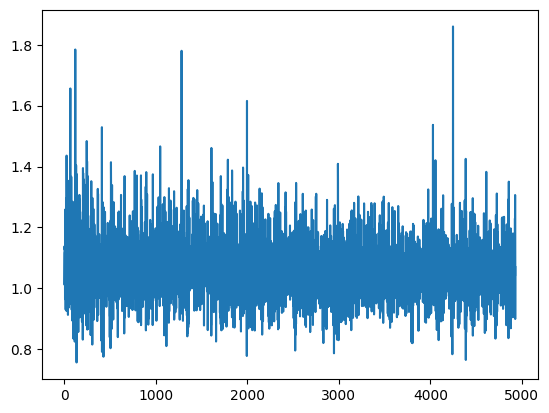

In [37]:
plt.plot(train_losses)

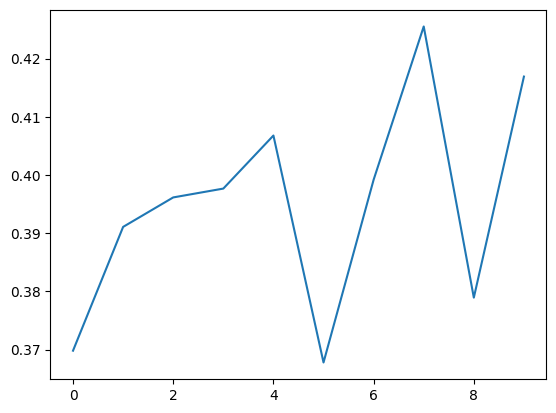

In [38]:
plt.plot(test_accuracy)

In [39]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [40]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 823/1968 (0.4182)
{'acc_detail': tensor([0.5421, 0.5938, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.3786, device='cuda:0'),
 'acc_weighted': tensor(0.4182, device='cuda:0'),
 'f1s': tensor(0.3220, device='cuda:0'),
 'f1s_detail': tensor([0.4850, 0.4810, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.4388, 0.4043, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.5421, 0.5938, 0.0000], device='cuda:0'),
 'rocauc': tensor([0.6403, 0.5009, 0.6565], device='cuda:0'),
 'uar': tensor(0.3786, device='cuda:0'),
 'wap': tensor(0.3075, device='cuda:0')}


tensor([[348, 294,   0],
        [325, 475,   0],
        [120, 406,   0]], device='cuda:0')

In [41]:
model_path = '../models_msp3/msp3_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

(array([  2.,   3.,   5.,   3.,   1.,   3.,   4.,  10.,   7.,   3.,   4.,
          5.,   5.,   5.,   5.,   9.,   5.,  17., 160., 186.,  98.,  41.,
         18.,   8.,   1.,   1.,   2.,   4.,   4.,   2.,   2.,   1.,   3.,
          4.,   5.,   1.,   2.,   0.,   2.,   4.]),
 array([-3.61889740e-03, -3.42986197e-03, -3.24082631e-03, -3.05179087e-03,
        -2.86275521e-03, -2.67371978e-03, -2.48468411e-03, -2.29564868e-03,
        -2.10661301e-03, -1.91757758e-03, -1.72854203e-03, -1.53950648e-03,
        -1.35047093e-03, -1.16143539e-03, -9.72399896e-04, -7.83364347e-04,
        -5.94328798e-04, -4.05293278e-04, -2.16257729e-04, -2.72221987e-05,
         1.61813339e-04,  3.50848888e-04,  5.39884437e-04,  7.28919927e-04,
         9.17955476e-04,  1.10699097e-03,  1.29602652e-03,  1.48506206e-03,
         1.67409761e-03,  1.86313316e-03,  2.05216883e-03,  2.24120426e-03,
         2.43023969e-03,  2.61927536e-03,  2.80831079e-03,  2.99734646e-03,
         3.18638189e-03,  3.37541755e-03, 

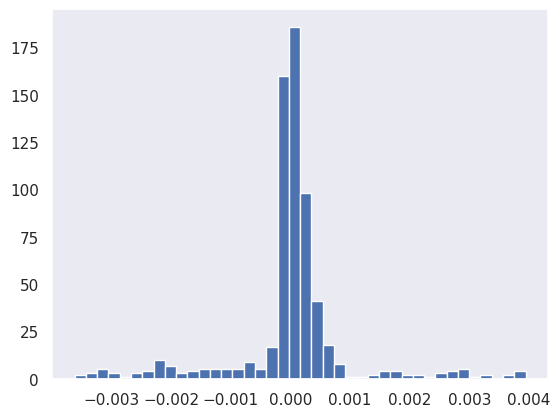

In [42]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer

named_params = [p for p in layer.named_parameters()]
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

Time domain: Filters' shapes vary by frequency bins


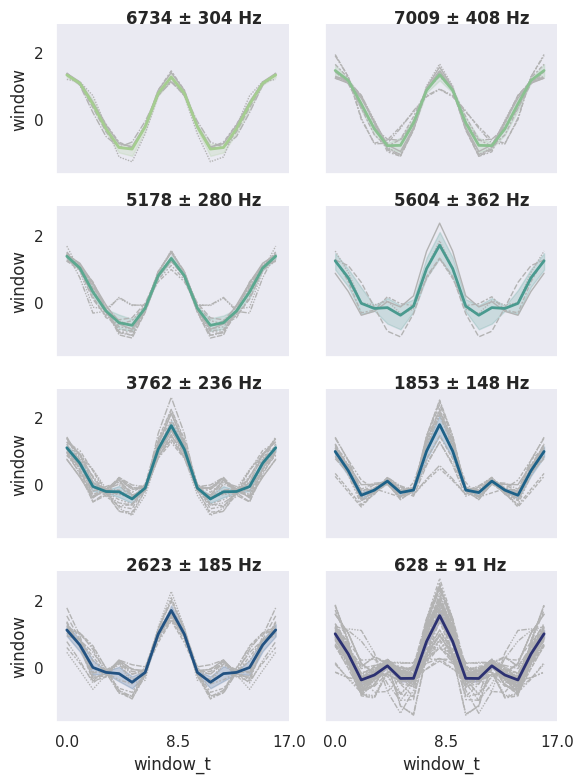

In [43]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


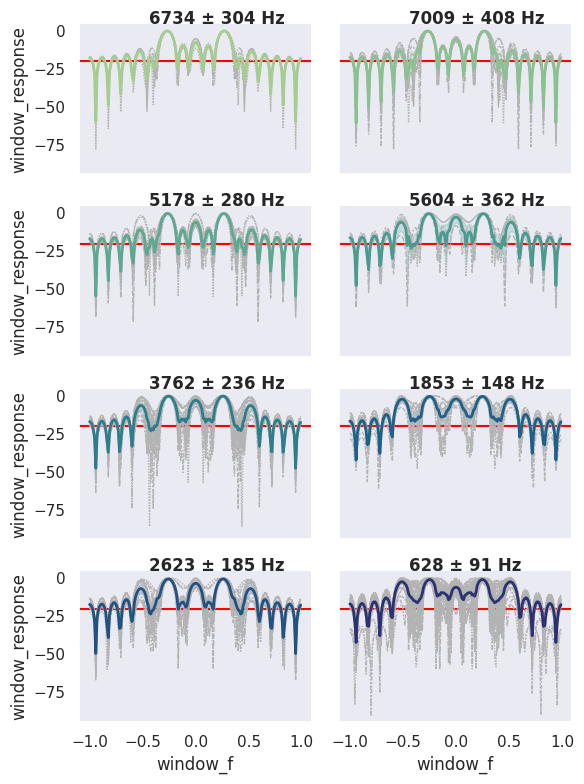

In [44]:
filtviz.visualize_filters(filter_domain='freq')

In [45]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_msp3/msp3_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                         | 0.0016233766233766235/50 [00:00<3:32:49, 255.40s/it]

Train Epoch: 11 [0/7892 (0%)]	Loss: 1.121936
Mem before-during-after: 38958080 3522685440 45575680


  0%|                           | 0.06655844155844157/50 [00:14<3:19:56, 240.25s/it]

Train Epoch: 11 [640/7892 (8%)]	Loss: 1.006125
Mem before-during-after: 45729792 3529625600 45729792


  0%|                           | 0.13149350649350647/50 [00:28<3:20:09, 240.83s/it]

Train Epoch: 11 [1280/7892 (16%)]	Loss: 0.890176
Mem before-during-after: 45729792 3529625600 45729792


  0%|                           | 0.19642857142857087/50 [00:42<3:22:25, 243.86s/it]

Train Epoch: 11 [1920/7892 (24%)]	Loss: 1.031951
Mem before-during-after: 45729792 3529625600 45729792


  1%|▏                          | 0.26136363636363547/50 [00:56<3:18:15, 239.17s/it]

Train Epoch: 11 [2560/7892 (32%)]	Loss: 1.053231
Mem before-during-after: 45729792 3529625600 45729792


  1%|▏                            | 0.326298701298701/50 [01:10<3:18:14, 239.46s/it]

Train Epoch: 11 [3200/7892 (41%)]	Loss: 1.022968
Mem before-during-after: 45729792 3529625600 45729792


  1%|▏                           | 0.3912337662337665/50 [01:24<3:19:35, 241.39s/it]

Train Epoch: 11 [3840/7892 (49%)]	Loss: 1.012348
Mem before-during-after: 45729792 3529625600 45729792


  1%|▎                            | 0.456168831168832/50 [01:38<3:19:43, 241.87s/it]

Train Epoch: 11 [4480/7892 (57%)]	Loss: 1.054389
Mem before-during-after: 45729792 3529625600 45729792


  1%|▎                           | 0.5211038961038975/50 [01:52<3:13:22, 234.49s/it]

Train Epoch: 11 [5120/7892 (65%)]	Loss: 0.923934
Mem before-during-after: 45729792 3529625600 45729792


  1%|▎                            | 0.586038961038963/50 [02:06<3:13:48, 235.34s/it]

Train Epoch: 11 [5760/7892 (73%)]	Loss: 0.978919
Mem before-during-after: 45729792 3529625600 45729792


  1%|▎                           | 0.6509740259740285/50 [02:20<3:13:31, 235.29s/it]

Train Epoch: 11 [6400/7892 (81%)]	Loss: 0.975246
Mem before-during-after: 45729792 3529625600 45729792


  1%|▍                            | 0.715909090909094/50 [02:34<3:12:23, 234.23s/it]

Train Epoch: 11 [7040/7892 (89%)]	Loss: 1.005113
Mem before-during-after: 45729792 3529625600 45729792


  2%|▍                           | 0.7808441558441596/50 [02:47<3:11:41, 233.68s/it]

Train Epoch: 11 [7680/7892 (97%)]	Loss: 1.006031
Mem before-during-after: 45729792 3529625600 45729792


  2%|▌                           | 1.0000000000000056/50 [03:18<1:51:21, 136.35s/it]


Test Epoch: 11	Accuracy: 838/1968 (42%)

saved model: ../models_msp3/msp3_m18_best_11epoch.pt


  2%|▌                           | 1.0016233766233822/50 [03:19<2:11:26, 160.94s/it]

Train Epoch: 12 [0/7892 (0%)]	Loss: 0.983572
Mem before-during-after: 45725696 3530064896 45575680


  2%|▌                           | 1.0665584415584477/50 [03:33<3:10:52, 234.04s/it]

Train Epoch: 12 [640/7892 (8%)]	Loss: 1.127622
Mem before-during-after: 45715968 3530135552 45685248


  2%|▋                           | 1.1314935064935132/50 [03:47<3:11:42, 235.37s/it]

Train Epoch: 12 [1280/7892 (16%)]	Loss: 1.060122
Mem before-during-after: 45715968 3530135552 45685248


  2%|▋                           | 1.1964285714285787/50 [04:01<3:13:27, 237.85s/it]

Train Epoch: 12 [1920/7892 (24%)]	Loss: 1.175328
Mem before-during-after: 45715968 3530135552 45685248


  3%|▋                           | 1.2613636363636442/50 [04:14<3:14:32, 239.49s/it]

Train Epoch: 12 [2560/7892 (32%)]	Loss: 0.947869
Mem before-during-after: 45715968 3530135552 45685248


  3%|▋                           | 1.3262987012987097/50 [04:28<3:11:22, 235.91s/it]

Train Epoch: 12 [3200/7892 (41%)]	Loss: 1.219254
Mem before-during-after: 45715968 3530135552 45685248


  3%|▊                           | 1.3912337662337753/50 [04:42<3:11:11, 236.00s/it]

Train Epoch: 12 [3840/7892 (49%)]	Loss: 0.934884
Mem before-during-after: 45715968 3530135552 45685248


  3%|▊                           | 1.4561688311688408/50 [04:56<3:09:18, 233.98s/it]

Train Epoch: 12 [4480/7892 (57%)]	Loss: 1.003490
Mem before-during-after: 45715968 3530135552 45685248


  3%|▊                           | 1.5211038961039063/50 [05:09<3:10:05, 235.26s/it]

Train Epoch: 12 [5120/7892 (65%)]	Loss: 0.913632
Mem before-during-after: 45715968 3530135552 45685248


  3%|▉                           | 1.5860389610389718/50 [05:23<3:10:57, 236.65s/it]

Train Epoch: 12 [5760/7892 (73%)]	Loss: 1.018809
Mem before-during-after: 45715968 3530135552 45685248


  3%|▉                           | 1.6509740259740373/50 [05:37<3:07:59, 233.30s/it]

Train Epoch: 12 [6400/7892 (81%)]	Loss: 0.853620
Mem before-during-after: 45715968 3530135552 45685248


  3%|▉                           | 1.7159090909091028/50 [05:50<3:07:42, 233.26s/it]

Train Epoch: 12 [7040/7892 (89%)]	Loss: 0.990908
Mem before-during-after: 45715968 3530135552 45685248


  4%|▉                           | 1.7808441558441683/50 [06:04<3:07:44, 233.60s/it]

Train Epoch: 12 [7680/7892 (97%)]	Loss: 0.938003
Mem before-during-after: 45715968 3530135552 45685248


  4%|█▏                           | 2.000000000000014/50 [06:35<1:45:29, 131.87s/it]


Test Epoch: 12	Accuracy: 830/1968 (42%)



  4%|█                           | 2.0016233766233906/50 [06:35<2:05:01, 156.28s/it]

Train Epoch: 13 [0/7892 (0%)]	Loss: 1.024553
Mem before-during-after: 45681152 3529287680 45685248


  4%|█▏                          | 2.0665584415584473/50 [06:49<3:07:33, 234.77s/it]

Train Epoch: 13 [640/7892 (8%)]	Loss: 0.955344
Mem before-during-after: 45729792 3529625600 45715968


  4%|█▏                           | 2.131493506493504/50 [07:03<3:11:12, 239.66s/it]

Train Epoch: 13 [1280/7892 (16%)]	Loss: 1.104715
Mem before-during-after: 45729792 3529625600 45715968


  4%|█▏                          | 2.1964285714285605/50 [07:17<3:07:53, 235.82s/it]

Train Epoch: 13 [1920/7892 (24%)]	Loss: 1.092061
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▎                           | 2.261363636363617/50 [07:30<3:06:31, 234.42s/it]

Train Epoch: 13 [2560/7892 (32%)]	Loss: 0.947730
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▎                          | 2.3262987012986738/50 [07:44<3:09:57, 239.06s/it]

Train Epoch: 13 [3200/7892 (41%)]	Loss: 1.008021
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▎                          | 2.3912337662337304/50 [07:58<3:06:12, 234.67s/it]

Train Epoch: 13 [3840/7892 (49%)]	Loss: 0.980933
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▍                           | 2.456168831168787/50 [08:12<3:06:19, 235.15s/it]

Train Epoch: 13 [4480/7892 (57%)]	Loss: 0.971027
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▍                          | 2.5211038961038437/50 [08:26<3:06:32, 235.73s/it]

Train Epoch: 13 [5120/7892 (65%)]	Loss: 0.984425
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▍                          | 2.5860389610389003/50 [08:40<3:06:56, 236.57s/it]

Train Epoch: 13 [5760/7892 (73%)]	Loss: 1.206715
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▌                           | 2.650974025973957/50 [08:54<3:12:06, 243.44s/it]

Train Epoch: 13 [6400/7892 (81%)]	Loss: 0.981179
Mem before-during-after: 45729792 3529625600 45715968


  5%|█▌                          | 2.7159090909090136/50 [09:07<3:07:38, 238.11s/it]

Train Epoch: 13 [7040/7892 (89%)]	Loss: 0.948184
Mem before-during-after: 45729792 3529625600 45715968


  6%|█▋                            | 2.78084415584407/50 [09:21<3:06:59, 237.60s/it]

Train Epoch: 13 [7680/7892 (97%)]	Loss: 1.083836
Mem before-during-after: 45729792 3529625600 45715968


  6%|█▋                          | 2.9999999999998863/50 [09:52<1:43:30, 132.14s/it]


Test Epoch: 13	Accuracy: 840/1968 (43%)

saved model: ../models_msp3/msp3_m18_best_13epoch.pt


  6%|█▋                          | 3.0016233766232627/50 [09:53<2:05:50, 160.66s/it]

Train Epoch: 14 [0/7892 (0%)]	Loss: 0.995779
Mem before-during-after: 45711872 3530030592 45646336


  6%|█▋                          | 3.0665584415583194/50 [10:06<3:03:20, 234.39s/it]

Train Epoch: 14 [640/7892 (8%)]	Loss: 0.947422
Mem before-during-after: 45729792 3530138112 45729792


  6%|█▊                           | 3.131493506493376/50 [10:20<3:03:29, 234.90s/it]

Train Epoch: 14 [1280/7892 (16%)]	Loss: 1.073485
Mem before-during-after: 45729792 3530138112 45729792


  6%|█▊                          | 3.1964285714284326/50 [10:34<3:05:49, 238.22s/it]

Train Epoch: 14 [1920/7892 (24%)]	Loss: 0.925401
Mem before-during-after: 45729792 3530138112 45729792


  7%|█▊                          | 3.2613636363634892/50 [10:48<3:08:25, 241.90s/it]

Train Epoch: 14 [2560/7892 (32%)]	Loss: 1.101943
Mem before-during-after: 45729792 3530138112 45729792


  7%|█▉                           | 3.326298701298546/50 [11:02<3:10:11, 244.49s/it]

Train Epoch: 14 [3200/7892 (41%)]	Loss: 1.162182
Mem before-during-after: 45729792 3530138112 45729792


  7%|█▉                          | 3.3912337662336025/50 [11:16<3:05:13, 238.44s/it]

Train Epoch: 14 [3840/7892 (49%)]	Loss: 1.190906
Mem before-during-after: 45729792 3530138112 45729792


  7%|██                           | 3.456168831168659/50 [11:30<3:06:58, 241.04s/it]

Train Epoch: 14 [4480/7892 (57%)]	Loss: 1.063287
Mem before-during-after: 45729792 3530138112 45729792


  7%|█▉                          | 3.5211038961037158/50 [11:44<3:02:19, 235.36s/it]

Train Epoch: 14 [5120/7892 (65%)]	Loss: 1.084175
Mem before-during-after: 45729792 3530138112 45729792


  7%|██                          | 3.5860389610387724/50 [11:58<3:00:50, 233.78s/it]

Train Epoch: 14 [5760/7892 (73%)]	Loss: 1.136517
Mem before-during-after: 45729792 3530138112 45729792


  7%|██                           | 3.650974025973829/50 [12:12<3:00:38, 233.84s/it]

Train Epoch: 14 [6400/7892 (81%)]	Loss: 0.917533
Mem before-during-after: 45729792 3530138112 45729792


  7%|██                          | 3.7159090909088857/50 [12:25<3:03:23, 237.74s/it]

Train Epoch: 14 [7040/7892 (89%)]	Loss: 1.154454
Mem before-during-after: 45729792 3530138112 45729792


  8%|██                          | 3.7808441558439423/50 [12:39<3:00:03, 233.75s/it]

Train Epoch: 14 [7680/7892 (97%)]	Loss: 0.892384
Mem before-during-after: 45729792 3530138112 45729792


  8%|██▏                         | 3.9999999999997584/50 [13:10<1:45:14, 137.28s/it]


Test Epoch: 14	Accuracy: 836/1968 (42%)



  8%|██▎                          | 4.001623376623135/50 [13:11<2:03:55, 161.64s/it]

Train Epoch: 15 [0/7892 (0%)]	Loss: 0.910578
Mem before-during-after: 45725696 3530064896 45575680


  8%|██▎                         | 4.0665584415581915/50 [13:25<3:08:05, 245.68s/it]

Train Epoch: 15 [640/7892 (8%)]	Loss: 1.041203
Mem before-during-after: 45729792 3530138112 45729792


  8%|██▍                          | 4.131493506493248/50 [13:39<3:01:39, 237.63s/it]

Train Epoch: 15 [1280/7892 (16%)]	Loss: 0.926934
Mem before-during-after: 45729792 3530138112 45729792


  8%|██▍                          | 4.196428571428305/50 [13:53<3:02:44, 239.38s/it]

Train Epoch: 15 [1920/7892 (24%)]	Loss: 1.048796
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▍                          | 4.261363636363361/50 [14:07<2:59:06, 234.95s/it]

Train Epoch: 15 [2560/7892 (32%)]	Loss: 0.994036
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▌                          | 4.326298701298418/50 [14:21<3:01:00, 237.79s/it]

Train Epoch: 15 [3200/7892 (41%)]	Loss: 1.061580
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▌                          | 4.391233766233475/50 [14:35<3:07:05, 246.13s/it]

Train Epoch: 15 [3840/7892 (49%)]	Loss: 1.061131
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▌                          | 4.456168831168531/50 [14:49<2:59:04, 235.92s/it]

Train Epoch: 15 [4480/7892 (57%)]	Loss: 1.048611
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▌                          | 4.521103896103588/50 [15:03<2:58:06, 234.97s/it]

Train Epoch: 15 [5120/7892 (65%)]	Loss: 1.038709
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▌                         | 4.5860389610386445/50 [15:17<2:58:16, 235.54s/it]

Train Epoch: 15 [5760/7892 (73%)]	Loss: 1.005999
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▋                          | 4.650974025973701/50 [15:31<2:58:41, 236.42s/it]

Train Epoch: 15 [6400/7892 (81%)]	Loss: 1.078542
Mem before-during-after: 45729792 3530138112 45729792


  9%|██▋                          | 4.715909090908758/50 [15:45<2:57:00, 234.53s/it]

Train Epoch: 15 [7040/7892 (89%)]	Loss: 1.029865
Mem before-during-after: 45729792 3530138112 45729792


 10%|██▊                          | 4.780844155843814/50 [15:58<3:01:36, 240.97s/it]

Train Epoch: 15 [7680/7892 (97%)]	Loss: 1.077847
Mem before-during-after: 45729792 3530138112 45729792


 10%|██▊                         | 4.9999999999996305/50 [16:29<1:39:20, 132.45s/it]


Test Epoch: 15	Accuracy: 830/1968 (42%)



 10%|██▉                          | 5.001623376623007/50 [16:30<1:58:59, 158.65s/it]

Train Epoch: 16 [0/7892 (0%)]	Loss: 1.030529
Mem before-during-after: 45725696 3530064896 45575680


 10%|██▉                          | 5.066558441558064/50 [16:44<2:55:31, 234.38s/it]

Train Epoch: 16 [640/7892 (8%)]	Loss: 1.015864
Mem before-during-after: 45729792 3530138112 45729792


 10%|███                           | 5.13149350649312/50 [16:57<2:55:31, 234.71s/it]

Train Epoch: 16 [1280/7892 (16%)]	Loss: 0.944148
Mem before-during-after: 45729792 3530138112 45729792


 10%|███                          | 5.196428571428177/50 [17:11<2:55:10, 234.59s/it]

Train Epoch: 16 [1920/7892 (24%)]	Loss: 1.065753
Mem before-during-after: 45729792 3530138112 45729792


 11%|██▉                         | 5.2613636363632335/50 [17:25<2:54:08, 233.55s/it]

Train Epoch: 16 [2560/7892 (32%)]	Loss: 0.900149
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▏                          | 5.32629870129829/50 [17:39<2:53:57, 233.63s/it]

Train Epoch: 16 [3200/7892 (41%)]	Loss: 0.968868
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▏                         | 5.391233766233347/50 [17:52<2:54:51, 235.19s/it]

Train Epoch: 16 [3840/7892 (49%)]	Loss: 1.044648
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▏                         | 5.456168831168403/50 [18:06<2:54:44, 235.38s/it]

Train Epoch: 16 [4480/7892 (57%)]	Loss: 0.996658
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▎                          | 5.52110389610346/50 [18:20<2:53:37, 234.21s/it]

Train Epoch: 16 [5120/7892 (65%)]	Loss: 0.890415
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▏                         | 5.586038961038517/50 [18:33<2:54:09, 235.26s/it]

Train Epoch: 16 [5760/7892 (73%)]	Loss: 1.014312
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▎                         | 5.650974025973573/50 [18:47<2:54:52, 236.58s/it]

Train Epoch: 16 [6400/7892 (81%)]	Loss: 0.936141
Mem before-during-after: 45729792 3530138112 45729792


 11%|███▍                          | 5.71590909090863/50 [19:01<2:53:48, 235.50s/it]

Train Epoch: 16 [7040/7892 (89%)]	Loss: 0.995466
Mem before-during-after: 45729792 3530138112 45729792


 12%|███▏                        | 5.7808441558436865/50 [19:15<2:53:00, 234.76s/it]

Train Epoch: 16 [7680/7892 (97%)]	Loss: 1.070563
Mem before-during-after: 45729792 3530138112 45729792


 12%|███▍                         | 5.999999999999503/50 [19:46<1:37:12, 132.55s/it]


Test Epoch: 16	Accuracy: 833/1968 (42%)



 12%|███▍                         | 6.001623376622879/50 [19:46<1:56:27, 158.81s/it]

Train Epoch: 17 [0/7892 (0%)]	Loss: 1.161198
Mem before-during-after: 45725696 3530064896 45575680


 12%|███▌                         | 6.066558441557936/50 [20:00<2:52:54, 236.14s/it]

Train Epoch: 17 [640/7892 (8%)]	Loss: 1.067428
Mem before-during-after: 45729792 3529625600 45715968


 12%|███▌                         | 6.131493506492992/50 [20:14<2:52:55, 236.50s/it]

Train Epoch: 17 [1280/7892 (16%)]	Loss: 1.088646
Mem before-during-after: 45729792 3529625600 45715968


 12%|███▌                         | 6.196428571428049/50 [20:28<2:52:18, 236.03s/it]

Train Epoch: 17 [1920/7892 (24%)]	Loss: 0.891749
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▋                         | 6.261363636363106/50 [20:42<2:52:08, 236.13s/it]

Train Epoch: 17 [2560/7892 (32%)]	Loss: 1.022447
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▋                         | 6.326298701298162/50 [20:56<2:52:20, 236.76s/it]

Train Epoch: 17 [3200/7892 (41%)]	Loss: 0.938350
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▋                         | 6.391233766233219/50 [21:09<2:50:35, 234.71s/it]

Train Epoch: 17 [3840/7892 (49%)]	Loss: 1.190532
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▌                        | 6.4561688311682754/50 [21:23<2:52:48, 238.11s/it]

Train Epoch: 17 [4480/7892 (57%)]	Loss: 0.879621
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▊                         | 6.521103896103332/50 [21:37<2:53:13, 239.04s/it]

Train Epoch: 17 [5120/7892 (65%)]	Loss: 1.015367
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▊                         | 6.586038961038389/50 [21:51<2:50:25, 235.53s/it]

Train Epoch: 17 [5760/7892 (73%)]	Loss: 1.145075
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▊                         | 6.650974025973445/50 [22:05<2:50:38, 236.18s/it]

Train Epoch: 17 [6400/7892 (81%)]	Loss: 1.102421
Mem before-during-after: 45729792 3529625600 45715968


 13%|███▉                         | 6.715909090908502/50 [22:19<2:50:17, 236.05s/it]

Train Epoch: 17 [7040/7892 (89%)]	Loss: 1.128610
Mem before-during-after: 45729792 3529625600 45715968


 14%|███▉                         | 6.780844155843559/50 [22:32<2:49:51, 235.82s/it]

Train Epoch: 17 [7680/7892 (97%)]	Loss: 0.956552
Mem before-during-after: 45729792 3529625600 45715968


 14%|████                         | 6.999999999999375/50 [23:03<1:36:09, 134.18s/it]


Test Epoch: 17	Accuracy: 820/1968 (42%)



 14%|████                         | 7.001623376622751/50 [23:04<1:55:16, 160.85s/it]

Train Epoch: 18 [0/7892 (0%)]	Loss: 1.089875
Mem before-during-after: 45711872 3530030592 45646336


 14%|████                         | 7.066558441557808/50 [23:17<2:48:16, 235.17s/it]

Train Epoch: 18 [640/7892 (8%)]	Loss: 1.139445
Mem before-during-after: 45729792 3530138112 45729792


 14%|████▏                        | 7.131493506492864/50 [23:31<2:49:41, 237.50s/it]

Train Epoch: 18 [1280/7892 (16%)]	Loss: 1.073119
Mem before-during-after: 45729792 3530138112 45729792


 14%|████▏                        | 7.196428571427921/50 [23:45<2:47:57, 235.43s/it]

Train Epoch: 18 [1920/7892 (24%)]	Loss: 0.931933
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▏                        | 7.261363636362978/50 [23:59<2:49:27, 237.91s/it]

Train Epoch: 18 [2560/7892 (32%)]	Loss: 1.011303
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▏                        | 7.326298701298034/50 [24:12<2:46:45, 234.47s/it]

Train Epoch: 18 [3200/7892 (41%)]	Loss: 1.105204
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▎                        | 7.391233766233091/50 [24:26<2:47:04, 235.26s/it]

Train Epoch: 18 [3840/7892 (49%)]	Loss: 0.935921
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▏                       | 7.4561688311681475/50 [24:40<2:47:06, 235.68s/it]

Train Epoch: 18 [4480/7892 (57%)]	Loss: 0.981832
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▎                        | 7.521103896103204/50 [24:54<2:46:20, 234.95s/it]

Train Epoch: 18 [5120/7892 (65%)]	Loss: 1.071798
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▍                        | 7.586038961038261/50 [25:08<2:48:37, 238.54s/it]

Train Epoch: 18 [5760/7892 (73%)]	Loss: 1.137774
Mem before-during-after: 45729792 3530138112 45729792


 15%|████▍                        | 7.650974025973317/50 [25:22<2:50:03, 240.93s/it]

Train Epoch: 18 [6400/7892 (81%)]	Loss: 0.995926
Mem before-during-after: 45575680 3529775104 45575680


 15%|████▍                        | 7.715909090908374/50 [25:36<2:45:59, 235.54s/it]

Train Epoch: 18 [7040/7892 (89%)]	Loss: 1.092778
Mem before-during-after: 45729792 3531115008 45729792


 16%|████▌                        | 7.780844155843431/50 [25:49<2:44:59, 234.48s/it]

Train Epoch: 18 [7680/7892 (97%)]	Loss: 1.080575
Mem before-during-after: 45729792 3530599424 45729792


 16%|████▋                        | 7.999999999999247/50 [26:20<1:33:53, 134.13s/it]


Test Epoch: 18	Accuracy: 832/1968 (42%)



 16%|████▋                        | 8.001623376622623/50 [26:21<1:51:51, 159.79s/it]

Train Epoch: 19 [0/7892 (0%)]	Loss: 1.102452
Mem before-during-after: 45725696 3530064896 45575680


 16%|████▊                         | 8.06655844155768/50 [26:35<2:44:28, 235.33s/it]

Train Epoch: 19 [640/7892 (8%)]	Loss: 0.848469
Mem before-during-after: 45729792 3529625600 45715968


 16%|████▋                        | 8.131493506492737/50 [26:49<2:45:43, 237.50s/it]

Train Epoch: 19 [1280/7892 (16%)]	Loss: 1.257176
Mem before-during-after: 45729792 3529625600 45715968


 16%|████▊                        | 8.196428571427793/50 [27:03<2:47:44, 240.77s/it]

Train Epoch: 19 [1920/7892 (24%)]	Loss: 1.243108
Mem before-during-after: 45729792 3529625600 45715968


 17%|████▉                         | 8.26136363636285/50 [27:17<2:45:26, 237.82s/it]

Train Epoch: 19 [2560/7892 (32%)]	Loss: 1.166683
Mem before-during-after: 45729792 3529625600 45715968


 17%|████▊                        | 8.326298701297906/50 [27:31<2:45:01, 237.61s/it]

Train Epoch: 19 [3200/7892 (41%)]	Loss: 0.991221
Mem before-during-after: 45729792 3529625600 45715968


 17%|████▊                        | 8.391233766232963/50 [27:44<2:43:18, 235.50s/it]

Train Epoch: 19 [3840/7892 (49%)]	Loss: 0.981996
Mem before-during-after: 45729792 3529625600 45715968


 17%|█████                         | 8.45616883116802/50 [27:58<2:43:23, 235.97s/it]

Train Epoch: 19 [4480/7892 (57%)]	Loss: 1.170630
Mem before-during-after: 45729792 3529625600 45715968


 17%|████▉                        | 8.521103896103076/50 [28:12<2:45:29, 239.39s/it]

Train Epoch: 19 [5120/7892 (65%)]	Loss: 0.997950
Mem before-during-after: 45729792 3529625600 45715968


 17%|████▉                        | 8.586038961038133/50 [28:26<2:42:40, 235.67s/it]

Train Epoch: 19 [5760/7892 (73%)]	Loss: 0.866923
Mem before-during-after: 45729792 3529625600 45715968


 17%|█████▏                        | 8.65097402597319/50 [28:40<2:42:40, 236.06s/it]

Train Epoch: 19 [6400/7892 (81%)]	Loss: 1.080815
Mem before-during-after: 45729792 3529625600 45715968


 17%|█████                        | 8.715909090908246/50 [28:54<2:43:09, 237.12s/it]

Train Epoch: 19 [7040/7892 (89%)]	Loss: 0.981771
Mem before-during-after: 45729792 3529625600 45715968


 18%|█████                        | 8.780844155843303/50 [29:08<2:44:48, 239.90s/it]

Train Epoch: 19 [7680/7892 (97%)]	Loss: 1.211635
Mem before-during-after: 45729792 3529625600 45715968


 18%|█████▏                       | 8.999999999999119/50 [29:38<1:29:49, 131.44s/it]


Test Epoch: 19	Accuracy: 822/1968 (42%)



 18%|█████▏                       | 9.001623376622495/50 [29:39<1:47:41, 157.60s/it]

Train Epoch: 20 [0/7892 (0%)]	Loss: 1.062949
Mem before-during-after: 45711872 3530030592 45646336


 18%|█████▎                       | 9.066558441557552/50 [29:53<2:39:54, 234.39s/it]

Train Epoch: 20 [640/7892 (8%)]	Loss: 1.013375
Mem before-during-after: 45729792 3530138112 45729792


 18%|█████▎                       | 9.131493506492609/50 [30:06<2:41:49, 237.59s/it]

Train Epoch: 20 [1280/7892 (16%)]	Loss: 0.936108
Mem before-during-after: 45729792 3530138112 45729792


 18%|█████▎                       | 9.196428571427665/50 [30:20<2:39:27, 234.48s/it]

Train Epoch: 20 [1920/7892 (24%)]	Loss: 0.971519
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▎                       | 9.261363636362722/50 [30:34<2:40:13, 235.99s/it]

Train Epoch: 20 [2560/7892 (32%)]	Loss: 0.981359
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▍                       | 9.326298701297778/50 [30:48<2:45:54, 244.74s/it]

Train Epoch: 20 [3200/7892 (41%)]	Loss: 0.935688
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▍                       | 9.391233766232835/50 [31:02<2:40:30, 237.16s/it]

Train Epoch: 20 [3840/7892 (49%)]	Loss: 1.077205
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▍                       | 9.456168831167892/50 [31:15<2:41:19, 238.75s/it]

Train Epoch: 20 [4480/7892 (57%)]	Loss: 1.000934
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▌                       | 9.521103896102948/50 [31:29<2:38:59, 235.66s/it]

Train Epoch: 20 [5120/7892 (65%)]	Loss: 0.853029
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▌                       | 9.586038961038005/50 [31:43<2:40:11, 237.84s/it]

Train Epoch: 20 [5760/7892 (73%)]	Loss: 1.023871
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▌                       | 9.650974025973062/50 [31:57<2:38:14, 235.31s/it]

Train Epoch: 20 [6400/7892 (81%)]	Loss: 1.008151
Mem before-during-after: 45729792 3530138112 45729792


 19%|█████▋                       | 9.715909090908118/50 [32:11<2:38:00, 235.33s/it]

Train Epoch: 20 [7040/7892 (89%)]	Loss: 0.921935
Mem before-during-after: 45729792 3530138112 45729792


 20%|█████▋                       | 9.780844155843175/50 [32:25<2:38:43, 236.78s/it]

Train Epoch: 20 [7680/7892 (97%)]	Loss: 0.945087
Mem before-during-after: 45729792 3530138112 45729792


 20%|█████▊                       | 9.999999999998991/50 [32:56<1:29:06, 133.66s/it]


Test Epoch: 20	Accuracy: 829/1968 (42%)



 20%|█████▌                      | 10.001623376622367/50 [32:56<1:47:03, 160.58s/it]

Train Epoch: 21 [0/7892 (0%)]	Loss: 0.952542
Mem before-during-after: 45725696 3530064896 45575680


 20%|█████▋                      | 10.066558441557424/50 [33:10<2:36:57, 235.82s/it]

Train Epoch: 21 [640/7892 (8%)]	Loss: 1.028173
Mem before-during-after: 45729792 3529625600 45715968


 20%|█████▉                       | 10.13149350649248/50 [33:24<2:36:17, 235.20s/it]

Train Epoch: 21 [1280/7892 (16%)]	Loss: 1.071547
Mem before-during-after: 45729792 3529625600 45715968


 20%|█████▋                      | 10.196428571427537/50 [33:38<2:36:50, 236.42s/it]

Train Epoch: 21 [1920/7892 (24%)]	Loss: 0.889729
Mem before-during-after: 45729792 3529625600 45715968


 21%|█████▋                      | 10.261363636362594/50 [33:51<2:36:38, 236.50s/it]

Train Epoch: 21 [2560/7892 (32%)]	Loss: 1.124746
Mem before-during-after: 45729792 3529625600 45715968


 21%|█████▉                       | 10.32629870129765/50 [34:05<2:37:08, 237.65s/it]

Train Epoch: 21 [3200/7892 (41%)]	Loss: 1.029108
Mem before-during-after: 45729792 3529625600 45715968


 21%|█████▊                      | 10.391233766232707/50 [34:19<2:37:02, 237.90s/it]

Train Epoch: 21 [3840/7892 (49%)]	Loss: 0.915306
Mem before-during-after: 45729792 3529625600 45715968


 21%|█████▊                      | 10.456168831167764/50 [34:33<2:35:18, 235.65s/it]

Train Epoch: 21 [4480/7892 (57%)]	Loss: 1.074972
Mem before-during-after: 45729792 3529625600 45715968


 21%|██████                       | 10.52110389610282/50 [34:47<2:34:20, 234.58s/it]

Train Epoch: 21 [5120/7892 (65%)]	Loss: 0.929823
Mem before-during-after: 45729792 3529625600 45715968


 21%|█████▉                      | 10.586038961037877/50 [35:01<2:41:04, 245.20s/it]

Train Epoch: 21 [5760/7892 (73%)]	Loss: 0.980297
Mem before-during-after: 45729792 3529625600 45715968


 21%|█████▉                      | 10.650974025972934/50 [35:14<2:35:01, 236.39s/it]

Train Epoch: 21 [6400/7892 (81%)]	Loss: 1.118485
Mem before-during-after: 45729792 3529625600 45715968


 21%|██████▏                      | 10.71590909090799/50 [35:28<2:34:30, 235.98s/it]

Train Epoch: 21 [7040/7892 (89%)]	Loss: 0.977239
Mem before-during-after: 45729792 3529625600 45715968


 22%|██████                      | 10.780844155843047/50 [35:42<2:34:36, 236.53s/it]

Train Epoch: 21 [7680/7892 (97%)]	Loss: 1.030972
Mem before-during-after: 45729792 3529625600 45715968


 22%|██████▏                     | 10.999999999998863/50 [36:13<1:25:55, 132.20s/it]


Test Epoch: 21	Accuracy: 821/1968 (42%)



 22%|██████▍                      | 11.00162337662224/50 [36:13<1:43:18, 158.94s/it]

Train Epoch: 22 [0/7892 (0%)]	Loss: 1.003905
Mem before-during-after: 45711872 3530030592 45646336


 22%|██████▏                     | 11.066558441557296/50 [36:27<2:32:19, 234.74s/it]

Train Epoch: 22 [640/7892 (8%)]	Loss: 0.970158
Mem before-during-after: 45729792 3530138112 45729792


 22%|██████▏                     | 11.131493506492353/50 [36:41<2:34:26, 238.42s/it]

Train Epoch: 22 [1280/7892 (16%)]	Loss: 1.083607
Mem before-during-after: 45729792 3530138112 45729792


 22%|██████▍                      | 11.19642857142741/50 [36:55<2:34:33, 238.98s/it]

Train Epoch: 22 [1920/7892 (24%)]	Loss: 1.004477
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▎                     | 11.261363636362466/50 [37:09<2:32:13, 235.77s/it]

Train Epoch: 22 [2560/7892 (32%)]	Loss: 0.992684
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▎                     | 11.326298701297523/50 [37:23<2:31:39, 235.30s/it]

Train Epoch: 22 [3200/7892 (41%)]	Loss: 1.033652
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▌                      | 11.39123376623258/50 [37:37<2:33:34, 238.66s/it]

Train Epoch: 22 [3840/7892 (49%)]	Loss: 0.973951
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▍                     | 11.456168831167636/50 [37:50<2:30:52, 234.86s/it]

Train Epoch: 22 [4480/7892 (57%)]	Loss: 0.965727
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▍                     | 11.521103896102693/50 [38:04<2:30:44, 235.04s/it]

Train Epoch: 22 [5120/7892 (65%)]	Loss: 1.146394
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▋                      | 11.58603896103775/50 [38:18<2:31:14, 236.23s/it]

Train Epoch: 22 [5760/7892 (73%)]	Loss: 1.143852
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▌                     | 11.650974025972806/50 [38:32<2:31:26, 236.94s/it]

Train Epoch: 22 [6400/7892 (81%)]	Loss: 1.034780
Mem before-during-after: 45729792 3530138112 45729792


 23%|██████▌                     | 11.715909090907862/50 [38:46<2:30:57, 236.58s/it]

Train Epoch: 22 [7040/7892 (89%)]	Loss: 0.983719
Mem before-during-after: 45729792 3530138112 45729792


 24%|██████▌                     | 11.780844155842919/50 [39:00<2:31:18, 237.53s/it]

Train Epoch: 22 [7680/7892 (97%)]	Loss: 1.150831
Mem before-during-after: 45729792 3530138112 45729792


 24%|██████▋                     | 11.999999999998735/50 [39:31<1:25:13, 134.56s/it]


Test Epoch: 22	Accuracy: 847/1968 (43%)

saved model: ../models_msp3/msp3_m18_best_22epoch.pt


 24%|██████▋                     | 12.001623376622112/50 [39:31<1:43:11, 162.94s/it]

Train Epoch: 23 [0/7892 (0%)]	Loss: 1.007053
Mem before-during-after: 45725696 3530064896 45575680


 24%|██████▊                     | 12.066558441557168/50 [39:45<2:28:46, 235.32s/it]

Train Epoch: 23 [640/7892 (8%)]	Loss: 1.036713
Mem before-during-after: 45729792 3529625600 45715968


 24%|██████▊                     | 12.131493506492225/50 [39:59<2:29:30, 236.89s/it]

Train Epoch: 23 [1280/7892 (16%)]	Loss: 0.902188
Mem before-during-after: 45729792 3529625600 45715968


 24%|██████▊                     | 12.196428571427282/50 [40:13<2:31:26, 240.36s/it]

Train Epoch: 23 [1920/7892 (24%)]	Loss: 0.958010
Mem before-during-after: 45729792 3529625600 45715968


 25%|██████▊                     | 12.261363636362338/50 [40:27<2:28:30, 236.12s/it]

Train Epoch: 23 [2560/7892 (32%)]	Loss: 1.040973
Mem before-during-after: 45729792 3529625600 45715968


 25%|██████▉                     | 12.326298701297395/50 [40:41<2:29:10, 237.59s/it]

Train Epoch: 23 [3200/7892 (41%)]	Loss: 0.974665
Mem before-during-after: 45729792 3529625600 45715968


 25%|██████▉                     | 12.391233766232451/50 [40:54<2:27:57, 236.05s/it]

Train Epoch: 23 [3840/7892 (49%)]	Loss: 0.965249
Mem before-during-after: 45729792 3529625600 45715968


 25%|██████▉                     | 12.456168831167508/50 [41:08<2:27:07, 235.13s/it]

Train Epoch: 23 [4480/7892 (57%)]	Loss: 1.050725
Mem before-during-after: 45729792 3529625600 45715968


 25%|███████                     | 12.521103896102565/50 [41:22<2:27:33, 236.22s/it]

Train Epoch: 23 [5120/7892 (65%)]	Loss: 0.935117
Mem before-during-after: 45729792 3529625600 45715968


 25%|███████                     | 12.586038961037621/50 [41:36<2:26:58, 235.71s/it]

Train Epoch: 23 [5760/7892 (73%)]	Loss: 0.871425
Mem before-during-after: 45729792 3529625600 45715968


 25%|███████                     | 12.650974025972678/50 [41:50<2:26:21, 235.12s/it]

Train Epoch: 23 [6400/7892 (81%)]	Loss: 1.117192
Mem before-during-after: 45729792 3529625600 45715968


 25%|███████                     | 12.715909090907735/50 [42:03<2:27:17, 237.03s/it]

Train Epoch: 23 [7040/7892 (89%)]	Loss: 1.153280
Mem before-during-after: 45729792 3529625600 45715968


 26%|███████▏                    | 12.780844155842791/50 [42:17<2:26:39, 236.42s/it]

Train Epoch: 23 [7680/7892 (97%)]	Loss: 1.099043
Mem before-during-after: 45729792 3529625600 45715968


 26%|███████▎                    | 12.999999999998607/50 [42:48<1:21:23, 131.99s/it]


Test Epoch: 23	Accuracy: 833/1968 (42%)



 26%|███████▎                    | 13.001623376621984/50 [42:49<1:37:24, 157.96s/it]

Train Epoch: 24 [0/7892 (0%)]	Loss: 1.050218
Mem before-during-after: 45711872 3530030592 45646336


 26%|███████▌                     | 13.06655844155704/50 [43:02<2:25:10, 235.84s/it]

Train Epoch: 24 [640/7892 (8%)]	Loss: 0.971400
Mem before-during-after: 45729792 3530138112 45729792


 26%|███████▎                    | 13.131493506492097/50 [43:16<2:25:53, 237.43s/it]

Train Epoch: 24 [1280/7892 (16%)]	Loss: 0.901987
Mem before-during-after: 45729792 3530138112 45729792


 26%|███████▍                    | 13.196428571427154/50 [43:30<2:24:19, 235.29s/it]

Train Epoch: 24 [1920/7892 (24%)]	Loss: 1.279777
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▋                     | 13.26136363636221/50 [43:44<2:24:58, 236.76s/it]

Train Epoch: 24 [2560/7892 (32%)]	Loss: 0.997651
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▍                    | 13.326298701297267/50 [43:58<2:25:13, 237.60s/it]

Train Epoch: 24 [3200/7892 (41%)]	Loss: 0.980846
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▍                    | 13.391233766232324/50 [44:12<2:23:47, 235.68s/it]

Train Epoch: 24 [3840/7892 (49%)]	Loss: 0.881814
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▊                     | 13.45616883116738/50 [44:25<2:23:55, 236.30s/it]

Train Epoch: 24 [4480/7892 (57%)]	Loss: 1.052873
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▌                    | 13.521103896102437/50 [44:39<2:23:02, 235.26s/it]

Train Epoch: 24 [5120/7892 (65%)]	Loss: 0.896835
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▌                    | 13.586038961037493/50 [44:53<2:23:24, 236.31s/it]

Train Epoch: 24 [5760/7892 (73%)]	Loss: 1.006930
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▉                     | 13.65097402597255/50 [45:07<2:22:41, 235.53s/it]

Train Epoch: 24 [6400/7892 (81%)]	Loss: 1.090863
Mem before-during-after: 45729792 3530138112 45729792


 27%|███████▋                    | 13.715909090907607/50 [45:21<2:22:18, 235.32s/it]

Train Epoch: 24 [7040/7892 (89%)]	Loss: 1.279973
Mem before-during-after: 45729792 3530138112 45729792


 28%|███████▋                    | 13.780844155842663/50 [45:34<2:21:59, 235.22s/it]

Train Epoch: 24 [7680/7892 (97%)]	Loss: 0.921786
Mem before-during-after: 45729792 3530138112 45729792


 28%|████████                     | 13.99999999999848/50 [46:05<1:21:15, 135.43s/it]


Test Epoch: 24	Accuracy: 844/1968 (43%)



 28%|███████▊                    | 14.001623376621856/50 [46:06<1:35:30, 159.19s/it]

Train Epoch: 25 [0/7892 (0%)]	Loss: 0.899177
Mem before-during-after: 45725696 3530064896 45575680


 28%|███████▉                    | 14.066558441556912/50 [46:20<2:22:05, 237.25s/it]

Train Epoch: 25 [640/7892 (8%)]	Loss: 1.202901
Mem before-during-after: 45729792 3529625600 45715968


 28%|████████▏                    | 14.13149350649197/50 [46:34<2:22:25, 238.25s/it]

Train Epoch: 25 [1280/7892 (16%)]	Loss: 1.071575
Mem before-during-after: 45729792 3529625600 45715968


 28%|███████▉                    | 14.196428571427026/50 [46:47<2:21:34, 237.26s/it]

Train Epoch: 25 [1920/7892 (24%)]	Loss: 0.952624
Mem before-during-after: 45729792 3529625600 45715968


 29%|███████▉                    | 14.261363636362082/50 [47:01<2:20:51, 236.49s/it]

Train Epoch: 25 [2560/7892 (32%)]	Loss: 0.959495
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████                    | 14.326298701297139/50 [47:15<2:19:47, 235.13s/it]

Train Epoch: 25 [3200/7892 (41%)]	Loss: 1.014777
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████                    | 14.391233766232196/50 [47:29<2:19:24, 234.91s/it]

Train Epoch: 25 [3840/7892 (49%)]	Loss: 0.912772
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████                    | 14.456168831167252/50 [47:43<2:22:51, 241.15s/it]

Train Epoch: 25 [4480/7892 (57%)]	Loss: 1.040303
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████▏                   | 14.521103896102309/50 [47:56<2:20:35, 237.77s/it]

Train Epoch: 25 [5120/7892 (65%)]	Loss: 0.918371
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████▏                   | 14.586038961037366/50 [48:10<2:18:33, 234.76s/it]

Train Epoch: 25 [5760/7892 (73%)]	Loss: 1.300936
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████▏                   | 14.650974025972422/50 [48:24<2:18:29, 235.06s/it]

Train Epoch: 25 [6400/7892 (81%)]	Loss: 0.908926
Mem before-during-after: 45729792 3529625600 45715968


 29%|████████▏                   | 14.715909090907479/50 [48:38<2:19:26, 237.12s/it]

Train Epoch: 25 [7040/7892 (89%)]	Loss: 1.059430
Mem before-during-after: 45729792 3529625600 45715968


 30%|████████▎                   | 14.780844155842535/50 [48:52<2:18:19, 235.65s/it]

Train Epoch: 25 [7680/7892 (97%)]	Loss: 0.926378
Mem before-during-after: 45729792 3529625600 45715968


 30%|████████▍                   | 14.999999999998352/50 [49:23<1:17:53, 133.51s/it]


Test Epoch: 25	Accuracy: 881/1968 (45%)

saved model: ../models_msp3/msp3_m18_best_25epoch.pt


 30%|████████▍                   | 15.001623376621728/50 [49:23<1:33:50, 160.86s/it]

Train Epoch: 26 [0/7892 (0%)]	Loss: 0.931905
Mem before-during-after: 45711872 3530030592 45646336


 30%|████████▍                   | 15.066558441556785/50 [49:37<2:17:00, 235.32s/it]

Train Epoch: 26 [640/7892 (8%)]	Loss: 0.959575
Mem before-during-after: 45729792 3530138112 45729792


 30%|████████▍                   | 15.131493506491841/50 [49:50<2:16:45, 235.33s/it]

Train Epoch: 26 [1280/7892 (16%)]	Loss: 1.233362
Mem before-during-after: 45729792 3530138112 45729792


 30%|████████▌                   | 15.196428571426898/50 [50:04<2:21:18, 243.60s/it]

Train Epoch: 26 [1920/7892 (24%)]	Loss: 0.938365
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▌                   | 15.261363636361954/50 [50:18<2:18:25, 239.08s/it]

Train Epoch: 26 [2560/7892 (32%)]	Loss: 1.013381
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▌                   | 15.326298701297011/50 [50:32<2:16:20, 235.93s/it]

Train Epoch: 26 [3200/7892 (41%)]	Loss: 1.043457
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▌                   | 15.391233766232068/50 [50:46<2:16:21, 236.41s/it]

Train Epoch: 26 [3840/7892 (49%)]	Loss: 1.017394
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▋                   | 15.456168831167124/50 [50:59<2:15:37, 235.56s/it]

Train Epoch: 26 [4480/7892 (57%)]	Loss: 1.147923
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▋                   | 15.521103896102181/50 [51:13<2:15:01, 234.96s/it]

Train Epoch: 26 [5120/7892 (65%)]	Loss: 0.894817
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▋                   | 15.586038961037238/50 [51:27<2:16:24, 237.84s/it]

Train Epoch: 26 [5760/7892 (73%)]	Loss: 0.889619
Mem before-during-after: 45729792 3530138112 45729792


 31%|████████▊                   | 15.650974025972294/50 [51:41<2:17:54, 240.89s/it]

Train Epoch: 26 [6400/7892 (81%)]	Loss: 0.976314
Mem before-during-after: 45729792 3530138112 45729792


 31%|█████████                    | 15.71590909090735/50 [51:55<2:16:11, 238.36s/it]

Train Epoch: 26 [7040/7892 (89%)]	Loss: 0.908307
Mem before-during-after: 45729792 3530138112 45729792


 32%|████████▊                   | 15.780844155842408/50 [52:09<2:16:13, 238.87s/it]

Train Epoch: 26 [7680/7892 (97%)]	Loss: 1.088946
Mem before-during-after: 45729792 3530138112 45729792


 32%|████████▉                   | 15.999999999998224/50 [52:40<1:18:20, 138.26s/it]


Test Epoch: 26	Accuracy: 915/1968 (46%)

saved model: ../models_msp3/msp3_m18_best_26epoch.pt


 32%|████████▉                   | 16.001623376621602/50 [52:41<1:33:06, 164.30s/it]

Train Epoch: 27 [0/7892 (0%)]	Loss: 0.961415
Mem before-during-after: 45725696 3530064896 45575680


 32%|█████████▎                   | 16.06655844155673/50 [52:55<2:13:34, 236.19s/it]

Train Epoch: 27 [640/7892 (8%)]	Loss: 0.888465
Mem before-during-after: 45729792 3529625600 45715968


 32%|█████████                   | 16.131493506491857/50 [53:08<2:13:55, 237.25s/it]

Train Epoch: 27 [1280/7892 (16%)]	Loss: 0.902003
Mem before-during-after: 45729792 3529625600 45715968


 32%|█████████                   | 16.196428571426985/50 [53:22<2:12:52, 235.86s/it]

Train Epoch: 27 [1920/7892 (24%)]	Loss: 0.939618
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████                   | 16.261363636362113/50 [53:36<2:13:22, 237.18s/it]

Train Epoch: 27 [2560/7892 (32%)]	Loss: 0.877401
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▍                   | 16.32629870129724/50 [53:50<2:12:48, 236.64s/it]

Train Epoch: 27 [3200/7892 (41%)]	Loss: 0.941182
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▏                  | 16.391233766232368/50 [54:04<2:11:41, 235.09s/it]

Train Epoch: 27 [3840/7892 (49%)]	Loss: 0.890782
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▏                  | 16.456168831167496/50 [54:17<2:11:28, 235.16s/it]

Train Epoch: 27 [4480/7892 (57%)]	Loss: 0.908540
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▎                  | 16.521103896102623/50 [54:31<2:11:13, 235.17s/it]

Train Epoch: 27 [5120/7892 (65%)]	Loss: 0.825981
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▌                   | 16.58603896103775/50 [54:45<2:11:44, 236.57s/it]

Train Epoch: 27 [5760/7892 (73%)]	Loss: 0.815278
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▋                   | 16.65097402597288/50 [54:59<2:11:58, 237.43s/it]

Train Epoch: 27 [6400/7892 (81%)]	Loss: 1.006858
Mem before-during-after: 45729792 3529625600 45715968


 33%|█████████▎                  | 16.715909090908006/50 [55:13<2:11:09, 236.43s/it]

Train Epoch: 27 [7040/7892 (89%)]	Loss: 0.864650
Mem before-during-after: 45729792 3529625600 45715968


 34%|█████████▍                  | 16.780844155843134/50 [55:27<2:12:11, 238.77s/it]

Train Epoch: 27 [7680/7892 (97%)]	Loss: 0.998209
Mem before-during-after: 45729792 3529625600 45715968


 34%|█████████▊                   | 16.99999999999919/50 [55:58<1:13:53, 134.34s/it]


Test Epoch: 27	Accuracy: 823/1968 (42%)



 34%|█████████▌                  | 17.001623376622568/50 [55:58<1:45:12, 191.30s/it]

Train Epoch: 28 [0/7892 (0%)]	Loss: 0.925272
Mem before-during-after: 45711872 3530030592 45646336


 34%|█████████▌                  | 17.066558441557696/50 [56:12<2:10:25, 237.63s/it]

Train Epoch: 28 [640/7892 (8%)]	Loss: 1.264833
Mem before-during-after: 45729792 3530138112 45729792


 34%|█████████▌                  | 17.131493506492824/50 [56:26<2:10:59, 239.13s/it]

Train Epoch: 28 [1280/7892 (16%)]	Loss: 1.215426
Mem before-during-after: 45729792 3530138112 45729792


 34%|█████████▉                   | 17.19642857142795/50 [56:40<2:08:23, 234.83s/it]

Train Epoch: 28 [1920/7892 (24%)]	Loss: 0.815156
Mem before-during-after: 45729792 3530138112 45729792


 35%|██████████                   | 17.26136363636308/50 [56:53<2:08:24, 235.32s/it]

Train Epoch: 28 [2560/7892 (32%)]	Loss: 0.947281
Mem before-during-after: 45729792 3530138112 45729792


 35%|█████████▋                  | 17.326298701298207/50 [57:07<2:07:48, 234.71s/it]

Train Epoch: 28 [3200/7892 (41%)]	Loss: 1.104757
Mem before-during-after: 45729792 3530138112 45729792


 35%|█████████▋                  | 17.391233766233334/50 [57:21<2:09:18, 237.93s/it]

Train Epoch: 28 [3840/7892 (49%)]	Loss: 1.009932
Mem before-during-after: 45729792 3530138112 45729792


 35%|█████████▊                  | 17.456168831168462/50 [57:35<2:09:16, 238.33s/it]

Train Epoch: 28 [4480/7892 (57%)]	Loss: 1.009932
Mem before-during-after: 45729792 3530138112 45729792


 35%|██████████▏                  | 17.52110389610359/50 [57:49<2:08:55, 238.17s/it]

Train Epoch: 28 [5120/7892 (65%)]	Loss: 0.772262
Mem before-during-after: 45729792 3530138112 45729792


 35%|█████████▊                  | 17.586038961038717/50 [58:03<2:06:49, 234.77s/it]

Train Epoch: 28 [5760/7892 (73%)]	Loss: 0.918590
Mem before-during-after: 45729792 3530138112 45729792


 35%|█████████▉                  | 17.650974025973845/50 [58:17<2:09:27, 240.12s/it]

Train Epoch: 28 [6400/7892 (81%)]	Loss: 0.973217
Mem before-during-after: 45729792 3530138112 45729792


 35%|█████████▉                  | 17.715909090908973/50 [58:30<2:06:22, 234.86s/it]

Train Epoch: 28 [7040/7892 (89%)]	Loss: 0.911116
Mem before-during-after: 45729792 3530138112 45729792


 36%|██████████▋                   | 17.7808441558441/50 [58:44<2:06:15, 235.13s/it]

Train Epoch: 28 [7680/7892 (97%)]	Loss: 0.977229
Mem before-during-after: 45729792 3530138112 45729792


 36%|██████████                  | 18.000000000000156/50 [59:15<1:12:37, 136.18s/it]


Test Epoch: 28	Accuracy: 928/1968 (47%)

saved model: ../models_msp3/msp3_m18_best_28epoch.pt


 36%|██████████                  | 18.001623376623535/50 [59:16<1:25:48, 160.90s/it]

Train Epoch: 29 [0/7892 (0%)]	Loss: 0.904533
Mem before-during-after: 45725696 3530064896 45575680


 36%|██████████                  | 18.066558441558662/50 [59:30<2:06:02, 236.82s/it]

Train Epoch: 29 [640/7892 (8%)]	Loss: 1.056696
Mem before-during-after: 45729792 3529625600 45715968


 36%|██████████▌                  | 18.13149350649379/50 [59:44<2:05:14, 235.80s/it]

Train Epoch: 29 [1280/7892 (16%)]	Loss: 0.775759
Mem before-during-after: 45729792 3529625600 45715968


 36%|██████████▏                 | 18.196428571428918/50 [59:57<2:05:22, 236.54s/it]

Train Epoch: 29 [1920/7892 (24%)]	Loss: 0.909809
Mem before-during-after: 45729792 3529625600 45715968


 37%|█████████▍                | 18.261363636364045/50 [1:00:11<2:04:19, 235.02s/it]

Train Epoch: 29 [2560/7892 (32%)]	Loss: 0.910896
Mem before-during-after: 45729792 3529625600 45715968


 37%|█████████▌                | 18.326298701299173/50 [1:00:25<2:04:45, 236.32s/it]

Train Epoch: 29 [3200/7892 (41%)]	Loss: 0.953911
Mem before-during-after: 45729792 3529625600 45715968


 37%|██████████▎                 | 18.3912337662343/50 [1:00:39<2:04:39, 236.63s/it]

Train Epoch: 29 [3840/7892 (49%)]	Loss: 1.104896
Mem before-during-after: 45729792 3529625600 45715968


 37%|█████████▉                 | 18.45616883116943/50 [1:00:53<2:05:15, 238.27s/it]

Train Epoch: 29 [4480/7892 (57%)]	Loss: 0.901087
Mem before-during-after: 45729792 3529625600 45715968


 37%|█████████▋                | 18.521103896104556/50 [1:01:07<2:03:59, 236.34s/it]

Train Epoch: 29 [5120/7892 (65%)]	Loss: 0.890356
Mem before-during-after: 45729792 3529625600 45715968


 37%|█████████▋                | 18.586038961039684/50 [1:01:21<2:05:21, 239.44s/it]

Train Epoch: 29 [5760/7892 (73%)]	Loss: 0.941440
Mem before-during-after: 45729792 3529625600 45715968


 37%|██████████                 | 18.65097402597481/50 [1:01:34<2:03:12, 235.80s/it]

Train Epoch: 29 [6400/7892 (81%)]	Loss: 1.008833
Mem before-during-after: 45729792 3529625600 45715968


 37%|██████████                 | 18.71590909090994/50 [1:01:48<2:02:57, 235.83s/it]

Train Epoch: 29 [7040/7892 (89%)]	Loss: 0.939317
Mem before-during-after: 45729792 3529625600 45715968


 38%|█████████▊                | 18.780844155845067/50 [1:02:02<2:02:21, 235.17s/it]

Train Epoch: 29 [7680/7892 (97%)]	Loss: 1.052598
Mem before-during-after: 45729792 3529625600 45715968


 38%|█████████▉                | 19.000000000001123/50 [1:02:33<1:11:22, 138.14s/it]


Test Epoch: 29	Accuracy: 900/1968 (46%)



 38%|██████████▋                 | 19.0016233766245/50 [1:02:33<1:24:15, 163.08s/it]

Train Epoch: 30 [0/7892 (0%)]	Loss: 1.020641
Mem before-during-after: 45711872 3530030592 45646336


 38%|██████████▎                | 19.06655844155963/50 [1:02:47<2:01:52, 236.41s/it]

Train Epoch: 30 [640/7892 (8%)]	Loss: 0.973529
Mem before-during-after: 45729792 3530138112 45729792


 38%|█████████▉                | 19.131493506494756/50 [1:03:01<2:01:14, 235.66s/it]

Train Epoch: 30 [1280/7892 (16%)]	Loss: 0.983710
Mem before-during-after: 45729792 3530138112 45729792


 38%|█████████▉                | 19.196428571429884/50 [1:03:15<2:01:57, 237.55s/it]

Train Epoch: 30 [1920/7892 (24%)]	Loss: 0.816723
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████▍                | 19.26136363636501/50 [1:03:28<2:01:10, 236.53s/it]

Train Epoch: 30 [2560/7892 (32%)]	Loss: 1.325809
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████▍                | 19.32629870130014/50 [1:03:42<2:00:37, 235.95s/it]

Train Epoch: 30 [3200/7892 (41%)]	Loss: 0.844558
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████                | 19.391233766235267/50 [1:03:56<2:00:50, 236.86s/it]

Train Epoch: 30 [3840/7892 (49%)]	Loss: 0.915578
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████                | 19.456168831170395/50 [1:04:10<2:00:26, 236.60s/it]

Train Epoch: 30 [4480/7892 (57%)]	Loss: 0.934264
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████▏               | 19.521103896105522/50 [1:04:24<1:59:40, 235.59s/it]

Train Epoch: 30 [5120/7892 (65%)]	Loss: 0.952351
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████▌                | 19.58603896104065/50 [1:04:38<2:01:24, 239.50s/it]

Train Epoch: 30 [5760/7892 (73%)]	Loss: 0.889536
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████▏               | 19.650974025975778/50 [1:04:51<1:59:22, 236.01s/it]

Train Epoch: 30 [6400/7892 (81%)]	Loss: 0.914220
Mem before-during-after: 45729792 3530138112 45729792


 39%|██████████▎               | 19.715909090910905/50 [1:05:05<1:58:42, 235.20s/it]

Train Epoch: 30 [7040/7892 (89%)]	Loss: 1.093315
Mem before-during-after: 45729792 3530138112 45729792


 40%|██████████▎               | 19.780844155846033/50 [1:05:19<1:58:13, 234.72s/it]

Train Epoch: 30 [7680/7892 (97%)]	Loss: 0.812870
Mem before-during-after: 45729792 3530138112 45729792


 40%|██████████▊                | 20.00000000000209/50 [1:05:50<1:08:58, 137.96s/it]


Test Epoch: 30	Accuracy: 933/1968 (47%)

saved model: ../models_msp3/msp3_m18_best_30epoch.pt


 40%|██████████▍               | 20.001623376625467/50 [1:05:51<1:20:58, 161.97s/it]

Train Epoch: 31 [0/7892 (0%)]	Loss: 0.894084
Mem before-during-after: 45725696 3530064896 45575680


 40%|██████████▍               | 20.066558441560595/50 [1:06:05<1:57:39, 235.86s/it]

Train Epoch: 31 [640/7892 (8%)]	Loss: 1.093509
Mem before-during-after: 45729792 3529625600 45715968


 40%|██████████▍               | 20.131493506495723/50 [1:06:19<1:58:39, 238.36s/it]

Train Epoch: 31 [1280/7892 (16%)]	Loss: 0.812681
Mem before-during-after: 45729792 3529625600 45715968


 40%|██████████▉                | 20.19642857143085/50 [1:06:33<1:57:50, 237.24s/it]

Train Epoch: 31 [1920/7892 (24%)]	Loss: 0.830401
Mem before-during-after: 45729792 3529625600 45715968


 41%|██████████▌               | 20.261363636365978/50 [1:06:46<1:58:51, 239.80s/it]

Train Epoch: 31 [2560/7892 (32%)]	Loss: 0.827738
Mem before-during-after: 45729792 3529625600 45715968


 41%|██████████▌               | 20.326298701301106/50 [1:07:01<1:58:52, 240.37s/it]

Train Epoch: 31 [3200/7892 (41%)]	Loss: 1.082387
Mem before-during-after: 45729792 3529625600 45715968


 41%|██████████▌               | 20.391233766236233/50 [1:07:14<1:57:35, 238.30s/it]

Train Epoch: 31 [3840/7892 (49%)]	Loss: 0.929504
Mem before-during-after: 45729792 3529625600 45715968


 41%|███████████                | 20.45616883117136/50 [1:07:28<1:56:26, 236.49s/it]

Train Epoch: 31 [4480/7892 (57%)]	Loss: 0.979557
Mem before-during-after: 45729792 3529625600 45715968


 41%|███████████                | 20.52110389610649/50 [1:07:42<1:56:28, 237.07s/it]

Train Epoch: 31 [5120/7892 (65%)]	Loss: 0.854749
Mem before-during-after: 45729792 3529625600 45715968


 41%|██████████▋               | 20.586038961041616/50 [1:07:56<1:56:40, 237.99s/it]

Train Epoch: 31 [5760/7892 (73%)]	Loss: 0.998235
Mem before-during-after: 45729792 3529625600 45715968


 41%|██████████▋               | 20.650974025976744/50 [1:08:10<1:55:05, 235.30s/it]

Train Epoch: 31 [6400/7892 (81%)]	Loss: 0.963956
Mem before-during-after: 45729792 3529625600 45715968


 41%|███████████▏               | 20.71590909091187/50 [1:08:24<1:56:32, 238.77s/it]

Train Epoch: 31 [7040/7892 (89%)]	Loss: 0.912909
Mem before-during-after: 45729792 3529625600 45715968


 42%|████████████                 | 20.780844155847/50 [1:08:38<1:56:09, 238.52s/it]

Train Epoch: 31 [7680/7892 (97%)]	Loss: 0.786691
Mem before-during-after: 45729792 3529625600 45715968


 42%|██████████▉               | 21.000000000003055/50 [1:09:09<1:03:53, 132.19s/it]


Test Epoch: 31	Accuracy: 966/1968 (49%)

saved model: ../models_msp3/msp3_m18_best_31epoch.pt


 42%|██████████▉               | 21.001623376626434/50 [1:09:09<1:18:07, 161.66s/it]

Train Epoch: 32 [0/7892 (0%)]	Loss: 1.013491
Mem before-during-after: 45711872 3530030592 45646336


 42%|███████████▍               | 21.06655844156156/50 [1:09:23<1:53:18, 234.96s/it]

Train Epoch: 32 [640/7892 (8%)]	Loss: 1.208241
Mem before-during-after: 45729792 3530138112 45729792


 42%|███████████▍               | 21.13149350649669/50 [1:09:37<1:53:06, 235.10s/it]

Train Epoch: 32 [1280/7892 (16%)]	Loss: 0.946637
Mem before-during-after: 45729792 3530138112 45729792


 42%|███████████               | 21.196428571431817/50 [1:09:50<1:53:32, 236.52s/it]

Train Epoch: 32 [1920/7892 (24%)]	Loss: 0.962677
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████               | 21.261363636366944/50 [1:10:04<1:53:26, 236.83s/it]

Train Epoch: 32 [2560/7892 (32%)]	Loss: 0.895604
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████               | 21.326298701302072/50 [1:10:18<1:52:14, 234.86s/it]

Train Epoch: 32 [3200/7892 (41%)]	Loss: 0.984472
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████▉                | 21.3912337662372/50 [1:10:32<1:52:42, 236.39s/it]

Train Epoch: 32 [3840/7892 (49%)]	Loss: 0.915356
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████▏              | 21.456168831172327/50 [1:10:46<1:51:43, 234.85s/it]

Train Epoch: 32 [4480/7892 (57%)]	Loss: 0.958953
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████▏              | 21.521103896107455/50 [1:10:59<1:53:02, 238.15s/it]

Train Epoch: 32 [5120/7892 (65%)]	Loss: 0.971126
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████▏              | 21.586038961042583/50 [1:11:13<1:51:40, 235.82s/it]

Train Epoch: 32 [5760/7892 (73%)]	Loss: 0.940932
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████▋               | 21.65097402597771/50 [1:11:27<1:51:53, 236.80s/it]

Train Epoch: 32 [6400/7892 (81%)]	Loss: 0.854679
Mem before-during-after: 45729792 3530138112 45729792


 43%|███████████▎              | 21.715909090912838/50 [1:11:41<1:51:46, 237.11s/it]

Train Epoch: 32 [7040/7892 (89%)]	Loss: 0.904108
Mem before-during-after: 45729792 3530138112 45729792


 44%|███████████▎              | 21.780844155847966/50 [1:11:55<1:52:37, 239.47s/it]

Train Epoch: 32 [7680/7892 (97%)]	Loss: 0.887515
Mem before-during-after: 45729792 3530138112 45729792


 44%|███████████▉               | 22.00000000000402/50 [1:12:26<1:02:02, 132.94s/it]


Test Epoch: 32	Accuracy: 952/1968 (48%)



 44%|████████████▎               | 22.0016233766274/50 [1:12:26<1:14:12, 159.03s/it]

Train Epoch: 33 [0/7892 (0%)]	Loss: 0.892944
Mem before-during-after: 45725696 3530064896 45575680


 44%|███████████▍              | 22.066558441562528/50 [1:12:41<1:51:00, 238.45s/it]

Train Epoch: 33 [640/7892 (8%)]	Loss: 1.045991
Mem before-during-after: 45729792 3529625600 45715968


 44%|███████████▌              | 22.131493506497655/50 [1:12:54<1:50:04, 236.98s/it]

Train Epoch: 33 [1280/7892 (16%)]	Loss: 0.910920
Mem before-during-after: 45729792 3529625600 45715968


 44%|███████████▌              | 22.196428571432783/50 [1:13:08<1:48:45, 234.70s/it]

Train Epoch: 33 [1920/7892 (24%)]	Loss: 0.840564
Mem before-during-after: 45729792 3529625600 45715968


 45%|████████████               | 22.26136363636791/50 [1:13:22<1:49:11, 236.20s/it]

Train Epoch: 33 [2560/7892 (32%)]	Loss: 0.806349
Mem before-during-after: 45729792 3529625600 45715968


 45%|████████████               | 22.32629870130304/50 [1:13:36<1:48:46, 235.82s/it]

Train Epoch: 33 [3200/7892 (41%)]	Loss: 0.774114
Mem before-during-after: 45729792 3529625600 45715968


 45%|███████████▋              | 22.391233766238166/50 [1:13:49<1:48:49, 236.50s/it]

Train Epoch: 33 [3840/7892 (49%)]	Loss: 1.037124
Mem before-during-after: 45729792 3529625600 45715968


 45%|███████████▋              | 22.456168831173294/50 [1:14:03<1:48:26, 236.23s/it]

Train Epoch: 33 [4480/7892 (57%)]	Loss: 0.893613
Mem before-during-after: 45729792 3529625600 45715968


 45%|████████████▏              | 22.52110389610842/50 [1:14:17<1:48:50, 237.66s/it]

Train Epoch: 33 [5120/7892 (65%)]	Loss: 1.023125
Mem before-during-after: 45729792 3529625600 45715968


 45%|████████████▏              | 22.58603896104355/50 [1:14:31<1:47:37, 235.54s/it]

Train Epoch: 33 [5760/7892 (73%)]	Loss: 0.919297
Mem before-during-after: 45729792 3529625600 45715968


 45%|███████████▊              | 22.650974025978677/50 [1:14:45<1:48:16, 237.54s/it]

Train Epoch: 33 [6400/7892 (81%)]	Loss: 1.009536
Mem before-during-after: 45729792 3529625600 45715968


 45%|███████████▊              | 22.715909090913804/50 [1:14:59<1:47:05, 235.51s/it]

Train Epoch: 33 [7040/7892 (89%)]	Loss: 1.072378
Mem before-during-after: 45729792 3529625600 45715968


 46%|███████████▊              | 22.780844155848932/50 [1:15:12<1:47:38, 237.26s/it]

Train Epoch: 33 [7680/7892 (97%)]	Loss: 1.211449
Mem before-during-after: 45729792 3529625600 45715968


 46%|███████████▉              | 23.000000000004988/50 [1:15:44<1:00:46, 135.04s/it]


Test Epoch: 33	Accuracy: 961/1968 (49%)



 46%|███████████▉              | 23.001623376628366/50 [1:15:44<1:15:17, 167.32s/it]

Train Epoch: 34 [0/7892 (0%)]	Loss: 1.127962
Mem before-during-after: 45711872 3530030592 45646336


 46%|███████████▉              | 23.066558441563494/50 [1:15:58<1:45:49, 235.75s/it]

Train Epoch: 34 [640/7892 (8%)]	Loss: 0.953920
Mem before-during-after: 45729792 3530138112 45729792


 46%|████████████▍              | 23.13149350649862/50 [1:16:12<1:47:06, 239.17s/it]

Train Epoch: 34 [1280/7892 (16%)]	Loss: 0.910585
Mem before-during-after: 45729792 3530138112 45729792


 46%|████████████▌              | 23.19642857143375/50 [1:16:26<1:44:51, 234.74s/it]

Train Epoch: 34 [1920/7892 (24%)]	Loss: 1.002859
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████              | 23.261363636368877/50 [1:16:39<1:45:05, 235.84s/it]

Train Epoch: 34 [2560/7892 (32%)]	Loss: 0.782063
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▏             | 23.326298701304005/50 [1:16:53<1:44:43, 235.56s/it]

Train Epoch: 34 [3200/7892 (41%)]	Loss: 0.928371
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▏             | 23.391233766239132/50 [1:17:07<1:47:11, 241.71s/it]

Train Epoch: 34 [3840/7892 (49%)]	Loss: 0.938840
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▋              | 23.45616883117426/50 [1:17:21<1:45:23, 238.21s/it]

Train Epoch: 34 [4480/7892 (57%)]	Loss: 0.807008
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▏             | 23.521103896109388/50 [1:17:35<1:44:16, 236.30s/it]

Train Epoch: 34 [5120/7892 (65%)]	Loss: 1.062609
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▎             | 23.586038961044515/50 [1:17:49<1:44:28, 237.32s/it]

Train Epoch: 34 [5760/7892 (73%)]	Loss: 0.935368
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▎             | 23.650974025979643/50 [1:18:03<1:44:25, 237.78s/it]

Train Epoch: 34 [6400/7892 (81%)]	Loss: 0.996562
Mem before-during-after: 45729792 3530138112 45729792


 47%|████████████▊              | 23.71590909091477/50 [1:18:17<1:47:03, 244.41s/it]

Train Epoch: 34 [7040/7892 (89%)]	Loss: 0.865668
Mem before-during-after: 45729792 3530138112 45729792


 48%|█████████████▎              | 23.7808441558499/50 [1:18:30<1:43:41, 237.29s/it]

Train Epoch: 34 [7680/7892 (97%)]	Loss: 1.054311
Mem before-during-after: 45729792 3530138112 45729792


 48%|█████████████▍              | 24.000000000005954/50 [1:19:02<58:18, 134.55s/it]


Test Epoch: 34	Accuracy: 970/1968 (49%)

saved model: ../models_msp3/msp3_m18_best_34epoch.pt


 48%|████████████▍             | 24.001623376629333/50 [1:19:02<1:09:00, 159.28s/it]

Train Epoch: 35 [0/7892 (0%)]	Loss: 0.995072
Mem before-during-after: 45725696 3530064896 45575680


 48%|████████████▉              | 24.06655844156446/50 [1:19:16<1:43:15, 238.88s/it]

Train Epoch: 35 [640/7892 (8%)]	Loss: 0.989319
Mem before-during-after: 45729792 3529625600 45715968


 48%|████████████▌             | 24.131493506499588/50 [1:19:30<1:41:57, 236.49s/it]

Train Epoch: 35 [1280/7892 (16%)]	Loss: 0.996848
Mem before-during-after: 45729792 3529625600 45715968


 48%|████████████▌             | 24.196428571434716/50 [1:19:44<1:42:26, 238.20s/it]

Train Epoch: 35 [1920/7892 (24%)]	Loss: 1.057843
Mem before-during-after: 45729792 3529625600 45715968


 49%|████████████▌             | 24.261363636369843/50 [1:19:58<1:40:56, 235.30s/it]

Train Epoch: 35 [2560/7892 (32%)]	Loss: 1.137348
Mem before-during-after: 45729792 3529625600 45715968


 49%|█████████████▏             | 24.32629870130497/50 [1:20:12<1:41:32, 237.31s/it]

Train Epoch: 35 [3200/7892 (41%)]	Loss: 0.779889
Mem before-during-after: 45729792 3529625600 45715968


 49%|█████████████▋              | 24.3912337662401/50 [1:20:25<1:41:23, 237.55s/it]

Train Epoch: 35 [3840/7892 (49%)]	Loss: 0.838754
Mem before-during-after: 45729792 3529625600 45715968


 49%|████████████▋             | 24.456168831175226/50 [1:20:39<1:40:29, 236.04s/it]

Train Epoch: 35 [4480/7892 (57%)]	Loss: 0.916852
Mem before-during-after: 45729792 3529625600 45715968


 49%|████████████▊             | 24.521103896110354/50 [1:20:53<1:39:45, 234.91s/it]

Train Epoch: 35 [5120/7892 (65%)]	Loss: 0.931879
Mem before-during-after: 45729792 3529625600 45715968


 49%|█████████████▎             | 24.58603896104548/50 [1:21:07<1:40:44, 237.85s/it]

Train Epoch: 35 [5760/7892 (73%)]	Loss: 1.168245
Mem before-during-after: 45729792 3529625600 45715968


 49%|█████████████▎             | 24.65097402598061/50 [1:21:21<1:39:49, 236.27s/it]

Train Epoch: 35 [6400/7892 (81%)]	Loss: 0.782071
Mem before-during-after: 45729792 3529625600 45715968


 49%|████████████▊             | 24.715909090915737/50 [1:21:35<1:39:31, 236.17s/it]

Train Epoch: 35 [7040/7892 (89%)]	Loss: 0.894238
Mem before-during-after: 45729792 3529625600 45715968


 50%|████████████▉             | 24.780844155850865/50 [1:21:48<1:38:46, 235.01s/it]

Train Epoch: 35 [7680/7892 (97%)]	Loss: 0.987351
Mem before-during-after: 45729792 3529625600 45715968


 50%|██████████████▌              | 25.00000000000692/50 [1:22:20<56:10, 134.82s/it]


Test Epoch: 35	Accuracy: 978/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_35epoch.pt


 50%|██████████████              | 25.0016233766303/50 [1:22:20<1:06:56, 160.67s/it]

Train Epoch: 36 [0/7892 (0%)]	Loss: 0.786906
Mem before-during-after: 45711872 3530030592 45646336


 50%|█████████████             | 25.066558441565427/50 [1:22:34<1:38:14, 236.43s/it]

Train Epoch: 36 [640/7892 (8%)]	Loss: 1.012589
Mem before-during-after: 45729792 3530138112 45729792


 50%|█████████████             | 25.131493506500554/50 [1:22:48<1:37:46, 235.90s/it]

Train Epoch: 36 [1280/7892 (16%)]	Loss: 0.856541
Mem before-during-after: 45729792 3530138112 45729792


 50%|█████████████             | 25.196428571435682/50 [1:23:02<1:37:51, 236.73s/it]

Train Epoch: 36 [1920/7892 (24%)]	Loss: 0.841338
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▋             | 25.26136363637081/50 [1:23:15<1:37:01, 235.32s/it]

Train Epoch: 36 [2560/7892 (32%)]	Loss: 0.952405
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▏            | 25.326298701305937/50 [1:23:29<1:37:51, 237.96s/it]

Train Epoch: 36 [3200/7892 (41%)]	Loss: 0.905051
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▏            | 25.391233766241065/50 [1:23:43<1:36:56, 236.37s/it]

Train Epoch: 36 [3840/7892 (49%)]	Loss: 0.915499
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▏            | 25.456168831176193/50 [1:23:57<1:37:24, 238.13s/it]

Train Epoch: 36 [4480/7892 (57%)]	Loss: 0.943259
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▊             | 25.52110389611132/50 [1:24:11<1:37:08, 238.10s/it]

Train Epoch: 36 [5120/7892 (65%)]	Loss: 0.975468
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▎            | 25.586038961046448/50 [1:24:25<1:35:55, 235.75s/it]

Train Epoch: 36 [5760/7892 (73%)]	Loss: 1.258119
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▎            | 25.650974025981576/50 [1:24:39<1:35:33, 235.46s/it]

Train Epoch: 36 [6400/7892 (81%)]	Loss: 0.877744
Mem before-during-after: 45729792 3530138112 45729792


 51%|█████████████▎            | 25.715909090916703/50 [1:24:52<1:35:44, 236.54s/it]

Train Epoch: 36 [7040/7892 (89%)]	Loss: 0.934082
Mem before-during-after: 45729792 3530138112 45729792


 52%|█████████████▉             | 25.78084415585183/50 [1:25:06<1:34:53, 235.09s/it]

Train Epoch: 36 [7680/7892 (97%)]	Loss: 1.081176
Mem before-during-after: 45729792 3530138112 45729792


 52%|██████████████▌             | 26.000000000007887/50 [1:25:37<53:31, 133.80s/it]


Test Epoch: 36	Accuracy: 948/1968 (48%)



 52%|█████████████▌            | 26.001623376631265/50 [1:25:38<1:03:49, 159.56s/it]

Train Epoch: 37 [0/7892 (0%)]	Loss: 1.010931
Mem before-during-after: 45725696 3530064896 45575680


 52%|█████████████▌            | 26.066558441566393/50 [1:25:52<1:34:08, 236.02s/it]

Train Epoch: 37 [640/7892 (8%)]	Loss: 1.012088
Mem before-during-after: 45729792 3529625600 45715968


 52%|██████████████             | 26.13149350650152/50 [1:26:06<1:34:00, 236.30s/it]

Train Epoch: 37 [1280/7892 (16%)]	Loss: 0.687481
Mem before-during-after: 45729792 3529625600 45715968


 52%|██████████████▏            | 26.19642857143665/50 [1:26:20<1:34:27, 238.10s/it]

Train Epoch: 37 [1920/7892 (24%)]	Loss: 1.047575
Mem before-during-after: 45729792 3529625600 45715968


 53%|█████████████▋            | 26.261363636371776/50 [1:26:33<1:34:04, 237.78s/it]

Train Epoch: 37 [2560/7892 (32%)]	Loss: 0.911240
Mem before-during-after: 45729792 3529625600 45715968


 53%|█████████████▋            | 26.326298701306904/50 [1:26:47<1:32:59, 235.70s/it]

Train Epoch: 37 [3200/7892 (41%)]	Loss: 0.805434
Mem before-during-after: 45729792 3529625600 45715968


 53%|██████████████▎            | 26.39123376624203/50 [1:27:01<1:33:41, 238.12s/it]

Train Epoch: 37 [3840/7892 (49%)]	Loss: 0.869112
Mem before-during-after: 45729792 3529625600 45715968


 53%|██████████████▎            | 26.45616883117716/50 [1:27:15<1:32:18, 235.24s/it]

Train Epoch: 37 [4480/7892 (57%)]	Loss: 1.002304
Mem before-during-after: 45729792 3529625600 45715968


 53%|█████████████▊            | 26.521103896112287/50 [1:27:29<1:32:02, 235.20s/it]

Train Epoch: 37 [5120/7892 (65%)]	Loss: 0.872451
Mem before-during-after: 45729792 3529625600 45715968


 53%|█████████████▊            | 26.586038961047414/50 [1:27:43<1:33:14, 238.92s/it]

Train Epoch: 37 [5760/7892 (73%)]	Loss: 1.031546
Mem before-during-after: 45729792 3529625600 45715968


 53%|█████████████▊            | 26.650974025982542/50 [1:27:56<1:31:41, 235.60s/it]

Train Epoch: 37 [6400/7892 (81%)]	Loss: 0.974310
Mem before-during-after: 45729792 3529625600 45715968


 53%|██████████████▍            | 26.71590909091767/50 [1:28:10<1:31:54, 236.82s/it]

Train Epoch: 37 [7040/7892 (89%)]	Loss: 1.110771
Mem before-during-after: 45729792 3529625600 45715968


 54%|█████████████▉            | 26.780844155852797/50 [1:28:24<1:31:39, 236.86s/it]

Train Epoch: 37 [7680/7892 (97%)]	Loss: 1.017649
Mem before-during-after: 45729792 3529625600 45715968


 54%|██████████████            | 27.000000000008853/50 [1:28:55<1:04:35, 168.49s/it]


Test Epoch: 37	Accuracy: 976/1968 (49%)



 54%|██████████████▌            | 27.00162337663223/50 [1:28:56<1:11:02, 185.35s/it]

Train Epoch: 38 [0/7892 (0%)]	Loss: 1.133374
Mem before-during-after: 45711872 3530030592 45646336


 54%|██████████████▌            | 27.06655844156736/50 [1:29:09<1:29:53, 235.20s/it]

Train Epoch: 38 [640/7892 (8%)]	Loss: 0.717864
Mem before-during-after: 45729792 3530138112 45729792


 54%|██████████████            | 27.131493506502487/50 [1:29:23<1:30:10, 236.58s/it]

Train Epoch: 38 [1280/7892 (16%)]	Loss: 0.810164
Mem before-during-after: 45729792 3530138112 45729792


 54%|██████████████▏           | 27.196428571437615/50 [1:29:37<1:29:19, 235.05s/it]

Train Epoch: 38 [1920/7892 (24%)]	Loss: 0.951420
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▏           | 27.261363636372742/50 [1:29:51<1:29:19, 235.72s/it]

Train Epoch: 38 [2560/7892 (32%)]	Loss: 1.036286
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▊            | 27.32629870130787/50 [1:30:05<1:29:09, 235.92s/it]

Train Epoch: 38 [3200/7892 (41%)]	Loss: 0.802352
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▏           | 27.391233766242998/50 [1:30:18<1:28:33, 235.01s/it]

Train Epoch: 38 [3840/7892 (49%)]	Loss: 1.193492
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▎           | 27.456168831178125/50 [1:30:32<1:29:06, 237.15s/it]

Train Epoch: 38 [4480/7892 (57%)]	Loss: 0.706995
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▎           | 27.521103896113253/50 [1:30:46<1:28:07, 235.22s/it]

Train Epoch: 38 [5120/7892 (65%)]	Loss: 0.917007
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▉            | 27.58603896104838/50 [1:31:00<1:29:47, 240.36s/it]

Train Epoch: 38 [5760/7892 (73%)]	Loss: 0.740785
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▉            | 27.65097402598351/50 [1:31:14<1:28:45, 238.29s/it]

Train Epoch: 38 [6400/7892 (81%)]	Loss: 0.939977
Mem before-during-after: 45729792 3530138112 45729792


 55%|██████████████▍           | 27.715909090918636/50 [1:31:28<1:27:20, 235.18s/it]

Train Epoch: 38 [7040/7892 (89%)]	Loss: 0.814762
Mem before-during-after: 45729792 3530138112 45729792


 56%|██████████████▍           | 27.780844155853764/50 [1:31:42<1:27:09, 235.34s/it]

Train Epoch: 38 [7680/7892 (97%)]	Loss: 0.923963
Mem before-during-after: 45729792 3530138112 45729792


 56%|████████████████▏            | 28.00000000000982/50 [1:32:13<48:45, 132.98s/it]


Test Epoch: 38	Accuracy: 982/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_38epoch.pt


 56%|██████████████▌           | 28.001623376633198/50 [1:32:13<1:09:01, 188.26s/it]

Train Epoch: 39 [0/7892 (0%)]	Loss: 0.909026
Mem before-during-after: 45725696 3530064896 45575680


 56%|██████████████▌           | 28.066558441568326/50 [1:32:27<1:27:00, 238.01s/it]

Train Epoch: 39 [640/7892 (8%)]	Loss: 0.927562
Mem before-during-after: 45729792 3529625600 45715968


 56%|██████████████▋           | 28.131493506503453/50 [1:32:41<1:26:30, 237.33s/it]

Train Epoch: 39 [1280/7892 (16%)]	Loss: 1.022829
Mem before-during-after: 45729792 3529625600 45715968


 56%|███████████████▏           | 28.19642857143858/50 [1:32:55<1:25:35, 235.55s/it]

Train Epoch: 39 [1920/7892 (24%)]	Loss: 1.209264
Mem before-during-after: 45729792 3529625600 45715968


 57%|███████████████▎           | 28.26136363637371/50 [1:33:09<1:25:18, 235.44s/it]

Train Epoch: 39 [2560/7892 (32%)]	Loss: 1.009554
Mem before-during-after: 45729792 3529625600 45715968


 57%|██████████████▋           | 28.326298701308836/50 [1:33:22<1:24:53, 235.03s/it]

Train Epoch: 39 [3200/7892 (41%)]	Loss: 0.894567
Mem before-during-after: 45729792 3529625600 45715968


 57%|██████████████▊           | 28.391233766243964/50 [1:33:36<1:25:10, 236.48s/it]

Train Epoch: 39 [3840/7892 (49%)]	Loss: 0.905891
Mem before-during-after: 45729792 3529625600 45715968


 57%|███████████████▎           | 28.45616883117909/50 [1:33:50<1:24:32, 235.45s/it]

Train Epoch: 39 [4480/7892 (57%)]	Loss: 0.953628
Mem before-during-after: 45729792 3529625600 45715968


 57%|███████████████▍           | 28.52110389611422/50 [1:34:04<1:24:29, 236.03s/it]

Train Epoch: 39 [5120/7892 (65%)]	Loss: 1.037513
Mem before-during-after: 45729792 3529625600 45715968


 57%|██████████████▊           | 28.586038961049347/50 [1:34:18<1:25:18, 239.04s/it]

Train Epoch: 39 [5760/7892 (73%)]	Loss: 1.006881
Mem before-during-after: 45729792 3529625600 45715968


 57%|██████████████▉           | 28.650974025984475/50 [1:34:32<1:23:55, 235.87s/it]

Train Epoch: 39 [6400/7892 (81%)]	Loss: 1.064937
Mem before-during-after: 45729792 3529625600 45715968


 57%|██████████████▉           | 28.715909090919602/50 [1:34:45<1:23:20, 234.96s/it]

Train Epoch: 39 [7040/7892 (89%)]	Loss: 0.927534
Mem before-during-after: 45729792 3529625600 45715968


 58%|███████████████▌           | 28.78084415585473/50 [1:34:59<1:23:18, 235.56s/it]

Train Epoch: 39 [7680/7892 (97%)]	Loss: 0.954835
Mem before-during-after: 45729792 3529625600 45715968


 58%|████████████████▏           | 29.000000000010786/50 [1:35:30<47:11, 134.82s/it]


Test Epoch: 39	Accuracy: 973/1968 (49%)



 58%|████████████████▏           | 29.001623376634164/50 [1:35:31<57:17, 163.72s/it]

Train Epoch: 40 [0/7892 (0%)]	Loss: 0.866443
Mem before-during-after: 45711872 3530030592 45646336


 58%|███████████████           | 29.066558441569292/50 [1:35:45<1:22:52, 237.55s/it]

Train Epoch: 40 [640/7892 (8%)]	Loss: 0.890173
Mem before-during-after: 45729792 3530138112 45729792


 58%|███████████████▋           | 29.13149350650442/50 [1:35:59<1:22:42, 237.78s/it]

Train Epoch: 40 [1280/7892 (16%)]	Loss: 0.801118
Mem before-during-after: 45729792 3530138112 45729792


 58%|███████████████▏          | 29.196428571439547/50 [1:36:12<1:22:31, 238.01s/it]

Train Epoch: 40 [1920/7892 (24%)]	Loss: 0.929989
Mem before-during-after: 45729792 3530138112 45729792


 59%|███████████████▏          | 29.261363636374675/50 [1:36:26<1:21:27, 235.69s/it]

Train Epoch: 40 [2560/7892 (32%)]	Loss: 0.860412
Mem before-during-after: 45729792 3530138112 45729792


 59%|███████████████▏          | 29.326298701309803/50 [1:36:40<1:20:59, 235.06s/it]

Train Epoch: 40 [3200/7892 (41%)]	Loss: 1.006680
Mem before-during-after: 45729792 3530138112 45729792


 59%|███████████████▊           | 29.39123376624493/50 [1:36:54<1:21:01, 235.91s/it]

Train Epoch: 40 [3840/7892 (49%)]	Loss: 0.937850
Mem before-during-after: 45729792 3530138112 45729792


 59%|███████████████▎          | 29.456168831180058/50 [1:37:08<1:20:33, 235.27s/it]

Train Epoch: 40 [4480/7892 (57%)]	Loss: 0.861578
Mem before-during-after: 45729792 3530138112 45729792


 59%|███████████████▎          | 29.521103896115186/50 [1:37:22<1:20:02, 234.52s/it]

Train Epoch: 40 [5120/7892 (65%)]	Loss: 0.872220
Mem before-during-after: 45729792 3530138112 45729792


 59%|███████████████▍          | 29.586038961050313/50 [1:37:35<1:20:11, 235.71s/it]

Train Epoch: 40 [5760/7892 (73%)]	Loss: 0.848028
Mem before-during-after: 45729792 3530138112 45729792


 59%|████████████████           | 29.65097402598544/50 [1:37:49<1:19:45, 235.15s/it]

Train Epoch: 40 [6400/7892 (81%)]	Loss: 0.961345
Mem before-during-after: 45729792 3530138112 45729792


 59%|████████████████           | 29.71590909092057/50 [1:38:03<1:19:28, 235.11s/it]

Train Epoch: 40 [7040/7892 (89%)]	Loss: 0.968099
Mem before-during-after: 45729792 3530138112 45729792


 60%|███████████████▍          | 29.780844155855696/50 [1:38:17<1:19:17, 235.28s/it]

Train Epoch: 40 [7680/7892 (97%)]	Loss: 0.807701
Mem before-during-after: 45729792 3530138112 45729792


 60%|████████████████▊           | 30.000000000011752/50 [1:38:48<44:41, 134.06s/it]


Test Epoch: 40	Accuracy: 983/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_40epoch.pt


 60%|█████████████████▍           | 30.00162337663513/50 [1:38:48<55:38, 166.94s/it]

Train Epoch: 41 [0/7892 (0%)]	Loss: 0.982515
Mem before-during-after: 45725696 3530064896 45575680


 60%|████████████████▏          | 30.06655844157026/50 [1:39:02<1:18:14, 235.52s/it]

Train Epoch: 41 [640/7892 (8%)]	Loss: 0.868517
Mem before-during-after: 45729792 3529625600 45715968


 60%|███████████████▋          | 30.131493506505386/50 [1:39:16<1:18:03, 235.75s/it]

Train Epoch: 41 [1280/7892 (16%)]	Loss: 0.910206
Mem before-during-after: 45729792 3529625600 45715968


 60%|███████████████▋          | 30.196428571440514/50 [1:39:30<1:20:04, 242.60s/it]

Train Epoch: 41 [1920/7892 (24%)]	Loss: 0.978602
Mem before-during-after: 45729792 3529625600 45715968


 61%|████████████████▎          | 30.26136363637564/50 [1:39:44<1:17:26, 235.38s/it]

Train Epoch: 41 [2560/7892 (32%)]	Loss: 0.875882
Mem before-during-after: 45729792 3529625600 45715968


 61%|████████████████▍          | 30.32629870131077/50 [1:39:58<1:17:11, 235.41s/it]

Train Epoch: 41 [3200/7892 (41%)]	Loss: 1.038626
Mem before-during-after: 45729792 3529625600 45715968


 61%|███████████████▊          | 30.391233766245897/50 [1:40:12<1:17:52, 238.30s/it]

Train Epoch: 41 [3840/7892 (49%)]	Loss: 0.889256
Mem before-during-after: 45729792 3529625600 45715968


 61%|███████████████▊          | 30.456168831181024/50 [1:40:25<1:16:38, 235.30s/it]

Train Epoch: 41 [4480/7892 (57%)]	Loss: 1.054364
Mem before-during-after: 45729792 3529625600 45715968


 61%|███████████████▊          | 30.521103896116152/50 [1:40:39<1:17:20, 238.25s/it]

Train Epoch: 41 [5120/7892 (65%)]	Loss: 1.030026
Mem before-during-after: 45729792 3529625600 45715968


 61%|████████████████▌          | 30.58603896105128/50 [1:40:53<1:16:01, 234.95s/it]

Train Epoch: 41 [5760/7892 (73%)]	Loss: 0.976090
Mem before-during-after: 45729792 3529625600 45715968


 61%|███████████████▉          | 30.650974025986407/50 [1:41:07<1:16:54, 238.51s/it]

Train Epoch: 41 [6400/7892 (81%)]	Loss: 1.099550
Mem before-during-after: 45729792 3529625600 45715968


 61%|███████████████▉          | 30.715909090921535/50 [1:41:21<1:16:12, 237.10s/it]

Train Epoch: 41 [7040/7892 (89%)]	Loss: 0.772881
Mem before-during-after: 45729792 3529625600 45715968


 62%|████████████████          | 30.780844155856663/50 [1:41:35<1:15:34, 235.93s/it]

Train Epoch: 41 [7680/7892 (97%)]	Loss: 0.851816
Mem before-during-after: 45729792 3529625600 45715968


 62%|█████████████████▉           | 31.00000000001272/50 [1:42:06<43:24, 137.10s/it]


Test Epoch: 41	Accuracy: 985/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_41epoch.pt


 62%|█████████████████▎          | 31.001623376636097/50 [1:42:06<51:20, 162.13s/it]

Train Epoch: 42 [0/7892 (0%)]	Loss: 0.888100
Mem before-during-after: 45711872 3530030592 45646336


 62%|████████████████▏         | 31.066558441571225/50 [1:42:20<1:17:13, 244.71s/it]

Train Epoch: 42 [640/7892 (8%)]	Loss: 0.821908
Mem before-during-after: 45729792 3530138112 45729792


 62%|████████████████▏         | 31.131493506506352/50 [1:42:34<1:15:07, 238.86s/it]

Train Epoch: 42 [1280/7892 (16%)]	Loss: 0.936019
Mem before-during-after: 45729792 3530138112 45729792


 62%|████████████████▊          | 31.19642857144148/50 [1:42:48<1:13:53, 235.79s/it]

Train Epoch: 42 [1920/7892 (24%)]	Loss: 0.891566
Mem before-during-after: 45729792 3530138112 45729792


 63%|████████████████▎         | 31.261363636376608/50 [1:43:02<1:15:11, 240.77s/it]

Train Epoch: 42 [2560/7892 (32%)]	Loss: 0.733182
Mem before-during-after: 45729792 3530138112 45729792


 63%|████████████████▎         | 31.326298701311735/50 [1:43:16<1:13:21, 235.72s/it]

Train Epoch: 42 [3200/7892 (41%)]	Loss: 0.986402
Mem before-during-after: 45729792 3530138112 45729792


 63%|████████████████▎         | 31.391233766246863/50 [1:43:29<1:12:50, 234.84s/it]

Train Epoch: 42 [3840/7892 (49%)]	Loss: 0.962983
Mem before-during-after: 45729792 3530138112 45729792


 63%|████████████████▉          | 31.45616883118199/50 [1:43:43<1:16:05, 246.22s/it]

Train Epoch: 42 [4480/7892 (57%)]	Loss: 0.939049
Mem before-during-after: 45729792 3530138112 45729792


 63%|█████████████████          | 31.52110389611712/50 [1:43:57<1:12:37, 235.82s/it]

Train Epoch: 42 [5120/7892 (65%)]	Loss: 1.237424
Mem before-during-after: 45729792 3530138112 45729792


 63%|████████████████▍         | 31.586038961052246/50 [1:44:11<1:13:04, 238.12s/it]

Train Epoch: 42 [5760/7892 (73%)]	Loss: 0.957508
Mem before-during-after: 45729792 3530138112 45729792


 63%|████████████████▍         | 31.650974025987374/50 [1:44:25<1:11:54, 235.14s/it]

Train Epoch: 42 [6400/7892 (81%)]	Loss: 1.150866
Mem before-during-after: 45729792 3530138112 45729792


 63%|█████████████████▊          | 31.7159090909225/50 [1:44:39<1:12:15, 237.13s/it]

Train Epoch: 42 [7040/7892 (89%)]	Loss: 0.928273
Mem before-during-after: 45729792 3530138112 45729792


 64%|█████████████████▏         | 31.78084415585763/50 [1:44:52<1:11:27, 235.33s/it]

Train Epoch: 42 [7680/7892 (97%)]	Loss: 1.121263
Mem before-during-after: 45729792 3530138112 45729792


 64%|█████████████████▉          | 32.000000000013685/50 [1:45:24<41:03, 136.88s/it]


Test Epoch: 42	Accuracy: 986/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_42epoch.pt


 64%|██████████████████▌          | 32.00162337663706/50 [1:45:24<48:53, 162.98s/it]

Train Epoch: 43 [0/7892 (0%)]	Loss: 1.002379
Mem before-during-after: 45725696 3530064896 45575680


 64%|█████████████████▎         | 32.06655844157219/50 [1:45:38<1:10:44, 236.67s/it]

Train Epoch: 43 [640/7892 (8%)]	Loss: 0.973262
Mem before-during-after: 45729792 3529625600 45715968


 64%|█████████████████▎         | 32.13149350650732/50 [1:45:52<1:10:55, 238.18s/it]

Train Epoch: 43 [1280/7892 (16%)]	Loss: 1.213418
Mem before-during-after: 45729792 3529625600 45715968


 64%|████████████████▋         | 32.196428571442446/50 [1:46:06<1:10:12, 236.63s/it]

Train Epoch: 43 [1920/7892 (24%)]	Loss: 1.150839
Mem before-during-after: 45729792 3529625600 45715968


 65%|████████████████▊         | 32.261363636377574/50 [1:46:20<1:09:55, 236.54s/it]

Train Epoch: 43 [2560/7892 (32%)]	Loss: 0.932420
Mem before-during-after: 45729792 3529625600 45715968


 65%|██████████████████          | 32.3262987013127/50 [1:46:33<1:09:17, 235.25s/it]

Train Epoch: 43 [3200/7892 (41%)]	Loss: 0.982136
Mem before-during-after: 45729792 3529625600 45715968


 65%|█████████████████▍         | 32.39123376624783/50 [1:46:47<1:09:05, 235.43s/it]

Train Epoch: 43 [3840/7892 (49%)]	Loss: 0.943483
Mem before-during-after: 45729792 3529625600 45715968


 65%|█████████████████▌         | 32.45616883118296/50 [1:47:01<1:09:37, 238.14s/it]

Train Epoch: 43 [4480/7892 (57%)]	Loss: 1.119548
Mem before-during-after: 45729792 3529625600 45715968


 65%|████████████████▉         | 32.521103896118085/50 [1:47:15<1:08:28, 235.04s/it]

Train Epoch: 43 [5120/7892 (65%)]	Loss: 0.784036
Mem before-during-after: 45729792 3529625600 45715968


 65%|█████████████████▌         | 32.58603896105321/50 [1:47:29<1:08:50, 237.20s/it]

Train Epoch: 43 [5760/7892 (73%)]	Loss: 0.959891
Mem before-during-after: 45729792 3529625600 45715968


 65%|█████████████████▋         | 32.65097402598834/50 [1:47:43<1:09:46, 241.32s/it]

Train Epoch: 43 [6400/7892 (81%)]	Loss: 0.967820
Mem before-during-after: 45729792 3529625600 45715968


 65%|█████████████████▋         | 32.71590909092347/50 [1:47:56<1:08:35, 238.08s/it]

Train Epoch: 43 [7040/7892 (89%)]	Loss: 0.786449
Mem before-during-after: 45729792 3529625600 45715968


 66%|█████████████████         | 32.780844155858595/50 [1:48:10<1:07:40, 235.80s/it]

Train Epoch: 43 [7680/7892 (97%)]	Loss: 1.059493
Mem before-during-after: 45729792 3529625600 45715968


 66%|███████████████████▏         | 33.00000000001465/50 [1:48:41<39:11, 138.33s/it]


Test Epoch: 43	Accuracy: 988/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_43epoch.pt


 66%|███████████████████▏         | 33.00162337663803/50 [1:48:42<46:18, 163.49s/it]

Train Epoch: 44 [0/7892 (0%)]	Loss: 0.823565
Mem before-during-after: 45711872 3530030592 45646336


 66%|█████████████████▊         | 33.06655844157316/50 [1:48:56<1:06:35, 235.95s/it]

Train Epoch: 44 [640/7892 (8%)]	Loss: 1.125362
Mem before-during-after: 45729792 3530138112 45729792


 66%|█████████████████▏        | 33.131493506508285/50 [1:49:10<1:06:25, 236.29s/it]

Train Epoch: 44 [1280/7892 (16%)]	Loss: 0.964881
Mem before-during-after: 45729792 3530138112 45729792


 66%|█████████████████▉         | 33.19642857144341/50 [1:49:23<1:06:43, 238.24s/it]

Train Epoch: 44 [1920/7892 (24%)]	Loss: 0.843029
Mem before-during-after: 45729792 3530138112 45729792


 67%|█████████████████▉         | 33.26136363637854/50 [1:49:37<1:05:46, 235.77s/it]

Train Epoch: 44 [2560/7892 (32%)]	Loss: 1.022545
Mem before-during-after: 45729792 3530138112 45729792


 67%|█████████████████▉         | 33.32629870131367/50 [1:49:51<1:05:37, 236.14s/it]

Train Epoch: 44 [3200/7892 (41%)]	Loss: 0.761273
Mem before-during-after: 45729792 3530138112 45729792


 67%|█████████████████▎        | 33.391233766248796/50 [1:50:05<1:05:02, 234.94s/it]

Train Epoch: 44 [3840/7892 (49%)]	Loss: 0.983703
Mem before-during-after: 45729792 3530138112 45729792


 67%|██████████████████         | 33.45616883118392/50 [1:50:19<1:06:21, 240.68s/it]

Train Epoch: 44 [4480/7892 (57%)]	Loss: 0.875909
Mem before-during-after: 45729792 3530138112 45729792


 67%|██████████████████         | 33.52110389611905/50 [1:50:33<1:05:11, 237.35s/it]

Train Epoch: 44 [5120/7892 (65%)]	Loss: 0.845901
Mem before-during-after: 45729792 3530138112 45729792


 67%|██████████████████▏        | 33.58603896105418/50 [1:50:47<1:05:11, 238.29s/it]

Train Epoch: 44 [5760/7892 (73%)]	Loss: 1.053751
Mem before-during-after: 45729792 3530138112 45729792


 67%|█████████████████▍        | 33.650974025989306/50 [1:51:01<1:05:04, 238.81s/it]

Train Epoch: 44 [6400/7892 (81%)]	Loss: 0.817600
Mem before-during-after: 45729792 3530138112 45729792


 67%|█████████████████▌        | 33.715909090924434/50 [1:51:14<1:04:22, 237.17s/it]

Train Epoch: 44 [7040/7892 (89%)]	Loss: 0.745810
Mem before-during-after: 45729792 3530138112 45729792


 68%|██████████████████▏        | 33.78084415585956/50 [1:51:28<1:03:46, 235.93s/it]

Train Epoch: 44 [7680/7892 (97%)]	Loss: 1.049438
Mem before-during-after: 45729792 3530138112 45729792


 68%|███████████████████▋         | 34.00000000001562/50 [1:52:00<37:16, 139.80s/it]


Test Epoch: 44	Accuracy: 977/1968 (49%)



 68%|███████████████████         | 34.001623376638996/50 [1:52:00<43:42, 163.94s/it]

Train Epoch: 45 [0/7892 (0%)]	Loss: 1.160776
Mem before-during-after: 45725696 3530064896 45575680


 68%|█████████████████▋        | 34.066558441574124/50 [1:52:14<1:02:41, 236.05s/it]

Train Epoch: 45 [640/7892 (8%)]	Loss: 1.041607
Mem before-during-after: 45729792 3529625600 45715968


 68%|██████████████████▍        | 34.13149350650925/50 [1:52:28<1:03:03, 238.43s/it]

Train Epoch: 45 [1280/7892 (16%)]	Loss: 0.915677
Mem before-during-after: 45729792 3529625600 45715968


 68%|██████████████████▍        | 34.19642857144438/50 [1:52:42<1:02:56, 238.98s/it]

Train Epoch: 45 [1920/7892 (24%)]	Loss: 0.855009
Mem before-during-after: 45729792 3529625600 45715968


 69%|██████████████████▌        | 34.26136363637951/50 [1:52:56<1:02:05, 236.69s/it]

Train Epoch: 45 [2560/7892 (32%)]	Loss: 0.818832
Mem before-during-after: 45729792 3529625600 45715968


 69%|█████████████████▊        | 34.326298701314634/50 [1:53:09<1:01:27, 235.26s/it]

Train Epoch: 45 [3200/7892 (41%)]	Loss: 1.014464
Mem before-during-after: 45729792 3529625600 45715968


 69%|██████████████████▌        | 34.39123376624976/50 [1:53:23<1:01:27, 236.24s/it]

Train Epoch: 45 [3840/7892 (49%)]	Loss: 0.897013
Mem before-during-after: 45729792 3529625600 45715968


 69%|██████████████████▌        | 34.45616883118489/50 [1:53:37<1:01:04, 235.78s/it]

Train Epoch: 45 [4480/7892 (57%)]	Loss: 1.100866
Mem before-during-after: 45729792 3529625600 45715968


 69%|██████████████████▋        | 34.52110389612002/50 [1:53:51<1:01:08, 236.99s/it]

Train Epoch: 45 [5120/7892 (65%)]	Loss: 0.758951
Mem before-during-after: 45729792 3529625600 45715968


 69%|█████████████████▉        | 34.586038961055145/50 [1:54:05<1:00:27, 235.33s/it]

Train Epoch: 45 [5760/7892 (73%)]	Loss: 0.960896
Mem before-during-after: 45729792 3529625600 45715968


 69%|██████████████████▋        | 34.65097402599027/50 [1:54:18<1:00:12, 235.34s/it]

Train Epoch: 45 [6400/7892 (81%)]	Loss: 1.173945
Mem before-during-after: 45729792 3529625600 45715968


 69%|███████████████████▍        | 34.7159090909254/50 [1:54:32<1:00:15, 236.53s/it]

Train Epoch: 45 [7040/7892 (89%)]	Loss: 1.132524
Mem before-during-after: 45729792 3529625600 45715968


 70%|████████████████████▏        | 34.78084415586053/50 [1:54:46<59:37, 235.04s/it]

Train Epoch: 45 [7680/7892 (97%)]	Loss: 0.763989
Mem before-during-after: 45729792 3529625600 45715968


 70%|███████████████████▌        | 35.000000000016584/50 [1:55:17<33:28, 133.93s/it]


Test Epoch: 45	Accuracy: 965/1968 (49%)



 70%|████████████████████▎        | 35.00162337663996/50 [1:55:17<40:11, 160.78s/it]

Train Epoch: 46 [0/7892 (0%)]	Loss: 0.709321
Mem before-during-after: 45711872 3530030592 45646336


 70%|████████████████████▎        | 35.06655844157509/50 [1:55:31<58:48, 236.31s/it]

Train Epoch: 46 [640/7892 (8%)]	Loss: 0.926475
Mem before-during-after: 45729792 3530138112 45729792


 70%|████████████████████▍        | 35.13149350651022/50 [1:55:45<58:12, 234.88s/it]

Train Epoch: 46 [1280/7892 (16%)]	Loss: 0.970768
Mem before-during-after: 45729792 3530138112 45729792


 70%|███████████████████▋        | 35.196428571445345/50 [1:55:59<58:28, 236.99s/it]

Train Epoch: 46 [1920/7892 (24%)]	Loss: 0.986019
Mem before-during-after: 45729792 3530138112 45729792


 71%|████████████████████▍        | 35.26136363638047/50 [1:56:13<58:03, 236.37s/it]

Train Epoch: 46 [2560/7892 (32%)]	Loss: 0.942499
Mem before-during-after: 45729792 3530138112 45729792


 71%|█████████████████████▏        | 35.3262987013156/50 [1:56:27<57:42, 235.97s/it]

Train Epoch: 46 [3200/7892 (41%)]	Loss: 0.931961
Mem before-during-after: 45729792 3530138112 45729792


 71%|████████████████████▌        | 35.39123376625073/50 [1:56:40<57:18, 235.38s/it]

Train Epoch: 46 [3840/7892 (49%)]	Loss: 1.083983
Mem before-during-after: 45729792 3530138112 45729792


 71%|███████████████████▊        | 35.456168831185856/50 [1:56:54<56:56, 234.91s/it]

Train Epoch: 46 [4480/7892 (57%)]	Loss: 0.750062
Mem before-during-after: 45729792 3530138112 45729792


 71%|███████████████████▉        | 35.521103896120984/50 [1:57:08<56:53, 235.74s/it]

Train Epoch: 46 [5120/7892 (65%)]	Loss: 0.988790
Mem before-during-after: 45729792 3530138112 45729792


 71%|████████████████████▋        | 35.58603896105611/50 [1:57:22<56:51, 236.65s/it]

Train Epoch: 46 [5760/7892 (73%)]	Loss: 0.925024
Mem before-during-after: 45729792 3530138112 45729792


 71%|████████████████████▋        | 35.65097402599124/50 [1:57:36<56:18, 235.46s/it]

Train Epoch: 46 [6400/7892 (81%)]	Loss: 0.907594
Mem before-during-after: 45729792 3531115008 45729792


 71%|████████████████████▋        | 35.71590909092637/50 [1:57:50<56:05, 235.58s/it]

Train Epoch: 46 [7040/7892 (89%)]	Loss: 0.913469
Mem before-during-after: 45729792 3530599424 45729792


 72%|████████████████████        | 35.780844155861494/50 [1:58:04<55:35, 234.55s/it]

Train Epoch: 46 [7680/7892 (97%)]	Loss: 0.880474
Mem before-during-after: 45729792 3531115008 45729792


 72%|████████████████████▉        | 36.00000000001755/50 [1:58:35<31:38, 135.63s/it]


Test Epoch: 46	Accuracy: 950/1968 (48%)



 72%|████████████████████▉        | 36.00162337664093/50 [1:58:35<37:51, 162.28s/it]

Train Epoch: 47 [0/7892 (0%)]	Loss: 0.842610
Mem before-during-after: 45725696 3530070528 45575680


 72%|████████████████████▏       | 36.066558441576056/50 [1:58:49<54:56, 236.57s/it]

Train Epoch: 47 [640/7892 (8%)]	Loss: 1.039593
Mem before-during-after: 45685248 3529583616 45729792


 72%|████████████████████▏       | 36.131493506511184/50 [1:59:03<54:58, 237.87s/it]

Train Epoch: 47 [1280/7892 (16%)]	Loss: 0.984742
Mem before-during-after: 45685248 3529583616 45729792


 72%|████████████████████▉        | 36.19642857144631/50 [1:59:17<54:21, 236.30s/it]

Train Epoch: 47 [1920/7892 (24%)]	Loss: 0.958615
Mem before-during-after: 45685248 3529583616 45729792


 73%|█████████████████████        | 36.26136363638144/50 [1:59:31<53:59, 235.77s/it]

Train Epoch: 47 [2560/7892 (32%)]	Loss: 0.684382
Mem before-during-after: 45685248 3529583616 45729792


 73%|█████████████████████        | 36.32629870131657/50 [1:59:45<54:31, 239.29s/it]

Train Epoch: 47 [3200/7892 (41%)]	Loss: 1.111681
Mem before-during-after: 45685248 3529583616 45729792


 73%|████████████████████▍       | 36.391233766251695/50 [1:59:59<53:56, 237.83s/it]

Train Epoch: 47 [3840/7892 (49%)]	Loss: 0.951715
Mem before-during-after: 45685248 3529583616 45729792


 73%|█████████████████████▏       | 36.45616883118682/50 [2:00:13<53:08, 235.43s/it]

Train Epoch: 47 [4480/7892 (57%)]	Loss: 0.933067
Mem before-during-after: 45685248 3529583616 45729792


 73%|█████████████████████▏       | 36.52110389612195/50 [2:00:27<53:19, 237.36s/it]

Train Epoch: 47 [5120/7892 (65%)]	Loss: 1.022237
Mem before-during-after: 45685248 3529583616 45729792


 73%|█████████████████████▏       | 36.58603896105708/50 [2:00:40<52:41, 235.68s/it]

Train Epoch: 47 [5760/7892 (73%)]	Loss: 1.040002
Mem before-during-after: 45685248 3529583616 45729792


 73%|████████████████████▌       | 36.650974025992205/50 [2:00:54<52:39, 236.66s/it]

Train Epoch: 47 [6400/7892 (81%)]	Loss: 1.140251
Mem before-during-after: 45685248 3529583616 45729792


 73%|█████████████████████▎       | 36.71590909092733/50 [2:01:08<52:07, 235.40s/it]

Train Epoch: 47 [7040/7892 (89%)]	Loss: 1.132557
Mem before-during-after: 45685248 3529583616 45729792


 74%|█████████████████████▎       | 36.78084415586246/50 [2:01:22<52:04, 236.33s/it]

Train Epoch: 47 [7680/7892 (97%)]	Loss: 0.823490
Mem before-during-after: 45685248 3529583616 45729792


 74%|█████████████████████▍       | 37.00000000001852/50 [2:01:53<29:43, 137.20s/it]


Test Epoch: 47	Accuracy: 979/1968 (50%)



 74%|████████████████████▋       | 37.001623376641895/50 [2:01:54<35:06, 162.08s/it]

Train Epoch: 48 [0/7892 (0%)]	Loss: 1.153942
Mem before-during-after: 45725696 3530064896 45575680


 74%|█████████████████████▍       | 37.06655844157702/50 [2:02:08<51:11, 237.48s/it]

Train Epoch: 48 [640/7892 (8%)]	Loss: 0.770693
Mem before-during-after: 45729792 3529625600 45715968


 74%|█████████████████████▌       | 37.13149350651215/50 [2:02:22<50:48, 236.86s/it]

Train Epoch: 48 [1280/7892 (16%)]	Loss: 0.754721
Mem before-during-after: 45729792 3529625600 45715968


 74%|█████████████████████▌       | 37.19642857144728/50 [2:02:35<50:10, 235.13s/it]

Train Epoch: 48 [1920/7892 (24%)]	Loss: 0.796822
Mem before-during-after: 45729792 3529625600 45715968


 75%|████████████████████▊       | 37.261363636382406/50 [2:02:49<50:03, 235.77s/it]

Train Epoch: 48 [2560/7892 (32%)]	Loss: 0.884800
Mem before-during-after: 45729792 3529625600 45715968


 75%|█████████████████████▋       | 37.32629870131753/50 [2:03:03<50:24, 238.66s/it]

Train Epoch: 48 [3200/7892 (41%)]	Loss: 1.124660
Mem before-during-after: 45729792 3529625600 45715968


 75%|█████████████████████▋       | 37.39123376625266/50 [2:03:17<49:34, 235.92s/it]

Train Epoch: 48 [3840/7892 (49%)]	Loss: 0.854975
Mem before-during-after: 45729792 3529625600 45715968


 75%|█████████████████████▋       | 37.45616883118779/50 [2:03:31<49:24, 236.29s/it]

Train Epoch: 48 [4480/7892 (57%)]	Loss: 1.167030
Mem before-during-after: 45729792 3529625600 45715968


 75%|█████████████████████       | 37.521103896122916/50 [2:03:45<49:09, 236.32s/it]

Train Epoch: 48 [5120/7892 (65%)]	Loss: 1.098790
Mem before-during-after: 45729792 3529625600 45715968


 75%|█████████████████████       | 37.586038961058044/50 [2:03:59<49:13, 237.91s/it]

Train Epoch: 48 [5760/7892 (73%)]	Loss: 0.916512
Mem before-during-after: 45729792 3529625600 45715968


 75%|█████████████████████▊       | 37.65097402599317/50 [2:04:12<48:41, 236.56s/it]

Train Epoch: 48 [6400/7892 (81%)]	Loss: 0.958891
Mem before-during-after: 45729792 3529625600 45715968


 75%|██████████████████████▋       | 37.7159090909283/50 [2:04:26<48:17, 235.90s/it]

Train Epoch: 48 [7040/7892 (89%)]	Loss: 1.034477
Mem before-during-after: 45729792 3529625600 45715968


 76%|█████████████████████▉       | 37.78084415586343/50 [2:04:43<54:57, 269.90s/it]

Train Epoch: 48 [7680/7892 (97%)]	Loss: 1.036792
Mem before-during-after: 45729792 3529625600 45715968


 76%|██████████████████████       | 38.00000000001948/50 [2:05:15<26:44, 133.73s/it]


Test Epoch: 48	Accuracy: 980/1968 (50%)



 76%|██████████████████████       | 38.00162337664286/50 [2:05:15<31:58, 159.92s/it]

Train Epoch: 49 [0/7892 (0%)]	Loss: 0.957204
Mem before-during-after: 45711872 3530030592 45646336


 76%|██████████████████████       | 38.06655844157799/50 [2:05:29<46:49, 235.43s/it]

Train Epoch: 49 [640/7892 (8%)]	Loss: 0.879880
Mem before-during-after: 45729792 3530138112 45729792


 76%|██████████████████████       | 38.13149350651312/50 [2:05:43<46:58, 237.46s/it]

Train Epoch: 49 [1280/7892 (16%)]	Loss: 0.946661
Mem before-during-after: 45729792 3530138112 45729792


 76%|█████████████████████▍      | 38.196428571448244/50 [2:05:57<46:42, 237.43s/it]

Train Epoch: 49 [1920/7892 (24%)]	Loss: 0.820318
Mem before-during-after: 45729792 3530138112 45729792


 77%|██████████████████████▏      | 38.26136363638337/50 [2:06:10<46:27, 237.44s/it]

Train Epoch: 49 [2560/7892 (32%)]	Loss: 0.751505
Mem before-during-after: 45729792 3530138112 45729792


 77%|██████████████████████▉       | 38.3262987013185/50 [2:06:24<45:56, 236.10s/it]

Train Epoch: 49 [3200/7892 (41%)]	Loss: 0.946834
Mem before-during-after: 45729792 3530138112 45729792


 77%|██████████████████████▎      | 38.39123376625363/50 [2:06:38<45:46, 236.62s/it]

Train Epoch: 49 [3840/7892 (49%)]	Loss: 0.887252
Mem before-during-after: 45729792 3530138112 45729792


 77%|█████████████████████▌      | 38.456168831188755/50 [2:06:52<45:39, 237.31s/it]

Train Epoch: 49 [4480/7892 (57%)]	Loss: 0.970930
Mem before-during-after: 45729792 3530138112 45729792


 77%|██████████████████████▎      | 38.52110389612388/50 [2:07:06<45:00, 235.23s/it]

Train Epoch: 49 [5120/7892 (65%)]	Loss: 0.736491
Mem before-during-after: 45729792 3530138112 45729792


 77%|██████████████████████▍      | 38.58603896105901/50 [2:07:20<45:09, 237.40s/it]

Train Epoch: 49 [5760/7892 (73%)]	Loss: 0.829881
Mem before-during-after: 45729792 3530138112 45729792


 77%|██████████████████████▍      | 38.65097402599414/50 [2:07:34<47:44, 252.41s/it]

Train Epoch: 49 [6400/7892 (81%)]	Loss: 1.011471
Mem before-during-after: 45729792 3530138112 45729792


 77%|█████████████████████▋      | 38.715909090929266/50 [2:07:48<44:13, 235.11s/it]

Train Epoch: 49 [7040/7892 (89%)]	Loss: 0.948661
Mem before-during-after: 45729792 3530138112 45729792


 78%|██████████████████████▍      | 38.78084415586439/50 [2:08:02<44:05, 235.84s/it]

Train Epoch: 49 [7680/7892 (97%)]	Loss: 0.906204
Mem before-during-after: 45729792 3530138112 45729792


 78%|██████████████████████▌      | 39.00000000002045/50 [2:08:33<24:23, 133.01s/it]


Test Epoch: 49	Accuracy: 976/1968 (49%)



 78%|██████████████████████▌      | 39.00162337664383/50 [2:08:33<29:33, 161.26s/it]

Train Epoch: 50 [0/7892 (0%)]	Loss: 0.933571
Mem before-during-after: 45725696 3530064896 45575680


 78%|█████████████████████▉      | 39.066558441578955/50 [2:08:48<42:53, 235.42s/it]

Train Epoch: 50 [640/7892 (8%)]	Loss: 0.997771
Mem before-during-after: 45729792 3529625600 45715968


 78%|██████████████████████▋      | 39.13149350651408/50 [2:09:01<42:48, 236.32s/it]

Train Epoch: 50 [1280/7892 (16%)]	Loss: 0.994111
Mem before-during-after: 45729792 3529625600 45715968


 78%|██████████████████████▋      | 39.19642857144921/50 [2:09:15<42:32, 236.22s/it]

Train Epoch: 50 [1920/7892 (24%)]	Loss: 1.015228
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████▊      | 39.26136363638434/50 [2:09:29<42:14, 236.04s/it]

Train Epoch: 50 [2560/7892 (32%)]	Loss: 0.941776
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████      | 39.326298701319466/50 [2:09:43<41:58, 235.92s/it]

Train Epoch: 50 [3200/7892 (41%)]	Loss: 0.838037
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████      | 39.391233766254594/50 [2:09:57<42:00, 237.55s/it]

Train Epoch: 50 [3840/7892 (49%)]	Loss: 0.675769
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████▉      | 39.45616883118972/50 [2:10:11<41:45, 237.67s/it]

Train Epoch: 50 [4480/7892 (57%)]	Loss: 1.005101
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████▉      | 39.52110389612485/50 [2:10:24<41:25, 237.15s/it]

Train Epoch: 50 [5120/7892 (65%)]	Loss: 0.885526
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████▉      | 39.58603896105998/50 [2:10:38<41:11, 237.37s/it]

Train Epoch: 50 [5760/7892 (73%)]	Loss: 1.116912
Mem before-during-after: 45729792 3529625600 45715968


 79%|██████████████████████▏     | 39.650974025995104/50 [2:10:52<41:22, 239.88s/it]

Train Epoch: 50 [6400/7892 (81%)]	Loss: 0.738667
Mem before-during-after: 45729792 3529625600 45715968


 79%|███████████████████████      | 39.71590909093023/50 [2:11:06<40:33, 236.66s/it]

Train Epoch: 50 [7040/7892 (89%)]	Loss: 0.968694
Mem before-during-after: 45729792 3529625600 45715968


 80%|███████████████████████      | 39.78084415586536/50 [2:11:20<40:07, 235.56s/it]

Train Epoch: 50 [7680/7892 (97%)]	Loss: 0.725387
Mem before-during-after: 45729792 3529625600 45715968


 80%|██████████████████████▍     | 40.000000000021416/50 [2:11:51<22:57, 137.74s/it]


Test Epoch: 50	Accuracy: 981/1968 (50%)



 80%|██████████████████████▍     | 40.001623376644794/50 [2:11:52<27:10, 163.04s/it]

Train Epoch: 51 [0/7892 (0%)]	Loss: 0.866608
Mem before-during-after: 45711872 3530030592 45646336


 80%|███████████████████████▏     | 40.06655844157992/50 [2:12:06<38:56, 235.24s/it]

Train Epoch: 51 [640/7892 (8%)]	Loss: 0.884043
Mem before-during-after: 45729792 3530138112 45729792


 80%|███████████████████████▎     | 40.13149350651505/50 [2:12:19<38:50, 236.20s/it]

Train Epoch: 51 [1280/7892 (16%)]	Loss: 0.891474
Mem before-during-after: 45729792 3530138112 45729792


 80%|███████████████████████▎     | 40.19642857145018/50 [2:12:33<38:32, 235.90s/it]

Train Epoch: 51 [1920/7892 (24%)]	Loss: 1.170053
Mem before-during-after: 45729792 3530138112 45729792


 81%|██████████████████████▌     | 40.261363636385305/50 [2:12:47<38:20, 236.23s/it]

Train Epoch: 51 [2560/7892 (32%)]	Loss: 0.714430
Mem before-during-after: 45729792 3530138112 45729792


 81%|███████████████████████▍     | 40.32629870132043/50 [2:13:01<37:50, 234.72s/it]

Train Epoch: 51 [3200/7892 (41%)]	Loss: 0.857366
Mem before-during-after: 45729792 3530138112 45729792


 81%|███████████████████████▍     | 40.39123376625556/50 [2:13:15<37:45, 235.81s/it]

Train Epoch: 51 [3840/7892 (49%)]	Loss: 1.163312
Mem before-during-after: 45729792 3530138112 45729792


 81%|███████████████████████▍     | 40.45616883119069/50 [2:13:28<37:28, 235.60s/it]

Train Epoch: 51 [4480/7892 (57%)]	Loss: 0.930046
Mem before-during-after: 45729792 3530138112 45729792


 81%|██████████████████████▋     | 40.521103896125815/50 [2:13:42<38:02, 240.80s/it]

Train Epoch: 51 [5120/7892 (65%)]	Loss: 0.737704
Mem before-during-after: 45729792 3530138112 45729792


 81%|███████████████████████▌     | 40.58603896106094/50 [2:13:56<37:09, 236.79s/it]

Train Epoch: 51 [5760/7892 (73%)]	Loss: 1.269804
Mem before-during-after: 45729792 3530138112 45729792


 81%|███████████████████████▌     | 40.65097402599607/50 [2:14:10<36:33, 234.67s/it]

Train Epoch: 51 [6400/7892 (81%)]	Loss: 1.049149
Mem before-during-after: 45729792 3530138112 45729792


 81%|████████████████████████▍     | 40.7159090909312/50 [2:14:23<36:16, 234.48s/it]

Train Epoch: 51 [7040/7892 (89%)]	Loss: 0.954701
Mem before-during-after: 45729792 3530138112 45729792


 82%|██████████████████████▊     | 40.780844155866326/50 [2:14:37<36:13, 235.79s/it]

Train Epoch: 51 [7680/7892 (97%)]	Loss: 0.897689
Mem before-during-after: 45729792 3530138112 45729792


 82%|███████████████████████▊     | 41.00000000002238/50 [2:15:09<20:13, 134.88s/it]


Test Epoch: 51	Accuracy: 990/1968 (50%)

saved model: ../models_msp3/msp3_m18_best_51epoch.pt


 82%|███████████████████████▊     | 41.00162337664576/50 [2:15:09<25:09, 167.76s/it]

Train Epoch: 52 [0/7892 (0%)]	Loss: 1.098730
Mem before-during-after: 45725696 3530064896 45575680


 82%|███████████████████████▊     | 41.06655844158089/50 [2:15:23<35:04, 235.63s/it]

Train Epoch: 52 [640/7892 (8%)]	Loss: 1.052571
Mem before-during-after: 45729792 3529625600 45715968


 82%|███████████████████████     | 41.131493506516016/50 [2:15:37<34:54, 236.14s/it]

Train Epoch: 52 [1280/7892 (16%)]	Loss: 0.653285
Mem before-during-after: 45729792 3529625600 45715968


 82%|███████████████████████▉     | 41.19642857145114/50 [2:15:51<34:51, 237.57s/it]

Train Epoch: 52 [1920/7892 (24%)]	Loss: 1.274160
Mem before-during-after: 45729792 3529625600 45715968


 83%|███████████████████████▉     | 41.26136363638627/50 [2:16:05<34:35, 237.46s/it]

Train Epoch: 52 [2560/7892 (32%)]	Loss: 0.941585
Mem before-during-after: 45729792 3529625600 45715968


 83%|████████████████████████▊     | 41.3262987013214/50 [2:16:19<34:19, 237.40s/it]

Train Epoch: 52 [3200/7892 (41%)]	Loss: 0.928612
Mem before-during-after: 45729792 3529625600 45715968


 83%|███████████████████████▏    | 41.391233766256526/50 [2:16:32<34:50, 242.86s/it]

Train Epoch: 52 [3840/7892 (49%)]	Loss: 0.915657
Mem before-during-after: 45729792 3529625600 45715968


 83%|███████████████████████▏    | 41.456168831191654/50 [2:16:46<33:34, 235.80s/it]

Train Epoch: 52 [4480/7892 (57%)]	Loss: 0.764678
Mem before-during-after: 45729792 3529625600 45715968


 83%|████████████████████████     | 41.52110389612678/50 [2:17:00<33:36, 237.81s/it]

Train Epoch: 52 [5120/7892 (65%)]	Loss: 0.855280
Mem before-during-after: 45729792 3529625600 45715968


 83%|████████████████████████     | 41.58603896106191/50 [2:17:14<33:02, 235.59s/it]

Train Epoch: 52 [5760/7892 (73%)]	Loss: 1.030583
Mem before-during-after: 45729792 3529625600 45715968


 83%|████████████████████████▏    | 41.65097402599704/50 [2:17:28<32:45, 235.46s/it]

Train Epoch: 52 [6400/7892 (81%)]	Loss: 1.061482
Mem before-during-after: 45729792 3529625600 45715968


 83%|███████████████████████▎    | 41.715909090932165/50 [2:17:42<33:17, 241.11s/it]

Train Epoch: 52 [7040/7892 (89%)]	Loss: 0.906952
Mem before-during-after: 45729792 3529625600 45715968


 84%|████████████████████████▏    | 41.78084415586729/50 [2:17:56<32:14, 235.34s/it]

Train Epoch: 52 [7680/7892 (97%)]	Loss: 1.135943
Mem before-during-after: 45729792 3529625600 45715968


 84%|████████████████████████▎    | 42.00000000002335/50 [2:18:27<17:59, 134.99s/it]


Test Epoch: 52	Accuracy: 978/1968 (50%)



 84%|████████████████████████▎    | 42.00162337664673/50 [2:18:27<21:40, 162.59s/it]

Train Epoch: 53 [0/7892 (0%)]	Loss: 0.931992
Mem before-during-after: 45711872 3530030592 45646336


 84%|███████████████████████▌    | 42.066558441581854/50 [2:18:41<31:31, 238.39s/it]

Train Epoch: 53 [640/7892 (8%)]	Loss: 0.922236
Mem before-during-after: 45729792 3530138112 45729792


 84%|████████████████████████▍    | 42.13149350651698/50 [2:18:55<31:13, 238.08s/it]

Train Epoch: 53 [1280/7892 (16%)]	Loss: 1.422606
Mem before-during-after: 45729792 3530138112 45729792


 84%|████████████████████████▍    | 42.19642857145211/50 [2:19:09<30:35, 235.15s/it]

Train Epoch: 53 [1920/7892 (24%)]	Loss: 0.787920
Mem before-during-after: 45729792 3530138112 45729792


 85%|████████████████████████▌    | 42.26136363638724/50 [2:19:23<30:38, 237.61s/it]

Train Epoch: 53 [2560/7892 (32%)]	Loss: 1.023176
Mem before-during-after: 45729792 3530138112 45729792


 85%|███████████████████████▋    | 42.326298701322365/50 [2:19:37<30:03, 234.96s/it]

Train Epoch: 53 [3200/7892 (41%)]	Loss: 0.942599
Mem before-during-after: 45729792 3530138112 45729792


 85%|████████████████████████▌    | 42.39123376625749/50 [2:19:50<29:52, 235.58s/it]

Train Epoch: 53 [3840/7892 (49%)]	Loss: 0.884121
Mem before-during-after: 45729792 3530138112 45729792


 85%|████████████████████████▌    | 42.45616883119262/50 [2:20:04<29:32, 234.91s/it]

Train Epoch: 53 [4480/7892 (57%)]	Loss: 0.990383
Mem before-during-after: 45729792 3530138112 45729792


 85%|████████████████████████▋    | 42.52110389612775/50 [2:20:18<29:28, 236.51s/it]

Train Epoch: 53 [5120/7892 (65%)]	Loss: 0.835313
Mem before-during-after: 45729792 3530138112 45729792


 85%|███████████████████████▊    | 42.586038961062876/50 [2:20:32<29:05, 235.50s/it]

Train Epoch: 53 [5760/7892 (73%)]	Loss: 1.120133
Mem before-during-after: 45729792 3530138112 45729792


 85%|██████████████████████████▍    | 42.650974025998/50 [2:20:46<28:52, 235.74s/it]

Train Epoch: 53 [6400/7892 (81%)]	Loss: 0.658658
Mem before-during-after: 45729792 3530138112 45729792


 85%|████████████████████████▊    | 42.71590909093313/50 [2:20:59<28:32, 235.12s/it]

Train Epoch: 53 [7040/7892 (89%)]	Loss: 0.869446
Mem before-during-after: 45729792 3530138112 45729792


 86%|████████████████████████▊    | 42.78084415586826/50 [2:21:13<28:21, 235.67s/it]

Train Epoch: 53 [7680/7892 (97%)]	Loss: 0.778438
Mem before-during-after: 45729792 3530138112 45729792


 86%|████████████████████████    | 43.000000000024315/50 [2:21:45<16:25, 140.85s/it]


Test Epoch: 53	Accuracy: 987/1968 (50%)



 86%|████████████████████████▉    | 43.00162337664769/50 [2:21:45<19:12, 164.62s/it]

Train Epoch: 54 [0/7892 (0%)]	Loss: 0.921399
Mem before-during-after: 45725696 3530064896 45575680


 86%|████████████████████████▉    | 43.06655844158282/50 [2:21:59<27:17, 236.16s/it]

Train Epoch: 54 [640/7892 (8%)]	Loss: 1.005039
Mem before-during-after: 45729792 3529625600 45715968


 86%|█████████████████████████    | 43.13149350651795/50 [2:22:13<27:06, 236.77s/it]

Train Epoch: 54 [1280/7892 (16%)]	Loss: 0.898233
Mem before-during-after: 45729792 3529625600 45715968


 86%|████████████████████████▏   | 43.196428571453076/50 [2:22:27<26:50, 236.66s/it]

Train Epoch: 54 [1920/7892 (24%)]	Loss: 1.148872
Mem before-during-after: 45729792 3529625600 45715968


 87%|████████████████████████▏   | 43.261363636388204/50 [2:22:41<26:46, 238.45s/it]

Train Epoch: 54 [2560/7892 (32%)]	Loss: 0.807763
Mem before-during-after: 45729792 3529625600 45715968


 87%|█████████████████████████▏   | 43.32629870132333/50 [2:22:54<26:11, 235.51s/it]

Train Epoch: 54 [3200/7892 (41%)]	Loss: 0.744822
Mem before-during-after: 45729792 3529625600 45715968


 87%|█████████████████████████▏   | 43.39123376625846/50 [2:23:08<26:12, 237.90s/it]

Train Epoch: 54 [3840/7892 (49%)]	Loss: 0.940818
Mem before-during-after: 45729792 3529625600 45715968


 87%|█████████████████████████▏   | 43.45616883119359/50 [2:23:22<25:51, 237.03s/it]

Train Epoch: 54 [4480/7892 (57%)]	Loss: 0.868291
Mem before-during-after: 45729792 3529625600 45715968


 87%|████████████████████████▎   | 43.521103896128714/50 [2:23:36<25:34, 236.79s/it]

Train Epoch: 54 [5120/7892 (65%)]	Loss: 0.765637
Mem before-during-after: 45729792 3529625600 45715968


 87%|█████████████████████████▎   | 43.58603896106384/50 [2:23:50<25:08, 235.13s/it]

Train Epoch: 54 [5760/7892 (73%)]	Loss: 0.739611
Mem before-during-after: 45729792 3529625600 45715968


 87%|█████████████████████████▎   | 43.65097402599897/50 [2:24:04<24:56, 235.74s/it]

Train Epoch: 54 [6400/7892 (81%)]	Loss: 0.768149
Mem before-during-after: 45729792 3529625600 45715968


 87%|██████████████████████████▏   | 43.7159090909341/50 [2:24:17<24:46, 236.55s/it]

Train Epoch: 54 [7040/7892 (89%)]	Loss: 0.968253
Mem before-during-after: 45729792 3529625600 45715968


 88%|████████████████████████▌   | 43.780844155869225/50 [2:24:31<24:30, 236.39s/it]

Train Epoch: 54 [7680/7892 (97%)]	Loss: 0.950054
Mem before-during-after: 45729792 3529625600 45715968


 88%|█████████████████████████▌   | 44.00000000002528/50 [2:25:03<13:29, 134.90s/it]


Test Epoch: 54	Accuracy: 981/1968 (50%)



 88%|█████████████████████████▌   | 44.00162337664866/50 [2:25:03<16:09, 161.57s/it]

Train Epoch: 55 [0/7892 (0%)]	Loss: 0.979504
Mem before-during-after: 45711872 3530030592 45646336


 88%|█████████████████████████▌   | 44.06655844158379/50 [2:25:17<23:30, 237.71s/it]

Train Epoch: 55 [640/7892 (8%)]	Loss: 1.023200
Mem before-during-after: 45729792 3530138112 45729792


 88%|████████████████████████▋   | 44.131493506518915/50 [2:25:31<23:18, 238.28s/it]

Train Epoch: 55 [1280/7892 (16%)]	Loss: 0.743222
Mem before-during-after: 45729792 3530138112 45729792


 88%|█████████████████████████▋   | 44.19642857145404/50 [2:25:45<22:53, 236.61s/it]

Train Epoch: 55 [1920/7892 (24%)]	Loss: 1.480825
Mem before-during-after: 45729792 3530138112 45729792


 89%|█████████████████████████▋   | 44.26136363638917/50 [2:25:59<22:45, 237.97s/it]

Train Epoch: 55 [2560/7892 (32%)]	Loss: 0.923595
Mem before-during-after: 45729792 3530138112 45729792


 89%|██████████████████████████▌   | 44.3262987013243/50 [2:26:13<22:13, 235.08s/it]

Train Epoch: 55 [3200/7892 (41%)]	Loss: 0.915511
Mem before-during-after: 45729792 3530138112 45729792


 89%|████████████████████████▊   | 44.391233766259425/50 [2:26:27<22:11, 237.40s/it]

Train Epoch: 55 [3840/7892 (49%)]	Loss: 0.954394
Mem before-during-after: 45729792 3530138112 45729792


 89%|█████████████████████████▊   | 44.45616883119455/50 [2:26:40<22:00, 238.20s/it]

Train Epoch: 55 [4480/7892 (57%)]	Loss: 0.930314
Mem before-during-after: 45729792 3530138112 45729792


 89%|█████████████████████████▊   | 44.52110389612968/50 [2:26:54<21:27, 234.93s/it]

Train Epoch: 55 [5120/7892 (65%)]	Loss: 0.977552
Mem before-during-after: 45729792 3530138112 45729792


 89%|█████████████████████████▊   | 44.58603896106481/50 [2:27:08<21:19, 236.41s/it]

Train Epoch: 55 [5760/7892 (73%)]	Loss: 1.083095
Mem before-during-after: 45729792 3530138112 45729792


 89%|█████████████████████████   | 44.650974025999936/50 [2:27:22<20:57, 235.04s/it]

Train Epoch: 55 [6400/7892 (81%)]	Loss: 0.851788
Mem before-during-after: 45729792 3530138112 45729792


 89%|█████████████████████████   | 44.715909090935064/50 [2:27:36<20:42, 235.19s/it]

Train Epoch: 55 [7040/7892 (89%)]	Loss: 0.829637
Mem before-during-after: 45729792 3530138112 45729792


 90%|█████████████████████████▉   | 44.78084415587019/50 [2:27:49<20:27, 235.23s/it]

Train Epoch: 55 [7680/7892 (97%)]	Loss: 1.137647
Mem before-during-after: 45729792 3530138112 45729792


 90%|██████████████████████████   | 45.00000000002625/50 [2:28:21<11:15, 135.17s/it]


Test Epoch: 55	Accuracy: 1003/1968 (51%)

saved model: ../models_msp3/msp3_m18_best_55epoch.pt


 90%|█████████████████████████▏  | 45.001623376649626/50 [2:28:21<13:22, 160.56s/it]

Train Epoch: 56 [0/7892 (0%)]	Loss: 0.911301
Mem before-during-after: 45725696 3530064896 45575680


 90%|██████████████████████████▏  | 45.06655844158475/50 [2:28:35<19:23, 235.74s/it]

Train Epoch: 56 [640/7892 (8%)]	Loss: 0.838719
Mem before-during-after: 45729792 3529625600 45715968


 90%|██████████████████████████▏  | 45.13149350651988/50 [2:28:49<19:25, 239.45s/it]

Train Epoch: 56 [1280/7892 (16%)]	Loss: 1.112209
Mem before-during-after: 45729792 3529625600 45715968


 90%|██████████████████████████▏  | 45.19642857145501/50 [2:29:03<19:22, 242.04s/it]

Train Epoch: 56 [1920/7892 (24%)]	Loss: 0.806722
Mem before-during-after: 45729792 3529625600 45715968


 91%|█████████████████████████▎  | 45.261363636390136/50 [2:29:17<18:48, 238.15s/it]

Train Epoch: 56 [2560/7892 (32%)]	Loss: 0.795204
Mem before-during-after: 45729792 3529625600 45715968


 91%|█████████████████████████▍  | 45.326298701325264/50 [2:29:31<18:34, 238.37s/it]

Train Epoch: 56 [3200/7892 (41%)]	Loss: 0.906837
Mem before-during-after: 45729792 3529625600 45715968


 91%|██████████████████████████▎  | 45.39123376626039/50 [2:29:45<18:12, 237.09s/it]

Train Epoch: 56 [3840/7892 (49%)]	Loss: 1.078878
Mem before-during-after: 45729792 3529625600 45715968


 91%|██████████████████████████▎  | 45.45616883119552/50 [2:29:58<17:50, 235.70s/it]

Train Epoch: 56 [4480/7892 (57%)]	Loss: 0.901166
Mem before-during-after: 45729792 3529625600 45715968


 91%|██████████████████████████▍  | 45.52110389613065/50 [2:30:12<17:46, 238.04s/it]

Train Epoch: 56 [5120/7892 (65%)]	Loss: 0.750691
Mem before-during-after: 45729792 3529625600 45715968


 91%|█████████████████████████▌  | 45.586038961065775/50 [2:30:26<17:25, 236.78s/it]

Train Epoch: 56 [5760/7892 (73%)]	Loss: 0.889758
Mem before-during-after: 45729792 3529625600 45715968


 91%|███████████████████████████▍  | 45.6509740260009/50 [2:30:40<17:14, 237.86s/it]

Train Epoch: 56 [6400/7892 (81%)]	Loss: 0.901485
Mem before-during-after: 45729792 3529625600 45715968


 91%|██████████████████████████▌  | 45.71590909093603/50 [2:30:54<16:46, 235.01s/it]

Train Epoch: 56 [7040/7892 (89%)]	Loss: 0.951442
Mem before-during-after: 45729792 3529625600 45715968


 92%|██████████████████████████▌  | 45.78084415587116/50 [2:31:08<16:46, 238.65s/it]

Train Epoch: 56 [7680/7892 (97%)]	Loss: 0.868492
Mem before-during-after: 45729792 3529625600 45715968


 92%|█████████████████████████▊  | 46.000000000027214/50 [2:31:39<08:56, 134.01s/it]


Test Epoch: 56	Accuracy: 1005/1968 (51%)

saved model: ../models_msp3/msp3_m18_best_56epoch.pt


 92%|██████████████████████████▋  | 46.00162337665059/50 [2:31:39<10:43, 161.02s/it]

Train Epoch: 57 [0/7892 (0%)]	Loss: 1.069113
Mem before-during-after: 45711872 3530030592 45646336


 92%|██████████████████████████▋  | 46.06655844158572/50 [2:31:53<15:41, 239.32s/it]

Train Epoch: 57 [640/7892 (8%)]	Loss: 0.955744
Mem before-during-after: 45729792 3530138112 45729792


 92%|██████████████████████████▊  | 46.13149350652085/50 [2:32:07<15:15, 236.69s/it]

Train Epoch: 57 [1280/7892 (16%)]	Loss: 0.843419
Mem before-during-after: 45729792 3530138112 45729792


 92%|█████████████████████████▊  | 46.196428571455975/50 [2:32:21<15:00, 236.66s/it]

Train Epoch: 57 [1920/7892 (24%)]	Loss: 0.922806
Mem before-during-after: 45729792 3530138112 45729792


 93%|███████████████████████████▊  | 46.2613636363911/50 [2:32:35<14:48, 237.72s/it]

Train Epoch: 57 [2560/7892 (32%)]	Loss: 1.108103
Mem before-during-after: 45729792 3530138112 45729792


 93%|██████████████████████████▊  | 46.32629870132623/50 [2:32:49<14:30, 236.95s/it]

Train Epoch: 57 [3200/7892 (41%)]	Loss: 0.908070
Mem before-during-after: 45729792 3530138112 45729792


 93%|██████████████████████████▉  | 46.39123376626136/50 [2:33:03<14:09, 235.45s/it]

Train Epoch: 57 [3840/7892 (49%)]	Loss: 1.109738
Mem before-during-after: 45729792 3530138112 45729792


 93%|██████████████████████████  | 46.456168831196486/50 [2:33:16<13:56, 235.92s/it]

Train Epoch: 57 [4480/7892 (57%)]	Loss: 0.964087
Mem before-during-after: 45729792 3530138112 45729792


 93%|██████████████████████████▉  | 46.52110389613161/50 [2:33:30<13:45, 237.37s/it]

Train Epoch: 57 [5120/7892 (65%)]	Loss: 0.893517
Mem before-during-after: 45729792 3530138112 45729792


 93%|███████████████████████████  | 46.58603896106674/50 [2:33:44<13:41, 240.62s/it]

Train Epoch: 57 [5760/7892 (73%)]	Loss: 0.874126
Mem before-during-after: 45729792 3530138112 45729792


 93%|███████████████████████████  | 46.65097402600187/50 [2:33:58<13:08, 235.59s/it]

Train Epoch: 57 [6400/7892 (81%)]	Loss: 0.831584
Mem before-during-after: 45729792 3530138112 45729792


 93%|████████████████████████████▉  | 46.715909090937/50 [2:34:12<13:03, 238.44s/it]

Train Epoch: 57 [7040/7892 (89%)]	Loss: 0.833731
Mem before-during-after: 45729792 3530138112 45729792


 94%|██████████████████████████▏ | 46.780844155872124/50 [2:34:25<12:39, 236.04s/it]

Train Epoch: 57 [7680/7892 (97%)]	Loss: 0.923295
Mem before-during-after: 45729792 3530138112 45729792


 94%|███████████████████████████▎ | 47.00000000002818/50 [2:34:57<06:44, 134.70s/it]


Test Epoch: 57	Accuracy: 987/1968 (50%)



 94%|███████████████████████████▎ | 47.00162337665156/50 [2:34:57<08:00, 160.28s/it]

Train Epoch: 58 [0/7892 (0%)]	Loss: 0.922777
Mem before-during-after: 45725696 3530064896 45575680


 94%|██████████████████████████▎ | 47.066558441586686/50 [2:35:11<11:37, 237.89s/it]

Train Epoch: 58 [640/7892 (8%)]	Loss: 0.736807
Mem before-during-after: 45729792 3529625600 45715968


 94%|██████████████████████████▍ | 47.131493506521814/50 [2:35:25<11:17, 236.18s/it]

Train Epoch: 58 [1280/7892 (16%)]	Loss: 1.124985
Mem before-during-after: 45729792 3529625600 45715968


 94%|███████████████████████████▎ | 47.19642857145694/50 [2:35:39<11:02, 236.25s/it]

Train Epoch: 58 [1920/7892 (24%)]	Loss: 0.778309
Mem before-during-after: 45729792 3529625600 45715968


 95%|███████████████████████████▍ | 47.26136363639207/50 [2:35:53<10:43, 235.05s/it]

Train Epoch: 58 [2560/7892 (32%)]	Loss: 0.936123
Mem before-during-after: 45729792 3529625600 45715968


 95%|████████████████████████████▍ | 47.3262987013272/50 [2:36:07<10:29, 235.49s/it]

Train Epoch: 58 [3200/7892 (41%)]	Loss: 0.896370
Mem before-during-after: 45729792 3529625600 45715968


 95%|██████████████████████████▌ | 47.391233766262324/50 [2:36:20<10:19, 237.38s/it]

Train Epoch: 58 [3840/7892 (49%)]	Loss: 0.878380
Mem before-during-after: 45729792 3529625600 45715968


 95%|███████████████████████████▌ | 47.45616883119745/50 [2:36:34<09:59, 235.50s/it]

Train Epoch: 58 [4480/7892 (57%)]	Loss: 0.861526
Mem before-during-after: 45729792 3529625600 45715968


 95%|███████████████████████████▌ | 47.52110389613258/50 [2:36:48<09:44, 235.73s/it]

Train Epoch: 58 [5120/7892 (65%)]	Loss: 0.922679
Mem before-during-after: 45729792 3529625600 45715968


 95%|███████████████████████████▌ | 47.58603896106771/50 [2:37:02<09:29, 235.83s/it]

Train Epoch: 58 [5760/7892 (73%)]	Loss: 0.983238
Mem before-during-after: 45729792 3529625600 45715968


 95%|██████████████████████████▋ | 47.650974026002835/50 [2:37:16<09:13, 235.77s/it]

Train Epoch: 58 [6400/7892 (81%)]	Loss: 0.708815
Mem before-during-after: 45729792 3529625600 45715968


 95%|███████████████████████████▋ | 47.71590909093796/50 [2:37:29<08:57, 235.34s/it]

Train Epoch: 58 [7040/7892 (89%)]	Loss: 0.835702
Mem before-during-after: 45729792 3529625600 45715968


 96%|███████████████████████████▋ | 47.78084415587309/50 [2:37:43<08:52, 239.75s/it]

Train Epoch: 58 [7680/7892 (97%)]	Loss: 0.861812
Mem before-during-after: 45729792 3529625600 45715968


 96%|███████████████████████████▊ | 48.00000000002915/50 [2:38:15<04:32, 136.50s/it]


Test Epoch: 58	Accuracy: 972/1968 (49%)



 96%|██████████████████████████▉ | 48.001623376652525/50 [2:38:15<05:23, 162.08s/it]

Train Epoch: 59 [0/7892 (0%)]	Loss: 1.038409
Mem before-during-after: 45711872 3530030592 45646336


 96%|███████████████████████████▉ | 48.06655844158765/50 [2:38:29<07:35, 235.43s/it]

Train Epoch: 59 [640/7892 (8%)]	Loss: 0.677951
Mem before-during-after: 45729792 3530138112 45729792


 96%|███████████████████████████▉ | 48.13149350652278/50 [2:38:43<07:25, 238.54s/it]

Train Epoch: 59 [1280/7892 (16%)]	Loss: 0.791692
Mem before-during-after: 45729792 3530138112 45729792


 96%|███████████████████████████▉ | 48.19642857145791/50 [2:38:57<07:05, 235.96s/it]

Train Epoch: 59 [1920/7892 (24%)]	Loss: 0.832368
Mem before-during-after: 45729792 3530138112 45729792


 97%|███████████████████████████ | 48.261363636393035/50 [2:39:10<06:48, 235.20s/it]

Train Epoch: 59 [2560/7892 (32%)]	Loss: 0.815782
Mem before-during-after: 45729792 3530138112 45729792


 97%|████████████████████████████ | 48.32629870132816/50 [2:39:24<06:35, 236.22s/it]

Train Epoch: 59 [3200/7892 (41%)]	Loss: 1.069337
Mem before-during-after: 45729792 3530138112 45729792


 97%|████████████████████████████ | 48.39123376626329/50 [2:39:38<06:18, 235.55s/it]

Train Epoch: 59 [3840/7892 (49%)]	Loss: 1.006257
Mem before-during-after: 45729792 3530138112 45729792


 97%|████████████████████████████ | 48.45616883119842/50 [2:39:52<06:08, 238.60s/it]

Train Epoch: 59 [4480/7892 (57%)]	Loss: 1.014360
Mem before-during-after: 45729792 3530138112 45729792


 97%|███████████████████████████▏| 48.521103896133546/50 [2:40:06<05:52, 238.57s/it]

Train Epoch: 59 [5120/7892 (65%)]	Loss: 0.699663
Mem before-during-after: 45729792 3530138112 45729792


 97%|███████████████████████████▏| 48.586038961068674/50 [2:40:20<05:39, 239.76s/it]

Train Epoch: 59 [5760/7892 (73%)]	Loss: 1.072439
Mem before-during-after: 45729792 3530138112 45729792


 97%|█████████████████████████████▏| 48.6509740260038/50 [2:40:34<05:17, 235.38s/it]

Train Epoch: 59 [6400/7892 (81%)]	Loss: 0.878480
Mem before-during-after: 45729792 3530138112 45729792


 97%|████████████████████████████▎| 48.71590909093893/50 [2:40:47<05:06, 238.48s/it]

Train Epoch: 59 [7040/7892 (89%)]	Loss: 0.969202
Mem before-during-after: 45729792 3530138112 45729792


 98%|████████████████████████████▎| 48.78084415587406/50 [2:41:01<04:53, 240.42s/it]

Train Epoch: 59 [7680/7892 (97%)]	Loss: 1.164356
Mem before-during-after: 45729792 3530138112 45729792


 98%|████████████████████████████▍| 49.00000000003011/50 [2:41:33<02:16, 136.81s/it]


Test Epoch: 59	Accuracy: 1014/1968 (51%)

saved model: ../models_msp3/msp3_m18_best_59epoch.pt


 98%|████████████████████████████▍| 49.00162337665349/50 [2:41:33<02:42, 162.77s/it]

Train Epoch: 60 [0/7892 (0%)]	Loss: 1.158229
Mem before-during-after: 45725696 3530064896 45575680


 98%|████████████████████████████▍| 49.06655844158862/50 [2:41:47<03:41, 237.53s/it]

Train Epoch: 60 [640/7892 (8%)]	Loss: 0.804769
Mem before-during-after: 45729792 3529625600 45715968


 98%|███████████████████████████▌| 49.131493506523746/50 [2:42:01<03:25, 236.44s/it]

Train Epoch: 60 [1280/7892 (16%)]	Loss: 0.961482
Mem before-during-after: 45729792 3529625600 45715968


 98%|███████████████████████████▌| 49.196428571458874/50 [2:42:15<03:09, 235.51s/it]

Train Epoch: 60 [1920/7892 (24%)]	Loss: 0.742839
Mem before-during-after: 45729792 3529625600 45715968


 99%|██████████████████████████████▌| 49.261363636394/50 [2:42:29<02:54, 236.20s/it]

Train Epoch: 60 [2560/7892 (32%)]	Loss: 0.948155
Mem before-during-after: 45729792 3529625600 45715968


 99%|████████████████████████████▌| 49.32629870132913/50 [2:42:43<02:39, 237.11s/it]

Train Epoch: 60 [3200/7892 (41%)]	Loss: 0.658660
Mem before-during-after: 45729792 3529625600 45715968


 99%|████████████████████████████▋| 49.39123376626426/50 [2:42:57<02:25, 238.29s/it]

Train Epoch: 60 [3840/7892 (49%)]	Loss: 0.870910
Mem before-during-after: 45729792 3529625600 45715968


 99%|███████████████████████████▋| 49.456168831199385/50 [2:43:11<02:09, 238.42s/it]

Train Epoch: 60 [4480/7892 (57%)]	Loss: 0.743782
Mem before-during-after: 45729792 3529625600 45715968


 99%|████████████████████████████▋| 49.52110389613451/50 [2:43:25<01:53, 236.93s/it]

Train Epoch: 60 [5120/7892 (65%)]	Loss: 0.912000
Mem before-during-after: 45729792 3529625600 45715968


 99%|████████████████████████████▊| 49.58603896106964/50 [2:43:38<01:37, 235.71s/it]

Train Epoch: 60 [5760/7892 (73%)]	Loss: 0.869406
Mem before-during-after: 45729792 3529625600 45715968


 99%|████████████████████████████▊| 49.65097402600477/50 [2:43:52<01:23, 238.49s/it]

Train Epoch: 60 [6400/7892 (81%)]	Loss: 0.824710
Mem before-during-after: 45729792 3529625600 45715968


 99%|███████████████████████████▊| 49.715909090939896/50 [2:44:06<01:07, 236.64s/it]

Train Epoch: 60 [7040/7892 (89%)]	Loss: 0.855114
Mem before-during-after: 45729792 3529625600 45715968


100%|████████████████████████████▊| 49.78084415587502/50 [2:44:20<00:51, 235.62s/it]

Train Epoch: 60 [7680/7892 (97%)]	Loss: 1.037085
Mem before-during-after: 45729792 3529625600 45715968


100%|█████████████████████████████▉| 49.9983766234077/50 [2:44:51<00:00, 133.89s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████| 50.00000000003108/50 [2:44:51<00:00, 197.84s/it]


Test Epoch: 60	Accuracy: 1002/1968 (51%)



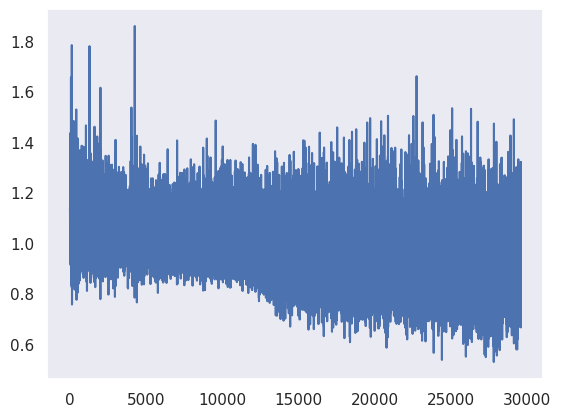

In [46]:
plt.plot(train_losses)

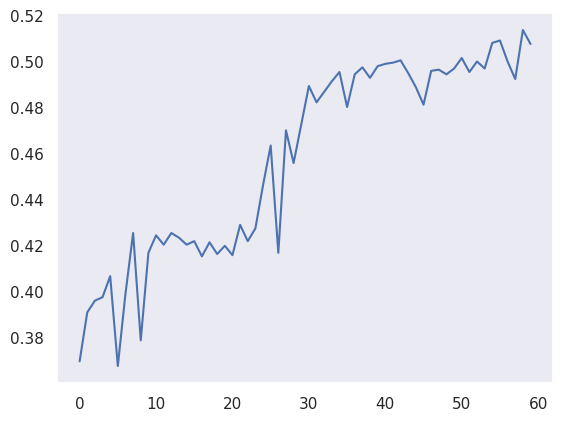

In [47]:
plt.plot(test_accuracy)

In [48]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 1002/1968 (0.5091)
{'acc_detail': tensor([0.5249, 0.6313, 0.3042], device='cuda:0'),
 'acc_unweighted': tensor(0.4868, device='cuda:0'),
 'acc_weighted': tensor(0.5091, device='cuda:0'),
 'f1s': tensor(0.4871, device='cuda:0'),
 'f1s_detail': tensor([0.5371, 0.5617, 0.3624], device='cuda:0'),
 'precision_detail': tensor([0.5498, 0.5060, 0.4482], device='cuda:0'),
 'recall_detail': tensor([0.5249, 0.6313, 0.3042], device='cuda:0'),
 'rocauc': tensor([0.7309, 0.6568, 0.6976], device='cuda:0'),
 'uar': tensor(0.4868, device='cuda:0'),
 'wap': tensor(0.5048, device='cuda:0')}


tensor([[337, 217,  88],
        [186, 505, 109],
        [ 90, 276, 160]], device='cuda:0')

In [49]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_msp3/msp3_m18_best_59epoch.pt
Correct: 1014/1968 (0.5152)
{'acc_detail': tensor([0.5125, 0.6800, 0.2681], device='cuda:0'),
 'acc_unweighted': tensor(0.4868, device='cuda:0'),
 'acc_weighted': tensor(0.5152, device='cuda:0'),
 'f1s': tensor(0.4844, device='cuda:0'),
 'f1s_detail': tensor([0.5363, 0.5856, 0.3314], device='cuda:0'),
 'precision_detail': tensor([0.5624, 0.5142, 0.4338], device='cuda:0'),
 'recall_detail': tensor([0.5125, 0.6800, 0.2681], device='cuda:0'),
 'rocauc': tensor([0.7371, 0.6613, 0.6918], device='cuda:0'),
 'uar': tensor(0.4868, device='cuda:0'),
 'wap': tensor(0.5084, device='cuda:0')}


tensor([[329, 223,  90],
        [162, 544,  94],
        [ 94, 291, 141]], device='cuda:0')

In [50]:
np.save('../models_msp3/msp3_m18_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_msp3/msp3_m18_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [51]:
checkpoint_path = '../models_msp3/msp3_m18_60epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [52]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 240

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                       | 0.0016233766233766235/240 [00:00<15:08:04, 227.02s/it]

Train Epoch: 61 [0/7892 (0%)]	Loss: 0.956474
Mem before-during-after: 45496832 3529333760 52187648


  0%|                         | 0.06655844155844157/240 [00:14<15:46:03, 236.58s/it]

Train Epoch: 61 [640/7892 (8%)]	Loss: 0.656622
Mem before-during-after: 52187648 3536900096 52258304


  0%|                         | 0.13149350649350647/240 [00:28<15:58:28, 239.75s/it]

Train Epoch: 61 [1280/7892 (16%)]	Loss: 1.020357
Mem before-during-after: 52187648 3536900096 52258304


  0%|                         | 0.19642857142857087/240 [00:42<15:46:08, 236.73s/it]

Train Epoch: 61 [1920/7892 (24%)]	Loss: 0.899223
Mem before-during-after: 52187648 3536900096 52258304


  0%|                         | 0.26136363636363547/240 [00:55<15:44:57, 236.50s/it]

Train Epoch: 61 [2560/7892 (32%)]	Loss: 0.913844
Mem before-during-after: 52187648 3536900096 52258304


  0%|                           | 0.326298701298701/240 [01:09<15:44:36, 236.47s/it]

Train Epoch: 61 [3200/7892 (41%)]	Loss: 0.998850
Mem before-during-after: 52187648 3536900096 52258304


  0%|                          | 0.3912337662337665/240 [01:23<15:45:54, 236.86s/it]

Train Epoch: 61 [3840/7892 (49%)]	Loss: 0.733135
Mem before-during-after: 52187648 3536900096 52258304


  0%|                           | 0.456168831168832/240 [01:37<15:44:53, 236.67s/it]

Train Epoch: 61 [4480/7892 (57%)]	Loss: 0.779607
Mem before-during-after: 52187648 3536900096 52258304


  0%|                          | 0.5211038961038975/240 [01:51<15:54:18, 239.10s/it]

Train Epoch: 61 [5120/7892 (65%)]	Loss: 1.010625
Mem before-during-after: 52187648 3536900096 52258304


  0%|                           | 0.586038961038963/240 [02:05<15:52:39, 238.75s/it]

Train Epoch: 61 [5760/7892 (73%)]	Loss: 0.904041
Mem before-during-after: 52187648 3536900096 52258304


  0%|                          | 0.6509740259740285/240 [02:19<15:43:39, 236.55s/it]

Train Epoch: 61 [6400/7892 (81%)]	Loss: 1.011507
Mem before-during-after: 52187648 3536900096 52258304


  0%|                           | 0.715909090909094/240 [02:33<15:43:38, 236.61s/it]

Train Epoch: 61 [7040/7892 (89%)]	Loss: 1.061308
Mem before-during-after: 52187648 3536900096 52258304


  0%|                          | 0.7808441558441596/240 [02:47<15:46:41, 237.44s/it]

Train Epoch: 61 [7680/7892 (97%)]	Loss: 0.997864
Mem before-during-after: 52187648 3536900096 52258304


  0%|                          | 1.0000000000000056/240 [03:19<10:55:18, 164.51s/it]


Test Epoch: 61	Accuracy: 1010/1968 (51%)



  0%|                          | 1.0016233766233822/240 [03:19<11:57:52, 180.22s/it]

Train Epoch: 62 [0/7892 (0%)]	Loss: 0.896290
Mem before-during-after: 52183552 3536801280 52187648


  0%|                          | 1.0665584415584477/240 [03:33<15:46:26, 237.67s/it]

Train Epoch: 62 [640/7892 (8%)]	Loss: 1.036085
Mem before-during-after: 52187648 3536641024 52187648


  0%|                          | 1.1314935064935132/240 [03:47<15:50:43, 238.81s/it]

Train Epoch: 62 [1280/7892 (16%)]	Loss: 0.752087
Mem before-during-after: 52187648 3536641024 52187648


  0%|▏                         | 1.1964285714285787/240 [04:01<15:52:37, 239.35s/it]

Train Epoch: 62 [1920/7892 (24%)]	Loss: 1.004382
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.2613636363636442/240 [04:15<15:45:30, 237.63s/it]

Train Epoch: 62 [2560/7892 (32%)]	Loss: 1.038958
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.3262987012987097/240 [04:29<15:41:06, 236.59s/it]

Train Epoch: 62 [3200/7892 (41%)]	Loss: 0.934216
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.3912337662337753/240 [04:43<15:54:49, 240.10s/it]

Train Epoch: 62 [3840/7892 (49%)]	Loss: 1.108721
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.4561688311688408/240 [04:57<15:59:58, 241.46s/it]

Train Epoch: 62 [4480/7892 (57%)]	Loss: 0.971429
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.5211038961039063/240 [05:11<15:49:24, 238.87s/it]

Train Epoch: 62 [5120/7892 (65%)]	Loss: 0.790684
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.5860389610389718/240 [05:25<15:41:11, 236.86s/it]

Train Epoch: 62 [5760/7892 (73%)]	Loss: 0.961221
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.6509740259740373/240 [05:39<15:42:16, 237.20s/it]

Train Epoch: 62 [6400/7892 (81%)]	Loss: 0.897457
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.7159090909091028/240 [05:53<15:42:51, 237.41s/it]

Train Epoch: 62 [7040/7892 (89%)]	Loss: 0.708610
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 1.7808441558441683/240 [06:07<15:55:02, 240.54s/it]

Train Epoch: 62 [7680/7892 (97%)]	Loss: 0.991076
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                           | 2.000000000000014/240 [06:38<9:07:03, 137.91s/it]


Test Epoch: 62	Accuracy: 1005/1968 (51%)



  1%|▏                         | 2.0016233766233906/240 [06:39<10:54:21, 164.97s/it]

Train Epoch: 63 [0/7892 (0%)]	Loss: 0.754826
Mem before-during-after: 52183552 3536801280 52187648


  1%|▏                         | 2.0665584415584473/240 [06:53<15:54:15, 240.64s/it]

Train Epoch: 63 [640/7892 (8%)]	Loss: 0.965452
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                          | 2.131493506493504/240 [07:07<15:52:45, 240.32s/it]

Train Epoch: 63 [1280/7892 (16%)]	Loss: 0.843970
Mem before-during-after: 52187648 3536641024 52187648


  1%|▏                         | 2.1964285714285605/240 [07:21<15:53:46, 240.65s/it]

Train Epoch: 63 [1920/7892 (24%)]	Loss: 0.993565
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                          | 2.261363636363617/240 [07:35<15:52:45, 240.46s/it]

Train Epoch: 63 [2560/7892 (32%)]	Loss: 0.876111
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 2.3262987012986738/240 [07:49<15:39:41, 237.22s/it]

Train Epoch: 63 [3200/7892 (41%)]	Loss: 1.021271
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 2.3912337662337304/240 [08:03<15:51:33, 240.28s/it]

Train Epoch: 63 [3840/7892 (49%)]	Loss: 0.838935
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                          | 2.456168831168787/240 [08:17<15:41:17, 237.76s/it]

Train Epoch: 63 [4480/7892 (57%)]	Loss: 0.816077
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 2.5211038961038437/240 [08:31<15:40:33, 237.64s/it]

Train Epoch: 63 [5120/7892 (65%)]	Loss: 0.979330
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 2.5860389610389003/240 [08:45<15:36:46, 236.75s/it]

Train Epoch: 63 [5760/7892 (73%)]	Loss: 0.710462
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                          | 2.650974025973957/240 [08:59<15:47:37, 239.55s/it]

Train Epoch: 63 [6400/7892 (81%)]	Loss: 0.909367
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 2.7159090909090136/240 [09:12<15:38:43, 237.37s/it]

Train Epoch: 63 [7040/7892 (89%)]	Loss: 0.939063
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                           | 2.78084415584407/240 [09:26<15:37:48, 237.20s/it]

Train Epoch: 63 [7680/7892 (97%)]	Loss: 0.916746
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                          | 2.9999999999998863/240 [09:58<8:48:56, 133.91s/it]


Test Epoch: 63	Accuracy: 1013/1968 (51%)



  1%|▎                         | 3.0016233766232627/240 [09:58<10:32:21, 160.09s/it]

Train Epoch: 64 [0/7892 (0%)]	Loss: 0.704475
Mem before-during-after: 52183552 3536801280 52187648


  1%|▎                         | 3.0665584415583194/240 [10:12<15:36:29, 237.15s/it]

Train Epoch: 64 [640/7892 (8%)]	Loss: 0.890537
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                          | 3.131493506493376/240 [10:26<15:36:25, 237.20s/it]

Train Epoch: 64 [1280/7892 (16%)]	Loss: 0.730972
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 3.1964285714284326/240 [10:40<15:35:20, 236.99s/it]

Train Epoch: 64 [1920/7892 (24%)]	Loss: 0.923076
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 3.2613636363634892/240 [10:54<15:35:10, 237.02s/it]

Train Epoch: 64 [2560/7892 (32%)]	Loss: 1.364675
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                          | 3.326298701298546/240 [11:08<15:38:46, 237.99s/it]

Train Epoch: 64 [3200/7892 (41%)]	Loss: 0.975912
Mem before-during-after: 52187648 3536641024 52187648


  1%|▎                         | 3.3912337662336025/240 [11:22<15:43:03, 239.14s/it]

Train Epoch: 64 [3840/7892 (49%)]	Loss: 0.771309
Mem before-during-after: 52187648 3536641024 52187648


  1%|▍                          | 3.456168831168659/240 [11:36<15:44:30, 239.58s/it]

Train Epoch: 64 [4480/7892 (57%)]	Loss: 0.936970
Mem before-during-after: 52187648 3536641024 52187648


  1%|▍                         | 3.5211038961037158/240 [11:50<15:35:04, 237.25s/it]

Train Epoch: 64 [5120/7892 (65%)]	Loss: 0.896901
Mem before-during-after: 52187648 3536641024 52187648


  1%|▍                         | 3.5860389610387724/240 [12:04<15:33:17, 236.86s/it]

Train Epoch: 64 [5760/7892 (73%)]	Loss: 0.757478
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 3.650974025973829/240 [12:18<15:36:23, 237.72s/it]

Train Epoch: 64 [6400/7892 (81%)]	Loss: 0.913351
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                         | 3.7159090909088857/240 [12:32<15:34:32, 237.31s/it]

Train Epoch: 64 [7040/7892 (89%)]	Loss: 0.903634
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                         | 3.7808441558439423/240 [12:46<15:35:24, 237.60s/it]

Train Epoch: 64 [7680/7892 (97%)]	Loss: 1.006585
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 3.9999999999997584/240 [13:17<8:49:54, 134.72s/it]


Test Epoch: 64	Accuracy: 1006/1968 (51%)



  2%|▍                          | 4.001623376623135/240 [13:17<10:34:31, 161.32s/it]

Train Epoch: 65 [0/7892 (0%)]	Loss: 0.999370
Mem before-during-after: 52183552 3536801280 52187648


  2%|▍                         | 4.0665584415581915/240 [13:32<15:33:24, 237.37s/it]

Train Epoch: 65 [640/7892 (8%)]	Loss: 0.914292
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 4.131493506493248/240 [13:45<15:34:27, 237.71s/it]

Train Epoch: 65 [1280/7892 (16%)]	Loss: 1.013602
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 4.196428571428305/240 [13:59<15:45:15, 240.52s/it]

Train Epoch: 65 [1920/7892 (24%)]	Loss: 0.943289
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 4.261363636363361/240 [14:13<15:33:58, 237.71s/it]

Train Epoch: 65 [2560/7892 (32%)]	Loss: 0.919222
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 4.326298701298418/240 [14:27<15:34:38, 237.95s/it]

Train Epoch: 65 [3200/7892 (41%)]	Loss: 0.748324
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                          | 4.391233766233475/240 [14:41<15:34:11, 237.90s/it]

Train Epoch: 65 [3840/7892 (49%)]	Loss: 0.848927
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 4.456168831168531/240 [14:55<15:30:38, 237.06s/it]

Train Epoch: 65 [4480/7892 (57%)]	Loss: 0.718852
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 4.521103896103588/240 [15:09<15:46:12, 241.09s/it]

Train Epoch: 65 [5120/7892 (65%)]	Loss: 0.886377
Mem before-during-after: 52187648 3536641024 52187648


  2%|▍                         | 4.5860389610386445/240 [15:23<15:34:25, 238.16s/it]

Train Epoch: 65 [5760/7892 (73%)]	Loss: 0.837669
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 4.650974025973701/240 [15:37<15:37:48, 239.08s/it]

Train Epoch: 65 [6400/7892 (81%)]	Loss: 0.645493
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 4.715909090908758/240 [15:51<15:38:59, 239.45s/it]

Train Epoch: 65 [7040/7892 (89%)]	Loss: 0.973930
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 4.780844155843814/240 [16:05<15:38:34, 239.41s/it]

Train Epoch: 65 [7680/7892 (97%)]	Loss: 0.941653
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 4.9999999999996305/240 [16:36<9:05:12, 139.20s/it]


Test Epoch: 65	Accuracy: 1025/1968 (52%)

saved model: ../models_msp3/msp3_m18_best_65epoch.pt


  2%|▌                          | 5.001623376623007/240 [16:37<10:41:36, 163.82s/it]

Train Epoch: 66 [0/7892 (0%)]	Loss: 0.891986
Mem before-during-after: 52183552 3536801280 52187648


  2%|▌                          | 5.066558441558064/240 [16:51<15:35:40, 238.96s/it]

Train Epoch: 66 [640/7892 (8%)]	Loss: 0.920033
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                           | 5.13149350649312/240 [17:05<15:29:57, 237.57s/it]

Train Epoch: 66 [1280/7892 (16%)]	Loss: 0.836498
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 5.196428571428177/240 [17:19<15:28:23, 237.24s/it]

Train Epoch: 66 [1920/7892 (24%)]	Loss: 0.862830
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                         | 5.2613636363632335/240 [17:33<15:36:05, 239.27s/it]

Train Epoch: 66 [2560/7892 (32%)]	Loss: 1.119472
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                           | 5.32629870129829/240 [17:47<15:45:40, 241.79s/it]

Train Epoch: 66 [3200/7892 (41%)]	Loss: 0.954818
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 5.391233766233347/240 [18:01<15:29:47, 237.79s/it]

Train Epoch: 66 [3840/7892 (49%)]	Loss: 0.977635
Mem before-during-after: 52187648 3536641024 52187648


  2%|▌                          | 5.456168831168403/240 [18:15<15:37:57, 239.94s/it]

Train Epoch: 66 [4480/7892 (57%)]	Loss: 0.943153
Mem before-during-after: 52187648 3536641024 52187648


  2%|▋                           | 5.52110389610346/240 [18:29<15:35:01, 239.26s/it]

Train Epoch: 66 [5120/7892 (65%)]	Loss: 0.766119
Mem before-during-after: 52187648 3536641024 52187648


  2%|▋                          | 5.586038961038517/240 [18:43<15:27:56, 237.51s/it]

Train Epoch: 66 [5760/7892 (73%)]	Loss: 1.276425
Mem before-during-after: 52187648 3536641024 52187648


  2%|▋                          | 5.650974025973573/240 [18:57<15:26:06, 237.11s/it]

Train Epoch: 66 [6400/7892 (81%)]	Loss: 0.983903
Mem before-during-after: 52187648 3536641024 52187648


  2%|▋                           | 5.71590909090863/240 [19:11<15:26:47, 237.35s/it]

Train Epoch: 66 [7040/7892 (89%)]	Loss: 0.630865
Mem before-during-after: 52187648 3536641024 52187648


  2%|▋                         | 5.7808441558436865/240 [19:25<15:26:16, 237.28s/it]

Train Epoch: 66 [7680/7892 (97%)]	Loss: 0.838331
Mem before-during-after: 52187648 3536641024 52187648


  2%|▋                           | 5.999999999999503/240 [19:56<9:03:08, 139.27s/it]


Test Epoch: 66	Accuracy: 998/1968 (51%)



  3%|▋                          | 6.001623376622879/240 [19:56<10:56:48, 168.41s/it]

Train Epoch: 67 [0/7892 (0%)]	Loss: 1.082887
Mem before-during-after: 52183552 3536801280 52187648


  3%|▋                          | 6.066558441557936/240 [20:11<15:25:54, 237.48s/it]

Train Epoch: 67 [640/7892 (8%)]	Loss: 0.900446
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.131493506492992/240 [20:25<15:25:36, 237.47s/it]

Train Epoch: 67 [1280/7892 (16%)]	Loss: 0.910752
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.196428571428049/240 [20:38<15:22:36, 236.76s/it]

Train Epoch: 67 [1920/7892 (24%)]	Loss: 0.897071
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.261363636363106/240 [20:52<15:24:42, 237.37s/it]

Train Epoch: 67 [2560/7892 (32%)]	Loss: 0.733740
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.326298701298162/240 [21:06<15:36:04, 240.36s/it]

Train Epoch: 67 [3200/7892 (41%)]	Loss: 0.944758
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.391233766233219/240 [21:20<15:33:13, 239.69s/it]

Train Epoch: 67 [3840/7892 (49%)]	Loss: 1.012215
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                         | 6.4561688311682754/240 [21:34<15:38:50, 241.20s/it]

Train Epoch: 67 [4480/7892 (57%)]	Loss: 0.978506
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.521103896103332/240 [21:48<15:29:49, 238.95s/it]

Train Epoch: 67 [5120/7892 (65%)]	Loss: 0.704428
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.586038961038389/240 [22:02<15:31:09, 239.36s/it]

Train Epoch: 67 [5760/7892 (73%)]	Loss: 0.943091
Mem before-during-after: 52187648 3536641024 52187648


  3%|▋                          | 6.650974025973445/240 [22:16<15:21:30, 236.95s/it]

Train Epoch: 67 [6400/7892 (81%)]	Loss: 0.703287
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 6.715909090908502/240 [22:30<15:30:20, 239.28s/it]

Train Epoch: 67 [7040/7892 (89%)]	Loss: 0.944025
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 6.780844155843559/240 [22:44<15:20:39, 236.86s/it]

Train Epoch: 67 [7680/7892 (97%)]	Loss: 0.883341
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                           | 6.999999999999375/240 [23:16<8:44:29, 135.06s/it]


Test Epoch: 67	Accuracy: 1025/1968 (52%)



  3%|▊                          | 7.001623376622751/240 [23:16<10:23:54, 160.66s/it]

Train Epoch: 68 [0/7892 (0%)]	Loss: 0.770540
Mem before-during-after: 52183552 3536801280 52187648


  3%|▊                          | 7.066558441557808/240 [23:30<15:36:51, 241.32s/it]

Train Epoch: 68 [640/7892 (8%)]	Loss: 0.731441
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.131493506492864/240 [23:44<15:28:45, 239.30s/it]

Train Epoch: 68 [1280/7892 (16%)]	Loss: 0.830188
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.196428571427921/240 [23:58<15:24:14, 238.20s/it]

Train Epoch: 68 [1920/7892 (24%)]	Loss: 0.831712
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.261363636362978/240 [24:12<15:37:00, 241.56s/it]

Train Epoch: 68 [2560/7892 (32%)]	Loss: 0.805405
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.326298701298034/240 [24:26<15:24:50, 238.49s/it]

Train Epoch: 68 [3200/7892 (41%)]	Loss: 0.899326
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.391233766233091/240 [24:40<15:20:37, 237.47s/it]

Train Epoch: 68 [3840/7892 (49%)]	Loss: 0.898825
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                         | 7.4561688311681475/240 [24:54<15:18:45, 237.06s/it]

Train Epoch: 68 [4480/7892 (57%)]	Loss: 0.881328
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.521103896103204/240 [25:08<15:26:09, 239.03s/it]

Train Epoch: 68 [5120/7892 (65%)]	Loss: 0.989224
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.586038961038261/240 [25:22<15:41:07, 242.96s/it]

Train Epoch: 68 [5760/7892 (73%)]	Loss: 0.878501
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.650974025973317/240 [25:36<15:22:52, 238.32s/it]

Train Epoch: 68 [6400/7892 (81%)]	Loss: 0.721444
Mem before-during-after: 52187648 3536641024 52187648


  3%|▊                          | 7.715909090908374/240 [25:50<15:28:22, 239.80s/it]

Train Epoch: 68 [7040/7892 (89%)]	Loss: 1.146280
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                          | 7.780844155843431/240 [26:04<15:25:37, 239.16s/it]

Train Epoch: 68 [7680/7892 (97%)]	Loss: 0.869388
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                           | 7.999999999999247/240 [26:36<8:33:56, 132.92s/it]


Test Epoch: 68	Accuracy: 1021/1968 (52%)



  3%|▉                          | 8.001623376622623/240 [26:36<10:32:27, 163.57s/it]

Train Epoch: 69 [0/7892 (0%)]	Loss: 1.022560
Mem before-during-after: 52183552 3536801280 52187648


  3%|▉                           | 8.06655844155768/240 [26:50<16:26:08, 255.11s/it]

Train Epoch: 69 [640/7892 (8%)]	Loss: 0.732585
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                          | 8.131493506492737/240 [27:04<15:22:32, 238.72s/it]

Train Epoch: 69 [1280/7892 (16%)]	Loss: 0.911123
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                          | 8.196428571427793/240 [27:18<15:15:17, 236.92s/it]

Train Epoch: 69 [1920/7892 (24%)]	Loss: 0.808737
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                           | 8.26136363636285/240 [27:32<15:29:12, 240.58s/it]

Train Epoch: 69 [2560/7892 (32%)]	Loss: 0.863093
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                          | 8.326298701297906/240 [27:46<15:27:42, 240.26s/it]

Train Epoch: 69 [3200/7892 (41%)]	Loss: 1.103289
Mem before-during-after: 52187648 3536641024 52187648


  3%|▉                          | 8.391233766232963/240 [28:00<15:20:12, 238.39s/it]

Train Epoch: 69 [3840/7892 (49%)]	Loss: 0.809926
Mem before-during-after: 52187648 3536641024 52187648


  4%|▉                           | 8.45616883116802/240 [28:14<15:19:16, 238.21s/it]

Train Epoch: 69 [4480/7892 (57%)]	Loss: 0.856960
Mem before-during-after: 52187648 3536641024 52187648


  4%|▉                          | 8.521103896103076/240 [28:28<15:24:14, 239.57s/it]

Train Epoch: 69 [5120/7892 (65%)]	Loss: 0.651701
Mem before-during-after: 52187648 3536641024 52187648


  4%|▉                          | 8.586038961038133/240 [28:42<15:28:04, 240.63s/it]

Train Epoch: 69 [5760/7892 (73%)]	Loss: 0.958263
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                           | 8.65097402597319/240 [28:56<15:32:09, 241.75s/it]

Train Epoch: 69 [6400/7892 (81%)]	Loss: 0.951270
Mem before-during-after: 52187648 3536641024 52187648


  4%|▉                          | 8.715909090908246/240 [29:10<15:21:26, 239.04s/it]

Train Epoch: 69 [7040/7892 (89%)]	Loss: 0.866748
Mem before-during-after: 52187648 3536641024 52187648


  4%|▉                          | 8.780844155843303/240 [29:24<15:26:49, 240.50s/it]

Train Epoch: 69 [7680/7892 (97%)]	Loss: 0.879805
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                           | 8.999999999999119/240 [29:56<8:53:26, 138.56s/it]


Test Epoch: 69	Accuracy: 996/1968 (50%)



  4%|█                          | 9.001623376622495/240 [29:56<10:34:33, 164.82s/it]

Train Epoch: 70 [0/7892 (0%)]	Loss: 0.805869
Mem before-during-after: 52183552 3536801280 52187648


  4%|█                          | 9.066558441557552/240 [30:10<15:12:37, 237.12s/it]

Train Epoch: 70 [640/7892 (8%)]	Loss: 1.067064
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.131493506492609/240 [30:24<15:24:17, 240.21s/it]

Train Epoch: 70 [1280/7892 (16%)]	Loss: 0.908831
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.196428571427665/240 [30:38<15:16:33, 238.27s/it]

Train Epoch: 70 [1920/7892 (24%)]	Loss: 0.975544
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.261363636362722/240 [30:52<15:42:55, 245.19s/it]

Train Epoch: 70 [2560/7892 (32%)]	Loss: 0.964652
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.326298701297778/240 [31:06<15:23:54, 240.31s/it]

Train Epoch: 70 [3200/7892 (41%)]	Loss: 0.941361
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.391233766232835/240 [31:20<15:19:49, 239.32s/it]

Train Epoch: 70 [3840/7892 (49%)]	Loss: 0.953175
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.456168831167892/240 [31:34<15:24:57, 240.72s/it]

Train Epoch: 70 [4480/7892 (57%)]	Loss: 0.854551
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.521103896102948/240 [31:48<15:14:18, 238.02s/it]

Train Epoch: 70 [5120/7892 (65%)]	Loss: 0.862587
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.586038961038005/240 [32:02<15:25:44, 241.06s/it]

Train Epoch: 70 [5760/7892 (73%)]	Loss: 1.095064
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.650974025973062/240 [32:16<15:19:16, 239.45s/it]

Train Epoch: 70 [6400/7892 (81%)]	Loss: 0.920373
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.715909090908118/240 [32:30<15:15:30, 238.53s/it]

Train Epoch: 70 [7040/7892 (89%)]	Loss: 0.752334
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                          | 9.780844155843175/240 [32:44<15:19:22, 239.61s/it]

Train Epoch: 70 [7680/7892 (97%)]	Loss: 0.798146
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                          | 9.999999999998991/240 [33:16<8:31:16, 133.38s/it]


Test Epoch: 70	Accuracy: 999/1968 (51%)



  4%|█                         | 10.001623376622367/240 [33:16<10:36:03, 165.93s/it]

Train Epoch: 71 [0/7892 (0%)]	Loss: 1.201929
Mem before-during-after: 52183552 3536801280 52187648


  4%|█                         | 10.066558441557424/240 [33:31<15:19:01, 239.82s/it]

Train Epoch: 71 [640/7892 (8%)]	Loss: 0.666895
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                         | 10.13149350649248/240 [33:45<15:19:38, 240.04s/it]

Train Epoch: 71 [1280/7892 (16%)]	Loss: 1.093170
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                         | 10.196428571427537/240 [33:59<15:20:22, 240.30s/it]

Train Epoch: 71 [1920/7892 (24%)]	Loss: 0.921204
Mem before-during-after: 52187648 3536641024 52187648


  4%|█                         | 10.261363636362594/240 [34:13<15:11:35, 238.08s/it]

Train Epoch: 71 [2560/7892 (32%)]	Loss: 1.080601
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                         | 10.32629870129765/240 [34:27<15:18:46, 240.02s/it]

Train Epoch: 71 [3200/7892 (41%)]	Loss: 0.739586
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                        | 10.391233766232707/240 [34:41<15:08:15, 237.34s/it]

Train Epoch: 71 [3840/7892 (49%)]	Loss: 1.104763
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                        | 10.456168831167764/240 [34:55<15:06:05, 236.84s/it]

Train Epoch: 71 [4480/7892 (57%)]	Loss: 0.845714
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                         | 10.52110389610282/240 [35:09<15:05:03, 236.64s/it]

Train Epoch: 71 [5120/7892 (65%)]	Loss: 0.972807
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                        | 10.586038961037877/240 [35:22<15:34:40, 244.45s/it]

Train Epoch: 71 [5760/7892 (73%)]	Loss: 1.111622
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                        | 10.650974025972934/240 [35:36<15:10:30, 238.20s/it]

Train Epoch: 71 [6400/7892 (81%)]	Loss: 1.120989
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                         | 10.71590909090799/240 [35:50<15:14:49, 239.39s/it]

Train Epoch: 71 [7040/7892 (89%)]	Loss: 1.060773
Mem before-during-after: 52187648 3536641024 52187648


  4%|█▏                        | 10.780844155843047/240 [36:04<15:12:53, 238.96s/it]

Train Epoch: 71 [7680/7892 (97%)]	Loss: 0.754325
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▏                         | 10.999999999998863/240 [36:36<8:32:24, 134.26s/it]


Test Epoch: 71	Accuracy: 1019/1968 (52%)



  5%|█▏                         | 11.00162337662224/240 [36:36<10:15:30, 161.27s/it]

Train Epoch: 72 [0/7892 (0%)]	Loss: 0.969297
Mem before-during-after: 52183552 3536801280 52187648


  5%|█▏                        | 11.066558441557296/240 [36:50<15:04:37, 237.09s/it]

Train Epoch: 72 [640/7892 (8%)]	Loss: 0.858651
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▏                        | 11.131493506492353/240 [37:04<15:03:03, 236.75s/it]

Train Epoch: 72 [1280/7892 (16%)]	Loss: 0.809801
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                         | 11.19642857142741/240 [37:18<15:09:17, 238.45s/it]

Train Epoch: 72 [1920/7892 (24%)]	Loss: 0.770203
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▏                        | 11.261363636362466/240 [37:32<15:14:54, 239.99s/it]

Train Epoch: 72 [2560/7892 (32%)]	Loss: 1.090758
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▏                        | 11.326298701297523/240 [37:46<15:15:07, 240.11s/it]

Train Epoch: 72 [3200/7892 (41%)]	Loss: 0.834144
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                         | 11.39123376623258/240 [38:00<15:07:16, 238.12s/it]

Train Epoch: 72 [3840/7892 (49%)]	Loss: 0.923477
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▏                        | 11.456168831167636/240 [38:14<15:07:59, 238.38s/it]

Train Epoch: 72 [4480/7892 (57%)]	Loss: 1.040148
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▏                        | 11.521103896102693/240 [38:28<15:07:11, 238.24s/it]

Train Epoch: 72 [5120/7892 (65%)]	Loss: 0.919425
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                         | 11.58603896103775/240 [38:42<15:04:17, 237.54s/it]

Train Epoch: 72 [5760/7892 (73%)]	Loss: 0.708165
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 11.650974025972806/240 [38:56<15:14:04, 240.18s/it]

Train Epoch: 72 [6400/7892 (81%)]	Loss: 0.751847
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 11.715909090907862/240 [39:10<15:10:12, 239.23s/it]

Train Epoch: 72 [7040/7892 (89%)]	Loss: 1.064409
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 11.780844155842919/240 [39:24<15:14:48, 240.51s/it]

Train Epoch: 72 [7680/7892 (97%)]	Loss: 0.684081
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                         | 11.999999999998735/240 [39:56<8:30:30, 134.35s/it]


Test Epoch: 72	Accuracy: 1025/1968 (52%)



  5%|█▎                        | 12.001623376622112/240 [39:56<10:04:24, 159.05s/it]

Train Epoch: 73 [0/7892 (0%)]	Loss: 0.827780
Mem before-during-after: 52183552 3536801280 52187648


  5%|█▎                        | 12.066558441557168/240 [40:10<14:59:41, 236.83s/it]

Train Epoch: 73 [640/7892 (8%)]	Loss: 0.800464
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.131493506492225/240 [40:24<15:00:45, 237.18s/it]

Train Epoch: 73 [1280/7892 (16%)]	Loss: 0.769023
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.196428571427282/240 [40:38<15:02:06, 237.60s/it]

Train Epoch: 73 [1920/7892 (24%)]	Loss: 0.845247
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.261363636362338/240 [40:52<15:02:10, 237.69s/it]

Train Epoch: 73 [2560/7892 (32%)]	Loss: 0.879486
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.326298701297395/240 [41:06<14:58:35, 236.81s/it]

Train Epoch: 73 [3200/7892 (41%)]	Loss: 0.948881
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.391233766232451/240 [41:20<15:00:29, 237.38s/it]

Train Epoch: 73 [3840/7892 (49%)]	Loss: 0.996147
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.456168831167508/240 [41:34<14:59:41, 237.24s/it]

Train Epoch: 73 [4480/7892 (57%)]	Loss: 1.014511
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.521103896102565/240 [41:48<15:00:42, 237.57s/it]

Train Epoch: 73 [5120/7892 (65%)]	Loss: 1.117663
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.586038961037621/240 [42:02<15:00:43, 237.64s/it]

Train Epoch: 73 [5760/7892 (73%)]	Loss: 0.644469
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▎                        | 12.650974025972678/240 [42:16<14:58:30, 237.13s/it]

Train Epoch: 73 [6400/7892 (81%)]	Loss: 0.764144
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▍                        | 12.715909090907735/240 [42:30<14:57:56, 237.04s/it]

Train Epoch: 73 [7040/7892 (89%)]	Loss: 0.834226
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▍                        | 12.780844155842791/240 [42:44<15:13:41, 241.27s/it]

Train Epoch: 73 [7680/7892 (97%)]	Loss: 1.046561
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▍                         | 12.999999999998607/240 [43:15<8:29:22, 134.63s/it]


Test Epoch: 73	Accuracy: 1008/1968 (51%)



  5%|█▍                        | 13.001623376621984/240 [43:16<10:10:40, 161.41s/it]

Train Epoch: 74 [0/7892 (0%)]	Loss: 0.719286
Mem before-during-after: 52183552 3536801280 52187648


  5%|█▍                         | 13.06655844155704/240 [43:30<14:56:03, 236.91s/it]

Train Epoch: 74 [640/7892 (8%)]	Loss: 1.014016
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▍                        | 13.131493506492097/240 [43:44<15:09:05, 240.43s/it]

Train Epoch: 74 [1280/7892 (16%)]	Loss: 0.705700
Mem before-during-after: 52187648 3536641024 52187648


  5%|█▍                        | 13.196428571427154/240 [43:58<15:06:33, 239.83s/it]

Train Epoch: 74 [1920/7892 (24%)]	Loss: 0.862354
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                         | 13.26136363636221/240 [44:12<15:01:25, 238.54s/it]

Train Epoch: 74 [2560/7892 (32%)]	Loss: 0.910005
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                        | 13.326298701297267/240 [44:26<15:09:30, 240.75s/it]

Train Epoch: 74 [3200/7892 (41%)]	Loss: 1.009212
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                        | 13.391233766232324/240 [44:40<15:05:23, 239.72s/it]

Train Epoch: 74 [3840/7892 (49%)]	Loss: 0.951407
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▌                         | 13.45616883116738/240 [44:54<15:11:47, 241.49s/it]

Train Epoch: 74 [4480/7892 (57%)]	Loss: 0.981787
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                        | 13.521103896102437/240 [45:08<15:01:02, 238.71s/it]

Train Epoch: 74 [5120/7892 (65%)]	Loss: 0.788682
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                        | 13.586038961037493/240 [45:22<15:06:46, 240.30s/it]

Train Epoch: 74 [5760/7892 (73%)]	Loss: 0.826669
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▌                         | 13.65097402597255/240 [45:36<15:28:49, 246.21s/it]

Train Epoch: 74 [6400/7892 (81%)]	Loss: 1.271518
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                        | 13.715909090907607/240 [45:50<15:07:35, 240.65s/it]

Train Epoch: 74 [7040/7892 (89%)]	Loss: 0.871473
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▍                        | 13.780844155842663/240 [46:04<15:02:49, 239.46s/it]

Train Epoch: 74 [7680/7892 (97%)]	Loss: 0.875584
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                          | 13.99999999999848/240 [46:36<8:38:16, 137.60s/it]


Test Epoch: 74	Accuracy: 995/1968 (50%)



  6%|█▌                        | 14.001623376621856/240 [46:36<10:16:57, 163.80s/it]

Train Epoch: 75 [0/7892 (0%)]	Loss: 0.719140
Mem before-during-after: 52183552 3536801280 52187648


  6%|█▌                        | 14.066558441556912/240 [46:50<15:04:19, 240.16s/it]

Train Epoch: 75 [640/7892 (8%)]	Loss: 0.964558
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▌                         | 14.13149350649197/240 [47:04<14:52:08, 236.99s/it]

Train Epoch: 75 [1280/7892 (16%)]	Loss: 0.689608
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▌                        | 14.196428571427026/240 [47:18<14:53:41, 237.47s/it]

Train Epoch: 75 [1920/7892 (24%)]	Loss: 0.810491
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▌                        | 14.261363636362082/240 [47:32<14:58:57, 238.94s/it]

Train Epoch: 75 [2560/7892 (32%)]	Loss: 0.818940
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.326298701297139/240 [47:46<15:03:33, 240.23s/it]

Train Epoch: 75 [3200/7892 (41%)]	Loss: 0.933695
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.391233766232196/240 [48:00<14:53:33, 237.64s/it]

Train Epoch: 75 [3840/7892 (49%)]	Loss: 1.019847
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.456168831167252/240 [48:14<14:50:24, 236.87s/it]

Train Epoch: 75 [4480/7892 (57%)]	Loss: 0.915022
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.521103896102309/240 [48:28<14:59:44, 239.42s/it]

Train Epoch: 75 [5120/7892 (65%)]	Loss: 0.951351
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.586038961037366/240 [48:42<14:53:20, 237.78s/it]

Train Epoch: 75 [5760/7892 (73%)]	Loss: 0.844871
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.650974025972422/240 [48:56<14:54:25, 238.15s/it]

Train Epoch: 75 [6400/7892 (81%)]	Loss: 1.293694
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.715909090907479/240 [49:10<14:54:10, 238.15s/it]

Train Epoch: 75 [7040/7892 (89%)]	Loss: 0.796297
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▌                        | 14.780844155842535/240 [49:24<14:53:50, 238.13s/it]

Train Epoch: 75 [7680/7892 (97%)]	Loss: 0.727437
Mem before-during-after: 52258304 3536758784 52187648


  6%|█▋                         | 14.999999999998352/240 [49:56<8:31:28, 136.40s/it]


Test Epoch: 75	Accuracy: 1005/1968 (51%)



  6%|█▋                        | 15.001623376621728/240 [49:56<10:12:07, 163.23s/it]

Train Epoch: 76 [0/7892 (0%)]	Loss: 1.014656
Mem before-during-after: 52183552 3536801280 52187648


  6%|█▋                        | 15.066558441556785/240 [50:10<14:49:29, 237.27s/it]

Train Epoch: 76 [640/7892 (8%)]	Loss: 0.764186
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.131493506491841/240 [50:24<14:56:36, 239.24s/it]

Train Epoch: 76 [1280/7892 (16%)]	Loss: 1.078219
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.196428571426898/240 [50:38<14:48:59, 237.27s/it]

Train Epoch: 76 [1920/7892 (24%)]	Loss: 0.777409
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.261363636361954/240 [50:52<14:47:09, 236.85s/it]

Train Epoch: 76 [2560/7892 (32%)]	Loss: 0.793354
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.326298701297011/240 [51:06<15:15:47, 244.56s/it]

Train Epoch: 76 [3200/7892 (41%)]	Loss: 0.863658
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.391233766232068/240 [51:20<14:55:56, 239.33s/it]

Train Epoch: 76 [3840/7892 (49%)]	Loss: 0.950850
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.456168831167124/240 [51:34<14:47:26, 237.13s/it]

Train Epoch: 76 [4480/7892 (57%)]	Loss: 0.749765
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.521103896102181/240 [51:48<14:47:09, 237.13s/it]

Train Epoch: 76 [5120/7892 (65%)]	Loss: 0.964778
Mem before-during-after: 52187648 3536641024 52187648


  6%|█▋                        | 15.586038961037238/240 [52:01<14:54:16, 239.09s/it]

Train Epoch: 76 [5760/7892 (73%)]	Loss: 0.900067
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▋                        | 15.650974025972294/240 [52:15<14:49:09, 237.80s/it]

Train Epoch: 76 [6400/7892 (81%)]	Loss: 0.851110
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                         | 15.71590909090735/240 [52:29<14:44:45, 236.69s/it]

Train Epoch: 76 [7040/7892 (89%)]	Loss: 0.859722
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▋                        | 15.780844155842408/240 [52:43<14:53:59, 239.23s/it]

Train Epoch: 76 [7680/7892 (97%)]	Loss: 0.842230
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                         | 15.999999999998224/240 [53:15<8:29:06, 136.37s/it]


Test Epoch: 76	Accuracy: 1006/1968 (51%)



  7%|█▋                        | 16.001623376621602/240 [53:15<10:01:00, 160.99s/it]

Train Epoch: 77 [0/7892 (0%)]	Loss: 0.688840
Mem before-during-after: 52183552 3536801280 52187648


  7%|█▊                         | 16.06655844155673/240 [53:29<14:55:27, 239.93s/it]

Train Epoch: 77 [640/7892 (8%)]	Loss: 1.012747
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▋                        | 16.131493506491857/240 [53:43<14:58:37, 240.84s/it]

Train Epoch: 77 [1280/7892 (16%)]	Loss: 0.971815
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.196428571426985/240 [53:57<14:56:14, 240.28s/it]

Train Epoch: 77 [1920/7892 (24%)]	Loss: 0.809110
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.261363636362113/240 [54:11<14:55:31, 240.15s/it]

Train Epoch: 77 [2560/7892 (32%)]	Loss: 1.007278
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                         | 16.32629870129724/240 [54:25<14:42:12, 236.65s/it]

Train Epoch: 77 [3200/7892 (41%)]	Loss: 1.088247
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.391233766232368/240 [54:39<14:49:40, 238.72s/it]

Train Epoch: 77 [3840/7892 (49%)]	Loss: 0.676602
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.456168831167496/240 [54:53<14:44:07, 237.30s/it]

Train Epoch: 77 [4480/7892 (57%)]	Loss: 0.836200
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.521103896102623/240 [55:07<14:46:08, 237.91s/it]

Train Epoch: 77 [5120/7892 (65%)]	Loss: 0.839050
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                         | 16.58603896103775/240 [55:21<14:41:30, 236.74s/it]

Train Epoch: 77 [5760/7892 (73%)]	Loss: 1.051377
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                         | 16.65097402597288/240 [55:35<14:43:15, 237.28s/it]

Train Epoch: 77 [6400/7892 (81%)]	Loss: 0.917407
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.715909090908006/240 [55:48<14:42:57, 237.26s/it]

Train Epoch: 77 [7040/7892 (89%)]	Loss: 0.895633
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 16.780844155843134/240 [56:02<14:42:06, 237.11s/it]

Train Epoch: 77 [7680/7892 (97%)]	Loss: 0.834219
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                          | 16.99999999999919/240 [56:34<8:59:29, 145.15s/it]


Test Epoch: 77	Accuracy: 1022/1968 (52%)



  7%|█▊                        | 17.001623376622568/240 [56:34<10:22:18, 167.44s/it]

Train Epoch: 78 [0/7892 (0%)]	Loss: 1.011125
Mem before-during-after: 52183552 3536801280 52187648


  7%|█▊                        | 17.066558441557696/240 [56:49<14:54:37, 240.78s/it]

Train Epoch: 78 [640/7892 (8%)]	Loss: 0.686805
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▊                        | 17.131493506492824/240 [57:03<14:40:36, 237.08s/it]

Train Epoch: 78 [1280/7892 (16%)]	Loss: 1.104497
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                         | 17.19642857142795/240 [57:17<14:42:45, 237.72s/it]

Train Epoch: 78 [1920/7892 (24%)]	Loss: 0.922280
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                         | 17.26136363636308/240 [57:31<14:40:31, 237.19s/it]

Train Epoch: 78 [2560/7892 (32%)]	Loss: 0.819280
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                        | 17.326298701298207/240 [57:45<14:40:55, 237.37s/it]

Train Epoch: 78 [3200/7892 (41%)]	Loss: 0.799566
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                        | 17.391233766233334/240 [57:59<14:50:51, 240.12s/it]

Train Epoch: 78 [3840/7892 (49%)]	Loss: 0.810656
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                        | 17.456168831168462/240 [58:13<14:42:34, 237.95s/it]

Train Epoch: 78 [4480/7892 (57%)]	Loss: 1.113231
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                         | 17.52110389610359/240 [58:27<14:38:24, 236.90s/it]

Train Epoch: 78 [5120/7892 (65%)]	Loss: 0.867661
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                        | 17.586038961038717/240 [58:40<14:38:34, 237.01s/it]

Train Epoch: 78 [5760/7892 (73%)]	Loss: 0.698050
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                        | 17.650974025973845/240 [58:54<15:02:45, 243.61s/it]

Train Epoch: 78 [6400/7892 (81%)]	Loss: 0.966000
Mem before-during-after: 52187648 3536641024 52187648


  7%|█▉                        | 17.715909090908973/240 [59:08<14:46:33, 239.31s/it]

Train Epoch: 78 [7040/7892 (89%)]	Loss: 0.583894
Mem before-during-after: 52187648 3536641024 52187648


  7%|██                          | 17.7808441558441/240 [59:22<14:51:02, 240.59s/it]

Train Epoch: 78 [7680/7892 (97%)]	Loss: 0.709443
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                         | 18.000000000000156/240 [59:54<8:19:26, 134.98s/it]


Test Epoch: 78	Accuracy: 1018/1968 (52%)



  8%|██                         | 18.001623376623535/240 [59:54<9:48:44, 159.12s/it]

Train Epoch: 79 [0/7892 (0%)]	Loss: 0.492622
Mem before-during-after: 52183552 3536801280 52187648


  8%|█▊                      | 18.066558441558662/240 [1:00:08<14:39:15, 237.71s/it]

Train Epoch: 79 [640/7892 (8%)]	Loss: 0.706255
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                       | 18.13149350649379/240 [1:00:22<14:35:53, 236.87s/it]

Train Epoch: 79 [1280/7892 (16%)]	Loss: 0.920782
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▊                      | 18.196428571428918/240 [1:00:36<14:43:05, 238.89s/it]

Train Epoch: 79 [1920/7892 (24%)]	Loss: 1.175038
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▊                      | 18.261363636364045/240 [1:00:50<14:42:06, 238.69s/it]

Train Epoch: 79 [2560/7892 (32%)]	Loss: 0.716181
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▊                      | 18.326298701299173/240 [1:01:04<14:39:14, 237.98s/it]

Train Epoch: 79 [3200/7892 (41%)]	Loss: 1.136856
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                        | 18.3912337662343/240 [1:01:18<14:38:10, 237.76s/it]

Train Epoch: 79 [3840/7892 (49%)]	Loss: 1.066050
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                       | 18.45616883116943/240 [1:01:32<14:37:53, 237.76s/it]

Train Epoch: 79 [4480/7892 (57%)]	Loss: 0.836335
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▊                      | 18.521103896104556/240 [1:01:46<14:39:42, 238.32s/it]

Train Epoch: 79 [5120/7892 (65%)]	Loss: 0.922305
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▊                      | 18.586038961039684/240 [1:02:00<14:42:22, 239.11s/it]

Train Epoch: 79 [5760/7892 (73%)]	Loss: 0.795102
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                       | 18.65097402597481/240 [1:02:14<14:39:18, 238.35s/it]

Train Epoch: 79 [6400/7892 (81%)]	Loss: 1.217098
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                       | 18.71590909090994/240 [1:02:28<14:35:21, 237.35s/it]

Train Epoch: 79 [7040/7892 (89%)]	Loss: 0.737888
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 18.780844155845067/240 [1:02:42<14:34:18, 237.13s/it]

Train Epoch: 79 [7680/7892 (97%)]	Loss: 0.756171
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                       | 19.000000000001123/240 [1:03:13<8:16:19, 134.75s/it]


Test Epoch: 79	Accuracy: 1004/1968 (51%)



  8%|██▏                        | 19.0016233766245/240 [1:03:14<9:51:41, 160.64s/it]

Train Epoch: 80 [0/7892 (0%)]	Loss: 0.708148
Mem before-during-after: 52183552 3536801280 52187648


  8%|█▉                       | 19.06655844155963/240 [1:03:28<14:42:41, 239.72s/it]

Train Epoch: 80 [640/7892 (8%)]	Loss: 0.998545
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.131493506494756/240 [1:03:42<14:38:11, 238.57s/it]

Train Epoch: 80 [1280/7892 (16%)]	Loss: 0.782076
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.196428571429884/240 [1:03:56<14:43:47, 240.15s/it]

Train Epoch: 80 [1920/7892 (24%)]	Loss: 0.768564
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                       | 19.26136363636501/240 [1:04:10<14:44:04, 240.30s/it]

Train Epoch: 80 [2560/7892 (32%)]	Loss: 0.918929
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                       | 19.32629870130014/240 [1:04:24<14:35:20, 238.00s/it]

Train Epoch: 80 [3200/7892 (41%)]	Loss: 0.821991
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.391233766235267/240 [1:04:38<14:38:13, 238.86s/it]

Train Epoch: 80 [3840/7892 (49%)]	Loss: 0.867056
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.456168831170395/240 [1:04:52<14:39:24, 239.25s/it]

Train Epoch: 80 [4480/7892 (57%)]	Loss: 1.124460
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.521103896105522/240 [1:05:06<14:35:07, 238.15s/it]

Train Epoch: 80 [5120/7892 (65%)]	Loss: 1.148555
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                       | 19.58603896104065/240 [1:05:20<14:34:08, 237.96s/it]

Train Epoch: 80 [5760/7892 (73%)]	Loss: 0.706139
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.650974025975778/240 [1:05:34<14:31:10, 237.22s/it]

Train Epoch: 80 [6400/7892 (81%)]	Loss: 0.932680
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.715909090910905/240 [1:05:48<14:44:08, 240.82s/it]

Train Epoch: 80 [7040/7892 (89%)]	Loss: 0.874269
Mem before-during-after: 52187648 3536641024 52187648


  8%|█▉                      | 19.780844155846033/240 [1:06:02<14:37:09, 238.99s/it]

Train Epoch: 80 [7680/7892 (97%)]	Loss: 0.907371
Mem before-during-after: 52187648 3536641024 52187648


  8%|██▏                       | 20.00000000000209/240 [1:06:33<8:20:41, 136.55s/it]


Test Epoch: 80	Accuracy: 1027/1968 (52%)

saved model: ../models_msp3/msp3_m18_best_80epoch.pt


  8%|██                       | 20.001623376625467/240 [1:06:34<9:51:22, 161.28s/it]

Train Epoch: 81 [0/7892 (0%)]	Loss: 0.725744
Mem before-during-after: 52183552 3536801280 52187648


  8%|██                      | 20.066558441560595/240 [1:06:48<14:38:38, 239.70s/it]

Train Epoch: 81 [640/7892 (8%)]	Loss: 0.928544
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                      | 20.131493506495723/240 [1:07:02<14:38:49, 239.82s/it]

Train Epoch: 81 [1280/7892 (16%)]	Loss: 0.728806
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                       | 20.19642857143085/240 [1:07:16<14:35:26, 238.97s/it]

Train Epoch: 81 [1920/7892 (24%)]	Loss: 0.630532
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                      | 20.261363636365978/240 [1:07:30<14:35:12, 238.98s/it]

Train Epoch: 81 [2560/7892 (32%)]	Loss: 0.785211
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                      | 20.326298701301106/240 [1:07:44<14:29:31, 237.49s/it]

Train Epoch: 81 [3200/7892 (41%)]	Loss: 0.656493
Mem before-during-after: 52187648 3536641024 52187648


  8%|██                      | 20.391233766236233/240 [1:07:58<14:35:00, 239.06s/it]

Train Epoch: 81 [3840/7892 (49%)]	Loss: 0.856820
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                      | 20.45616883117136/240 [1:08:12<14:25:58, 236.67s/it]

Train Epoch: 81 [4480/7892 (57%)]	Loss: 0.850153
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                      | 20.52110389610649/240 [1:08:26<14:32:21, 238.48s/it]

Train Epoch: 81 [5120/7892 (65%)]	Loss: 0.730516
Mem before-during-after: 52187648 3536641024 52187648


  9%|██                      | 20.586038961041616/240 [1:08:40<14:28:38, 237.54s/it]

Train Epoch: 81 [5760/7892 (73%)]	Loss: 0.789366
Mem before-during-after: 52187648 3536641024 52187648


  9%|██                      | 20.650974025976744/240 [1:08:54<14:35:22, 239.45s/it]

Train Epoch: 81 [6400/7892 (81%)]	Loss: 0.883591
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                      | 20.71590909091187/240 [1:09:08<14:43:06, 241.63s/it]

Train Epoch: 81 [7040/7892 (89%)]	Loss: 0.865246
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                        | 20.780844155847/240 [1:09:22<14:27:22, 237.40s/it]

Train Epoch: 81 [7680/7892 (97%)]	Loss: 1.141429
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                      | 21.000000000003055/240 [1:09:53<8:07:59, 133.69s/it]


Test Epoch: 81	Accuracy: 1009/1968 (51%)



  9%|██▏                      | 21.001623376626434/240 [1:09:54<9:44:09, 160.05s/it]

Train Epoch: 82 [0/7892 (0%)]	Loss: 0.767986
Mem before-during-after: 52183552 3536801280 52187648


  9%|██▏                      | 21.06655844156156/240 [1:10:08<14:28:20, 237.97s/it]

Train Epoch: 82 [640/7892 (8%)]	Loss: 0.793810
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                      | 21.13149350649669/240 [1:10:22<14:31:41, 238.97s/it]

Train Epoch: 82 [1280/7892 (16%)]	Loss: 0.634620
Mem before-during-after: 52187648 3536641024 52187648


  9%|██                      | 21.196428571431817/240 [1:10:36<14:33:29, 239.53s/it]

Train Epoch: 82 [1920/7892 (24%)]	Loss: 1.385892
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.261363636366944/240 [1:10:50<14:28:37, 238.27s/it]

Train Epoch: 82 [2560/7892 (32%)]	Loss: 0.904232
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.326298701302072/240 [1:11:04<14:27:57, 238.15s/it]

Train Epoch: 82 [3200/7892 (41%)]	Loss: 0.736387
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                       | 21.3912337662372/240 [1:11:18<14:24:20, 237.23s/it]

Train Epoch: 82 [3840/7892 (49%)]	Loss: 0.707040
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.456168831172327/240 [1:11:32<14:24:18, 237.29s/it]

Train Epoch: 82 [4480/7892 (57%)]	Loss: 0.957160
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.521103896107455/240 [1:11:46<14:31:59, 239.47s/it]

Train Epoch: 82 [5120/7892 (65%)]	Loss: 0.672588
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.586038961042583/240 [1:12:00<14:36:40, 240.83s/it]

Train Epoch: 82 [5760/7892 (73%)]	Loss: 0.995408
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                      | 21.65097402597771/240 [1:12:14<14:25:20, 237.79s/it]

Train Epoch: 82 [6400/7892 (81%)]	Loss: 0.896628
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.715909090912838/240 [1:12:28<14:36:56, 241.05s/it]

Train Epoch: 82 [7040/7892 (89%)]	Loss: 0.965428
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 21.780844155847966/240 [1:12:42<14:23:06, 237.31s/it]

Train Epoch: 82 [7680/7892 (97%)]	Loss: 0.983025
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▍                       | 22.00000000000402/240 [1:13:13<8:21:01, 137.89s/it]


Test Epoch: 82	Accuracy: 1011/1968 (51%)



  9%|██▍                        | 22.0016233766274/240 [1:13:13<9:46:15, 161.36s/it]

Train Epoch: 83 [0/7892 (0%)]	Loss: 0.947748
Mem before-during-after: 52183552 3536801280 52187648


  9%|██▏                     | 22.066558441562528/240 [1:13:28<14:25:50, 238.38s/it]

Train Epoch: 83 [640/7892 (8%)]	Loss: 0.947827
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 22.131493506497655/240 [1:13:42<14:19:20, 236.66s/it]

Train Epoch: 83 [1280/7892 (16%)]	Loss: 0.702284
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 22.196428571432783/240 [1:13:56<14:25:13, 238.35s/it]

Train Epoch: 83 [1920/7892 (24%)]	Loss: 1.002341
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                      | 22.26136363636791/240 [1:14:10<14:23:38, 237.98s/it]

Train Epoch: 83 [2560/7892 (32%)]	Loss: 0.958595
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                      | 22.32629870130304/240 [1:14:23<14:26:46, 238.92s/it]

Train Epoch: 83 [3200/7892 (41%)]	Loss: 1.000949
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 22.391233766238166/240 [1:14:38<14:32:04, 240.45s/it]

Train Epoch: 83 [3840/7892 (49%)]	Loss: 0.787934
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▏                     | 22.456168831173294/240 [1:14:52<14:32:06, 240.53s/it]

Train Epoch: 83 [4480/7892 (57%)]	Loss: 1.176202
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                      | 22.52110389610842/240 [1:15:06<14:32:21, 240.67s/it]

Train Epoch: 83 [5120/7892 (65%)]	Loss: 0.572004
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                      | 22.58603896104355/240 [1:15:20<14:21:06, 237.64s/it]

Train Epoch: 83 [5760/7892 (73%)]	Loss: 0.724421
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                     | 22.650974025978677/240 [1:15:34<14:26:44, 239.27s/it]

Train Epoch: 83 [6400/7892 (81%)]	Loss: 0.592699
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                     | 22.715909090913804/240 [1:15:48<14:28:40, 239.87s/it]

Train Epoch: 83 [7040/7892 (89%)]	Loss: 0.856876
Mem before-during-after: 52187648 3536641024 52187648


  9%|██▎                     | 22.780844155848932/240 [1:16:02<14:20:23, 237.65s/it]

Train Epoch: 83 [7680/7892 (97%)]	Loss: 0.902489
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                      | 23.000000000004988/240 [1:16:33<8:41:45, 144.26s/it]


Test Epoch: 83	Accuracy: 1002/1968 (51%)



 10%|██▎                     | 23.001623376628366/240 [1:16:34<10:03:20, 166.82s/it]

Train Epoch: 84 [0/7892 (0%)]	Loss: 0.746922
Mem before-during-after: 52183552 3536801280 52187648


 10%|██▎                     | 23.066558441563494/240 [1:16:48<14:37:16, 242.64s/it]

Train Epoch: 84 [640/7892 (8%)]	Loss: 1.221990
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                      | 23.13149350649862/240 [1:17:02<14:26:35, 239.76s/it]

Train Epoch: 84 [1280/7892 (16%)]	Loss: 0.930730
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                      | 23.19642857143375/240 [1:17:16<14:32:35, 241.49s/it]

Train Epoch: 84 [1920/7892 (24%)]	Loss: 0.916412
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▎                     | 23.261363636368877/240 [1:17:30<14:29:35, 240.73s/it]

Train Epoch: 84 [2560/7892 (32%)]	Loss: 0.696159
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▎                     | 23.326298701304005/240 [1:17:44<14:22:42, 238.90s/it]

Train Epoch: 84 [3200/7892 (41%)]	Loss: 0.895445
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▎                     | 23.391233766239132/240 [1:17:58<14:16:20, 237.20s/it]

Train Epoch: 84 [3840/7892 (49%)]	Loss: 0.762696
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                      | 23.45616883117426/240 [1:18:12<14:19:04, 238.03s/it]

Train Epoch: 84 [4480/7892 (57%)]	Loss: 0.729348
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▎                     | 23.521103896109388/240 [1:18:26<14:16:13, 237.31s/it]

Train Epoch: 84 [5120/7892 (65%)]	Loss: 1.008533
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▎                     | 23.586038961044515/240 [1:18:40<14:25:59, 240.09s/it]

Train Epoch: 84 [5760/7892 (73%)]	Loss: 0.831852
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▎                     | 23.650974025979643/240 [1:18:54<14:18:45, 238.16s/it]

Train Epoch: 84 [6400/7892 (81%)]	Loss: 0.839777
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                      | 23.71590909091477/240 [1:19:08<14:27:27, 240.65s/it]

Train Epoch: 84 [7040/7892 (89%)]	Loss: 0.957714
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                       | 23.7808441558499/240 [1:19:21<14:14:57, 237.25s/it]

Train Epoch: 84 [7680/7892 (97%)]	Loss: 0.911360
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                      | 24.000000000005954/240 [1:19:53<8:08:02, 135.57s/it]


Test Epoch: 84	Accuracy: 1028/1968 (52%)

saved model: ../models_msp3/msp3_m18_best_84epoch.pt


 10%|██▌                      | 24.001623376629333/240 [1:19:53<9:42:32, 161.82s/it]

Train Epoch: 85 [0/7892 (0%)]	Loss: 0.787820
Mem before-during-after: 52183552 3536801280 52187648


 10%|██▌                      | 24.06655844156446/240 [1:20:08<14:15:20, 237.67s/it]

Train Epoch: 85 [640/7892 (8%)]	Loss: 0.793636
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.131493506499588/240 [1:20:22<14:25:24, 240.54s/it]

Train Epoch: 85 [1280/7892 (16%)]	Loss: 0.871822
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.196428571434716/240 [1:20:36<14:34:53, 243.25s/it]

Train Epoch: 85 [1920/7892 (24%)]	Loss: 1.024859
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.261363636369843/240 [1:20:50<14:21:04, 239.48s/it]

Train Epoch: 85 [2560/7892 (32%)]	Loss: 0.905805
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                      | 24.32629870130497/240 [1:21:03<14:10:47, 236.69s/it]

Train Epoch: 85 [3200/7892 (41%)]	Loss: 0.695605
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▋                       | 24.3912337662401/240 [1:21:17<14:20:56, 239.59s/it]

Train Epoch: 85 [3840/7892 (49%)]	Loss: 0.644040
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.456168831175226/240 [1:21:32<14:17:17, 238.64s/it]

Train Epoch: 85 [4480/7892 (57%)]	Loss: 0.770663
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.521103896110354/240 [1:21:46<14:21:39, 239.93s/it]

Train Epoch: 85 [5120/7892 (65%)]	Loss: 1.210840
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                      | 24.58603896104548/240 [1:22:00<14:14:13, 237.93s/it]

Train Epoch: 85 [5760/7892 (73%)]	Loss: 0.984390
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                      | 24.65097402598061/240 [1:22:14<14:15:11, 238.27s/it]

Train Epoch: 85 [6400/7892 (81%)]	Loss: 0.685567
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.715909090915737/240 [1:22:27<14:21:25, 240.08s/it]

Train Epoch: 85 [7040/7892 (89%)]	Loss: 0.831569
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▍                     | 24.780844155850865/240 [1:22:41<14:09:32, 236.84s/it]

Train Epoch: 85 [7680/7892 (97%)]	Loss: 0.731368
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▋                       | 25.00000000000692/240 [1:23:13<8:14:38, 138.04s/it]


Test Epoch: 85	Accuracy: 1004/1968 (51%)



 10%|██▊                        | 25.0016233766303/240 [1:23:13<9:45:05, 163.28s/it]

Train Epoch: 86 [0/7892 (0%)]	Loss: 0.870721
Mem before-during-after: 52183552 3536801280 52187648


 10%|██▌                     | 25.066558441565427/240 [1:23:28<14:18:03, 239.53s/it]

Train Epoch: 86 [640/7892 (8%)]	Loss: 0.757342
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                     | 25.131493506500554/240 [1:23:41<14:07:34, 236.68s/it]

Train Epoch: 86 [1280/7892 (16%)]	Loss: 1.049884
Mem before-during-after: 52187648 3536641024 52187648


 10%|██▌                     | 25.196428571435682/240 [1:23:55<14:09:03, 237.16s/it]

Train Epoch: 86 [1920/7892 (24%)]	Loss: 0.667686
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 25.26136363637081/240 [1:24:09<14:09:39, 237.40s/it]

Train Epoch: 86 [2560/7892 (32%)]	Loss: 1.165043
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▌                     | 25.326298701305937/240 [1:24:23<14:07:06, 236.76s/it]

Train Epoch: 86 [3200/7892 (41%)]	Loss: 0.765549
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▌                     | 25.391233766241065/240 [1:24:37<14:23:10, 241.33s/it]

Train Epoch: 86 [3840/7892 (49%)]	Loss: 0.703259
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▌                     | 25.456168831176193/240 [1:24:51<14:31:23, 243.70s/it]

Train Epoch: 86 [4480/7892 (57%)]	Loss: 0.975275
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 25.52110389611132/240 [1:25:05<14:08:27, 237.36s/it]

Train Epoch: 86 [5120/7892 (65%)]	Loss: 1.059523
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▌                     | 25.586038961046448/240 [1:25:19<14:17:21, 239.92s/it]

Train Epoch: 86 [5760/7892 (73%)]	Loss: 0.696600
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▌                     | 25.650974025981576/240 [1:25:33<14:26:58, 242.68s/it]

Train Epoch: 86 [6400/7892 (81%)]	Loss: 0.964436
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▌                     | 25.715909090916703/240 [1:25:47<14:32:14, 244.23s/it]

Train Epoch: 86 [7040/7892 (89%)]	Loss: 0.683578
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 25.78084415585183/240 [1:26:01<14:05:54, 236.93s/it]

Train Epoch: 86 [7680/7892 (97%)]	Loss: 1.226095
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 26.000000000007887/240 [1:26:33<8:03:59, 135.70s/it]


Test Epoch: 86	Accuracy: 1020/1968 (52%)



 11%|██▋                      | 26.001623376631265/240 [1:26:33<9:40:06, 162.65s/it]

Train Epoch: 87 [0/7892 (0%)]	Loss: 0.762050
Mem before-during-after: 52183552 3536801280 52187648


 11%|██▌                     | 26.066558441566393/240 [1:26:47<14:06:41, 237.46s/it]

Train Epoch: 87 [640/7892 (8%)]	Loss: 0.621720
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 26.13149350650152/240 [1:27:01<14:16:32, 240.30s/it]

Train Epoch: 87 [1280/7892 (16%)]	Loss: 0.655703
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 26.19642857143665/240 [1:27:15<14:04:14, 236.92s/it]

Train Epoch: 87 [1920/7892 (24%)]	Loss: 0.744744
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 26.261363636371776/240 [1:27:29<14:06:43, 237.69s/it]

Train Epoch: 87 [2560/7892 (32%)]	Loss: 0.913116
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 26.326298701306904/240 [1:27:43<14:03:10, 236.77s/it]

Train Epoch: 87 [3200/7892 (41%)]	Loss: 0.744293
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                      | 26.39123376624203/240 [1:27:57<14:04:48, 237.30s/it]

Train Epoch: 87 [3840/7892 (49%)]	Loss: 0.762889
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▊                      | 26.45616883117716/240 [1:28:11<14:04:27, 237.27s/it]

Train Epoch: 87 [4480/7892 (57%)]	Loss: 0.812041
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 26.521103896112287/240 [1:28:25<14:20:22, 241.82s/it]

Train Epoch: 87 [5120/7892 (65%)]	Loss: 0.806822
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 26.586038961047414/240 [1:28:39<14:09:11, 238.75s/it]

Train Epoch: 87 [5760/7892 (73%)]	Loss: 0.700356
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 26.650974025982542/240 [1:28:53<14:06:03, 237.94s/it]

Train Epoch: 87 [6400/7892 (81%)]	Loss: 1.213941
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▊                      | 26.71590909091767/240 [1:29:07<14:04:32, 237.58s/it]

Train Epoch: 87 [7040/7892 (89%)]	Loss: 0.827056
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 26.780844155852797/240 [1:29:20<14:09:49, 239.14s/it]

Train Epoch: 87 [7680/7892 (97%)]	Loss: 0.997830
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▊                      | 27.000000000008853/240 [1:29:52<8:17:21, 140.10s/it]


Test Epoch: 87	Accuracy: 1013/1968 (51%)



 11%|██▉                       | 27.00162337663223/240 [1:29:53<9:41:23, 163.78s/it]

Train Epoch: 88 [0/7892 (0%)]	Loss: 0.823461
Mem before-during-after: 52183552 3536801280 52187648


 11%|██▊                      | 27.06655844156736/240 [1:30:07<14:08:19, 239.04s/it]

Train Epoch: 88 [640/7892 (8%)]	Loss: 0.883662
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 27.131493506502487/240 [1:30:21<14:14:55, 240.97s/it]

Train Epoch: 88 [1280/7892 (16%)]	Loss: 1.146061
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 27.196428571437615/240 [1:30:35<14:00:53, 237.09s/it]

Train Epoch: 88 [1920/7892 (24%)]	Loss: 0.989458
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 27.261363636372742/240 [1:30:49<14:01:34, 237.35s/it]

Train Epoch: 88 [2560/7892 (32%)]	Loss: 1.273860
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▊                      | 27.32629870130787/240 [1:31:03<14:00:54, 237.24s/it]

Train Epoch: 88 [3200/7892 (41%)]	Loss: 0.910667
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 27.391233766242998/240 [1:31:17<14:10:17, 239.96s/it]

Train Epoch: 88 [3840/7892 (49%)]	Loss: 0.975727
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▋                     | 27.456168831178125/240 [1:31:31<14:08:01, 239.39s/it]

Train Epoch: 88 [4480/7892 (57%)]	Loss: 0.838870
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▊                     | 27.521103896113253/240 [1:31:45<14:07:03, 239.19s/it]

Train Epoch: 88 [5120/7892 (65%)]	Loss: 0.704632
Mem before-during-after: 52187648 3536641024 52187648


 11%|██▊                      | 27.58603896104838/240 [1:31:59<14:18:47, 242.58s/it]

Train Epoch: 88 [5760/7892 (73%)]	Loss: 1.126577
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                      | 27.65097402598351/240 [1:32:13<13:57:52, 236.74s/it]

Train Epoch: 88 [6400/7892 (81%)]	Loss: 0.941030
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 27.715909090918636/240 [1:32:27<14:00:53, 237.67s/it]

Train Epoch: 88 [7040/7892 (89%)]	Loss: 0.983347
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 27.780844155853764/240 [1:32:41<14:06:54, 239.44s/it]

Train Epoch: 88 [7680/7892 (97%)]	Loss: 0.660259
Mem before-during-after: 52187648 3536641024 52187648


 12%|███                       | 28.00000000000982/240 [1:33:12<7:57:54, 135.26s/it]


Test Epoch: 88	Accuracy: 992/1968 (50%)



 12%|██▉                      | 28.001623376633198/240 [1:33:12<9:32:11, 161.94s/it]

Train Epoch: 89 [0/7892 (0%)]	Loss: 1.041481
Mem before-during-after: 52183552 3536801280 52187648


 12%|██▊                     | 28.066558441568326/240 [1:33:27<14:36:09, 248.05s/it]

Train Epoch: 89 [640/7892 (8%)]	Loss: 0.824280
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 28.131493506503453/240 [1:33:41<14:07:00, 239.87s/it]

Train Epoch: 89 [1280/7892 (16%)]	Loss: 0.788396
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                      | 28.19642857143858/240 [1:33:55<13:59:58, 237.95s/it]

Train Epoch: 89 [1920/7892 (24%)]	Loss: 0.710460
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                      | 28.26136363637371/240 [1:34:09<13:56:29, 237.04s/it]

Train Epoch: 89 [2560/7892 (32%)]	Loss: 0.859536
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 28.326298701308836/240 [1:34:23<13:55:51, 236.93s/it]

Train Epoch: 89 [3200/7892 (41%)]	Loss: 0.865467
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 28.391233766243964/240 [1:34:37<14:05:22, 239.70s/it]

Train Epoch: 89 [3840/7892 (49%)]	Loss: 0.905210
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                      | 28.45616883117909/240 [1:34:51<14:05:24, 239.78s/it]

Train Epoch: 89 [4480/7892 (57%)]	Loss: 0.822345
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                      | 28.52110389611422/240 [1:35:05<13:56:14, 237.26s/it]

Train Epoch: 89 [5120/7892 (65%)]	Loss: 1.057771
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 28.586038961049347/240 [1:35:19<14:06:28, 240.23s/it]

Train Epoch: 89 [5760/7892 (73%)]	Loss: 0.992722
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 28.650974025984475/240 [1:35:33<13:54:46, 236.99s/it]

Train Epoch: 89 [6400/7892 (81%)]	Loss: 0.983584
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▊                     | 28.715909090919602/240 [1:35:47<14:18:49, 243.89s/it]

Train Epoch: 89 [7040/7892 (89%)]	Loss: 0.958816
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                      | 28.78084415585473/240 [1:36:01<13:54:01, 236.92s/it]

Train Epoch: 89 [7680/7892 (97%)]	Loss: 0.842847
Mem before-during-after: 52187648 3536641024 52187648


 12%|███                      | 29.000000000010786/240 [1:36:32<7:55:33, 135.23s/it]


Test Epoch: 89	Accuracy: 1007/1968 (51%)



 12%|███                      | 29.001623376634164/240 [1:36:33<9:28:21, 161.62s/it]

Train Epoch: 90 [0/7892 (0%)]	Loss: 0.687671
Mem before-during-after: 52183552 3536801280 52187648


 12%|██▉                     | 29.066558441569292/240 [1:36:47<14:00:57, 239.21s/it]

Train Epoch: 90 [640/7892 (8%)]	Loss: 0.901499
Mem before-during-after: 52187648 3536641024 52187648


 12%|███                      | 29.13149350650442/240 [1:37:01<13:54:15, 237.38s/it]

Train Epoch: 90 [1280/7892 (16%)]	Loss: 0.912538
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.196428571439547/240 [1:37:15<13:55:06, 237.69s/it]

Train Epoch: 90 [1920/7892 (24%)]	Loss: 0.757520
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.261363636374675/240 [1:37:29<13:59:51, 239.12s/it]

Train Epoch: 90 [2560/7892 (32%)]	Loss: 0.525828
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.326298701309803/240 [1:37:43<14:03:19, 240.18s/it]

Train Epoch: 90 [3200/7892 (41%)]	Loss: 0.692890
Mem before-during-after: 52187648 3536641024 52187648


 12%|███                      | 29.39123376624493/240 [1:37:57<13:58:16, 238.81s/it]

Train Epoch: 90 [3840/7892 (49%)]	Loss: 0.953880
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.456168831180058/240 [1:38:11<14:02:19, 240.04s/it]

Train Epoch: 90 [4480/7892 (57%)]	Loss: 0.679617
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.521103896115186/240 [1:38:25<13:58:18, 238.97s/it]

Train Epoch: 90 [5120/7892 (65%)]	Loss: 0.732233
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.586038961050313/240 [1:38:39<14:00:50, 239.77s/it]

Train Epoch: 90 [5760/7892 (73%)]	Loss: 0.673596
Mem before-during-after: 52187648 3536641024 52187648


 12%|███                      | 29.65097402598544/240 [1:38:53<13:51:44, 237.24s/it]

Train Epoch: 90 [6400/7892 (81%)]	Loss: 1.019958
Mem before-during-after: 52187648 3536641024 52187648


 12%|███                      | 29.71590909092057/240 [1:39:07<14:00:19, 239.77s/it]

Train Epoch: 90 [7040/7892 (89%)]	Loss: 0.796014
Mem before-during-after: 52187648 3536641024 52187648


 12%|██▉                     | 29.780844155855696/240 [1:39:21<14:01:30, 240.18s/it]

Train Epoch: 90 [7680/7892 (97%)]	Loss: 0.980130
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                     | 30.000000000011752/240 [1:39:52<8:11:48, 140.51s/it]


Test Epoch: 90	Accuracy: 964/1968 (49%)



 13%|███▎                      | 30.00162337663513/240 [1:39:53<9:36:24, 164.69s/it]

Train Epoch: 91 [0/7892 (0%)]	Loss: 0.654169
Mem before-during-after: 52183552 3536801280 52187648


 13%|███▏                     | 30.06655844157026/240 [1:40:07<13:55:24, 238.76s/it]

Train Epoch: 91 [640/7892 (8%)]	Loss: 0.885113
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.131493506505386/240 [1:40:21<14:05:27, 241.71s/it]

Train Epoch: 91 [1280/7892 (16%)]	Loss: 0.997156
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.196428571440514/240 [1:40:35<13:51:19, 237.74s/it]

Train Epoch: 91 [1920/7892 (24%)]	Loss: 0.876163
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                     | 30.26136363637564/240 [1:40:49<13:49:35, 237.32s/it]

Train Epoch: 91 [2560/7892 (32%)]	Loss: 0.807535
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                     | 30.32629870131077/240 [1:41:03<13:48:08, 236.98s/it]

Train Epoch: 91 [3200/7892 (41%)]	Loss: 0.579530
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.391233766245897/240 [1:41:17<13:51:59, 238.16s/it]

Train Epoch: 91 [3840/7892 (49%)]	Loss: 0.581020
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.456168831181024/240 [1:41:31<13:49:37, 237.55s/it]

Train Epoch: 91 [4480/7892 (57%)]	Loss: 0.773630
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.521103896116152/240 [1:41:45<13:50:54, 237.99s/it]

Train Epoch: 91 [5120/7892 (65%)]	Loss: 0.849712
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                     | 30.58603896105128/240 [1:41:59<13:57:47, 240.04s/it]

Train Epoch: 91 [5760/7892 (73%)]	Loss: 1.092839
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.650974025986407/240 [1:42:13<13:45:57, 236.72s/it]

Train Epoch: 91 [6400/7892 (81%)]	Loss: 0.894257
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.715909090921535/240 [1:42:27<13:46:29, 236.95s/it]

Train Epoch: 91 [7040/7892 (89%)]	Loss: 0.875379
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 30.780844155856663/240 [1:42:40<13:51:59, 238.60s/it]

Train Epoch: 91 [7680/7892 (97%)]	Loss: 1.209074
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                      | 31.00000000001272/240 [1:43:12<7:53:52, 136.04s/it]


Test Epoch: 91	Accuracy: 1012/1968 (51%)



 13%|███▏                     | 31.001623376636097/240 [1:43:12<9:18:22, 160.30s/it]

Train Epoch: 92 [0/7892 (0%)]	Loss: 0.899273
Mem before-during-after: 52183552 3536801280 52187648


 13%|███                     | 31.066558441571225/240 [1:43:27<13:59:34, 241.10s/it]

Train Epoch: 92 [640/7892 (8%)]	Loss: 0.675413
Mem before-during-after: 52187648 3536641024 52187648


 13%|███                     | 31.131493506506352/240 [1:43:41<13:58:27, 240.86s/it]

Train Epoch: 92 [1280/7892 (16%)]	Loss: 0.907236
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                     | 31.19642857144148/240 [1:43:55<13:55:32, 240.10s/it]

Train Epoch: 92 [1920/7892 (24%)]	Loss: 0.873395
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 31.261363636376608/240 [1:44:09<13:49:45, 238.51s/it]

Train Epoch: 92 [2560/7892 (32%)]	Loss: 0.577343
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 31.326298701311735/240 [1:44:23<13:54:59, 240.09s/it]

Train Epoch: 92 [3200/7892 (41%)]	Loss: 0.689340
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 31.391233766246863/240 [1:44:37<13:44:44, 237.21s/it]

Train Epoch: 92 [3840/7892 (49%)]	Loss: 0.605610
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                     | 31.45616883118199/240 [1:44:51<13:43:31, 236.94s/it]

Train Epoch: 92 [4480/7892 (57%)]	Loss: 0.960231
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                     | 31.52110389611712/240 [1:45:05<13:44:13, 237.21s/it]

Train Epoch: 92 [5120/7892 (65%)]	Loss: 0.976557
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 31.586038961052246/240 [1:45:19<13:48:20, 238.47s/it]

Train Epoch: 92 [5760/7892 (73%)]	Loss: 0.844904
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 31.650974025987374/240 [1:45:33<13:53:57, 240.16s/it]

Train Epoch: 92 [6400/7892 (81%)]	Loss: 0.830885
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▍                      | 31.7159090909225/240 [1:45:47<13:49:24, 238.92s/it]

Train Epoch: 92 [7040/7892 (89%)]	Loss: 1.028777
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                     | 31.78084415585763/240 [1:46:01<13:47:02, 238.32s/it]

Train Epoch: 92 [7680/7892 (97%)]	Loss: 0.896657
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                     | 32.000000000013685/240 [1:46:32<7:44:19, 133.94s/it]


Test Epoch: 92	Accuracy: 1016/1968 (51%)



 13%|███▍                      | 32.00162337663706/240 [1:46:33<9:23:15, 162.48s/it]

Train Epoch: 93 [0/7892 (0%)]	Loss: 0.872074
Mem before-during-after: 52183552 3536801280 52187648


 13%|███▎                     | 32.06655844157219/240 [1:46:47<13:58:36, 241.98s/it]

Train Epoch: 93 [640/7892 (8%)]	Loss: 0.931806
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                     | 32.13149350650732/240 [1:47:01<14:00:07, 242.50s/it]

Train Epoch: 93 [1280/7892 (16%)]	Loss: 0.940573
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 32.196428571442446/240 [1:47:15<13:43:11, 237.68s/it]

Train Epoch: 93 [1920/7892 (24%)]	Loss: 0.903744
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▏                    | 32.261363636377574/240 [1:47:29<13:49:34, 239.60s/it]

Train Epoch: 93 [2560/7892 (32%)]	Loss: 0.817096
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▌                      | 32.3262987013127/240 [1:47:43<13:40:19, 237.00s/it]

Train Epoch: 93 [3200/7892 (41%)]	Loss: 0.688295
Mem before-during-after: 52187648 3536641024 52187648


 13%|███▎                     | 32.39123376624783/240 [1:47:57<13:42:06, 237.60s/it]

Train Epoch: 93 [3840/7892 (49%)]	Loss: 0.758960
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 32.45616883118296/240 [1:48:11<13:40:54, 237.32s/it]

Train Epoch: 93 [4480/7892 (57%)]	Loss: 0.775734
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▎                    | 32.521103896118085/240 [1:48:25<13:49:57, 240.01s/it]

Train Epoch: 93 [5120/7892 (65%)]	Loss: 0.954396
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 32.58603896105321/240 [1:48:39<13:51:19, 240.48s/it]

Train Epoch: 93 [5760/7892 (73%)]	Loss: 0.894394
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 32.65097402598834/240 [1:48:53<13:43:33, 238.31s/it]

Train Epoch: 93 [6400/7892 (81%)]	Loss: 0.818087
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 32.71590909092347/240 [1:49:07<13:49:02, 239.97s/it]

Train Epoch: 93 [7040/7892 (89%)]	Loss: 0.918789
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▎                    | 32.780844155858595/240 [1:49:21<13:40:25, 237.55s/it]

Train Epoch: 93 [7680/7892 (97%)]	Loss: 0.936235
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                      | 33.00000000001465/240 [1:49:52<7:56:27, 138.11s/it]


Test Epoch: 93	Accuracy: 1000/1968 (51%)



 14%|███▌                      | 33.00162337663803/240 [1:49:53<9:22:19, 163.00s/it]

Train Epoch: 94 [0/7892 (0%)]	Loss: 0.979517
Mem before-during-after: 52183552 3536801280 52187648


 14%|███▍                     | 33.06655844157316/240 [1:50:07<13:39:16, 237.55s/it]

Train Epoch: 94 [640/7892 (8%)]	Loss: 0.623899
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▎                    | 33.131493506508285/240 [1:50:21<13:48:17, 240.24s/it]

Train Epoch: 94 [1280/7892 (16%)]	Loss: 0.790509
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 33.19642857144341/240 [1:50:35<13:37:23, 237.15s/it]

Train Epoch: 94 [1920/7892 (24%)]	Loss: 0.850946
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 33.26136363637854/240 [1:50:49<13:39:01, 237.70s/it]

Train Epoch: 94 [2560/7892 (32%)]	Loss: 0.981762
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 33.32629870131367/240 [1:51:03<13:37:18, 237.28s/it]

Train Epoch: 94 [3200/7892 (41%)]	Loss: 1.111206
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▎                    | 33.391233766248796/240 [1:51:17<13:37:21, 237.37s/it]

Train Epoch: 94 [3840/7892 (49%)]	Loss: 0.853572
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 33.45616883118392/240 [1:51:31<13:42:00, 238.79s/it]

Train Epoch: 94 [4480/7892 (57%)]	Loss: 0.747265
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 33.52110389611905/240 [1:51:45<13:41:45, 238.79s/it]

Train Epoch: 94 [5120/7892 (65%)]	Loss: 1.140292
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                     | 33.58603896105418/240 [1:51:59<13:48:11, 240.74s/it]

Train Epoch: 94 [5760/7892 (73%)]	Loss: 0.763691
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▎                    | 33.650974025989306/240 [1:52:13<13:42:53, 239.27s/it]

Train Epoch: 94 [6400/7892 (81%)]	Loss: 0.629042
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▎                    | 33.715909090924434/240 [1:52:26<13:43:04, 239.40s/it]

Train Epoch: 94 [7040/7892 (89%)]	Loss: 0.866309
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 33.78084415585956/240 [1:52:40<13:35:25, 237.25s/it]

Train Epoch: 94 [7680/7892 (97%)]	Loss: 0.910156
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▋                      | 34.00000000001562/240 [1:53:12<7:38:46, 133.62s/it]


Test Epoch: 94	Accuracy: 1015/1968 (51%)



 14%|███▌                     | 34.001623376638996/240 [1:53:12<9:05:03, 158.75s/it]

Train Epoch: 95 [0/7892 (0%)]	Loss: 0.872173
Mem before-during-after: 52183552 3536801280 52187648


 14%|███▍                    | 34.066558441574124/240 [1:53:26<13:37:25, 238.16s/it]

Train Epoch: 95 [640/7892 (8%)]	Loss: 0.754816
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.13149350650925/240 [1:53:40<13:34:49, 237.48s/it]

Train Epoch: 95 [1280/7892 (16%)]	Loss: 1.029720
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.19642857144438/240 [1:53:54<13:34:19, 237.41s/it]

Train Epoch: 95 [1920/7892 (24%)]	Loss: 0.738084
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.26136363637951/240 [1:54:08<13:47:37, 241.36s/it]

Train Epoch: 95 [2560/7892 (32%)]	Loss: 0.847004
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                    | 34.326298701314634/240 [1:54:22<13:53:55, 243.28s/it]

Train Epoch: 95 [3200/7892 (41%)]	Loss: 0.917774
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.39123376624976/240 [1:54:36<13:42:41, 240.07s/it]

Train Epoch: 95 [3840/7892 (49%)]	Loss: 0.872736
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.45616883118489/240 [1:54:50<13:33:21, 237.43s/it]

Train Epoch: 95 [4480/7892 (57%)]	Loss: 0.916864
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.52110389612002/240 [1:55:04<13:33:02, 237.41s/it]

Train Epoch: 95 [5120/7892 (65%)]	Loss: 0.499265
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▍                    | 34.586038961055145/240 [1:55:18<13:32:32, 237.34s/it]

Train Epoch: 95 [5760/7892 (73%)]	Loss: 0.650982
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.65097402599027/240 [1:55:32<13:43:20, 240.57s/it]

Train Epoch: 95 [6400/7892 (81%)]	Loss: 1.091892
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▊                      | 34.7159090909254/240 [1:55:46<13:33:29, 237.76s/it]

Train Epoch: 95 [7040/7892 (89%)]	Loss: 0.711868
Mem before-during-after: 52187648 3536641024 52187648


 14%|███▌                     | 34.78084415586053/240 [1:56:00<13:35:11, 238.34s/it]

Train Epoch: 95 [7680/7892 (97%)]	Loss: 0.904828
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.000000000016584/240 [1:56:32<7:51:46, 138.08s/it]


Test Epoch: 95	Accuracy: 985/1968 (50%)



 15%|███▊                      | 35.00162337663996/240 [1:56:32<9:14:15, 162.23s/it]

Train Epoch: 96 [0/7892 (0%)]	Loss: 0.536144
Mem before-during-after: 52183552 3536801280 52187648


 15%|███▋                     | 35.06655844157509/240 [1:56:47<13:43:28, 241.10s/it]

Train Epoch: 96 [640/7892 (8%)]	Loss: 0.969453
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.13149350651022/240 [1:57:01<13:33:05, 238.13s/it]

Train Epoch: 96 [1280/7892 (16%)]	Loss: 0.976321
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▌                    | 35.196428571445345/240 [1:57:15<13:42:04, 240.84s/it]

Train Epoch: 96 [1920/7892 (24%)]	Loss: 0.650588
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.26136363638047/240 [1:57:29<14:06:16, 248.01s/it]

Train Epoch: 96 [2560/7892 (32%)]	Loss: 0.487487
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                      | 35.3262987013156/240 [1:57:43<13:38:32, 239.96s/it]

Train Epoch: 96 [3200/7892 (41%)]	Loss: 0.668221
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.39123376625073/240 [1:57:57<13:29:30, 237.38s/it]

Train Epoch: 96 [3840/7892 (49%)]	Loss: 0.781182
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▌                    | 35.456168831185856/240 [1:58:11<13:40:35, 240.71s/it]

Train Epoch: 96 [4480/7892 (57%)]	Loss: 0.899159
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▌                    | 35.521103896120984/240 [1:58:25<13:41:10, 240.95s/it]

Train Epoch: 96 [5120/7892 (65%)]	Loss: 1.006894
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.58603896105611/240 [1:58:39<13:43:08, 241.61s/it]

Train Epoch: 96 [5760/7892 (73%)]	Loss: 0.997173
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.65097402599124/240 [1:58:53<13:27:47, 237.18s/it]

Train Epoch: 96 [6400/7892 (81%)]	Loss: 0.656167
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                     | 35.71590909092637/240 [1:59:06<13:25:47, 236.67s/it]

Train Epoch: 96 [7040/7892 (89%)]	Loss: 0.900513
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▌                    | 35.780844155861494/240 [1:59:20<13:35:51, 239.70s/it]

Train Epoch: 96 [7680/7892 (97%)]	Loss: 0.740073
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▉                      | 36.00000000001755/240 [1:59:52<7:43:36, 136.35s/it]


Test Epoch: 96	Accuracy: 992/1968 (50%)



 15%|███▉                      | 36.00162337664093/240 [1:59:53<9:22:24, 165.42s/it]

Train Epoch: 97 [0/7892 (0%)]	Loss: 0.863372
Mem before-during-after: 52183552 3536801280 52187648


 15%|███▌                    | 36.066558441576056/240 [2:00:07<13:31:11, 238.66s/it]

Train Epoch: 97 [640/7892 (8%)]	Loss: 0.577410
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▌                    | 36.131493506511184/240 [2:00:21<13:27:18, 237.60s/it]

Train Epoch: 97 [1280/7892 (16%)]	Loss: 0.707200
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.19642857144631/240 [2:00:35<13:33:23, 239.46s/it]

Train Epoch: 97 [1920/7892 (24%)]	Loss: 0.912657
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.26136363638144/240 [2:00:49<13:26:01, 237.37s/it]

Train Epoch: 97 [2560/7892 (32%)]	Loss: 0.912773
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.32629870131657/240 [2:01:03<13:30:29, 238.76s/it]

Train Epoch: 97 [3200/7892 (41%)]	Loss: 1.013606
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                    | 36.391233766251695/240 [2:01:17<13:27:21, 237.92s/it]

Train Epoch: 97 [3840/7892 (49%)]	Loss: 0.638150
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.45616883118682/240 [2:01:30<13:31:17, 239.15s/it]

Train Epoch: 97 [4480/7892 (57%)]	Loss: 0.910032
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.52110389612195/240 [2:01:44<13:25:37, 237.56s/it]

Train Epoch: 97 [5120/7892 (65%)]	Loss: 0.892205
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.58603896105708/240 [2:01:58<13:39:43, 241.79s/it]

Train Epoch: 97 [5760/7892 (73%)]	Loss: 1.050077
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▋                    | 36.650974025992205/240 [2:02:12<13:33:04, 239.91s/it]

Train Epoch: 97 [6400/7892 (81%)]	Loss: 0.766891
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.71590909092733/240 [2:02:26<13:25:01, 237.60s/it]

Train Epoch: 97 [7040/7892 (89%)]	Loss: 0.770532
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 36.78084415586246/240 [2:02:40<13:31:03, 239.46s/it]

Train Epoch: 97 [7680/7892 (97%)]	Loss: 0.735334
Mem before-during-after: 52187648 3536641024 52187648


 15%|████                      | 37.00000000001852/240 [2:03:12<7:59:22, 141.69s/it]


Test Epoch: 97	Accuracy: 983/1968 (50%)



 15%|███▊                     | 37.001623376641895/240 [2:03:12<9:18:45, 165.15s/it]

Train Epoch: 98 [0/7892 (0%)]	Loss: 0.825730
Mem before-during-after: 52183552 3536801280 52187648


 15%|███▊                     | 37.06655844157702/240 [2:03:27<13:33:47, 240.61s/it]

Train Epoch: 98 [640/7892 (8%)]	Loss: 0.849159
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 37.13149350651215/240 [2:03:41<13:22:23, 237.32s/it]

Train Epoch: 98 [1280/7892 (16%)]	Loss: 0.563101
Mem before-during-after: 52187648 3536641024 52187648


 15%|███▊                     | 37.19642857144728/240 [2:03:54<13:25:30, 238.31s/it]

Train Epoch: 98 [1920/7892 (24%)]	Loss: 0.703548
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▋                    | 37.261363636382406/240 [2:04:08<13:21:28, 237.20s/it]

Train Epoch: 98 [2560/7892 (32%)]	Loss: 0.823921
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 37.32629870131753/240 [2:04:22<13:29:15, 239.57s/it]

Train Epoch: 98 [3200/7892 (41%)]	Loss: 0.820086
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 37.39123376625266/240 [2:04:36<13:33:02, 240.77s/it]

Train Epoch: 98 [3840/7892 (49%)]	Loss: 0.670386
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 37.45616883118779/240 [2:04:50<13:33:56, 241.11s/it]

Train Epoch: 98 [4480/7892 (57%)]	Loss: 0.848108
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▊                    | 37.521103896122916/240 [2:05:04<13:26:36, 239.02s/it]

Train Epoch: 98 [5120/7892 (65%)]	Loss: 0.913977
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▊                    | 37.586038961058044/240 [2:05:18<13:23:11, 238.08s/it]

Train Epoch: 98 [5760/7892 (73%)]	Loss: 1.081171
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 37.65097402599317/240 [2:05:32<13:20:48, 237.45s/it]

Train Epoch: 98 [6400/7892 (81%)]	Loss: 0.875067
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                      | 37.7159090909283/240 [2:05:46<13:20:34, 237.46s/it]

Train Epoch: 98 [7040/7892 (89%)]	Loss: 1.013813
Mem before-during-after: 52258304 3536758784 52187648


 16%|███▉                     | 37.78084415586343/240 [2:06:00<13:29:37, 240.22s/it]

Train Epoch: 98 [7680/7892 (97%)]	Loss: 0.611877
Mem before-during-after: 52258304 3536758784 52187648


 16%|████                      | 38.00000000001948/240 [2:06:32<7:36:13, 135.51s/it]


Test Epoch: 98	Accuracy: 1013/1968 (51%)



 16%|████                      | 38.00162337664286/240 [2:06:32<9:11:26, 163.79s/it]

Train Epoch: 99 [0/7892 (0%)]	Loss: 0.626571
Mem before-during-after: 52183552 3536801280 52187648


 16%|███▉                     | 38.06655844157799/240 [2:06:47<13:28:40, 240.28s/it]

Train Epoch: 99 [640/7892 (8%)]	Loss: 0.729089
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 38.13149350651312/240 [2:07:01<13:19:23, 237.60s/it]

Train Epoch: 99 [1280/7892 (16%)]	Loss: 0.689504
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▊                    | 38.196428571448244/240 [2:07:14<13:23:44, 238.97s/it]

Train Epoch: 99 [1920/7892 (24%)]	Loss: 1.017193
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 38.26136363638337/240 [2:07:28<13:18:20, 237.44s/it]

Train Epoch: 99 [2560/7892 (32%)]	Loss: 0.676054
Mem before-during-after: 52187648 3536641024 52187648


 16%|████▏                     | 38.3262987013185/240 [2:07:42<13:20:45, 238.23s/it]

Train Epoch: 99 [3200/7892 (41%)]	Loss: 0.765014
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                     | 38.39123376625363/240 [2:07:56<13:22:10, 238.73s/it]

Train Epoch: 99 [3840/7892 (49%)]	Loss: 0.966682
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▊                    | 38.456168831188755/240 [2:08:10<13:31:17, 241.52s/it]

Train Epoch: 99 [4480/7892 (57%)]	Loss: 0.549556
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 38.52110389612388/240 [2:08:24<13:16:27, 237.18s/it]

Train Epoch: 99 [5120/7892 (65%)]	Loss: 0.822826
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 38.58603896105901/240 [2:08:38<13:19:02, 238.03s/it]

Train Epoch: 99 [5760/7892 (73%)]	Loss: 0.866194
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 38.65097402599414/240 [2:08:52<13:16:22, 237.31s/it]

Train Epoch: 99 [6400/7892 (81%)]	Loss: 0.724222
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▊                    | 38.715909090929266/240 [2:09:06<13:32:54, 242.32s/it]

Train Epoch: 99 [7040/7892 (89%)]	Loss: 0.734712
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 38.78084415586439/240 [2:09:20<13:22:04, 239.16s/it]

Train Epoch: 99 [7680/7892 (97%)]	Loss: 0.901670
Mem before-during-after: 52187648 3536641024 52187648


 16%|████▏                     | 39.00000000002045/240 [2:09:52<7:43:45, 138.44s/it]


Test Epoch: 99	Accuracy: 980/1968 (50%)



 16%|████▏                     | 39.00162337664383/240 [2:09:52<9:02:31, 161.95s/it]

Train Epoch: 100 [0/7892 (0%)]	Loss: 0.751622
Mem before-during-after: 52183552 3536801280 52187648


 16%|███▉                    | 39.066558441578955/240 [2:10:07<13:30:47, 242.11s/it]

Train Epoch: 100 [640/7892 (8%)]	Loss: 0.465573
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 39.13149350651408/240 [2:10:21<13:25:36, 240.64s/it]

Train Epoch: 100 [1280/7892 (16%)]	Loss: 0.576421
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 39.19642857144921/240 [2:10:35<13:14:56, 237.53s/it]

Train Epoch: 100 [1920/7892 (24%)]	Loss: 0.561249
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 39.26136363638434/240 [2:10:49<13:26:13, 240.98s/it]

Train Epoch: 100 [2560/7892 (32%)]	Loss: 0.636649
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                    | 39.326298701319466/240 [2:11:03<13:19:42, 239.11s/it]

Train Epoch: 100 [3200/7892 (41%)]	Loss: 0.557609
Mem before-during-after: 52187648 3536641024 52187648


 16%|███▉                    | 39.391233766254594/240 [2:11:17<13:18:27, 238.81s/it]

Train Epoch: 100 [3840/7892 (49%)]	Loss: 0.552752
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 39.45616883118972/240 [2:11:31<13:33:56, 243.52s/it]

Train Epoch: 100 [4480/7892 (57%)]	Loss: 0.942497
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 39.52110389612485/240 [2:11:45<13:13:48, 237.58s/it]

Train Epoch: 100 [5120/7892 (65%)]	Loss: 0.964540
Mem before-during-after: 52187648 3536641024 52187648


 16%|████                     | 39.58603896105998/240 [2:11:59<13:22:49, 240.35s/it]

Train Epoch: 100 [5760/7892 (73%)]	Loss: 1.039423
Mem before-during-after: 52187648 3536641024 52187648


 17%|███▉                    | 39.650974025995104/240 [2:12:13<13:19:50, 239.54s/it]

Train Epoch: 100 [6400/7892 (81%)]	Loss: 0.617487
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 39.71590909093023/240 [2:12:27<13:15:24, 238.28s/it]

Train Epoch: 100 [7040/7892 (89%)]	Loss: 0.842071
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 39.78084415586536/240 [2:12:41<13:21:04, 240.06s/it]

Train Epoch: 100 [7680/7892 (97%)]	Loss: 0.749558
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.000000000021416/240 [2:13:12<7:49:37, 140.89s/it]


Test Epoch: 100	Accuracy: 975/1968 (49%)



 17%|████▏                    | 40.001623376644794/240 [2:13:13<9:05:41, 163.71s/it]

Train Epoch: 101 [0/7892 (0%)]	Loss: 0.944744
Mem before-during-after: 52183552 3536801280 52187648


 17%|████▏                    | 40.06655844157992/240 [2:13:27<13:11:24, 237.50s/it]

Train Epoch: 101 [640/7892 (8%)]	Loss: 0.976028
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.13149350651505/240 [2:13:41<13:20:56, 240.44s/it]

Train Epoch: 101 [1280/7892 (16%)]	Loss: 0.838358
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.19642857145018/240 [2:13:55<13:21:44, 240.76s/it]

Train Epoch: 101 [1920/7892 (24%)]	Loss: 0.867892
Mem before-during-after: 52187648 3536641024 52187648


 17%|████                    | 40.261363636385305/240 [2:14:09<13:08:19, 236.81s/it]

Train Epoch: 101 [2560/7892 (32%)]	Loss: 0.755760
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.32629870132043/240 [2:14:23<13:08:36, 236.97s/it]

Train Epoch: 101 [3200/7892 (41%)]	Loss: 0.862218
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.39123376625556/240 [2:14:37<13:10:11, 237.52s/it]

Train Epoch: 101 [3840/7892 (49%)]	Loss: 0.726416
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.45616883119069/240 [2:14:51<13:07:47, 236.88s/it]

Train Epoch: 101 [4480/7892 (57%)]	Loss: 0.871311
Mem before-during-after: 52187648 3536641024 52187648


 17%|████                    | 40.521103896125815/240 [2:15:05<13:13:04, 238.54s/it]

Train Epoch: 101 [5120/7892 (65%)]	Loss: 0.769793
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.58603896106094/240 [2:15:19<13:09:07, 237.43s/it]

Train Epoch: 101 [5760/7892 (73%)]	Loss: 0.752889
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                    | 40.65097402599607/240 [2:15:33<13:09:42, 237.69s/it]

Train Epoch: 101 [6400/7892 (81%)]	Loss: 0.797929
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▍                     | 40.7159090909312/240 [2:15:47<13:15:03, 239.38s/it]

Train Epoch: 101 [7040/7892 (89%)]	Loss: 0.815641
Mem before-during-after: 52187648 3536641024 52187648


 17%|████                    | 40.780844155866326/240 [2:16:01<13:10:14, 238.00s/it]

Train Epoch: 101 [7680/7892 (97%)]	Loss: 0.674371
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▍                     | 41.00000000002238/240 [2:16:32<7:30:45, 135.91s/it]


Test Epoch: 101	Accuracy: 994/1968 (50%)



 17%|████▍                     | 41.00162337664576/240 [2:16:32<9:02:11, 163.48s/it]

Train Epoch: 102 [0/7892 (0%)]	Loss: 0.805265
Mem before-during-after: 52183552 3536801280 52187648


 17%|████▎                    | 41.06655844158089/240 [2:16:47<13:16:59, 240.38s/it]

Train Epoch: 102 [640/7892 (8%)]	Loss: 1.100636
Mem before-during-after: 52187648 3536641024 52187648


 17%|████                    | 41.131493506516016/240 [2:17:01<13:12:32, 239.11s/it]

Train Epoch: 102 [1280/7892 (16%)]	Loss: 0.660304
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▎                    | 41.19642857145114/240 [2:17:15<13:11:53, 239.00s/it]

Train Epoch: 102 [1920/7892 (24%)]	Loss: 0.876701
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▎                    | 41.26136363638627/240 [2:17:29<13:07:49, 237.85s/it]

Train Epoch: 102 [2560/7892 (32%)]	Loss: 0.871556
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▍                     | 41.3262987013214/240 [2:17:43<13:10:44, 238.80s/it]

Train Epoch: 102 [3200/7892 (41%)]	Loss: 0.661039
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                   | 41.391233766256526/240 [2:17:57<13:13:06, 239.60s/it]

Train Epoch: 102 [3840/7892 (49%)]	Loss: 0.963362
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                   | 41.456168831191654/240 [2:18:11<13:13:15, 239.72s/it]

Train Epoch: 102 [4480/7892 (57%)]	Loss: 0.924793
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▎                    | 41.52110389612678/240 [2:18:25<13:04:16, 237.08s/it]

Train Epoch: 102 [5120/7892 (65%)]	Loss: 0.680356
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▎                    | 41.58603896106191/240 [2:18:38<13:02:52, 236.74s/it]

Train Epoch: 102 [5760/7892 (73%)]	Loss: 1.314374
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▎                    | 41.65097402599704/240 [2:18:52<13:06:38, 237.95s/it]

Train Epoch: 102 [6400/7892 (81%)]	Loss: 0.884176
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▏                   | 41.715909090932165/240 [2:19:06<13:03:52, 237.20s/it]

Train Epoch: 102 [7040/7892 (89%)]	Loss: 0.717613
Mem before-during-after: 52187648 3536641024 52187648


 17%|████▎                    | 41.78084415586729/240 [2:19:20<13:08:07, 238.56s/it]

Train Epoch: 102 [7680/7892 (97%)]	Loss: 0.515692
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                     | 42.00000000002335/240 [2:19:52<7:37:22, 138.60s/it]


Test Epoch: 102	Accuracy: 998/1968 (51%)



 18%|████▌                     | 42.00162337664673/240 [2:19:52<8:58:53, 163.30s/it]

Train Epoch: 103 [0/7892 (0%)]	Loss: 0.953929
Mem before-during-after: 52183552 3536801280 52187648


 18%|████▏                   | 42.066558441581854/240 [2:20:06<13:06:59, 238.56s/it]

Train Epoch: 103 [640/7892 (8%)]	Loss: 0.822381
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.13149350651698/240 [2:20:21<13:16:04, 241.40s/it]

Train Epoch: 103 [1280/7892 (16%)]	Loss: 0.653874
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.19642857145211/240 [2:20:34<13:03:35, 237.69s/it]

Train Epoch: 103 [1920/7892 (24%)]	Loss: 0.739188
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.26136363638724/240 [2:20:48<13:04:09, 237.94s/it]

Train Epoch: 103 [2560/7892 (32%)]	Loss: 0.576783
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▏                   | 42.326298701322365/240 [2:21:02<13:09:39, 239.68s/it]

Train Epoch: 103 [3200/7892 (41%)]	Loss: 0.883145
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.39123376625749/240 [2:21:16<13:03:23, 237.86s/it]

Train Epoch: 103 [3840/7892 (49%)]	Loss: 0.924611
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.45616883119262/240 [2:21:30<13:29:17, 245.81s/it]

Train Epoch: 103 [4480/7892 (57%)]	Loss: 0.713279
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.52110389612775/240 [2:21:44<13:07:40, 239.32s/it]

Train Epoch: 103 [5120/7892 (65%)]	Loss: 0.628926
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▎                   | 42.586038961062876/240 [2:21:58<13:02:31, 237.83s/it]

Train Epoch: 103 [5760/7892 (73%)]	Loss: 0.534548
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▊                      | 42.650974025998/240 [2:22:12<13:00:16, 237.23s/it]

Train Epoch: 103 [6400/7892 (81%)]	Loss: 0.986509
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.71590909093313/240 [2:22:26<13:06:15, 239.12s/it]

Train Epoch: 103 [7040/7892 (89%)]	Loss: 0.790534
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 42.78084415586826/240 [2:22:40<12:59:13, 237.06s/it]

Train Epoch: 103 [7680/7892 (97%)]	Loss: 0.695936
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 43.000000000024315/240 [2:23:12<7:36:35, 139.07s/it]


Test Epoch: 103	Accuracy: 985/1968 (50%)



 18%|████▋                     | 43.00162337664769/240 [2:23:12<8:59:37, 164.35s/it]

Train Epoch: 104 [0/7892 (0%)]	Loss: 0.619146
Mem before-during-after: 52183552 3536801280 52187648


 18%|████▍                    | 43.06655844158282/240 [2:23:26<13:06:28, 239.61s/it]

Train Epoch: 104 [640/7892 (8%)]	Loss: 0.895474
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                    | 43.13149350651795/240 [2:23:41<13:07:31, 240.02s/it]

Train Epoch: 104 [1280/7892 (16%)]	Loss: 0.855943
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▎                   | 43.196428571453076/240 [2:23:55<13:06:11, 239.69s/it]

Train Epoch: 104 [1920/7892 (24%)]	Loss: 0.908957
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▎                   | 43.261363636388204/240 [2:24:09<13:01:48, 238.43s/it]

Train Epoch: 104 [2560/7892 (32%)]	Loss: 1.176713
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 43.32629870132333/240 [2:24:23<13:07:32, 240.26s/it]

Train Epoch: 104 [3200/7892 (41%)]	Loss: 1.036592
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 43.39123376625846/240 [2:24:37<12:56:38, 237.01s/it]

Train Epoch: 104 [3840/7892 (49%)]	Loss: 0.748722
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 43.45616883119359/240 [2:24:51<12:59:34, 237.98s/it]

Train Epoch: 104 [4480/7892 (57%)]	Loss: 0.684933
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▎                   | 43.521103896128714/240 [2:25:05<13:01:13, 238.57s/it]

Train Epoch: 104 [5120/7892 (65%)]	Loss: 0.548026
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 43.58603896106384/240 [2:25:18<12:54:58, 236.74s/it]

Train Epoch: 104 [5760/7892 (73%)]	Loss: 0.978271
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 43.65097402599897/240 [2:25:32<13:02:10, 239.01s/it]

Train Epoch: 104 [6400/7892 (81%)]	Loss: 0.837031
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▋                     | 43.7159090909341/240 [2:25:46<13:00:23, 238.55s/it]

Train Epoch: 104 [7040/7892 (89%)]	Loss: 1.011939
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                   | 43.780844155869225/240 [2:26:00<12:58:14, 237.97s/it]

Train Epoch: 104 [7680/7892 (97%)]	Loss: 0.573618
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▊                     | 44.00000000002528/240 [2:26:32<7:26:38, 136.73s/it]


Test Epoch: 104	Accuracy: 969/1968 (49%)



 18%|████▊                     | 44.00162337664866/240 [2:26:32<8:51:52, 162.82s/it]

Train Epoch: 105 [0/7892 (0%)]	Loss: 0.892655
Mem before-during-after: 52183552 3536801280 52187648


 18%|████▌                    | 44.06655844158379/240 [2:26:46<12:55:05, 237.35s/it]

Train Epoch: 105 [640/7892 (8%)]	Loss: 0.484680
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                   | 44.131493506518915/240 [2:27:00<12:57:31, 238.18s/it]

Train Epoch: 105 [1280/7892 (16%)]	Loss: 0.957685
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 44.19642857145404/240 [2:27:14<12:56:04, 237.81s/it]

Train Epoch: 105 [1920/7892 (24%)]	Loss: 0.978523
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▌                    | 44.26136363638917/240 [2:27:28<13:03:31, 240.17s/it]

Train Epoch: 105 [2560/7892 (32%)]	Loss: 0.469182
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▊                     | 44.3262987013243/240 [2:27:42<13:02:06, 239.82s/it]

Train Epoch: 105 [3200/7892 (41%)]	Loss: 0.724519
Mem before-during-after: 52187648 3536641024 52187648


 18%|████▍                   | 44.391233766259425/240 [2:27:56<13:06:52, 241.36s/it]

Train Epoch: 105 [3840/7892 (49%)]	Loss: 0.756511
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 44.45616883119455/240 [2:28:10<12:56:04, 238.13s/it]

Train Epoch: 105 [4480/7892 (57%)]	Loss: 0.581132
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 44.52110389612968/240 [2:28:24<12:53:44, 237.49s/it]

Train Epoch: 105 [5120/7892 (65%)]	Loss: 0.740017
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 44.58603896106481/240 [2:28:38<13:02:58, 240.40s/it]

Train Epoch: 105 [5760/7892 (73%)]	Loss: 0.853364
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▍                   | 44.650974025999936/240 [2:28:52<12:53:06, 237.46s/it]

Train Epoch: 105 [6400/7892 (81%)]	Loss: 0.674191
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▍                   | 44.715909090935064/240 [2:29:06<12:52:52, 237.46s/it]

Train Epoch: 105 [7040/7892 (89%)]	Loss: 0.712364
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 44.78084415587019/240 [2:29:20<12:54:36, 238.07s/it]

Train Epoch: 105 [7680/7892 (97%)]	Loss: 0.688858
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▉                     | 45.00000000002625/240 [2:29:52<7:18:52, 135.04s/it]


Test Epoch: 105	Accuracy: 992/1968 (50%)



 19%|████▋                    | 45.001623376649626/240 [2:29:52<8:42:58, 160.92s/it]

Train Epoch: 106 [0/7892 (0%)]	Loss: 0.698134
Mem before-during-after: 52183552 3536801280 52187648


 19%|████▋                    | 45.06655844158475/240 [2:30:06<12:51:45, 237.55s/it]

Train Epoch: 106 [640/7892 (8%)]	Loss: 0.720139
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 45.13149350651988/240 [2:30:20<12:59:10, 239.91s/it]

Train Epoch: 106 [1280/7892 (16%)]	Loss: 0.553761
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 45.19642857145501/240 [2:30:34<12:51:38, 237.67s/it]

Train Epoch: 106 [1920/7892 (24%)]	Loss: 0.685176
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▌                   | 45.261363636390136/240 [2:30:48<12:53:29, 238.32s/it]

Train Epoch: 106 [2560/7892 (32%)]	Loss: 1.020608
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▌                   | 45.326298701325264/240 [2:31:02<12:58:51, 240.05s/it]

Train Epoch: 106 [3200/7892 (41%)]	Loss: 0.860442
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 45.39123376626039/240 [2:31:16<12:47:28, 236.62s/it]

Train Epoch: 106 [3840/7892 (49%)]	Loss: 0.818918
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 45.45616883119552/240 [2:31:30<12:51:26, 237.92s/it]

Train Epoch: 106 [4480/7892 (57%)]	Loss: 0.662524
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                    | 45.52110389613065/240 [2:31:44<12:53:45, 238.72s/it]

Train Epoch: 106 [5120/7892 (65%)]	Loss: 0.565782
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▌                   | 45.586038961065775/240 [2:31:58<13:17:37, 246.16s/it]

Train Epoch: 106 [5760/7892 (73%)]	Loss: 0.868441
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▉                     | 45.6509740260009/240 [2:32:12<13:00:10, 240.86s/it]

Train Epoch: 106 [6400/7892 (81%)]	Loss: 0.797975
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 45.71590909093603/240 [2:32:26<12:50:18, 237.89s/it]

Train Epoch: 106 [7040/7892 (89%)]	Loss: 0.735287
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 45.78084415587116/240 [2:32:40<12:50:33, 238.05s/it]

Train Epoch: 106 [7680/7892 (97%)]	Loss: 0.359338
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.000000000027214/240 [2:33:12<7:16:31, 135.01s/it]


Test Epoch: 106	Accuracy: 985/1968 (50%)



 19%|████▉                     | 46.00162337665059/240 [2:33:12<8:36:36, 159.78s/it]

Train Epoch: 107 [0/7892 (0%)]	Loss: 0.396219
Mem before-during-after: 52183552 3536801280 52187648


 19%|████▊                    | 46.06655844158572/240 [2:33:26<12:49:27, 238.06s/it]

Train Epoch: 107 [640/7892 (8%)]	Loss: 0.870837
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.13149350652085/240 [2:33:40<12:49:58, 238.30s/it]

Train Epoch: 107 [1280/7892 (16%)]	Loss: 0.621829
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▌                   | 46.196428571455975/240 [2:33:54<12:45:08, 236.88s/it]

Train Epoch: 107 [1920/7892 (24%)]	Loss: 0.783478
Mem before-during-after: 52187648 3536641024 52187648


 19%|█████                     | 46.2613636363911/240 [2:34:08<12:57:59, 240.94s/it]

Train Epoch: 107 [2560/7892 (32%)]	Loss: 1.383502
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.32629870132623/240 [2:34:22<12:51:37, 239.05s/it]

Train Epoch: 107 [3200/7892 (41%)]	Loss: 0.633751
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.39123376626136/240 [2:34:36<12:54:26, 240.00s/it]

Train Epoch: 107 [3840/7892 (49%)]	Loss: 0.586371
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                   | 46.456168831196486/240 [2:34:50<12:58:31, 241.35s/it]

Train Epoch: 107 [4480/7892 (57%)]	Loss: 1.299626
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.52110389613161/240 [2:35:04<12:58:12, 241.33s/it]

Train Epoch: 107 [5120/7892 (65%)]	Loss: 0.763182
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.58603896106674/240 [2:35:18<12:54:11, 240.17s/it]

Train Epoch: 107 [5760/7892 (73%)]	Loss: 0.821556
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▊                    | 46.65097402600187/240 [2:35:32<12:54:45, 240.42s/it]

Train Epoch: 107 [6400/7892 (81%)]	Loss: 0.643326
Mem before-during-after: 52187648 3536641024 52187648


 19%|█████▎                     | 46.715909090937/240 [2:35:46<12:46:19, 237.89s/it]

Train Epoch: 107 [7040/7892 (89%)]	Loss: 0.820433
Mem before-during-after: 52187648 3536641024 52187648


 19%|████▋                   | 46.780844155872124/240 [2:36:00<12:45:46, 237.80s/it]

Train Epoch: 107 [7680/7892 (97%)]	Loss: 0.952447
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                     | 47.00000000002818/240 [2:36:32<7:37:00, 142.07s/it]


Test Epoch: 107	Accuracy: 967/1968 (49%)



 20%|█████                     | 47.00162337665156/240 [2:36:32<8:50:11, 164.83s/it]

Train Epoch: 108 [0/7892 (0%)]	Loss: 1.140240
Mem before-during-after: 52183552 3536801280 52187648


 20%|████▋                   | 47.066558441586686/240 [2:36:46<12:46:49, 238.47s/it]

Train Epoch: 108 [640/7892 (8%)]	Loss: 0.750160
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▋                   | 47.131493506521814/240 [2:37:00<12:43:54, 237.65s/it]

Train Epoch: 108 [1280/7892 (16%)]	Loss: 0.930218
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.19642857145694/240 [2:37:15<18:41:02, 348.87s/it]

Train Epoch: 108 [1920/7892 (24%)]	Loss: 0.868266
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.26136363639207/240 [2:37:30<12:46:26, 238.60s/it]

Train Epoch: 108 [2560/7892 (32%)]	Loss: 0.804561
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████▏                    | 47.3262987013272/240 [2:37:44<12:45:26, 238.36s/it]

Train Epoch: 108 [3200/7892 (41%)]	Loss: 0.992923
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▋                   | 47.391233766262324/240 [2:37:58<12:44:41, 238.21s/it]

Train Epoch: 108 [3840/7892 (49%)]	Loss: 0.785023
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.45616883119745/240 [2:38:12<12:52:41, 240.78s/it]

Train Epoch: 108 [4480/7892 (57%)]	Loss: 0.996885
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.52110389613258/240 [2:38:25<12:41:45, 237.46s/it]

Train Epoch: 108 [5120/7892 (65%)]	Loss: 0.793167
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.58603896106771/240 [2:38:39<12:49:17, 239.89s/it]

Train Epoch: 108 [5760/7892 (73%)]	Loss: 0.802249
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▊                   | 47.650974026002835/240 [2:38:53<12:48:24, 239.69s/it]

Train Epoch: 108 [6400/7892 (81%)]	Loss: 0.961574
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.71590909093796/240 [2:39:07<12:59:30, 243.24s/it]

Train Epoch: 108 [7040/7892 (89%)]	Loss: 0.763774
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                    | 47.78084415587309/240 [2:39:21<12:47:18, 239.51s/it]

Train Epoch: 108 [7680/7892 (97%)]	Loss: 0.773345
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████▏                    | 48.00000000002915/240 [2:39:53<7:29:30, 140.47s/it]


Test Epoch: 108	Accuracy: 984/1968 (50%)



 20%|█████                    | 48.001623376652525/240 [2:39:53<8:44:16, 163.83s/it]

Train Epoch: 109 [0/7892 (0%)]	Loss: 0.668264
Mem before-during-after: 52183552 3536801280 52187648


 20%|█████                    | 48.06655844158765/240 [2:40:08<12:42:03, 238.23s/it]

Train Epoch: 109 [640/7892 (8%)]	Loss: 0.985308
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.13149350652278/240 [2:40:24<12:48:40, 240.37s/it]

Train Epoch: 109 [1280/7892 (16%)]	Loss: 0.805264
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.19642857145791/240 [2:40:38<13:00:08, 244.05s/it]

Train Epoch: 109 [1920/7892 (24%)]	Loss: 0.598361
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▊                   | 48.261363636393035/240 [2:40:52<12:39:21, 237.62s/it]

Train Epoch: 109 [2560/7892 (32%)]	Loss: 1.139607
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.32629870132816/240 [2:41:05<12:38:11, 237.34s/it]

Train Epoch: 109 [3200/7892 (41%)]	Loss: 0.972954
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.39123376626329/240 [2:41:19<12:48:08, 240.54s/it]

Train Epoch: 109 [3840/7892 (49%)]	Loss: 0.885998
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.45616883119842/240 [2:41:33<12:42:30, 238.85s/it]

Train Epoch: 109 [4480/7892 (57%)]	Loss: 0.741561
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▊                   | 48.521103896133546/240 [2:41:47<12:47:03, 240.36s/it]

Train Epoch: 109 [5120/7892 (65%)]	Loss: 1.239129
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▊                   | 48.586038961068674/240 [2:42:01<12:39:27, 238.06s/it]

Train Epoch: 109 [5760/7892 (73%)]	Loss: 0.808002
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████▎                    | 48.6509740260038/240 [2:42:15<12:48:50, 241.08s/it]

Train Epoch: 109 [6400/7892 (81%)]	Loss: 0.667175
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.71590909093893/240 [2:42:29<12:40:15, 238.47s/it]

Train Epoch: 109 [7040/7892 (89%)]	Loss: 0.765157
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████                    | 48.78084415587406/240 [2:42:43<12:41:08, 238.83s/it]

Train Epoch: 109 [7680/7892 (97%)]	Loss: 1.078678
Mem before-during-after: 52187648 3536641024 52187648


 20%|█████▎                    | 49.00000000003011/240 [2:43:15<7:09:11, 134.82s/it]


Test Epoch: 109	Accuracy: 995/1968 (50%)



 20%|█████▎                    | 49.00162337665349/240 [2:43:15<8:32:52, 161.11s/it]

Train Epoch: 110 [0/7892 (0%)]	Loss: 0.795724
Mem before-during-after: 52183552 3536801280 52187648


 20%|█████                    | 49.06655844158862/240 [2:43:29<12:45:06, 240.43s/it]

Train Epoch: 110 [640/7892 (8%)]	Loss: 0.756138
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                   | 49.131493506523746/240 [2:43:44<12:50:23, 242.17s/it]

Train Epoch: 110 [1280/7892 (16%)]	Loss: 0.554829
Mem before-during-after: 52187648 3536641024 52187648


 20%|████▉                   | 49.196428571458874/240 [2:43:58<12:43:15, 240.01s/it]

Train Epoch: 110 [1920/7892 (24%)]	Loss: 0.630159
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▌                     | 49.261363636394/240 [2:44:12<12:41:36, 239.58s/it]

Train Epoch: 110 [2560/7892 (32%)]	Loss: 0.614205
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 49.32629870132913/240 [2:44:26<12:45:57, 241.03s/it]

Train Epoch: 110 [3200/7892 (41%)]	Loss: 0.711335
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 49.39123376626426/240 [2:44:40<12:43:45, 240.41s/it]

Train Epoch: 110 [3840/7892 (49%)]	Loss: 0.336254
Mem before-during-after: 52187648 3536641024 52187648


 21%|████▉                   | 49.456168831199385/240 [2:44:54<12:37:28, 238.52s/it]

Train Epoch: 110 [4480/7892 (57%)]	Loss: 0.706949
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 49.52110389613451/240 [2:45:08<12:41:26, 239.85s/it]

Train Epoch: 110 [5120/7892 (65%)]	Loss: 1.123984
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 49.58603896106964/240 [2:45:22<12:36:42, 238.44s/it]

Train Epoch: 110 [5760/7892 (73%)]	Loss: 0.639905
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 49.65097402600477/240 [2:45:36<12:34:04, 237.69s/it]

Train Epoch: 110 [6400/7892 (81%)]	Loss: 0.715998
Mem before-during-after: 52187648 3536641024 52187648


 21%|████▉                   | 49.715909090939896/240 [2:45:50<12:32:30, 237.28s/it]

Train Epoch: 110 [7040/7892 (89%)]	Loss: 0.784188
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 49.78084415587502/240 [2:46:04<12:31:38, 237.09s/it]

Train Epoch: 110 [7680/7892 (97%)]	Loss: 0.644650
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▍                    | 50.00000000003108/240 [2:46:36<7:04:50, 134.16s/it]


Test Epoch: 110	Accuracy: 1001/1968 (51%)



 21%|█████▍                    | 50.00162337665446/240 [2:46:36<8:24:19, 159.26s/it]

Train Epoch: 111 [0/7892 (0%)]	Loss: 1.010376
Mem before-during-after: 52183552 3536801280 52187648


 21%|█████                   | 50.066558441589585/240 [2:46:50<12:44:58, 241.66s/it]

Train Epoch: 111 [640/7892 (8%)]	Loss: 0.554126
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 50.13149350652471/240 [2:47:04<12:44:12, 241.50s/it]

Train Epoch: 111 [1280/7892 (16%)]	Loss: 0.649072
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 50.19642857145984/240 [2:47:18<12:30:45, 237.32s/it]

Train Epoch: 111 [1920/7892 (24%)]	Loss: 0.912851
Mem before-during-after: 52187648 3536641024 52187648


 21%|█████▏                   | 50.26136363639497/240 [2:47:33<13:12:37, 250.65s/it]

Train Epoch: 111 [2560/7892 (32%)]	Loss: 0.575979
Mem before-during-after: 52258304 3536829440 52328960


 21%|█████                   | 50.326298701330096/240 [2:47:47<12:36:48, 239.40s/it]

Train Epoch: 111 [3200/7892 (41%)]	Loss: 0.836977
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▏                   | 50.39123376626522/240 [2:48:01<12:36:36, 239.42s/it]

Train Epoch: 111 [3840/7892 (49%)]	Loss: 0.890172
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▎                   | 50.45616883120035/240 [2:48:15<12:30:35, 237.60s/it]

Train Epoch: 111 [4480/7892 (57%)]	Loss: 0.715678
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▎                   | 50.52110389613548/240 [2:48:29<12:32:33, 238.31s/it]

Train Epoch: 111 [5120/7892 (65%)]	Loss: 1.301788
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▎                   | 50.58603896107061/240 [2:48:43<12:32:28, 238.36s/it]

Train Epoch: 111 [5760/7892 (73%)]	Loss: 0.777038
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████                   | 50.650974026005734/240 [2:48:57<12:29:31, 237.51s/it]

Train Epoch: 111 [6400/7892 (81%)]	Loss: 1.089712
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▎                   | 50.71590909094086/240 [2:49:11<12:28:40, 237.32s/it]

Train Epoch: 111 [7040/7892 (89%)]	Loss: 0.611103
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▎                   | 50.78084415587599/240 [2:49:25<12:38:44, 240.59s/it]

Train Epoch: 111 [7680/7892 (97%)]	Loss: 1.396470
Mem before-during-after: 52297216 3536862720 52297216


 21%|█████▎                   | 51.000000000032045/240 [2:49:56<7:14:57, 138.08s/it]


Test Epoch: 111	Accuracy: 979/1968 (50%)



 21%|█████▎                   | 51.001623376655424/240 [2:49:56<8:37:59, 164.45s/it]

Train Epoch: 112 [0/7892 (0%)]	Loss: 0.666538
Mem before-during-after: 52293120 3535899648 52297216


 21%|█████▎                   | 51.06655844159055/240 [2:50:10<12:26:05, 236.94s/it]

Train Epoch: 112 [640/7892 (8%)]	Loss: 1.009893
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▎                   | 51.13149350652568/240 [2:50:24<12:26:38, 237.20s/it]

Train Epoch: 112 [1280/7892 (16%)]	Loss: 0.814554
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▎                   | 51.19642857146081/240 [2:50:38<12:25:39, 236.96s/it]

Train Epoch: 112 [1920/7892 (24%)]	Loss: 0.703133
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▏                  | 51.261363636395934/240 [2:50:52<12:29:29, 238.26s/it]

Train Epoch: 112 [2560/7892 (32%)]	Loss: 0.939652
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▎                   | 51.32629870133106/240 [2:51:06<12:28:37, 238.07s/it]

Train Epoch: 112 [3200/7892 (41%)]	Loss: 0.890633
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▎                   | 51.39123376626619/240 [2:51:20<12:30:06, 238.62s/it]

Train Epoch: 112 [3840/7892 (49%)]	Loss: 0.438183
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▎                   | 51.45616883120132/240 [2:51:34<12:35:26, 240.40s/it]

Train Epoch: 112 [4480/7892 (57%)]	Loss: 0.882662
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▏                  | 51.521103896136445/240 [2:51:48<12:31:35, 239.26s/it]

Train Epoch: 112 [5120/7892 (65%)]	Loss: 0.697347
Mem before-during-after: 52187648 3536888832 52187648


 21%|█████▎                   | 51.58603896107157/240 [2:52:02<12:25:32, 237.42s/it]

Train Epoch: 112 [5760/7892 (73%)]	Loss: 0.591338
Mem before-during-after: 52187648 3536888832 52187648


 22%|█████▌                    | 51.6509740260067/240 [2:52:16<12:25:21, 237.44s/it]

Train Epoch: 112 [6400/7892 (81%)]	Loss: 0.730790
Mem before-during-after: 52187648 3536888832 52187648


 22%|█████▍                   | 51.71590909094183/240 [2:52:30<12:27:10, 238.10s/it]

Train Epoch: 112 [7040/7892 (89%)]	Loss: 0.563675
Mem before-during-after: 52187648 3536888832 52187648


 22%|█████▏                  | 51.780844155876956/240 [2:52:44<12:29:13, 238.84s/it]

Train Epoch: 112 [7680/7892 (97%)]	Loss: 0.855285
Mem before-during-after: 52187648 3536888832 52187648


 22%|█████▋                    | 52.00000000003301/240 [2:53:16<7:23:26, 141.52s/it]


Test Epoch: 112	Accuracy: 953/1968 (48%)



 22%|█████▋                    | 52.00162337665639/240 [2:53:16<8:32:45, 163.65s/it]

Train Epoch: 113 [0/7892 (0%)]	Loss: 0.616296
Mem before-during-after: 52183552 3536052224 52187648


 22%|█████▍                   | 52.06655844159152/240 [2:53:30<12:28:04, 238.83s/it]

Train Epoch: 113 [640/7892 (8%)]	Loss: 1.024318
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▏                  | 52.131493506526645/240 [2:53:44<12:27:18, 238.67s/it]

Train Epoch: 113 [1280/7892 (16%)]	Loss: 0.446094
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▍                   | 52.19642857146177/240 [2:53:58<12:26:58, 238.64s/it]

Train Epoch: 113 [1920/7892 (24%)]	Loss: 0.942844
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▋                    | 52.2613636363969/240 [2:54:12<12:24:58, 238.09s/it]

Train Epoch: 113 [2560/7892 (32%)]	Loss: 0.843855
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▍                   | 52.32629870133203/240 [2:54:26<12:29:40, 239.67s/it]

Train Epoch: 113 [3200/7892 (41%)]	Loss: 0.660958
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▏                  | 52.391233766267156/240 [2:54:40<12:37:26, 242.24s/it]

Train Epoch: 113 [3840/7892 (49%)]	Loss: 0.710025
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▏                  | 52.456168831202284/240 [2:54:54<12:24:42, 238.25s/it]

Train Epoch: 113 [4480/7892 (57%)]	Loss: 0.953656
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▍                   | 52.52110389613741/240 [2:55:08<12:24:22, 238.23s/it]

Train Epoch: 113 [5120/7892 (65%)]	Loss: 0.561234
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▍                   | 52.58603896107254/240 [2:55:22<12:22:46, 237.79s/it]

Train Epoch: 113 [5760/7892 (73%)]	Loss: 0.767098
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▍                   | 52.65097402600767/240 [2:55:36<12:24:26, 238.41s/it]

Train Epoch: 113 [6400/7892 (81%)]	Loss: 0.644897
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▎                  | 52.715909090942795/240 [2:55:50<12:34:26, 241.70s/it]

Train Epoch: 113 [7040/7892 (89%)]	Loss: 1.100491
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▍                   | 52.78084415587792/240 [2:56:04<12:35:16, 242.05s/it]

Train Epoch: 113 [7680/7892 (97%)]	Loss: 0.863041
Mem before-during-after: 52258304 3536930816 52258304


 22%|█████▋                    | 53.00000000003398/240 [2:56:36<7:01:35, 135.27s/it]


Test Epoch: 113	Accuracy: 968/1968 (49%)



 22%|█████▌                   | 53.001623376657356/240 [2:56:36<8:27:35, 162.87s/it]

Train Epoch: 114 [0/7892 (0%)]	Loss: 0.693467
Mem before-during-after: 52254208 3536122880 52187648


 22%|█████▎                  | 53.066558441592484/240 [2:56:50<12:30:49, 240.99s/it]

Train Epoch: 114 [640/7892 (8%)]	Loss: 0.748788
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.13149350652761/240 [2:57:04<12:25:38, 239.41s/it]

Train Epoch: 114 [1280/7892 (16%)]	Loss: 0.647102
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.19642857146274/240 [2:57:18<12:19:34, 237.55s/it]

Train Epoch: 114 [1920/7892 (24%)]	Loss: 0.714959
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.26136363639787/240 [2:57:32<12:25:10, 239.43s/it]

Train Epoch: 114 [2560/7892 (32%)]	Loss: 0.724446
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▎                  | 53.326298701332995/240 [2:57:46<12:25:22, 239.57s/it]

Train Epoch: 114 [3200/7892 (41%)]	Loss: 0.618542
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.39123376626812/240 [2:58:00<12:20:48, 238.19s/it]

Train Epoch: 114 [3840/7892 (49%)]	Loss: 0.828680
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.45616883120325/240 [2:58:14<12:20:50, 238.28s/it]

Train Epoch: 114 [4480/7892 (57%)]	Loss: 0.518167
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.52110389613838/240 [2:58:28<12:18:19, 237.56s/it]

Train Epoch: 114 [5120/7892 (65%)]	Loss: 0.626925
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▎                  | 53.586038961073506/240 [2:58:42<12:23:10, 239.20s/it]

Train Epoch: 114 [5760/7892 (73%)]	Loss: 1.024852
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.65097402600863/240 [2:58:56<12:21:27, 238.73s/it]

Train Epoch: 114 [6400/7892 (81%)]	Loss: 1.066607
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.71590909094376/240 [2:59:10<12:21:50, 238.94s/it]

Train Epoch: 114 [7040/7892 (89%)]	Loss: 0.588401
Mem before-during-after: 52187648 3536900096 52258304


 22%|█████▌                   | 53.78084415587889/240 [2:59:24<12:19:50, 238.38s/it]

Train Epoch: 114 [7680/7892 (97%)]	Loss: 0.476367
Mem before-during-after: 52187648 3536900096 52258304


 23%|█████▋                   | 54.000000000034944/240 [2:59:55<6:59:37, 135.37s/it]


Test Epoch: 114	Accuracy: 966/1968 (49%)



 23%|█████▊                    | 54.00162337665832/240 [2:59:56<8:25:38, 163.11s/it]

Train Epoch: 115 [0/7892 (0%)]	Loss: 0.722443
Mem before-during-after: 52183552 3536801280 52187648


 23%|█████▋                   | 54.06655844159345/240 [3:00:10<12:24:13, 240.16s/it]

Train Epoch: 115 [640/7892 (8%)]	Loss: 0.658490
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.13149350652858/240 [3:00:24<12:16:18, 237.69s/it]

Train Epoch: 115 [1280/7892 (16%)]	Loss: 0.477695
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▍                  | 54.196428571463706/240 [3:00:38<12:17:42, 238.22s/it]

Train Epoch: 115 [1920/7892 (24%)]	Loss: 0.886132
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.26136363639883/240 [3:00:52<12:16:55, 238.05s/it]

Train Epoch: 115 [2560/7892 (32%)]	Loss: 0.799704
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.32629870133396/240 [3:01:06<12:18:24, 238.61s/it]

Train Epoch: 115 [3200/7892 (41%)]	Loss: 0.608141
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.39123376626909/240 [3:01:20<12:26:22, 241.28s/it]

Train Epoch: 115 [3840/7892 (49%)]	Loss: 0.712294
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.45616883120422/240 [3:01:34<12:36:14, 244.55s/it]

Train Epoch: 115 [4480/7892 (57%)]	Loss: 0.609293
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▍                  | 54.521103896139344/240 [3:01:48<12:22:49, 240.29s/it]

Train Epoch: 115 [5120/7892 (65%)]	Loss: 0.752095
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.58603896107447/240 [3:02:02<12:23:28, 240.59s/it]

Train Epoch: 115 [5760/7892 (73%)]	Loss: 0.592772
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▉                    | 54.6509740260096/240 [3:02:16<12:22:02, 240.21s/it]

Train Epoch: 115 [6400/7892 (81%)]	Loss: 0.660662
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 54.71590909094473/240 [3:02:30<12:12:19, 237.15s/it]

Train Epoch: 115 [7040/7892 (89%)]	Loss: 0.704416
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▍                  | 54.780844155879855/240 [3:02:44<12:16:13, 238.49s/it]

Train Epoch: 115 [7680/7892 (97%)]	Loss: 0.621973
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▉                    | 55.00000000003591/240 [3:03:15<7:03:28, 137.34s/it]


Test Epoch: 115	Accuracy: 989/1968 (50%)



 23%|█████▉                    | 55.00162337665929/240 [3:03:16<8:19:41, 162.06s/it]

Train Epoch: 116 [0/7892 (0%)]	Loss: 0.705512
Mem before-during-after: 52183552 3536801280 52187648


 23%|█████▋                   | 55.06655844159442/240 [3:03:30<12:11:17, 237.26s/it]

Train Epoch: 116 [640/7892 (8%)]	Loss: 0.610558
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▌                  | 55.131493506529544/240 [3:03:44<12:21:26, 240.64s/it]

Train Epoch: 116 [1280/7892 (16%)]	Loss: 0.680871
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                   | 55.19642857146467/240 [3:03:58<12:10:53, 237.30s/it]

Train Epoch: 116 [1920/7892 (24%)]	Loss: 0.760228
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▉                    | 55.2613636363998/240 [3:04:12<12:17:33, 239.55s/it]

Train Epoch: 116 [2560/7892 (32%)]	Loss: 1.043003
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 55.32629870133493/240 [3:04:26<12:24:45, 241.97s/it]

Train Epoch: 116 [3200/7892 (41%)]	Loss: 0.774759
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▌                  | 55.391233766270055/240 [3:04:40<12:18:19, 239.96s/it]

Train Epoch: 116 [3840/7892 (49%)]	Loss: 1.008966
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 55.45616883120518/240 [3:04:54<12:16:41, 239.52s/it]

Train Epoch: 116 [4480/7892 (57%)]	Loss: 0.877998
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 55.52110389614031/240 [3:05:08<12:12:24, 238.21s/it]

Train Epoch: 116 [5120/7892 (65%)]	Loss: 0.974796
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 55.58603896107544/240 [3:05:22<12:10:10, 237.56s/it]

Train Epoch: 116 [5760/7892 (73%)]	Loss: 0.596010
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▌                  | 55.650974026010566/240 [3:05:36<12:15:12, 239.29s/it]

Train Epoch: 116 [6400/7892 (81%)]	Loss: 0.656789
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 55.71590909094569/240 [3:05:50<12:10:54, 237.97s/it]

Train Epoch: 116 [7040/7892 (89%)]	Loss: 0.764400
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 55.78084415588082/240 [3:06:04<12:18:42, 240.60s/it]

Train Epoch: 116 [7680/7892 (97%)]	Loss: 0.858146
Mem before-during-after: 52187648 3536641024 52187648


 23%|██████                    | 56.00000000003688/240 [3:06:35<7:21:41, 144.03s/it]


Test Epoch: 116	Accuracy: 985/1968 (50%)



 23%|█████▊                   | 56.001623376660255/240 [3:06:36<8:31:28, 166.79s/it]

Train Epoch: 117 [0/7892 (0%)]	Loss: 0.652807
Mem before-during-after: 52183552 3536801280 52187648


 23%|█████▊                   | 56.06655844159538/240 [3:06:50<12:07:52, 237.44s/it]

Train Epoch: 117 [640/7892 (8%)]	Loss: 0.738650
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 56.13149350653051/240 [3:07:04<12:16:42, 240.40s/it]

Train Epoch: 117 [1280/7892 (16%)]	Loss: 0.677815
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 56.19642857146564/240 [3:07:18<12:07:06, 237.36s/it]

Train Epoch: 117 [1920/7892 (24%)]	Loss: 0.610670
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                  | 56.261363636400766/240 [3:07:32<12:07:21, 237.52s/it]

Train Epoch: 117 [2560/7892 (32%)]	Loss: 0.923874
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▋                  | 56.326298701335894/240 [3:07:46<12:07:10, 237.54s/it]

Train Epoch: 117 [3200/7892 (41%)]	Loss: 0.825424
Mem before-during-after: 52187648 3536641024 52187648


 23%|█████▊                   | 56.39123376627102/240 [3:08:00<12:13:12, 239.60s/it]

Train Epoch: 117 [3840/7892 (49%)]	Loss: 0.686095
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 56.45616883120615/240 [3:08:14<12:07:59, 237.98s/it]

Train Epoch: 117 [4480/7892 (57%)]	Loss: 0.987076
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 56.52110389614128/240 [3:08:28<12:04:58, 237.08s/it]

Train Epoch: 117 [5120/7892 (65%)]	Loss: 0.649848
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▋                  | 56.586038961076405/240 [3:08:41<12:07:30, 237.99s/it]

Train Epoch: 117 [5760/7892 (73%)]	Loss: 0.591029
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 56.65097402601153/240 [3:08:55<12:09:10, 238.62s/it]

Train Epoch: 117 [6400/7892 (81%)]	Loss: 0.489180
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 56.71590909094666/240 [3:09:09<12:06:49, 237.93s/it]

Train Epoch: 117 [7040/7892 (89%)]	Loss: 0.633754
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 56.78084415588179/240 [3:09:23<12:12:35, 239.91s/it]

Train Epoch: 117 [7680/7892 (97%)]	Loss: 0.617769
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████▏                   | 57.00000000003784/240 [3:09:55<6:58:57, 137.36s/it]


Test Epoch: 117	Accuracy: 973/1968 (49%)



 24%|██████▏                   | 57.00162337666122/240 [3:09:56<8:15:25, 162.44s/it]

Train Epoch: 118 [0/7892 (0%)]	Loss: 0.552406
Mem before-during-after: 52183552 3536801280 52187648


 24%|█████▉                   | 57.06655844159635/240 [3:10:10<12:15:01, 241.08s/it]

Train Epoch: 118 [640/7892 (8%)]	Loss: 1.183776
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 57.13149350653148/240 [3:10:24<12:05:17, 237.97s/it]

Train Epoch: 118 [1280/7892 (16%)]	Loss: 0.659450
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▋                  | 57.196428571466605/240 [3:10:38<12:12:05, 240.29s/it]

Train Epoch: 118 [1920/7892 (24%)]	Loss: 0.577950
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 57.26136363640173/240 [3:10:52<12:10:46, 239.94s/it]

Train Epoch: 118 [2560/7892 (32%)]	Loss: 0.683924
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 57.32629870133686/240 [3:11:06<12:01:44, 237.06s/it]

Train Epoch: 118 [3200/7892 (41%)]	Loss: 0.659207
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 57.39123376627199/240 [3:11:20<12:02:54, 237.53s/it]

Train Epoch: 118 [3840/7892 (49%)]	Loss: 0.723507
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▋                  | 57.456168831207115/240 [3:11:34<12:00:32, 236.84s/it]

Train Epoch: 118 [4480/7892 (57%)]	Loss: 0.727719
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 57.52110389614224/240 [3:11:48<12:02:41, 237.62s/it]

Train Epoch: 118 [5120/7892 (65%)]	Loss: 0.642481
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▉                   | 57.58603896107737/240 [3:12:02<12:00:04, 236.85s/it]

Train Epoch: 118 [5760/7892 (73%)]	Loss: 0.475197
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████▏                   | 57.6509740260125/240 [3:12:16<11:59:52, 236.87s/it]

Train Epoch: 118 [6400/7892 (81%)]	Loss: 0.774226
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▊                  | 57.715909090947626/240 [3:12:30<12:04:45, 238.56s/it]

Train Epoch: 118 [7040/7892 (89%)]	Loss: 1.151309
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▊                  | 57.780844155882754/240 [3:12:44<12:08:41, 239.94s/it]

Train Epoch: 118 [7680/7892 (97%)]	Loss: 0.683199
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████▎                   | 58.00000000003881/240 [3:13:15<6:56:44, 137.39s/it]


Test Epoch: 118	Accuracy: 955/1968 (48%)



 24%|██████▎                   | 58.00162337666219/240 [3:13:15<8:14:05, 162.89s/it]

Train Epoch: 119 [0/7892 (0%)]	Loss: 0.754019
Mem before-during-after: 52183552 3536801280 52187648


 24%|█████▊                  | 58.066558441597316/240 [3:13:30<12:15:47, 242.66s/it]

Train Epoch: 119 [640/7892 (8%)]	Loss: 0.673168
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.13149350653244/240 [3:13:44<12:08:04, 240.20s/it]

Train Epoch: 119 [1280/7892 (16%)]	Loss: 0.670480
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.19642857146757/240 [3:13:58<12:00:23, 237.75s/it]

Train Epoch: 119 [1920/7892 (24%)]	Loss: 0.688248
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████▎                   | 58.2613636364027/240 [3:14:12<12:04:03, 239.05s/it]

Train Epoch: 119 [2560/7892 (32%)]	Loss: 0.536736
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.32629870133783/240 [3:14:26<12:10:05, 241.12s/it]

Train Epoch: 119 [3200/7892 (41%)]	Loss: 0.723462
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▊                  | 58.391233766272954/240 [3:14:40<12:05:28, 239.68s/it]

Train Epoch: 119 [3840/7892 (49%)]	Loss: 0.541663
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.45616883120808/240 [3:14:54<12:07:32, 240.45s/it]

Train Epoch: 119 [4480/7892 (57%)]	Loss: 0.751058
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.52110389614321/240 [3:15:08<12:00:19, 238.15s/it]

Train Epoch: 119 [5120/7892 (65%)]	Loss: 0.958276
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.58603896107834/240 [3:15:22<11:57:06, 237.17s/it]

Train Epoch: 119 [5760/7892 (73%)]	Loss: 0.756633
Mem before-during-after: 52187648 3536641024 52187648


 24%|█████▊                  | 58.650974026013465/240 [3:15:36<12:11:59, 242.18s/it]

Train Epoch: 119 [6400/7892 (81%)]	Loss: 0.889811
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.71590909094859/240 [3:15:50<11:57:29, 237.47s/it]

Train Epoch: 119 [7040/7892 (89%)]	Loss: 1.049696
Mem before-during-after: 52187648 3536641024 52187648


 24%|██████                   | 58.78084415588372/240 [3:16:04<11:56:59, 237.39s/it]

Train Epoch: 119 [7680/7892 (97%)]	Loss: 0.369523
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.000000000039776/240 [3:16:36<6:47:51, 135.20s/it]


Test Epoch: 119	Accuracy: 968/1968 (49%)



 25%|██████▏                  | 59.001623376663154/240 [3:16:37<8:06:01, 161.11s/it]

Train Epoch: 120 [0/7892 (0%)]	Loss: 0.784151
Mem before-during-after: 52183552 3536801280 52187648


 25%|██████▏                  | 59.06655844159828/240 [3:16:51<11:56:24, 237.57s/it]

Train Epoch: 120 [640/7892 (8%)]	Loss: 0.621888
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.13149350653341/240 [3:17:05<11:55:05, 237.22s/it]

Train Epoch: 120 [1280/7892 (16%)]	Loss: 0.694242
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.19642857146854/240 [3:17:19<12:04:02, 240.27s/it]

Train Epoch: 120 [1920/7892 (24%)]	Loss: 0.529390
Mem before-during-after: 52187648 3536641024 52187648


 25%|█████▉                  | 59.261363636403665/240 [3:17:33<12:07:02, 241.36s/it]

Train Epoch: 120 [2560/7892 (32%)]	Loss: 1.199646
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.32629870133879/240 [3:17:47<12:07:09, 241.48s/it]

Train Epoch: 120 [3200/7892 (41%)]	Loss: 0.932889
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.39123376627392/240 [3:18:01<12:04:49, 240.79s/it]

Train Epoch: 120 [3840/7892 (49%)]	Loss: 0.649267
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.45616883120905/240 [3:18:15<11:53:23, 237.08s/it]

Train Epoch: 120 [4480/7892 (57%)]	Loss: 0.466877
Mem before-during-after: 52187648 3536641024 52187648


 25%|█████▉                  | 59.521103896144176/240 [3:18:29<11:54:20, 237.48s/it]

Train Epoch: 120 [5120/7892 (65%)]	Loss: 0.647785
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▍                   | 59.5860389610793/240 [3:18:43<11:53:43, 237.36s/it]

Train Epoch: 120 [5760/7892 (73%)]	Loss: 0.713954
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.65097402601443/240 [3:18:57<12:04:44, 241.11s/it]

Train Epoch: 120 [6400/7892 (81%)]	Loss: 0.679546
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.71590909094956/240 [3:19:11<11:53:51, 237.58s/it]

Train Epoch: 120 [7040/7892 (89%)]	Loss: 0.488244
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▏                  | 59.78084415588469/240 [3:19:25<11:51:52, 237.00s/it]

Train Epoch: 120 [7680/7892 (97%)]	Loss: 0.619473
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▌                   | 60.00000000004074/240 [3:19:56<6:58:04, 139.36s/it]


Test Epoch: 120	Accuracy: 974/1968 (49%)



 25%|██████▌                   | 60.00162337666412/240 [3:19:57<8:07:56, 162.65s/it]

Train Epoch: 121 [0/7892 (0%)]	Loss: 0.729870
Mem before-during-after: 52183552 3536801280 52187648


 25%|██████▎                  | 60.06655844159925/240 [3:20:11<12:16:00, 245.43s/it]

Train Epoch: 121 [640/7892 (8%)]	Loss: 0.581567
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████                  | 60.131493506534376/240 [3:20:25<11:59:55, 240.15s/it]

Train Epoch: 121 [1280/7892 (16%)]	Loss: 0.774006
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████                  | 60.196428571469504/240 [3:20:39<11:52:52, 237.89s/it]

Train Epoch: 121 [1920/7892 (24%)]	Loss: 0.539098
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 60.26136363640463/240 [3:20:53<11:51:25, 237.48s/it]

Train Epoch: 121 [2560/7892 (32%)]	Loss: 0.659715
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 60.32629870133976/240 [3:21:07<11:58:32, 239.95s/it]

Train Epoch: 121 [3200/7892 (41%)]	Loss: 0.669543
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 60.39123376627489/240 [3:21:21<12:01:56, 241.17s/it]

Train Epoch: 121 [3840/7892 (49%)]	Loss: 0.675551
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████                  | 60.456168831210015/240 [3:21:35<11:53:04, 238.29s/it]

Train Epoch: 121 [4480/7892 (57%)]	Loss: 0.683651
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 60.52110389614514/240 [3:21:49<12:40:51, 254.36s/it]

Train Epoch: 121 [5120/7892 (65%)]	Loss: 0.667921
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 60.58603896108027/240 [3:22:03<11:50:24, 237.57s/it]

Train Epoch: 121 [5760/7892 (73%)]	Loss: 0.920429
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▌                   | 60.6509740260154/240 [3:22:17<11:50:55, 237.84s/it]

Train Epoch: 121 [6400/7892 (81%)]	Loss: 0.750573
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████                  | 60.715909090950525/240 [3:22:31<11:53:27, 238.77s/it]

Train Epoch: 121 [7040/7892 (89%)]	Loss: 0.567781
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 60.78084415588565/240 [3:22:45<11:48:42, 237.27s/it]

Train Epoch: 121 [7680/7892 (97%)]	Loss: 0.475702
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▌                   | 61.00000000004171/240 [3:23:17<6:41:38, 134.63s/it]


Test Epoch: 121	Accuracy: 964/1968 (49%)



 25%|██████▌                   | 61.00162337666509/240 [3:23:18<9:42:11, 195.15s/it]

Train Epoch: 122 [0/7892 (0%)]	Loss: 0.562486
Mem before-during-after: 52183552 3536801280 52187648


 25%|██████                  | 61.066558441600215/240 [3:23:32<11:55:09, 239.81s/it]

Train Epoch: 122 [640/7892 (8%)]	Loss: 0.698462
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 61.13149350653534/240 [3:23:46<11:58:50, 241.13s/it]

Train Epoch: 122 [1280/7892 (16%)]	Loss: 0.892143
Mem before-during-after: 52187648 3536641024 52187648


 25%|██████▎                  | 61.19642857147047/240 [3:24:00<12:04:10, 243.01s/it]

Train Epoch: 122 [1920/7892 (24%)]	Loss: 0.517864
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▋                   | 61.2613636364056/240 [3:24:14<11:46:49, 237.27s/it]

Train Epoch: 122 [2560/7892 (32%)]	Loss: 0.743244
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▏                 | 61.326298701340725/240 [3:24:28<12:04:38, 243.34s/it]

Train Epoch: 122 [3200/7892 (41%)]	Loss: 0.395034
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 61.39123376627585/240 [3:24:42<11:51:42, 239.09s/it]

Train Epoch: 122 [3840/7892 (49%)]	Loss: 0.801891
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 61.45616883121098/240 [3:24:56<11:54:42, 240.18s/it]

Train Epoch: 122 [4480/7892 (57%)]	Loss: 0.714279
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 61.52110389614611/240 [3:25:10<11:43:47, 236.60s/it]

Train Epoch: 122 [5120/7892 (65%)]	Loss: 0.562840
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▏                 | 61.586038961081236/240 [3:25:24<11:44:54, 237.06s/it]

Train Epoch: 122 [5760/7892 (73%)]	Loss: 0.686049
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▏                 | 61.650974026016364/240 [3:25:38<12:31:14, 252.73s/it]

Train Epoch: 122 [6400/7892 (81%)]	Loss: 0.947397
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 61.71590909095149/240 [3:25:52<11:45:39, 237.48s/it]

Train Epoch: 122 [7040/7892 (89%)]	Loss: 0.574196
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 61.78084415588662/240 [3:26:06<11:47:38, 238.23s/it]

Train Epoch: 122 [7680/7892 (97%)]	Loss: 0.672214
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 62.000000000042675/240 [3:26:38<6:57:09, 140.61s/it]


Test Epoch: 122	Accuracy: 976/1968 (49%)



 26%|██████▋                   | 62.00162337666605/240 [3:26:39<8:05:58, 163.81s/it]

Train Epoch: 123 [0/7892 (0%)]	Loss: 0.471353
Mem before-during-after: 52183552 3536801280 52187648


 26%|██████▍                  | 62.06655844160118/240 [3:26:53<11:46:33, 238.26s/it]

Train Epoch: 123 [640/7892 (8%)]	Loss: 0.683441
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 62.13149350653631/240 [3:27:07<11:43:15, 237.23s/it]

Train Epoch: 123 [1280/7892 (16%)]	Loss: 0.620328
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▏                 | 62.196428571471436/240 [3:27:21<11:48:52, 239.21s/it]

Train Epoch: 123 [1920/7892 (24%)]	Loss: 0.711891
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▏                 | 62.261363636406564/240 [3:27:35<11:51:15, 240.10s/it]

Train Epoch: 123 [2560/7892 (32%)]	Loss: 0.898558
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 62.32629870134169/240 [3:27:49<11:44:18, 237.84s/it]

Train Epoch: 123 [3200/7892 (41%)]	Loss: 0.839722
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▍                  | 62.39123376627682/240 [3:28:03<11:45:32, 238.35s/it]

Train Epoch: 123 [3840/7892 (49%)]	Loss: 0.713083
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 62.45616883121195/240 [3:28:17<11:47:14, 239.01s/it]

Train Epoch: 123 [4480/7892 (57%)]	Loss: 0.517786
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▎                 | 62.521103896147075/240 [3:28:30<11:52:18, 240.81s/it]

Train Epoch: 123 [5120/7892 (65%)]	Loss: 0.528810
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▊                   | 62.5860389610822/240 [3:28:45<11:48:29, 239.61s/it]

Train Epoch: 123 [5760/7892 (73%)]	Loss: 0.758341
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 62.65097402601733/240 [3:28:58<11:42:52, 237.80s/it]

Train Epoch: 123 [6400/7892 (81%)]	Loss: 0.677330
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 62.71590909095246/240 [3:29:12<11:40:31, 237.08s/it]

Train Epoch: 123 [7040/7892 (89%)]	Loss: 0.732453
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▎                 | 62.780844155887586/240 [3:29:26<11:41:06, 237.37s/it]

Train Epoch: 123 [7680/7892 (97%)]	Loss: 0.868362
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▊                   | 63.00000000004364/240 [3:29:58<6:44:33, 137.14s/it]


Test Epoch: 123	Accuracy: 965/1968 (49%)



 26%|██████▊                   | 63.00162337666702/240 [3:29:58<7:56:54, 161.67s/it]

Train Epoch: 124 [0/7892 (0%)]	Loss: 0.646887
Mem before-during-after: 52183552 3536801280 52187648


 26%|██████▌                  | 63.06655844160215/240 [3:30:13<11:50:54, 241.07s/it]

Train Epoch: 124 [640/7892 (8%)]	Loss: 0.532501
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▎                 | 63.131493506537275/240 [3:30:27<11:42:00, 238.14s/it]

Train Epoch: 124 [1280/7892 (16%)]	Loss: 0.773608
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▊                   | 63.1964285714724/240 [3:30:40<11:40:49, 237.83s/it]

Train Epoch: 124 [1920/7892 (24%)]	Loss: 0.840515
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 63.26136363640753/240 [3:30:54<11:40:21, 237.76s/it]

Train Epoch: 124 [2560/7892 (32%)]	Loss: 0.770533
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 63.32629870134266/240 [3:31:08<11:39:28, 237.55s/it]

Train Epoch: 124 [3200/7892 (41%)]	Loss: 0.595082
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▎                 | 63.391233766277786/240 [3:31:22<11:40:01, 237.82s/it]

Train Epoch: 124 [3840/7892 (49%)]	Loss: 0.890446
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 63.45616883121291/240 [3:31:36<11:41:01, 238.25s/it]

Train Epoch: 124 [4480/7892 (57%)]	Loss: 0.650593
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 63.52110389614804/240 [3:31:50<11:39:21, 237.77s/it]

Train Epoch: 124 [5120/7892 (65%)]	Loss: 0.773558
Mem before-during-after: 52187648 3536641024 52187648


 26%|██████▌                  | 63.58603896108317/240 [3:32:04<11:40:37, 238.29s/it]

Train Epoch: 124 [5760/7892 (73%)]	Loss: 0.486057
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▉                   | 63.6509740260183/240 [3:32:18<11:37:00, 237.15s/it]

Train Epoch: 124 [6400/7892 (81%)]	Loss: 0.849103
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▎                 | 63.715909090953424/240 [3:32:32<11:39:51, 238.21s/it]

Train Epoch: 124 [7040/7892 (89%)]	Loss: 0.679797
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 63.78084415588855/240 [3:32:46<11:37:54, 237.63s/it]

Train Epoch: 124 [7680/7892 (97%)]	Loss: 0.418927
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▉                   | 64.00000000004461/240 [3:33:17<6:44:29, 137.89s/it]


Test Epoch: 124	Accuracy: 971/1968 (49%)



 27%|██████▉                   | 64.00162337666798/240 [3:33:18<7:58:58, 163.29s/it]

Train Epoch: 125 [0/7892 (0%)]	Loss: 0.538278
Mem before-during-after: 52183552 3536801280 52187648


 27%|██████▋                  | 64.06655844160282/240 [3:33:32<11:39:02, 238.40s/it]

Train Epoch: 125 [640/7892 (8%)]	Loss: 0.831708
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.13149350653767/240 [3:33:46<11:55:27, 244.09s/it]

Train Epoch: 125 [1280/7892 (16%)]	Loss: 0.561239
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.19642857147251/240 [3:34:00<11:43:34, 240.12s/it]

Train Epoch: 125 [1920/7892 (24%)]	Loss: 0.582910
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.26136363640735/240 [3:34:14<11:38:04, 238.33s/it]

Train Epoch: 125 [2560/7892 (32%)]	Loss: 0.742877
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▉                   | 64.3262987013422/240 [3:34:28<11:37:30, 238.23s/it]

Train Epoch: 125 [3200/7892 (41%)]	Loss: 0.380782
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.39123376627704/240 [3:34:42<11:35:54, 237.77s/it]

Train Epoch: 125 [3840/7892 (49%)]	Loss: 1.034178
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.45616883121188/240 [3:34:56<11:33:15, 236.95s/it]

Train Epoch: 125 [4480/7892 (57%)]	Loss: 0.688008
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.52110389614673/240 [3:35:10<11:36:40, 238.21s/it]

Train Epoch: 125 [5120/7892 (65%)]	Loss: 0.743154
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.58603896108157/240 [3:35:24<11:34:02, 237.39s/it]

Train Epoch: 125 [5760/7892 (73%)]	Loss: 0.726637
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.65097402601641/240 [3:35:38<12:28:30, 256.12s/it]

Train Epoch: 125 [6400/7892 (81%)]	Loss: 0.666092
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▋                  | 64.71590909095126/240 [3:35:51<11:33:03, 237.24s/it]

Train Epoch: 125 [7040/7892 (89%)]	Loss: 0.738047
Mem before-during-after: 52187648 3536641024 52187648


 27%|███████                   | 64.7808441558861/240 [3:36:05<11:36:17, 238.43s/it]

Train Epoch: 125 [7680/7892 (97%)]	Loss: 0.419276
Mem before-during-after: 52187648 3536641024 52187648


 27%|███████▎                   | 65.0000000000412/240 [3:36:37<6:42:57, 138.16s/it]


Test Epoch: 125	Accuracy: 969/1968 (49%)



 27%|███████                   | 65.00162337666457/240 [3:36:37<7:53:52, 162.47s/it]

Train Epoch: 126 [0/7892 (0%)]	Loss: 0.629037
Mem before-during-after: 52183552 3536801280 52187648


 27%|██████▊                  | 65.06655844159941/240 [3:36:52<11:41:23, 240.57s/it]

Train Epoch: 126 [640/7892 (8%)]	Loss: 0.530817
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.13149350653426/240 [3:37:06<11:33:26, 237.93s/it]

Train Epoch: 126 [1280/7892 (16%)]	Loss: 0.565881
Mem before-during-after: 52187648 3536641024 52187648


 27%|███████                   | 65.1964285714691/240 [3:37:19<11:34:26, 238.36s/it]

Train Epoch: 126 [1920/7892 (24%)]	Loss: 0.535624
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.26136363640394/240 [3:37:33<11:32:31, 237.79s/it]

Train Epoch: 126 [2560/7892 (32%)]	Loss: 0.624996
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.32629870133879/240 [3:37:47<11:45:33, 242.36s/it]

Train Epoch: 126 [3200/7892 (41%)]	Loss: 0.962132
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.39123376627363/240 [3:38:01<11:38:47, 240.12s/it]

Train Epoch: 126 [3840/7892 (49%)]	Loss: 0.911396
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.45616883120847/240 [3:38:15<11:37:41, 239.83s/it]

Train Epoch: 126 [4480/7892 (57%)]	Loss: 0.740182
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.52110389614332/240 [3:38:29<11:33:59, 238.65s/it]

Train Epoch: 126 [5120/7892 (65%)]	Loss: 0.552451
Mem before-during-after: 52187648 3536641024 52187648


 27%|██████▊                  | 65.58603896107816/240 [3:38:44<11:36:20, 239.55s/it]

Train Epoch: 126 [5760/7892 (73%)]	Loss: 0.557514
Mem before-during-after: 52187648 3536641024 52187648


 27%|███████▍                   | 65.650974026013/240 [3:38:58<11:40:45, 241.15s/it]

Train Epoch: 126 [6400/7892 (81%)]	Loss: 0.729904
Mem before-during-after: 52258304 3536758784 52187648


 27%|██████▊                  | 65.71590909094785/240 [3:39:12<11:34:24, 239.06s/it]

Train Epoch: 126 [7040/7892 (89%)]	Loss: 0.671690
Mem before-during-after: 52258304 3536758784 52187648


 27%|██████▊                  | 65.78084415588269/240 [3:39:26<11:28:28, 237.10s/it]

Train Epoch: 126 [7680/7892 (97%)]	Loss: 0.501168
Mem before-during-after: 52258304 3536758784 52187648


 28%|███████▏                  | 66.00000000003779/240 [3:39:57<6:38:10, 137.30s/it]


Test Epoch: 126	Accuracy: 944/1968 (48%)



 28%|███████▏                  | 66.00162337666116/240 [3:39:57<7:53:32, 163.29s/it]

Train Epoch: 127 [0/7892 (0%)]	Loss: 0.595589
Mem before-during-after: 52183552 3536801280 52187648


 28%|███████▍                   | 66.066558441596/240 [3:40:12<11:28:58, 237.67s/it]

Train Epoch: 127 [640/7892 (8%)]	Loss: 0.618107
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.13149350653084/240 [3:40:26<11:39:19, 241.33s/it]

Train Epoch: 127 [1280/7892 (16%)]	Loss: 0.530794
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.19642857146569/240 [3:40:40<11:32:26, 239.04s/it]

Train Epoch: 127 [1920/7892 (24%)]	Loss: 0.559995
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.26136363640053/240 [3:40:54<11:36:06, 240.40s/it]

Train Epoch: 127 [2560/7892 (32%)]	Loss: 0.425813
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.32629870133538/240 [3:41:08<11:27:41, 237.58s/it]

Train Epoch: 127 [3200/7892 (41%)]	Loss: 0.716834
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.39123376627022/240 [3:41:22<11:27:01, 237.44s/it]

Train Epoch: 127 [3840/7892 (49%)]	Loss: 0.969814
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.45616883120506/240 [3:41:36<11:36:22, 240.76s/it]

Train Epoch: 127 [4480/7892 (57%)]	Loss: 0.741988
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████▏                  | 66.5211038961399/240 [3:41:49<11:29:45, 238.56s/it]

Train Epoch: 127 [5120/7892 (65%)]	Loss: 0.853524
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.58603896107475/240 [3:42:03<11:25:31, 237.19s/it]

Train Epoch: 127 [5760/7892 (73%)]	Loss: 0.574102
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.65097402600959/240 [3:42:17<11:30:26, 238.98s/it]

Train Epoch: 127 [6400/7892 (81%)]	Loss: 0.670386
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.71590909094444/240 [3:42:31<11:29:37, 238.78s/it]

Train Epoch: 127 [7040/7892 (89%)]	Loss: 0.873938
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 66.78084415587928/240 [3:42:45<11:24:18, 237.03s/it]

Train Epoch: 127 [7680/7892 (97%)]	Loss: 0.405140
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████▎                  | 67.00000000003438/240 [3:43:17<6:26:32, 134.06s/it]


Test Epoch: 127	Accuracy: 958/1968 (49%)



 28%|███████▎                  | 67.00162337665775/240 [3:43:17<8:01:04, 166.85s/it]

Train Epoch: 128 [0/7892 (0%)]	Loss: 0.604151
Mem before-during-after: 52183552 3536801280 52187648


 28%|██████▉                  | 67.06655844159259/240 [3:43:31<11:31:53, 240.06s/it]

Train Epoch: 128 [640/7892 (8%)]	Loss: 0.519770
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 67.13149350652743/240 [3:43:45<11:33:01, 240.54s/it]

Train Epoch: 128 [1280/7892 (16%)]	Loss: 0.660523
Mem before-during-after: 52187648 3536641024 52187648


 28%|██████▉                  | 67.19642857146228/240 [3:43:59<11:29:14, 239.31s/it]

Train Epoch: 128 [1920/7892 (24%)]	Loss: 0.583911
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.26136363639712/240 [3:44:13<11:29:02, 239.34s/it]

Train Epoch: 128 [2560/7892 (32%)]	Loss: 0.583110
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.32629870133196/240 [3:44:27<11:26:39, 238.60s/it]

Train Epoch: 128 [3200/7892 (41%)]	Loss: 0.663941
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.39123376626681/240 [3:44:41<11:30:49, 240.14s/it]

Train Epoch: 128 [3840/7892 (49%)]	Loss: 0.636999
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.45616883120165/240 [3:44:55<11:22:42, 237.40s/it]

Train Epoch: 128 [4480/7892 (57%)]	Loss: 0.390714
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████▎                  | 67.5211038961365/240 [3:45:09<11:34:07, 241.47s/it]

Train Epoch: 128 [5120/7892 (65%)]	Loss: 0.431230
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.58603896107134/240 [3:45:24<11:36:22, 242.34s/it]

Train Epoch: 128 [5760/7892 (73%)]	Loss: 0.610560
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.65097402600618/240 [3:45:38<11:40:03, 243.71s/it]

Train Epoch: 128 [6400/7892 (81%)]	Loss: 0.641916
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.71590909094103/240 [3:45:52<11:28:49, 239.89s/it]

Train Epoch: 128 [7040/7892 (89%)]	Loss: 0.464144
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 67.78084415587587/240 [3:46:06<11:23:39, 238.18s/it]

Train Epoch: 128 [7680/7892 (97%)]	Loss: 0.496311
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████▎                  | 68.00000000003097/240 [3:46:38<6:33:54, 137.41s/it]


Test Epoch: 128	Accuracy: 960/1968 (49%)



 28%|███████▎                  | 68.00162337665434/240 [3:46:38<7:49:50, 163.90s/it]

Train Epoch: 129 [0/7892 (0%)]	Loss: 0.681704
Mem before-during-after: 52183552 3536801280 52187648


 28%|███████                  | 68.06655844158918/240 [3:46:52<11:31:27, 241.30s/it]

Train Epoch: 129 [640/7892 (8%)]	Loss: 0.307493
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 68.13149350652402/240 [3:47:07<11:26:06, 239.53s/it]

Train Epoch: 129 [1280/7892 (16%)]	Loss: 0.645998
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 68.19642857145887/240 [3:47:20<11:18:28, 236.95s/it]

Train Epoch: 129 [1920/7892 (24%)]	Loss: 0.467429
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 68.26136363639371/240 [3:47:34<11:25:11, 239.38s/it]

Train Epoch: 129 [2560/7892 (32%)]	Loss: 0.521403
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████                  | 68.32629870132855/240 [3:47:49<11:48:34, 247.65s/it]

Train Epoch: 129 [3200/7892 (41%)]	Loss: 0.985517
Mem before-during-after: 52187648 3536641024 52187648


 28%|███████▍                  | 68.3912337662634/240 [3:48:02<11:20:28, 237.92s/it]

Train Epoch: 129 [3840/7892 (49%)]	Loss: 0.564904
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 68.45616883119824/240 [3:48:16<11:20:27, 238.00s/it]

Train Epoch: 129 [4480/7892 (57%)]	Loss: 0.798043
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 68.52110389613308/240 [3:48:30<11:17:11, 236.95s/it]

Train Epoch: 129 [5120/7892 (65%)]	Loss: 0.708230
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 68.58603896106793/240 [3:48:44<11:18:46, 237.59s/it]

Train Epoch: 129 [5760/7892 (73%)]	Loss: 0.416092
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 68.65097402600277/240 [3:48:58<11:18:26, 237.56s/it]

Train Epoch: 129 [6400/7892 (81%)]	Loss: 0.489101
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 68.71590909093761/240 [3:49:12<11:20:40, 238.44s/it]

Train Epoch: 129 [7040/7892 (89%)]	Loss: 0.611591
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 68.78084415587246/240 [3:49:26<11:17:39, 237.47s/it]

Train Epoch: 129 [7680/7892 (97%)]	Loss: 0.426185
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▍                  | 69.00000000002755/240 [3:49:58<6:30:49, 137.13s/it]


Test Epoch: 129	Accuracy: 967/1968 (49%)



 29%|███████▍                  | 69.00162337665093/240 [3:49:58<7:41:50, 162.05s/it]

Train Epoch: 130 [0/7892 (0%)]	Loss: 0.453330
Mem before-during-after: 52183552 3536801280 52187648


 29%|███████▏                 | 69.06655844158577/240 [3:50:12<11:22:15, 239.48s/it]

Train Epoch: 130 [640/7892 (8%)]	Loss: 0.525149
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.13149350652061/240 [3:50:26<11:22:46, 239.76s/it]

Train Epoch: 130 [1280/7892 (16%)]	Loss: 0.601585
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.19642857145546/240 [3:50:40<11:20:47, 239.15s/it]

Train Epoch: 130 [1920/7892 (24%)]	Loss: 0.653937
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▌                  | 69.2613636363903/240 [3:50:54<11:15:33, 237.40s/it]

Train Epoch: 130 [2560/7892 (32%)]	Loss: 0.604310
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.32629870132514/240 [3:51:08<11:23:35, 240.32s/it]

Train Epoch: 130 [3200/7892 (41%)]	Loss: 0.608571
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.39123376625999/240 [3:51:22<11:16:50, 238.03s/it]

Train Epoch: 130 [3840/7892 (49%)]	Loss: 0.893390
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.45616883119483/240 [3:51:36<11:15:04, 237.50s/it]

Train Epoch: 130 [4480/7892 (57%)]	Loss: 0.347088
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.52110389612967/240 [3:51:50<11:16:13, 238.00s/it]

Train Epoch: 130 [5120/7892 (65%)]	Loss: 0.839436
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▏                 | 69.58603896106452/240 [3:52:04<11:14:03, 237.33s/it]

Train Epoch: 130 [5760/7892 (73%)]	Loss: 0.330164
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 69.65097402599936/240 [3:52:18<11:17:18, 238.56s/it]

Train Epoch: 130 [6400/7892 (81%)]	Loss: 0.462934
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▌                  | 69.7159090909342/240 [3:52:32<11:14:21, 237.61s/it]

Train Epoch: 130 [7040/7892 (89%)]	Loss: 0.408223
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 69.78084415586905/240 [3:52:46<11:31:07, 243.61s/it]

Train Epoch: 130 [7680/7892 (97%)]	Loss: 0.839252
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▌                  | 70.00000000002414/240 [3:53:18<6:34:50, 139.36s/it]


Test Epoch: 130	Accuracy: 959/1968 (49%)



 29%|███████▌                  | 70.00162337664752/240 [3:53:18<7:46:15, 164.56s/it]

Train Epoch: 131 [0/7892 (0%)]	Loss: 0.556109
Mem before-during-after: 52183552 3536801280 52187648


 29%|███████▎                 | 70.06655844158236/240 [3:53:32<11:20:23, 240.23s/it]

Train Epoch: 131 [640/7892 (8%)]	Loss: 0.534330
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▌                  | 70.1314935065172/240 [3:53:46<11:20:38, 240.41s/it]

Train Epoch: 131 [1280/7892 (16%)]	Loss: 0.555940
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.19642857145205/240 [3:54:00<11:16:21, 238.99s/it]

Train Epoch: 131 [1920/7892 (24%)]	Loss: 0.824081
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.26136363638689/240 [3:54:14<11:18:30, 239.84s/it]

Train Epoch: 131 [2560/7892 (32%)]	Loss: 0.555910
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.32629870132173/240 [3:54:28<11:13:02, 238.00s/it]

Train Epoch: 131 [3200/7892 (41%)]	Loss: 0.552662
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.39123376625658/240 [3:54:42<11:19:42, 240.45s/it]

Train Epoch: 131 [3840/7892 (49%)]	Loss: 0.448686
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.45616883119142/240 [3:54:56<11:14:32, 238.71s/it]

Train Epoch: 131 [4480/7892 (57%)]	Loss: 0.445620
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.52110389612626/240 [3:55:10<11:18:36, 240.24s/it]

Train Epoch: 131 [5120/7892 (65%)]	Loss: 0.714042
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▋                  | 70.5860389610611/240 [3:55:24<11:39:38, 247.78s/it]

Train Epoch: 131 [5760/7892 (73%)]	Loss: 0.646394
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▎                 | 70.65097402599595/240 [3:55:38<11:18:19, 240.33s/it]

Train Epoch: 131 [6400/7892 (81%)]	Loss: 0.623967
Mem before-during-after: 52187648 3536641024 52187648


 29%|███████▋                  | 70.7159090909308/240 [3:55:53<11:09:56, 237.45s/it]

Train Epoch: 131 [7040/7892 (89%)]	Loss: 0.569655
Mem before-during-after: 52258304 3536758784 52187648


 29%|███████▎                 | 70.78084415586564/240 [3:56:07<11:10:11, 237.63s/it]

Train Epoch: 131 [7680/7892 (97%)]	Loss: 0.787431
Mem before-during-after: 52258304 3536758784 52187648


 30%|███████▋                  | 71.00000000002073/240 [3:56:38<6:28:50, 138.05s/it]


Test Epoch: 131	Accuracy: 960/1968 (49%)



 30%|███████▉                   | 71.0016233766441/240 [3:56:38<7:45:46, 165.37s/it]

Train Epoch: 132 [0/7892 (0%)]	Loss: 0.624296
Mem before-during-after: 52183552 3536801280 52187648


 30%|███████▍                 | 71.06655844157895/240 [3:56:53<11:15:16, 239.84s/it]

Train Epoch: 132 [640/7892 (8%)]	Loss: 0.660830
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.13149350651379/240 [3:57:07<11:09:35, 237.91s/it]

Train Epoch: 132 [1280/7892 (16%)]	Loss: 0.716725
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.19642857144864/240 [3:57:21<11:10:18, 238.25s/it]

Train Epoch: 132 [1920/7892 (24%)]	Loss: 0.639809
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.26136363638348/240 [3:57:35<11:06:50, 237.12s/it]

Train Epoch: 132 [2560/7892 (32%)]	Loss: 0.517855
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.32629870131832/240 [3:57:49<11:07:38, 237.49s/it]

Train Epoch: 132 [3200/7892 (41%)]	Loss: 0.764292
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.39123376625317/240 [3:58:03<11:10:43, 238.68s/it]

Train Epoch: 132 [3840/7892 (49%)]	Loss: 0.483953
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.45616883118801/240 [3:58:16<11:07:21, 237.57s/it]

Train Epoch: 132 [4480/7892 (57%)]	Loss: 0.447538
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.52110389612285/240 [3:58:30<11:10:01, 238.61s/it]

Train Epoch: 132 [5120/7892 (65%)]	Loss: 0.684740
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▊                  | 71.5860389610577/240 [3:58:44<11:05:43, 237.18s/it]

Train Epoch: 132 [5760/7892 (73%)]	Loss: 0.447862
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.65097402599254/240 [3:58:58<11:07:27, 237.88s/it]

Train Epoch: 132 [6400/7892 (81%)]	Loss: 0.398980
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.71590909092738/240 [3:59:12<11:07:18, 237.92s/it]

Train Epoch: 132 [7040/7892 (89%)]	Loss: 0.605491
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▍                 | 71.78084415586223/240 [3:59:26<11:06:24, 237.69s/it]

Train Epoch: 132 [7680/7892 (97%)]	Loss: 0.609341
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▊                  | 72.00000000001732/240 [3:59:58<6:20:36, 135.93s/it]


Test Epoch: 132	Accuracy: 954/1968 (48%)



 30%|████████                   | 72.0016233766407/240 [3:59:58<7:37:28, 163.39s/it]

Train Epoch: 133 [0/7892 (0%)]	Loss: 0.394862
Mem before-during-after: 52183552 3536801280 52187648


 30%|███████▌                 | 72.06655844157554/240 [4:00:13<11:07:56, 238.65s/it]

Train Epoch: 133 [640/7892 (8%)]	Loss: 0.553699
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.13149350651038/240 [4:00:27<11:04:35, 237.54s/it]

Train Epoch: 133 [1280/7892 (16%)]	Loss: 0.458664
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.19642857144522/240 [4:00:41<11:06:27, 238.30s/it]

Train Epoch: 133 [1920/7892 (24%)]	Loss: 0.233935
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.26136363638007/240 [4:00:55<11:03:08, 237.21s/it]

Train Epoch: 133 [2560/7892 (32%)]	Loss: 0.546402
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.32629870131491/240 [4:01:09<11:02:08, 236.94s/it]

Train Epoch: 133 [3200/7892 (41%)]	Loss: 0.833211
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.39123376624975/240 [4:01:22<11:08:41, 239.38s/it]

Train Epoch: 133 [3840/7892 (49%)]	Loss: 0.389933
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▊                  | 72.4561688311846/240 [4:01:36<11:09:05, 239.61s/it]

Train Epoch: 133 [4480/7892 (57%)]	Loss: 0.778171
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.52110389611944/240 [4:01:50<11:15:38, 242.05s/it]

Train Epoch: 133 [5120/7892 (65%)]	Loss: 0.561505
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.58603896105429/240 [4:02:04<11:09:38, 239.99s/it]

Train Epoch: 133 [5760/7892 (73%)]	Loss: 0.511899
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.65097402598913/240 [4:02:18<11:04:32, 238.26s/it]

Train Epoch: 133 [6400/7892 (81%)]	Loss: 1.975473
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.71590909092397/240 [4:02:32<11:02:28, 237.61s/it]

Train Epoch: 133 [7040/7892 (89%)]	Loss: 0.403477
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 72.78084415585882/240 [4:02:46<11:18:55, 243.61s/it]

Train Epoch: 133 [7680/7892 (97%)]	Loss: 0.659089
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▉                  | 73.00000000001391/240 [4:03:18<6:16:32, 135.29s/it]


Test Epoch: 133	Accuracy: 975/1968 (49%)



 30%|███████▉                  | 73.00162337663728/240 [4:03:19<7:31:23, 162.18s/it]

Train Epoch: 134 [0/7892 (0%)]	Loss: 0.583099
Mem before-during-after: 52183552 3536801280 52187648


 30%|███████▌                 | 73.06655844157213/240 [4:03:33<11:08:32, 240.29s/it]

Train Epoch: 134 [640/7892 (8%)]	Loss: 0.748936
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 73.13149350650697/240 [4:03:47<11:13:38, 242.22s/it]

Train Epoch: 134 [1280/7892 (16%)]	Loss: 0.596054
Mem before-during-after: 52187648 3536641024 52187648


 30%|███████▌                 | 73.19642857144181/240 [4:04:01<11:03:29, 238.66s/it]

Train Epoch: 134 [1920/7892 (24%)]	Loss: 0.485997
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.26136363637666/240 [4:04:15<10:58:23, 236.92s/it]

Train Epoch: 134 [2560/7892 (32%)]	Loss: 0.527015
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▉                  | 73.3262987013115/240 [4:04:29<11:04:38, 239.26s/it]

Train Epoch: 134 [3200/7892 (41%)]	Loss: 0.667257
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.39123376624634/240 [4:04:43<11:03:09, 238.82s/it]

Train Epoch: 134 [3840/7892 (49%)]	Loss: 0.618620
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.45616883118119/240 [4:04:56<10:58:45, 237.33s/it]

Train Epoch: 134 [4480/7892 (57%)]	Loss: 0.721190
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.52110389611603/240 [4:05:10<11:02:53, 238.91s/it]

Train Epoch: 134 [5120/7892 (65%)]	Loss: 0.885577
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.58603896105087/240 [4:05:24<11:04:03, 239.43s/it]

Train Epoch: 134 [5760/7892 (73%)]	Loss: 0.850131
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.65097402598572/240 [4:05:38<10:56:42, 236.87s/it]

Train Epoch: 134 [6400/7892 (81%)]	Loss: 1.092184
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 73.71590909092056/240 [4:05:52<11:07:40, 240.92s/it]

Train Epoch: 134 [7040/7892 (89%)]	Loss: 0.163062
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▉                  | 73.7808441558554/240 [4:06:06<11:05:30, 240.23s/it]

Train Epoch: 134 [7680/7892 (97%)]	Loss: 0.747751
Mem before-during-after: 52187648 3536641024 52187648


 31%|████████▎                  | 74.0000000000105/240 [4:06:38<6:22:56, 138.41s/it]


Test Epoch: 134	Accuracy: 961/1968 (49%)



 31%|████████                  | 74.00162337663387/240 [4:06:38<7:30:27, 162.82s/it]

Train Epoch: 135 [0/7892 (0%)]	Loss: 0.894269
Mem before-during-after: 52183552 3536801280 52187648


 31%|███████▋                 | 74.06655844156872/240 [4:06:52<11:01:45, 239.28s/it]

Train Epoch: 135 [640/7892 (8%)]	Loss: 0.631287
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 74.13149350650356/240 [4:07:07<10:58:50, 238.32s/it]

Train Epoch: 135 [1280/7892 (16%)]	Loss: 0.715892
Mem before-during-after: 52187648 3536641024 52187648


 31%|████████                  | 74.1964285714384/240 [4:07:20<10:55:39, 237.27s/it]

Train Epoch: 135 [1920/7892 (24%)]	Loss: 0.395670
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 74.26136363637325/240 [4:07:34<10:55:13, 237.20s/it]

Train Epoch: 135 [2560/7892 (32%)]	Loss: 0.755395
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 74.32629870130809/240 [4:07:48<10:55:45, 237.49s/it]

Train Epoch: 135 [3200/7892 (41%)]	Loss: 0.690262
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▋                 | 74.39123376624293/240 [4:08:02<10:55:39, 237.54s/it]

Train Epoch: 135 [3840/7892 (49%)]	Loss: 0.366184
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 74.45616883117778/240 [4:08:16<10:55:57, 237.75s/it]

Train Epoch: 135 [4480/7892 (57%)]	Loss: 0.562680
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 74.52110389611262/240 [4:08:30<10:59:51, 239.25s/it]

Train Epoch: 135 [5120/7892 (65%)]	Loss: 0.688045
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 74.58603896104746/240 [4:08:44<10:57:08, 238.36s/it]

Train Epoch: 135 [5760/7892 (73%)]	Loss: 0.578996
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 74.65097402598231/240 [4:08:58<10:54:53, 237.64s/it]

Train Epoch: 135 [6400/7892 (81%)]	Loss: 0.437098
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 74.71590909091715/240 [4:09:12<11:04:40, 241.29s/it]

Train Epoch: 135 [7040/7892 (89%)]	Loss: 0.659810
Mem before-during-after: 52187648 3536641024 52187648


 31%|████████▍                  | 74.780844155852/240 [4:09:26<10:54:31, 237.69s/it]

Train Epoch: 135 [7680/7892 (97%)]	Loss: 0.420713
Mem before-during-after: 52187648 3536641024 52187648


 31%|████████▏                 | 75.00000000000709/240 [4:09:58<6:25:22, 140.13s/it]


Test Epoch: 135	Accuracy: 955/1968 (48%)



 31%|████████▏                 | 75.00162337663046/240 [4:09:58<7:29:28, 163.45s/it]

Train Epoch: 136 [0/7892 (0%)]	Loss: 0.631280
Mem before-during-after: 52183552 3536801280 52187648


 31%|████████▏                 | 75.0665584415653/240 [4:10:13<10:53:01, 237.56s/it]

Train Epoch: 136 [640/7892 (8%)]	Loss: 0.566830
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.13149350650015/240 [4:10:27<10:55:59, 238.73s/it]

Train Epoch: 136 [1280/7892 (16%)]	Loss: 0.748105
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.19642857143499/240 [4:10:41<11:00:57, 240.64s/it]

Train Epoch: 136 [1920/7892 (24%)]	Loss: 0.353251
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.26136363636984/240 [4:10:55<10:50:26, 236.90s/it]

Train Epoch: 136 [2560/7892 (32%)]	Loss: 0.817022
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.32629870130468/240 [4:11:09<10:52:43, 237.82s/it]

Train Epoch: 136 [3200/7892 (41%)]	Loss: 0.478569
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.39123376623952/240 [4:11:23<10:51:07, 237.34s/it]

Train Epoch: 136 [3840/7892 (49%)]	Loss: 0.879662
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.45616883117437/240 [4:11:36<10:54:28, 238.65s/it]

Train Epoch: 136 [4480/7892 (57%)]	Loss: 0.993687
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.52110389610921/240 [4:11:50<10:53:14, 238.30s/it]

Train Epoch: 136 [5120/7892 (65%)]	Loss: 0.680061
Mem before-during-after: 52187648 3536641024 52187648


 31%|███████▊                 | 75.58603896104405/240 [4:12:04<11:40:34, 255.66s/it]

Train Epoch: 136 [5760/7892 (73%)]	Loss: 0.368537
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████▏                 | 75.6509740259789/240 [4:12:18<10:48:33, 236.77s/it]

Train Epoch: 136 [6400/7892 (81%)]	Loss: 0.836517
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 75.71590909091374/240 [4:12:32<10:57:10, 240.02s/it]

Train Epoch: 136 [7040/7892 (89%)]	Loss: 0.218829
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 75.78084415584858/240 [4:12:46<10:52:56, 238.56s/it]

Train Epoch: 136 [7680/7892 (97%)]	Loss: 0.458276
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████▏                 | 76.00000000000368/240 [4:13:18<6:14:39, 137.07s/it]


Test Epoch: 136	Accuracy: 931/1968 (47%)



 32%|████████▏                 | 76.00162337662705/240 [4:13:18<7:24:05, 162.48s/it]

Train Epoch: 137 [0/7892 (0%)]	Loss: 0.350331
Mem before-during-after: 52183552 3536801280 52187648


 32%|████████▏                 | 76.0665584415619/240 [4:13:33<10:56:05, 240.13s/it]

Train Epoch: 137 [640/7892 (8%)]	Loss: 0.571939
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 76.13149350649674/240 [4:13:47<10:56:55, 240.53s/it]

Train Epoch: 137 [1280/7892 (16%)]	Loss: 0.528435
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 76.19642857143158/240 [4:14:01<10:50:10, 238.16s/it]

Train Epoch: 137 [1920/7892 (24%)]	Loss: 0.558478
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 76.26136363636643/240 [4:14:15<10:56:09, 240.44s/it]

Train Epoch: 137 [2560/7892 (32%)]	Loss: 0.496882
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 76.32629870130127/240 [4:14:29<10:57:15, 240.94s/it]

Train Epoch: 137 [3200/7892 (41%)]	Loss: 0.520679
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 76.39123376623611/240 [4:14:43<10:48:44, 237.91s/it]

Train Epoch: 137 [3840/7892 (49%)]	Loss: 0.699460
Mem before-during-after: 52187648 3536641024 52187648


 32%|███████▉                 | 76.45616883117096/240 [4:14:57<10:48:08, 237.79s/it]

Train Epoch: 137 [4480/7892 (57%)]	Loss: 1.091338
Mem before-during-after: 52187648 3536900096 52187648


 32%|████████▎                 | 76.5211038961058/240 [4:15:11<10:48:13, 237.91s/it]

Train Epoch: 137 [5120/7892 (65%)]	Loss: 0.553872
Mem before-during-after: 52187648 3536900096 52187648


 32%|███████▉                 | 76.58603896104064/240 [4:15:25<10:56:58, 241.22s/it]

Train Epoch: 137 [5760/7892 (73%)]	Loss: 0.246261
Mem before-during-after: 52187648 3536900096 52187648


 32%|███████▉                 | 76.65097402597549/240 [4:15:39<10:49:45, 238.66s/it]

Train Epoch: 137 [6400/7892 (81%)]	Loss: 0.818360
Mem before-during-after: 52187648 3536900096 52187648


 32%|███████▉                 | 76.71590909091033/240 [4:15:53<10:46:16, 237.48s/it]

Train Epoch: 137 [7040/7892 (89%)]	Loss: 0.467100
Mem before-during-after: 52187648 3536900096 52187648


 32%|███████▉                 | 76.78084415584517/240 [4:16:07<10:53:08, 240.10s/it]

Train Epoch: 137 [7680/7892 (97%)]	Loss: 0.511266
Mem before-during-after: 52187648 3536900096 52187648


 32%|████████▎                 | 77.00000000000027/240 [4:16:38<6:05:31, 134.55s/it]


Test Epoch: 137	Accuracy: 943/1968 (48%)



 32%|████████▎                 | 77.00162337662364/240 [4:16:39<7:15:58, 160.48s/it]

Train Epoch: 138 [0/7892 (0%)]	Loss: 0.533461
Mem before-during-after: 52183552 3536801280 52187648


 32%|████████                 | 77.06655844155848/240 [4:16:53<10:52:54, 240.43s/it]

Train Epoch: 138 [640/7892 (8%)]	Loss: 0.570077
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.13149350649333/240 [4:17:07<10:47:00, 238.36s/it]

Train Epoch: 138 [1280/7892 (16%)]	Loss: 0.376110
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.19642857142817/240 [4:17:21<10:51:53, 240.25s/it]

Train Epoch: 138 [1920/7892 (24%)]	Loss: 0.738217
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.26136363636301/240 [4:17:35<10:45:37, 238.03s/it]

Train Epoch: 138 [2560/7892 (32%)]	Loss: 0.480280
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.32629870129786/240 [4:17:49<10:43:34, 237.38s/it]

Train Epoch: 138 [3200/7892 (41%)]	Loss: 0.537679
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████▍                 | 77.3912337662327/240 [4:18:03<10:45:26, 238.16s/it]

Train Epoch: 138 [3840/7892 (49%)]	Loss: 0.387298
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.45616883116755/240 [4:18:17<10:48:14, 239.29s/it]

Train Epoch: 138 [4480/7892 (57%)]	Loss: 0.382865
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.52110389610239/240 [4:18:31<10:45:07, 238.23s/it]

Train Epoch: 138 [5120/7892 (65%)]	Loss: 0.916994
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.58603896103723/240 [4:18:45<10:45:53, 238.61s/it]

Train Epoch: 138 [5760/7892 (73%)]	Loss: 0.478325
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.65097402597208/240 [4:18:59<10:53:04, 241.36s/it]

Train Epoch: 138 [6400/7892 (81%)]	Loss: 0.590396
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.71590909090692/240 [4:19:13<10:41:47, 237.28s/it]

Train Epoch: 138 [7040/7892 (89%)]	Loss: 1.035224
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████                 | 77.78084415584176/240 [4:19:27<10:43:15, 237.92s/it]

Train Epoch: 138 [7680/7892 (97%)]	Loss: 0.799124
Mem before-during-after: 52187648 3536641024 52187648


 32%|████████▍                 | 77.99999999999686/240 [4:19:59<6:10:10, 137.10s/it]


Test Epoch: 138	Accuracy: 957/1968 (48%)



 33%|████████▍                 | 78.00162337662023/240 [4:19:59<7:21:19, 163.45s/it]

Train Epoch: 139 [0/7892 (0%)]	Loss: 0.442457
Mem before-during-after: 52183552 3536801280 52187648


 33%|████████▏                | 78.06655844155507/240 [4:20:14<10:55:24, 242.85s/it]

Train Epoch: 139 [640/7892 (8%)]	Loss: 0.523669
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.13149350648992/240 [4:20:28<10:52:26, 241.84s/it]

Train Epoch: 139 [1280/7892 (16%)]	Loss: 0.277962
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.19642857142476/240 [4:20:42<10:49:46, 240.95s/it]

Train Epoch: 139 [1920/7892 (24%)]	Loss: 0.561960
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▍                 | 78.2613636363596/240 [4:20:56<10:41:30, 237.98s/it]

Train Epoch: 139 [2560/7892 (32%)]	Loss: 0.274101
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.32629870129445/240 [4:21:10<10:42:45, 238.54s/it]

Train Epoch: 139 [3200/7892 (41%)]	Loss: 0.280347
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.39123376622929/240 [4:21:24<10:50:19, 241.45s/it]

Train Epoch: 139 [3840/7892 (49%)]	Loss: 0.803392
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.45616883116413/240 [4:21:38<10:40:25, 237.86s/it]

Train Epoch: 139 [4480/7892 (57%)]	Loss: 0.751152
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.52110389609898/240 [4:21:52<10:45:24, 239.81s/it]

Train Epoch: 139 [5120/7892 (65%)]	Loss: 1.112240
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.58603896103382/240 [4:22:06<10:45:47, 240.05s/it]

Train Epoch: 139 [5760/7892 (73%)]	Loss: 0.776410
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.65097402596867/240 [4:22:20<10:42:35, 238.96s/it]

Train Epoch: 139 [6400/7892 (81%)]	Loss: 0.790743
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.71590909090351/240 [4:22:34<10:45:40, 240.20s/it]

Train Epoch: 139 [7040/7892 (89%)]	Loss: 0.428917
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 78.78084415583835/240 [4:22:48<10:55:20, 243.90s/it]

Train Epoch: 139 [7680/7892 (97%)]	Loss: 0.612205
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▌                 | 78.99999999999345/240 [4:23:19<6:06:59, 136.77s/it]


Test Epoch: 139	Accuracy: 958/1968 (49%)



 33%|████████▌                 | 79.00162337661682/240 [4:23:20<7:15:44, 162.39s/it]

Train Epoch: 140 [0/7892 (0%)]	Loss: 0.308771
Mem before-during-after: 52183552 3536801280 52187648


 33%|████████▏                | 79.06655844155166/240 [4:23:34<10:39:08, 238.29s/it]

Train Epoch: 140 [640/7892 (8%)]	Loss: 0.435364
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▌                 | 79.1314935064865/240 [4:23:48<10:39:13, 238.41s/it]

Train Epoch: 140 [1280/7892 (16%)]	Loss: 0.505623
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▏                | 79.19642857142135/240 [4:24:02<10:36:26, 237.47s/it]

Train Epoch: 140 [1920/7892 (24%)]	Loss: 0.678355
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▌                 | 79.2613636363562/240 [4:24:16<10:35:42, 237.30s/it]

Train Epoch: 140 [2560/7892 (32%)]	Loss: 0.465726
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.32629870129104/240 [4:24:30<10:35:24, 237.28s/it]

Train Epoch: 140 [3200/7892 (41%)]	Loss: 0.616181
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.39123376622588/240 [4:24:44<10:37:06, 238.01s/it]

Train Epoch: 140 [3840/7892 (49%)]	Loss: 0.525639
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.45616883116072/240 [4:24:58<10:48:58, 242.54s/it]

Train Epoch: 140 [4480/7892 (57%)]	Loss: 0.795531
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.52110389609557/240 [4:25:12<10:43:08, 240.46s/it]

Train Epoch: 140 [5120/7892 (65%)]	Loss: 0.472230
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.58603896103041/240 [4:25:26<10:36:55, 238.23s/it]

Train Epoch: 140 [5760/7892 (73%)]	Loss: 0.338093
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.65097402596525/240 [4:25:40<10:34:36, 237.46s/it]

Train Epoch: 140 [6400/7892 (81%)]	Loss: 0.373504
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▋                 | 79.7159090909001/240 [4:25:54<10:33:48, 237.26s/it]

Train Epoch: 140 [7040/7892 (89%)]	Loss: 0.459838
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 79.78084415583494/240 [4:26:08<10:33:19, 237.17s/it]

Train Epoch: 140 [7680/7892 (97%)]	Loss: 0.521838
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▋                 | 79.99999999999004/240 [4:26:40<6:07:44, 137.90s/it]


Test Epoch: 140	Accuracy: 953/1968 (48%)



 33%|████████▋                 | 80.00162337661341/240 [4:26:40<7:16:54, 163.84s/it]

Train Epoch: 141 [0/7892 (0%)]	Loss: 0.369526
Mem before-during-after: 52183552 3536801280 52187648


 33%|████████▎                | 80.06655844154825/240 [4:26:54<10:35:33, 238.43s/it]

Train Epoch: 141 [640/7892 (8%)]	Loss: 0.819702
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▋                 | 80.1314935064831/240 [4:27:08<10:34:42, 238.21s/it]

Train Epoch: 141 [1280/7892 (16%)]	Loss: 0.325619
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 80.19642857141794/240 [4:27:22<10:32:12, 237.37s/it]

Train Epoch: 141 [1920/7892 (24%)]	Loss: 0.613974
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 80.26136363635278/240 [4:27:36<10:38:07, 239.69s/it]

Train Epoch: 141 [2560/7892 (32%)]	Loss: 0.377402
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 80.32629870128763/240 [4:27:50<10:40:12, 240.57s/it]

Train Epoch: 141 [3200/7892 (41%)]	Loss: 0.277054
Mem before-during-after: 52187648 3536641024 52187648


 33%|████████▎                | 80.39123376622247/240 [4:28:04<10:37:38, 239.70s/it]

Train Epoch: 141 [3840/7892 (49%)]	Loss: 0.441929
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 80.45616883115731/240 [4:28:18<10:39:44, 240.59s/it]

Train Epoch: 141 [4480/7892 (57%)]	Loss: 0.358719
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 80.52110389609216/240 [4:28:32<10:38:13, 240.12s/it]

Train Epoch: 141 [5120/7892 (65%)]	Loss: 0.441714
Mem before-during-after: 52187648 3536641024 52187648


 34%|█████████                  | 80.586038961027/240 [4:28:46<10:35:04, 239.03s/it]

Train Epoch: 141 [5760/7892 (73%)]	Loss: 0.775801
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 80.65097402596184/240 [4:29:00<10:33:24, 238.50s/it]

Train Epoch: 141 [6400/7892 (81%)]	Loss: 0.364020
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 80.71590909089669/240 [4:29:14<10:38:37, 240.56s/it]

Train Epoch: 141 [7040/7892 (89%)]	Loss: 0.584284
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 80.78084415583153/240 [4:29:28<10:34:57, 239.27s/it]

Train Epoch: 141 [7680/7892 (97%)]	Loss: 0.692261
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▊                 | 80.99999999998663/240 [4:30:00<6:07:29, 138.67s/it]


Test Epoch: 141	Accuracy: 961/1968 (49%)



 34%|█████████▊                   | 81.00162337661/240 [4:30:00<7:22:52, 167.12s/it]

Train Epoch: 142 [0/7892 (0%)]	Loss: 0.464831
Mem before-during-after: 52183552 3536801280 52187648


 34%|████████▍                | 81.06655844154484/240 [4:30:15<10:41:35, 242.21s/it]

Train Epoch: 142 [640/7892 (8%)]	Loss: 0.269381
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.13149350647969/240 [4:30:29<10:41:23, 242.24s/it]

Train Epoch: 142 [1280/7892 (16%)]	Loss: 0.716378
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.19642857141453/240 [4:30:43<10:31:23, 238.56s/it]

Train Epoch: 142 [1920/7892 (24%)]	Loss: 0.550002
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.26136363634937/240 [4:30:57<10:27:52, 237.33s/it]

Train Epoch: 142 [2560/7892 (32%)]	Loss: 0.335339
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.32629870128422/240 [4:31:11<10:27:46, 237.38s/it]

Train Epoch: 142 [3200/7892 (41%)]	Loss: 0.685689
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.39123376621906/240 [4:31:25<10:26:38, 237.05s/it]

Train Epoch: 142 [3840/7892 (49%)]	Loss: 0.489844
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▊                 | 81.4561688311539/240 [4:31:39<10:27:59, 237.66s/it]

Train Epoch: 142 [4480/7892 (57%)]	Loss: 0.915399
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.52110389608875/240 [4:31:53<10:36:12, 240.87s/it]

Train Epoch: 142 [5120/7892 (65%)]	Loss: 0.823194
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▍                | 81.58603896102359/240 [4:32:07<10:30:39, 238.86s/it]

Train Epoch: 142 [5760/7892 (73%)]	Loss: 0.396003
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 81.65097402595843/240 [4:32:20<10:31:11, 239.17s/it]

Train Epoch: 142 [6400/7892 (81%)]	Loss: 0.426791
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 81.71590909089328/240 [4:32:34<10:26:14, 237.39s/it]

Train Epoch: 142 [7040/7892 (89%)]	Loss: 0.680319
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 81.78084415582812/240 [4:32:48<10:26:32, 237.60s/it]

Train Epoch: 142 [7680/7892 (97%)]	Loss: 0.474180
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▉                 | 81.99999999998322/240 [4:33:20<6:00:12, 136.79s/it]


Test Epoch: 142	Accuracy: 944/1968 (48%)



 34%|████████▉                 | 82.00162337660659/240 [4:33:20<7:04:42, 161.29s/it]

Train Epoch: 143 [0/7892 (0%)]	Loss: 0.368235
Mem before-during-after: 52183552 3536801280 52187648


 34%|████████▌                | 82.06655844154143/240 [4:33:35<10:25:42, 237.71s/it]

Train Epoch: 143 [640/7892 (8%)]	Loss: 0.460760
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.13149350647628/240 [4:33:49<10:30:59, 239.82s/it]

Train Epoch: 143 [1280/7892 (16%)]	Loss: 0.866123
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.19642857141112/240 [4:34:03<10:39:28, 243.14s/it]

Train Epoch: 143 [1920/7892 (24%)]	Loss: 0.691151
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.26136363634596/240 [4:34:17<10:33:46, 241.08s/it]

Train Epoch: 143 [2560/7892 (32%)]	Loss: 0.611106
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▉                 | 82.3262987012808/240 [4:34:31<10:24:20, 237.58s/it]

Train Epoch: 143 [3200/7892 (41%)]	Loss: 0.807504
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.39123376621565/240 [4:34:45<10:24:39, 237.80s/it]

Train Epoch: 143 [3840/7892 (49%)]	Loss: 0.375850
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.45616883115049/240 [4:34:59<10:23:30, 237.46s/it]

Train Epoch: 143 [4480/7892 (57%)]	Loss: 0.733723
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.52110389608534/240 [4:35:13<10:26:42, 238.78s/it]

Train Epoch: 143 [5120/7892 (65%)]	Loss: 0.520028
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.58603896102018/240 [4:35:27<10:26:41, 238.87s/it]

Train Epoch: 143 [5760/7892 (73%)]	Loss: 0.259640
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.65097402595502/240 [4:35:41<10:27:11, 239.16s/it]

Train Epoch: 143 [6400/7892 (81%)]	Loss: 1.164663
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.71590909088987/240 [4:35:55<10:26:19, 238.93s/it]

Train Epoch: 143 [7040/7892 (89%)]	Loss: 1.007999
Mem before-during-after: 52187648 3536641024 52187648


 34%|████████▌                | 82.78084415582471/240 [4:36:09<10:21:40, 237.25s/it]

Train Epoch: 143 [7680/7892 (97%)]	Loss: 0.662460
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████▎                 | 82.9999999999798/240 [4:36:41<6:05:20, 139.62s/it]


Test Epoch: 143	Accuracy: 933/1968 (47%)



 35%|████████▉                 | 83.00162337660318/240 [4:36:41<7:09:28, 164.14s/it]

Train Epoch: 144 [0/7892 (0%)]	Loss: 0.861311
Mem before-during-after: 52183552 3536801280 52187648


 35%|████████▋                | 83.06655844153802/240 [4:36:55<10:23:29, 238.38s/it]

Train Epoch: 144 [640/7892 (8%)]	Loss: 0.668472
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.13149350647286/240 [4:37:09<10:35:36, 243.11s/it]

Train Epoch: 144 [1280/7892 (16%)]	Loss: 0.639005
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.19642857140771/240 [4:37:23<10:20:50, 237.56s/it]

Train Epoch: 144 [1920/7892 (24%)]	Loss: 0.510310
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.26136363634255/240 [4:37:37<10:22:10, 238.17s/it]

Train Epoch: 144 [2560/7892 (32%)]	Loss: 0.372174
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████                 | 83.3262987012774/240 [4:37:51<10:27:32, 240.32s/it]

Train Epoch: 144 [3200/7892 (41%)]	Loss: 0.589702
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.39123376621224/240 [4:38:05<10:24:19, 239.19s/it]

Train Epoch: 144 [3840/7892 (49%)]	Loss: 0.466995
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.45616883114708/240 [4:38:19<10:19:51, 237.58s/it]

Train Epoch: 144 [4480/7892 (57%)]	Loss: 0.648508
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.52110389608193/240 [4:38:33<10:19:05, 237.38s/it]

Train Epoch: 144 [5120/7892 (65%)]	Loss: 0.366773
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.58603896101677/240 [4:38:47<10:21:59, 238.60s/it]

Train Epoch: 144 [5760/7892 (73%)]	Loss: 0.767146
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.65097402595161/240 [4:39:01<10:27:54, 240.96s/it]

Train Epoch: 144 [6400/7892 (81%)]	Loss: 0.547262
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▋                | 83.71590909088646/240 [4:39:15<10:19:02, 237.66s/it]

Train Epoch: 144 [7040/7892 (89%)]	Loss: 0.649009
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████                 | 83.7808441558213/240 [4:39:29<10:18:07, 237.40s/it]

Train Epoch: 144 [7680/7892 (97%)]	Loss: 0.491067
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████▍                 | 83.9999999999764/240 [4:40:01<5:54:01, 136.16s/it]


Test Epoch: 144	Accuracy: 952/1968 (48%)



 35%|█████████                 | 84.00162337659977/240 [4:40:01<7:00:22, 161.69s/it]

Train Epoch: 145 [0/7892 (0%)]	Loss: 0.838170
Mem before-during-after: 52183552 3536801280 52187648


 35%|████████▊                | 84.06655844153461/240 [4:40:15<10:19:57, 238.55s/it]

Train Epoch: 145 [640/7892 (8%)]	Loss: 0.832334
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.13149350646945/240 [4:40:29<10:19:30, 238.47s/it]

Train Epoch: 145 [1280/7892 (16%)]	Loss: 0.108995
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████                 | 84.1964285714043/240 [4:40:43<10:22:30, 239.73s/it]

Train Epoch: 145 [1920/7892 (24%)]	Loss: 0.532314
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.26136363633914/240 [4:40:57<10:29:22, 242.48s/it]

Train Epoch: 145 [2560/7892 (32%)]	Loss: 0.552039
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.32629870127398/240 [4:41:11<10:20:04, 238.99s/it]

Train Epoch: 145 [3200/7892 (41%)]	Loss: 0.547516
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.39123376620883/240 [4:41:26<10:18:25, 238.45s/it]

Train Epoch: 145 [3840/7892 (49%)]	Loss: 0.254989
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.45616883114367/240 [4:41:40<10:18:26, 238.56s/it]

Train Epoch: 145 [4480/7892 (57%)]	Loss: 0.790727
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.52110389607851/240 [4:41:54<10:22:25, 240.19s/it]

Train Epoch: 145 [5120/7892 (65%)]	Loss: 0.608463
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.58603896101336/240 [4:42:08<10:22:24, 240.29s/it]

Train Epoch: 145 [5760/7892 (73%)]	Loss: 0.460755
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████▏                | 84.6509740259482/240 [4:42:22<10:21:57, 240.21s/it]

Train Epoch: 145 [6400/7892 (81%)]	Loss: 0.441667
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.71590909088304/240 [4:42:36<10:14:08, 237.30s/it]

Train Epoch: 145 [7040/7892 (89%)]	Loss: 0.634808
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 84.78084415581789/240 [4:42:50<10:16:48, 238.43s/it]

Train Epoch: 145 [7680/7892 (97%)]	Loss: 0.261304
Mem before-during-after: 52187648 3536641024 52187648


 35%|█████████▏                | 84.99999999997299/240 [4:43:21<5:52:16, 136.37s/it]


Test Epoch: 145	Accuracy: 957/1968 (48%)



 35%|█████████▏                | 85.00162337659636/240 [4:43:22<6:59:59, 162.58s/it]

Train Epoch: 146 [0/7892 (0%)]	Loss: 0.246016
Mem before-during-after: 52183552 3536801280 52187648


 35%|█████████▏                | 85.0665584415312/240 [4:43:36<10:21:13, 240.58s/it]

Train Epoch: 146 [640/7892 (8%)]	Loss: 0.197938
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 85.13149350646604/240 [4:43:50<10:14:47, 238.18s/it]

Train Epoch: 146 [1280/7892 (16%)]	Loss: 0.865475
Mem before-during-after: 52187648 3536641024 52187648


 35%|████████▊                | 85.19642857140089/240 [4:44:04<10:15:10, 238.43s/it]

Train Epoch: 146 [1920/7892 (24%)]	Loss: 0.678117
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.26136363633573/240 [4:44:18<10:12:51, 237.64s/it]

Train Epoch: 146 [2560/7892 (32%)]	Loss: 0.527201
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.32629870127057/240 [4:44:32<10:24:22, 242.20s/it]

Train Epoch: 146 [3200/7892 (41%)]	Loss: 0.803406
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.39123376620542/240 [4:44:46<10:16:17, 239.17s/it]

Train Epoch: 146 [3840/7892 (49%)]	Loss: 0.756774
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.45616883114026/240 [4:45:00<10:19:26, 240.49s/it]

Train Epoch: 146 [4480/7892 (57%)]	Loss: 0.401750
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████▎                | 85.5211038960751/240 [4:45:14<10:11:20, 237.45s/it]

Train Epoch: 146 [5120/7892 (65%)]	Loss: 0.445949
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.58603896100995/240 [4:45:28<10:21:40, 241.56s/it]

Train Epoch: 146 [5760/7892 (73%)]	Loss: 0.410796
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.65097402594479/240 [4:45:42<10:13:02, 238.31s/it]

Train Epoch: 146 [6400/7892 (81%)]	Loss: 0.313422
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.71590909087963/240 [4:45:56<10:12:42, 238.28s/it]

Train Epoch: 146 [7040/7892 (89%)]	Loss: 0.642729
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 85.78084415581448/240 [4:46:10<10:11:00, 237.72s/it]

Train Epoch: 146 [7680/7892 (97%)]	Loss: 0.407079
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████▎                | 85.99999999996957/240 [4:46:41<5:43:10, 133.70s/it]


Test Epoch: 146	Accuracy: 943/1968 (48%)



 36%|█████████▎                | 86.00162337659295/240 [4:46:42<6:52:30, 160.72s/it]

Train Epoch: 147 [0/7892 (0%)]	Loss: 0.961357
Mem before-during-after: 52183552 3536801280 52187648


 36%|████████▉                | 86.06655844152779/240 [4:46:56<10:16:34, 240.33s/it]

Train Epoch: 147 [640/7892 (8%)]	Loss: 1.100821
Mem before-during-after: 52187648 3536641024 52187648


 36%|████████▉                | 86.13149350646263/240 [4:47:10<10:08:56, 237.45s/it]

Train Epoch: 147 [1280/7892 (16%)]	Loss: 0.545579
Mem before-during-after: 52187648 3536900096 52187648


 36%|████████▉                | 86.19642857139748/240 [4:47:24<10:15:24, 240.08s/it]

Train Epoch: 147 [1920/7892 (24%)]	Loss: 0.779078
Mem before-during-after: 52187648 3536900096 52187648


 36%|████████▉                | 86.26136363633232/240 [4:47:38<10:12:53, 239.19s/it]

Train Epoch: 147 [2560/7892 (32%)]	Loss: 0.520671
Mem before-during-after: 52187648 3536900096 52187648


 36%|████████▉                | 86.32629870126716/240 [4:47:52<10:17:06, 240.94s/it]

Train Epoch: 147 [3200/7892 (41%)]	Loss: 0.604190
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████▋                 | 86.391233766202/240 [4:48:06<10:15:48, 240.53s/it]

Train Epoch: 147 [3840/7892 (49%)]	Loss: 0.800334
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████                | 86.45616883113685/240 [4:48:20<10:14:24, 240.09s/it]

Train Epoch: 147 [4480/7892 (57%)]	Loss: 0.545074
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████▎                | 86.5211038960717/240 [4:48:34<10:08:06, 237.73s/it]

Train Epoch: 147 [5120/7892 (65%)]	Loss: 0.437785
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████                | 86.58603896100654/240 [4:48:48<10:09:13, 238.27s/it]

Train Epoch: 147 [5760/7892 (73%)]	Loss: 0.549281
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████                | 86.65097402594138/240 [4:49:02<10:06:15, 237.21s/it]

Train Epoch: 147 [6400/7892 (81%)]	Loss: 0.288714
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████                | 86.71590909087622/240 [4:49:16<10:09:31, 238.58s/it]

Train Epoch: 147 [7040/7892 (89%)]	Loss: 0.385586
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████                | 86.78084415581107/240 [4:49:30<10:34:16, 248.38s/it]

Train Epoch: 147 [7680/7892 (97%)]	Loss: 0.416936
Mem before-during-after: 52187648 3536900096 52187648


 36%|█████████▍                | 86.99999999996616/240 [4:50:02<5:41:48, 134.04s/it]


Test Epoch: 147	Accuracy: 948/1968 (48%)



 36%|█████████▍                | 87.00162337658954/240 [4:50:02<6:48:06, 160.05s/it]

Train Epoch: 148 [0/7892 (0%)]	Loss: 0.431526
Mem before-during-after: 52183552 3536801280 52187648


 36%|█████████                | 87.06655844152438/240 [4:50:16<10:06:04, 237.78s/it]

Train Epoch: 148 [640/7892 (8%)]	Loss: 0.638217
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.13149350645922/240 [4:50:30<10:07:31, 238.45s/it]

Train Epoch: 148 [1280/7892 (16%)]	Loss: 0.468748
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.19642857139407/240 [4:50:44<10:08:15, 238.84s/it]

Train Epoch: 148 [1920/7892 (24%)]	Loss: 0.385385
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.26136363632891/240 [4:50:58<10:11:31, 240.23s/it]

Train Epoch: 148 [2560/7892 (32%)]	Loss: 0.447193
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.32629870126375/240 [4:51:12<10:17:48, 242.80s/it]

Train Epoch: 148 [3200/7892 (41%)]	Loss: 0.602501
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████▍                | 87.3912337661986/240 [4:51:26<10:12:08, 240.67s/it]

Train Epoch: 148 [3840/7892 (49%)]	Loss: 0.614113
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.45616883113344/240 [4:51:41<10:12:07, 240.77s/it]

Train Epoch: 148 [4480/7892 (57%)]	Loss: 0.398542
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.52110389606828/240 [4:51:55<10:05:40, 238.33s/it]

Train Epoch: 148 [5120/7892 (65%)]	Loss: 0.388385
Mem before-during-after: 52187648 3536641024 52187648


 36%|█████████                | 87.58603896100313/240 [4:52:09<10:04:02, 237.79s/it]

Train Epoch: 148 [5760/7892 (73%)]	Loss: 0.385697
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 87.65097402593797/240 [4:52:23<10:11:31, 240.84s/it]

Train Epoch: 148 [6400/7892 (81%)]	Loss: 0.422281
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 87.71590909087281/240 [4:52:37<10:05:41, 238.64s/it]

Train Epoch: 148 [7040/7892 (89%)]	Loss: 0.718868
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 87.78084415580766/240 [4:52:50<10:05:03, 238.49s/it]

Train Epoch: 148 [7680/7892 (97%)]	Loss: 1.064843
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▌                | 87.99999999996275/240 [4:53:22<5:51:00, 138.56s/it]


Test Epoch: 148	Accuracy: 958/1968 (49%)



 37%|█████████▌                | 88.00162337658612/240 [4:53:23<6:54:43, 163.71s/it]

Train Epoch: 149 [0/7892 (0%)]	Loss: 0.496017
Mem before-during-after: 52183552 3536801280 52187648


 37%|█████████▏               | 88.06655844152097/240 [4:53:37<10:11:56, 241.66s/it]

Train Epoch: 149 [640/7892 (8%)]	Loss: 0.841240
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.13149350645581/240 [4:53:51<10:26:20, 247.45s/it]

Train Epoch: 149 [1280/7892 (16%)]	Loss: 0.394081
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.19642857139065/240 [4:54:05<10:04:27, 238.91s/it]

Train Epoch: 149 [1920/7892 (24%)]	Loss: 0.213458
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▌                | 88.2613636363255/240 [4:54:19<10:09:37, 241.06s/it]

Train Epoch: 149 [2560/7892 (32%)]	Loss: 0.585068
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.32629870126034/240 [4:54:33<10:02:15, 238.25s/it]

Train Epoch: 149 [3200/7892 (41%)]	Loss: 0.244178
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.39123376619519/240 [4:54:47<10:01:41, 238.13s/it]

Train Epoch: 149 [3840/7892 (49%)]	Loss: 0.430523
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.45616883113003/240 [4:55:01<10:04:25, 239.30s/it]

Train Epoch: 149 [4480/7892 (57%)]	Loss: 0.346048
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.52110389606487/240 [4:55:15<10:02:26, 238.62s/it]

Train Epoch: 149 [5120/7892 (65%)]	Loss: 0.445748
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.58603896099972/240 [4:55:29<10:07:19, 240.66s/it]

Train Epoch: 149 [5760/7892 (73%)]	Loss: 0.439266
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.65097402593456/240 [4:55:43<10:00:33, 238.08s/it]

Train Epoch: 149 [6400/7892 (81%)]	Loss: 0.495468
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▌                | 88.7159090908694/240 [4:55:57<10:04:31, 239.76s/it]

Train Epoch: 149 [7040/7892 (89%)]	Loss: 0.728314
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▏               | 88.78084415580425/240 [4:56:11<10:00:47, 238.38s/it]

Train Epoch: 149 [7680/7892 (97%)]	Loss: 0.449588
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 88.99999999995934/240 [4:56:42<5:46:31, 137.69s/it]


Test Epoch: 149	Accuracy: 931/1968 (47%)



 37%|█████████▋                | 89.00162337658271/240 [4:56:43<6:51:19, 163.44s/it]

Train Epoch: 150 [0/7892 (0%)]	Loss: 0.620351
Mem before-during-after: 52183552 3536801280 52187648


 37%|█████████▎               | 89.06655844151756/240 [4:56:57<10:04:14, 240.20s/it]

Train Epoch: 150 [640/7892 (8%)]	Loss: 0.601308
Mem before-during-after: 52187648 3536641024 52187648


 37%|██████████                 | 89.1314935064524/240 [4:57:11<9:59:05, 238.26s/it]

Train Epoch: 150 [1280/7892 (16%)]	Loss: 0.702949
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▎               | 89.19642857138724/240 [4:57:25<10:04:36, 240.55s/it]

Train Epoch: 150 [1920/7892 (24%)]	Loss: 0.516408
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 89.26136363632209/240 [4:57:39<9:57:26, 237.80s/it]

Train Epoch: 150 [2560/7892 (32%)]	Loss: 0.187798
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▎               | 89.32629870125693/240 [4:57:53<10:01:56, 239.70s/it]

Train Epoch: 150 [3200/7892 (41%)]	Loss: 0.217809
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▎               | 89.39123376619177/240 [4:58:07<10:00:00, 239.03s/it]

Train Epoch: 150 [3840/7892 (49%)]	Loss: 0.362179
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 89.45616883112662/240 [4:58:21<9:58:59, 238.73s/it]

Train Epoch: 150 [4480/7892 (57%)]	Loss: 0.322297
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 89.52110389606146/240 [4:58:35<9:57:23, 238.20s/it]

Train Epoch: 150 [5120/7892 (65%)]	Loss: 1.013532
Mem before-during-after: 52187648 3536641024 52187648


 37%|██████████                 | 89.5860389609963/240 [4:58:49<9:58:59, 238.94s/it]

Train Epoch: 150 [5760/7892 (73%)]	Loss: 0.415408
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 89.65097402593115/240 [4:59:03<9:54:32, 237.26s/it]

Train Epoch: 150 [6400/7892 (81%)]	Loss: 0.560967
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 89.71590909086599/240 [4:59:17<9:55:31, 237.76s/it]

Train Epoch: 150 [7040/7892 (89%)]	Loss: 0.850028
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▎               | 89.78084415580084/240 [4:59:31<10:01:06, 240.09s/it]

Train Epoch: 150 [7680/7892 (97%)]	Loss: 0.404707
Mem before-during-after: 52187648 3536641024 52187648


 37%|█████████▋                | 89.99999999995593/240 [5:00:02<5:52:08, 140.86s/it]


Test Epoch: 150	Accuracy: 928/1968 (47%)



 38%|██████████▏                | 90.0016233765793/240 [5:00:03<6:51:59, 164.80s/it]

Train Epoch: 151 [0/7892 (0%)]	Loss: 0.357046
Mem before-during-after: 52183552 3536801280 52187648


 38%|█████████▍               | 90.06655844151415/240 [5:00:17<10:02:15, 241.01s/it]

Train Epoch: 151 [640/7892 (8%)]	Loss: 0.381387
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.13149350644899/240 [5:00:31<9:59:35, 240.05s/it]

Train Epoch: 151 [1280/7892 (16%)]	Loss: 0.249092
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.19642857138383/240 [5:00:45<9:55:14, 238.41s/it]

Train Epoch: 151 [1920/7892 (24%)]	Loss: 0.555813
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.26136363631868/240 [5:00:59<9:56:32, 239.04s/it]

Train Epoch: 151 [2560/7892 (32%)]	Loss: 0.472383
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.32629870125352/240 [5:01:13<9:51:37, 237.17s/it]

Train Epoch: 151 [3200/7892 (41%)]	Loss: 0.298984
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.39123376618836/240 [5:01:27<9:51:50, 237.35s/it]

Train Epoch: 151 [3840/7892 (49%)]	Loss: 0.646335
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.45616883112321/240 [5:01:41<9:59:23, 240.49s/it]

Train Epoch: 151 [4480/7892 (57%)]	Loss: 0.375752
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.52110389605805/240 [5:01:55<9:54:58, 238.82s/it]

Train Epoch: 151 [5120/7892 (65%)]	Loss: 0.206541
Mem before-during-after: 52187648 3536641024 52187648


 38%|██████████▏                | 90.5860389609929/240 [5:02:09<9:52:41, 238.01s/it]

Train Epoch: 151 [5760/7892 (73%)]	Loss: 0.466375
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.65097402592774/240 [5:02:23<9:59:18, 240.77s/it]

Train Epoch: 151 [6400/7892 (81%)]	Loss: 0.802839
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.71590909086258/240 [5:02:37<9:58:55, 240.72s/it]

Train Epoch: 151 [7040/7892 (89%)]	Loss: 0.289587
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.78084415579742/240 [5:02:51<9:56:46, 239.96s/it]

Train Epoch: 151 [7680/7892 (97%)]	Loss: 0.317541
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 90.99999999995252/240 [5:03:23<5:37:17, 135.82s/it]


Test Epoch: 151	Accuracy: 926/1968 (47%)



 38%|█████████▊                | 91.00162337657589/240 [5:03:23<6:39:40, 160.94s/it]

Train Epoch: 152 [0/7892 (0%)]	Loss: 0.323899
Mem before-during-after: 52183552 3536801280 52187648


 38%|█████████▊                | 91.06655844151074/240 [5:03:38<9:57:17, 240.63s/it]

Train Epoch: 152 [640/7892 (8%)]	Loss: 0.360902
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▊                | 91.13149350644558/240 [5:03:52<9:58:32, 241.23s/it]

Train Epoch: 152 [1280/7892 (16%)]	Loss: 0.259391
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.19642857138042/240 [5:04:06<9:50:13, 237.99s/it]

Train Epoch: 152 [1920/7892 (24%)]	Loss: 0.309561
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.26136363631527/240 [5:04:20<9:49:59, 238.00s/it]

Train Epoch: 152 [2560/7892 (32%)]	Loss: 0.240856
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.32629870125011/240 [5:04:33<9:50:03, 238.13s/it]

Train Epoch: 152 [3200/7892 (41%)]	Loss: 0.431136
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.39123376618495/240 [5:04:48<9:56:05, 240.67s/it]

Train Epoch: 152 [3840/7892 (49%)]	Loss: 0.671146
Mem before-during-after: 52187648 3536641024 52187648


 38%|██████████▎                | 91.4561688311198/240 [5:05:02<9:52:49, 239.45s/it]

Train Epoch: 152 [4480/7892 (57%)]	Loss: 0.259633
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.52110389605464/240 [5:05:16<9:48:32, 237.83s/it]

Train Epoch: 152 [5120/7892 (65%)]	Loss: 0.338376
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.58603896098948/240 [5:05:29<9:48:10, 237.78s/it]

Train Epoch: 152 [5760/7892 (73%)]	Loss: 0.410711
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.65097402592433/240 [5:05:43<9:54:01, 240.25s/it]

Train Epoch: 152 [6400/7892 (81%)]	Loss: 0.246759
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.71590909085917/240 [5:05:57<9:49:55, 238.70s/it]

Train Epoch: 152 [7040/7892 (89%)]	Loss: 0.209354
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.78084415579401/240 [5:06:11<9:48:41, 238.30s/it]

Train Epoch: 152 [7680/7892 (97%)]	Loss: 0.424280
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 91.99999999994911/240 [5:06:43<5:34:09, 135.47s/it]


Test Epoch: 152	Accuracy: 946/1968 (48%)



 38%|█████████▉                | 92.00162337657248/240 [5:06:43<6:37:42, 161.23s/it]

Train Epoch: 153 [0/7892 (0%)]	Loss: 0.405415
Mem before-during-after: 52183552 3536801280 52187648


 38%|█████████▌               | 92.06655844150733/240 [5:06:58<10:09:33, 247.23s/it]

Train Epoch: 153 [640/7892 (8%)]	Loss: 0.552367
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 92.13149350644217/240 [5:07:12<9:47:51, 238.53s/it]

Train Epoch: 153 [1280/7892 (16%)]	Loss: 0.485707
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 92.19642857137701/240 [5:07:26<9:45:42, 237.77s/it]

Train Epoch: 153 [1920/7892 (24%)]	Loss: 0.154129
Mem before-during-after: 52187648 3536641024 52187648


 38%|█████████▉                | 92.26136363631186/240 [5:07:40<9:46:23, 238.15s/it]

Train Epoch: 153 [2560/7892 (32%)]	Loss: 0.364195
Mem before-during-after: 52187648 3536641024 52187648


 38%|██████████▍                | 92.3262987012467/240 [5:07:54<9:53:29, 241.13s/it]

Train Epoch: 153 [3200/7892 (41%)]	Loss: 0.367482
Mem before-during-after: 52187648 3536641024 52187648


 38%|██████████                | 92.39123376618154/240 [5:08:08<9:48:12, 239.10s/it]

Train Epoch: 153 [3840/7892 (49%)]	Loss: 0.691662
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 92.45616883111639/240 [5:08:22<9:47:35, 238.95s/it]

Train Epoch: 153 [4480/7892 (57%)]	Loss: 0.439831
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 92.52110389605123/240 [5:08:36<9:45:47, 238.32s/it]

Train Epoch: 153 [5120/7892 (65%)]	Loss: 0.179023
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 92.58603896098607/240 [5:08:50<9:51:13, 240.64s/it]

Train Epoch: 153 [5760/7892 (73%)]	Loss: 0.608095
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 92.65097402592092/240 [5:09:04<9:48:24, 239.60s/it]

Train Epoch: 153 [6400/7892 (81%)]	Loss: 0.674877
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 92.71590909085576/240 [5:09:18<9:45:01, 238.32s/it]

Train Epoch: 153 [7040/7892 (89%)]	Loss: 0.487023
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████▍                | 92.7808441557906/240 [5:09:32<9:42:37, 237.45s/it]

Train Epoch: 153 [7680/7892 (97%)]	Loss: 0.302616
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████▍                | 92.9999999999457/240 [5:10:04<5:28:13, 133.97s/it]


Test Epoch: 153	Accuracy: 946/1968 (48%)



 39%|██████████                | 93.00162337656907/240 [5:10:04<6:34:27, 161.01s/it]

Train Epoch: 154 [0/7892 (0%)]	Loss: 0.792860
Mem before-during-after: 52183552 3536801280 52187648


 39%|██████████                | 93.06655844150391/240 [5:10:19<9:55:18, 243.09s/it]

Train Epoch: 154 [640/7892 (8%)]	Loss: 0.187230
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 93.13149350643876/240 [5:10:33<9:43:22, 238.33s/it]

Train Epoch: 154 [1280/7892 (16%)]	Loss: 0.171533
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████▍                | 93.1964285713736/240 [5:10:47<9:48:49, 240.66s/it]

Train Epoch: 154 [1920/7892 (24%)]	Loss: 0.713596
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 93.26136363630845/240 [5:11:01<9:46:04, 239.64s/it]

Train Epoch: 154 [2560/7892 (32%)]	Loss: 0.477510
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 93.32629870124329/240 [5:11:14<9:45:06, 239.35s/it]

Train Epoch: 154 [3200/7892 (41%)]	Loss: 0.288504
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 93.39123376617813/240 [5:11:28<9:42:01, 238.19s/it]

Train Epoch: 154 [3840/7892 (49%)]	Loss: 0.382478
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████                | 93.45616883111298/240 [5:11:42<9:40:16, 237.58s/it]

Train Epoch: 154 [4480/7892 (57%)]	Loss: 0.366321
Mem before-during-after: 52187648 3536641024 52187648


 39%|██████████▏               | 93.52110389604782/240 [5:11:56<9:47:27, 240.63s/it]

Train Epoch: 154 [5120/7892 (65%)]	Loss: 0.359558
Mem before-during-after: 52297216 3536862720 52297216


 39%|██████████▏               | 93.58603896098266/240 [5:12:10<9:40:33, 237.91s/it]

Train Epoch: 154 [5760/7892 (73%)]	Loss: 0.332282
Mem before-during-after: 52297216 3536862720 52297216


 39%|██████████▌                | 93.6509740259175/240 [5:12:24<9:48:15, 241.17s/it]

Train Epoch: 154 [6400/7892 (81%)]	Loss: 0.428463
Mem before-during-after: 52297216 3536862720 52297216


 39%|██████████▏               | 93.71590909085235/240 [5:12:39<9:45:15, 240.05s/it]

Train Epoch: 154 [7040/7892 (89%)]	Loss: 0.458052
Mem before-during-after: 52297216 3536862720 52297216


 39%|██████████▌                | 93.7808441557872/240 [5:12:53<9:44:14, 239.74s/it]

Train Epoch: 154 [7680/7892 (97%)]	Loss: 0.531492
Mem before-during-after: 52297216 3536862720 52297216


 39%|██████████▏               | 93.99999999994229/240 [5:13:24<5:36:16, 138.20s/it]


Test Epoch: 154	Accuracy: 940/1968 (48%)



 39%|██████████▏               | 94.00162337656566/240 [5:13:24<6:36:27, 162.93s/it]

Train Epoch: 155 [0/7892 (0%)]	Loss: 0.372754
Mem before-during-after: 52293120 3535899648 52297216


 39%|██████████▌                | 94.0665584415005/240 [5:13:38<9:45:11, 240.60s/it]

Train Epoch: 155 [640/7892 (8%)]	Loss: 0.542484
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.13149350643535/240 [5:13:52<9:46:23, 241.20s/it]

Train Epoch: 155 [1280/7892 (16%)]	Loss: 0.460441
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.19642857137019/240 [5:14:06<9:42:56, 239.89s/it]

Train Epoch: 155 [1920/7892 (24%)]	Loss: 0.468462
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.26136363630503/240 [5:14:20<9:38:19, 238.09s/it]

Train Epoch: 155 [2560/7892 (32%)]	Loss: 0.386807
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.32629870123988/240 [5:14:34<9:37:18, 237.78s/it]

Train Epoch: 155 [3200/7892 (41%)]	Loss: 0.659117
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.39123376617472/240 [5:14:48<9:39:23, 238.75s/it]

Train Epoch: 155 [3840/7892 (49%)]	Loss: 0.610453
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.45616883110957/240 [5:15:02<9:47:25, 242.16s/it]

Train Epoch: 155 [4480/7892 (57%)]	Loss: 0.374507
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.52110389604441/240 [5:15:16<9:35:46, 237.47s/it]

Train Epoch: 155 [5120/7892 (65%)]	Loss: 0.258426
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▏               | 94.58603896097925/240 [5:15:30<9:37:15, 238.18s/it]

Train Epoch: 155 [5760/7892 (73%)]	Loss: 0.767313
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▋                | 94.6509740259141/240 [5:15:44<9:34:22, 237.10s/it]

Train Epoch: 155 [6400/7892 (81%)]	Loss: 0.370193
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▎               | 94.71590909084894/240 [5:15:58<9:35:13, 237.56s/it]

Train Epoch: 155 [7040/7892 (89%)]	Loss: 0.399430
Mem before-during-after: 52187648 3536888832 52187648


 39%|██████████▎               | 94.78084415578378/240 [5:16:12<9:44:20, 241.43s/it]

Train Epoch: 155 [7680/7892 (97%)]	Loss: 0.225922
Mem before-during-after: 52187648 3536888832 52187648


 40%|██████████▎               | 94.99999999993888/240 [5:16:43<5:28:14, 135.82s/it]


Test Epoch: 155	Accuracy: 953/1968 (48%)



 40%|██████████▎               | 95.00162337656225/240 [5:16:44<6:37:56, 164.67s/it]

Train Epoch: 156 [0/7892 (0%)]	Loss: 0.511258
Mem before-during-after: 52183552 3536052224 52187648


 40%|██████████▋                | 95.0665584414971/240 [5:16:58<9:41:20, 240.67s/it]

Train Epoch: 156 [640/7892 (8%)]	Loss: 0.294827
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.13149350643194/240 [5:17:12<9:35:57, 238.55s/it]

Train Epoch: 156 [1280/7892 (16%)]	Loss: 0.319786
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.19642857136678/240 [5:17:26<9:31:59, 237.00s/it]

Train Epoch: 156 [1920/7892 (24%)]	Loss: 0.298825
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.26136363630162/240 [5:17:40<9:37:41, 239.48s/it]

Train Epoch: 156 [2560/7892 (32%)]	Loss: 0.291383
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.32629870123647/240 [5:17:53<9:34:13, 238.15s/it]

Train Epoch: 156 [3200/7892 (41%)]	Loss: 0.457802
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.39123376617131/240 [5:18:08<9:37:42, 239.70s/it]

Train Epoch: 156 [3840/7892 (49%)]	Loss: 0.409839
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.45616883110615/240 [5:18:21<9:31:49, 237.36s/it]

Train Epoch: 156 [4480/7892 (57%)]	Loss: 0.501823
Mem before-during-after: 52258304 3536930816 52258304


 40%|███████████▏                | 95.521103896041/240 [5:18:35<9:38:36, 240.29s/it]

Train Epoch: 156 [5120/7892 (65%)]	Loss: 0.536882
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.58603896097584/240 [5:18:49<9:33:31, 238.28s/it]

Train Epoch: 156 [5760/7892 (73%)]	Loss: 0.565266
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.65097402591068/240 [5:19:03<9:37:26, 240.02s/it]

Train Epoch: 156 [6400/7892 (81%)]	Loss: 0.401306
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▎               | 95.71590909084553/240 [5:19:17<9:32:26, 238.05s/it]

Train Epoch: 156 [7040/7892 (89%)]	Loss: 0.406127
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▍               | 95.78084415578037/240 [5:19:31<9:35:43, 239.52s/it]

Train Epoch: 156 [7680/7892 (97%)]	Loss: 0.220458
Mem before-during-after: 52258304 3536930816 52258304


 40%|██████████▍               | 95.99999999993547/240 [5:20:03<5:41:45, 142.40s/it]


Test Epoch: 156	Accuracy: 916/1968 (46%)



 40%|██████████▍               | 96.00162337655884/240 [5:20:03<6:36:39, 165.27s/it]

Train Epoch: 157 [0/7892 (0%)]	Loss: 0.312712
Mem before-during-after: 52254208 3536122880 52187648


 40%|██████████▍               | 96.06655844149368/240 [5:20:17<9:32:57, 238.84s/it]

Train Epoch: 157 [640/7892 (8%)]	Loss: 0.679156
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.13149350642853/240 [5:20:31<9:45:22, 244.13s/it]

Train Epoch: 157 [1280/7892 (16%)]	Loss: 0.567269
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.19642857136337/240 [5:20:45<9:30:24, 238.00s/it]

Train Epoch: 157 [1920/7892 (24%)]	Loss: 0.300573
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.26136363629821/240 [5:20:59<9:36:41, 240.73s/it]

Train Epoch: 157 [2560/7892 (32%)]	Loss: 0.368868
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.32629870123306/240 [5:21:13<9:29:47, 237.95s/it]

Train Epoch: 157 [3200/7892 (41%)]	Loss: 0.472916
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▊                | 96.3912337661679/240 [5:21:27<9:29:13, 237.82s/it]

Train Epoch: 157 [3840/7892 (49%)]	Loss: 0.184240
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.45616883110274/240 [5:21:41<9:29:14, 237.94s/it]

Train Epoch: 157 [4480/7892 (57%)]	Loss: 0.590138
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.52110389603759/240 [5:21:55<9:28:50, 237.88s/it]

Train Epoch: 157 [5120/7892 (65%)]	Loss: 0.189250
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.58603896097243/240 [5:22:09<9:31:03, 238.91s/it]

Train Epoch: 157 [5760/7892 (73%)]	Loss: 0.616606
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.65097402590727/240 [5:22:23<9:28:58, 238.15s/it]

Train Epoch: 157 [6400/7892 (81%)]	Loss: 0.504505
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.71590909084212/240 [5:22:37<9:33:50, 240.30s/it]

Train Epoch: 157 [7040/7892 (89%)]	Loss: 0.588758
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▍               | 96.78084415577696/240 [5:22:51<9:32:57, 240.03s/it]

Train Epoch: 157 [7680/7892 (97%)]	Loss: 0.267458
Mem before-during-after: 52187648 3536900096 52258304


 40%|██████████▌               | 96.99999999993206/240 [5:23:23<5:20:51, 134.63s/it]


Test Epoch: 157	Accuracy: 927/1968 (47%)



 40%|██████████▌               | 97.00162337655543/240 [5:23:23<6:24:08, 161.18s/it]

Train Epoch: 158 [0/7892 (0%)]	Loss: 0.382695
Mem before-during-after: 52183552 3536801280 52187648


 40%|██████████▌               | 97.06655844149027/240 [5:23:38<9:32:56, 240.51s/it]

Train Epoch: 158 [640/7892 (8%)]	Loss: 0.796110
Mem before-during-after: 52187648 3536641024 52187648


 40%|██████████▌               | 97.13149350642512/240 [5:23:52<9:35:53, 241.86s/it]

Train Epoch: 158 [1280/7892 (16%)]	Loss: 0.219233
Mem before-during-after: 52187648 3536641024 52187648


 40%|██████████▌               | 97.19642857135996/240 [5:24:06<9:32:13, 240.42s/it]

Train Epoch: 158 [1920/7892 (24%)]	Loss: 0.301207
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▉                | 97.2613636362948/240 [5:24:20<9:38:00, 242.96s/it]

Train Epoch: 158 [2560/7892 (32%)]	Loss: 0.448940
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.32629870122965/240 [5:24:34<9:24:34, 237.43s/it]

Train Epoch: 158 [3200/7892 (41%)]	Loss: 0.438143
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.39123376616449/240 [5:24:48<9:26:55, 238.53s/it]

Train Epoch: 158 [3840/7892 (49%)]	Loss: 0.363141
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.45616883109933/240 [5:25:02<9:34:03, 241.64s/it]

Train Epoch: 158 [4480/7892 (57%)]	Loss: 0.618010
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.52110389603418/240 [5:25:16<9:25:49, 238.28s/it]

Train Epoch: 158 [5120/7892 (65%)]	Loss: 0.324184
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.58603896096902/240 [5:25:30<9:27:12, 238.97s/it]

Train Epoch: 158 [5760/7892 (73%)]	Loss: 0.455099
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.65097402590386/240 [5:25:44<9:27:31, 239.21s/it]

Train Epoch: 158 [6400/7892 (81%)]	Loss: 0.297527
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.71590909083871/240 [5:25:58<9:24:28, 238.03s/it]

Train Epoch: 158 [7040/7892 (89%)]	Loss: 0.608578
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.78084415577355/240 [5:26:12<9:24:18, 238.07s/it]

Train Epoch: 158 [7680/7892 (97%)]	Loss: 0.371772
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▌               | 97.99999999992865/240 [5:26:44<5:25:29, 137.53s/it]


Test Epoch: 158	Accuracy: 938/1968 (48%)



 41%|██████████▌               | 98.00162337655202/240 [5:26:44<6:41:59, 169.85s/it]

Train Epoch: 159 [0/7892 (0%)]	Loss: 0.580791
Mem before-during-after: 52183552 3536801280 52187648


 41%|██████████▌               | 98.06655844148686/240 [5:26:58<9:32:05, 241.84s/it]

Train Epoch: 159 [640/7892 (8%)]	Loss: 0.304545
Mem before-during-after: 52187648 3536641024 52187648


 41%|███████████                | 98.1314935064217/240 [5:27:12<9:28:27, 240.42s/it]

Train Epoch: 159 [1280/7892 (16%)]	Loss: 0.491947
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.19642857135655/240 [5:27:26<9:23:27, 238.41s/it]

Train Epoch: 159 [1920/7892 (24%)]	Loss: 0.528164
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.26136363629139/240 [5:27:40<9:28:29, 240.65s/it]

Train Epoch: 159 [2560/7892 (32%)]	Loss: 0.247974
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.32629870122624/240 [5:27:54<9:23:03, 238.46s/it]

Train Epoch: 159 [3200/7892 (41%)]	Loss: 0.499159
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.39123376616108/240 [5:28:09<9:26:49, 240.16s/it]

Train Epoch: 159 [3840/7892 (49%)]	Loss: 0.274255
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.45616883109592/240 [5:28:23<9:27:46, 240.68s/it]

Train Epoch: 159 [4480/7892 (57%)]	Loss: 0.589766
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.52110389603077/240 [5:28:37<9:20:20, 237.64s/it]

Train Epoch: 159 [5120/7892 (65%)]	Loss: 1.012902
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.58603896096561/240 [5:28:51<9:21:14, 238.13s/it]

Train Epoch: 159 [5760/7892 (73%)]	Loss: 0.126393
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.65097402590045/240 [5:29:04<9:19:13, 237.38s/it]

Train Epoch: 159 [6400/7892 (81%)]	Loss: 0.473480
Mem before-during-after: 52187648 3536641024 52187648


 41%|███████████                | 98.7159090908353/240 [5:29:18<9:18:52, 237.34s/it]

Train Epoch: 159 [7040/7892 (89%)]	Loss: 0.243324
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.78084415577014/240 [5:29:32<9:25:53, 240.43s/it]

Train Epoch: 159 [7680/7892 (97%)]	Loss: 0.459603
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 98.99999999992524/240 [5:30:04<5:18:51, 135.69s/it]


Test Epoch: 159	Accuracy: 948/1968 (48%)



 41%|██████████▋               | 99.00162337654861/240 [5:30:04<6:23:44, 163.30s/it]

Train Epoch: 160 [0/7892 (0%)]	Loss: 0.557162
Mem before-during-after: 52183552 3536801280 52187648


 41%|██████████▋               | 99.06655844148345/240 [5:30:19<9:18:23, 237.73s/it]

Train Epoch: 160 [640/7892 (8%)]	Loss: 0.225866
Mem before-during-after: 52187648 3536641024 52187648


 41%|███████████▏               | 99.1314935064183/240 [5:30:32<9:17:28, 237.45s/it]

Train Epoch: 160 [1280/7892 (16%)]	Loss: 0.183427
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▋               | 99.19642857135314/240 [5:30:46<9:16:49, 237.27s/it]

Train Epoch: 160 [1920/7892 (24%)]	Loss: 0.453519
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▊               | 99.26136363628798/240 [5:31:00<9:18:54, 238.28s/it]

Train Epoch: 160 [2560/7892 (32%)]	Loss: 0.338207
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▊               | 99.32629870122283/240 [5:31:14<9:19:56, 238.83s/it]

Train Epoch: 160 [3200/7892 (41%)]	Loss: 0.232341
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▊               | 99.39123376615767/240 [5:31:28<9:19:07, 238.59s/it]

Train Epoch: 160 [3840/7892 (49%)]	Loss: 0.133720
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▊               | 99.45616883109251/240 [5:31:42<9:20:00, 239.07s/it]

Train Epoch: 160 [4480/7892 (57%)]	Loss: 0.313455
Mem before-during-after: 52187648 3536641024 52187648


 41%|██████████▊               | 99.52110389602736/240 [5:31:56<9:18:58, 238.75s/it]

Train Epoch: 160 [5120/7892 (65%)]	Loss: 0.436459
Mem before-during-after: 52187648 3536641024 52187648


 41%|███████████▏               | 99.5860389609622/240 [5:32:10<9:15:10, 237.23s/it]

Train Epoch: 160 [5760/7892 (73%)]	Loss: 0.339873
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▊               | 99.65097402589704/240 [5:32:24<9:15:20, 237.41s/it]

Train Epoch: 160 [6400/7892 (81%)]	Loss: 0.126476
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▊               | 99.71590909083189/240 [5:32:38<9:14:58, 237.36s/it]

Train Epoch: 160 [7040/7892 (89%)]	Loss: 0.124582
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▊               | 99.78084415576673/240 [5:32:52<9:17:10, 238.42s/it]

Train Epoch: 160 [7680/7892 (97%)]	Loss: 0.561652
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▊               | 99.99999999992183/240 [5:33:24<5:18:37, 136.55s/it]


Test Epoch: 160	Accuracy: 958/1968 (49%)



 42%|██████████▊               | 100.0016233765452/240 [5:33:24<6:21:42, 163.59s/it]

Train Epoch: 161 [0/7892 (0%)]	Loss: 0.380238
Mem before-during-after: 52183552 3536801280 52187648


 42%|██████████▍              | 100.06655844148004/240 [5:33:38<9:23:26, 241.59s/it]

Train Epoch: 161 [640/7892 (8%)]	Loss: 0.314572
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.13149350641488/240 [5:33:53<9:30:19, 244.66s/it]

Train Epoch: 161 [1280/7892 (16%)]	Loss: 0.604154
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.19642857134973/240 [5:34:07<9:18:49, 239.83s/it]

Train Epoch: 161 [1920/7892 (24%)]	Loss: 0.327538
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.26136363628457/240 [5:34:21<9:39:44, 248.92s/it]

Train Epoch: 161 [2560/7892 (32%)]	Loss: 0.325492
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.32629870121941/240 [5:34:35<9:21:06, 241.04s/it]

Train Epoch: 161 [3200/7892 (41%)]	Loss: 0.320732
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.39123376615426/240 [5:34:49<9:15:40, 238.82s/it]

Train Epoch: 161 [3840/7892 (49%)]	Loss: 0.443003
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▉               | 100.4561688310891/240 [5:35:03<9:15:35, 238.89s/it]

Train Epoch: 161 [4480/7892 (57%)]	Loss: 0.494668
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.52110389602394/240 [5:35:17<9:14:43, 238.63s/it]

Train Epoch: 161 [5120/7892 (65%)]	Loss: 0.283075
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.58603896095879/240 [5:35:31<9:13:47, 238.33s/it]

Train Epoch: 161 [5760/7892 (73%)]	Loss: 0.711118
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.65097402589363/240 [5:35:45<9:12:57, 238.09s/it]

Train Epoch: 161 [6400/7892 (81%)]	Loss: 0.291650
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.71590909082848/240 [5:35:59<9:13:07, 238.27s/it]

Train Epoch: 161 [7040/7892 (89%)]	Loss: 0.421354
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▍              | 100.78084415576332/240 [5:36:13<9:13:39, 238.61s/it]

Train Epoch: 161 [7680/7892 (97%)]	Loss: 0.193623
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 100.99999999991842/240 [5:36:45<5:13:42, 135.41s/it]


Test Epoch: 161	Accuracy: 908/1968 (46%)



 42%|██████████▌              | 101.00162337654179/240 [5:36:45<6:14:10, 161.51s/it]

Train Epoch: 162 [0/7892 (0%)]	Loss: 0.284806
Mem before-during-after: 52183552 3536801280 52187648


 42%|██████████▌              | 101.06655844147663/240 [5:36:59<9:15:27, 239.88s/it]

Train Epoch: 162 [640/7892 (8%)]	Loss: 0.462387
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.13149350641147/240 [5:37:13<9:13:54, 239.32s/it]

Train Epoch: 162 [1280/7892 (16%)]	Loss: 0.197530
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.19642857134632/240 [5:37:27<9:12:18, 238.74s/it]

Train Epoch: 162 [1920/7892 (24%)]	Loss: 0.513262
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.26136363628116/240 [5:37:41<9:17:23, 241.05s/it]

Train Epoch: 162 [2560/7892 (32%)]	Loss: 0.243518
Mem before-during-after: 52187648 3536641024 52187648


 42%|███████████▍               | 101.326298701216/240 [5:37:55<9:18:03, 241.45s/it]

Train Epoch: 162 [3200/7892 (41%)]	Loss: 0.320562
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.39123376615085/240 [5:38:09<9:08:30, 237.43s/it]

Train Epoch: 162 [3840/7892 (49%)]	Loss: 0.408857
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.45616883108569/240 [5:38:23<9:13:47, 239.83s/it]

Train Epoch: 162 [4480/7892 (57%)]	Loss: 0.275061
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.52110389602053/240 [5:38:37<9:13:40, 239.89s/it]

Train Epoch: 162 [5120/7892 (65%)]	Loss: 0.377003
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.58603896095538/240 [5:38:51<9:14:14, 240.25s/it]

Train Epoch: 162 [5760/7892 (73%)]	Loss: 0.546775
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.65097402589022/240 [5:39:05<9:10:21, 238.68s/it]

Train Epoch: 162 [6400/7892 (81%)]	Loss: 0.853474
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.71590909082506/240 [5:39:19<9:09:09, 238.27s/it]

Train Epoch: 162 [7040/7892 (89%)]	Loss: 0.421380
Mem before-during-after: 52187648 3536641024 52187648


 42%|██████████▌              | 101.78084415575991/240 [5:39:33<9:09:38, 238.60s/it]

Train Epoch: 162 [7680/7892 (97%)]	Loss: 0.313954
Mem before-during-after: 52187648 3536641024 52187648


 42%|███████████▍               | 101.999999999915/240 [5:40:05<5:13:51, 136.46s/it]


Test Epoch: 162	Accuracy: 905/1968 (46%)



 43%|██████████▋              | 102.00162337653838/240 [5:40:05<6:12:08, 161.80s/it]

Train Epoch: 163 [0/7892 (0%)]	Loss: 0.337729
Mem before-during-after: 52183552 3536801280 52187648


 43%|██████████▋              | 102.06655844147322/240 [5:40:19<9:06:39, 237.79s/it]

Train Epoch: 163 [640/7892 (8%)]	Loss: 0.363617
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.13149350640806/240 [5:40:33<9:05:43, 237.50s/it]

Train Epoch: 163 [1280/7892 (16%)]	Loss: 0.129129
Mem before-during-after: 52187648 3536641024 52187648


 43%|███████████               | 102.1964285713429/240 [5:40:47<9:15:45, 241.98s/it]

Train Epoch: 163 [1920/7892 (24%)]	Loss: 0.533108
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.26136363627775/240 [5:41:01<9:14:28, 241.54s/it]

Train Epoch: 163 [2560/7892 (32%)]	Loss: 0.316580
Mem before-during-after: 52187648 3536641024 52187648


 43%|███████████               | 102.3262987012126/240 [5:41:15<9:07:56, 238.80s/it]

Train Epoch: 163 [3200/7892 (41%)]	Loss: 0.503662
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.39123376614744/240 [5:41:29<9:10:01, 239.82s/it]

Train Epoch: 163 [3840/7892 (49%)]	Loss: 0.426018
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.45616883108228/240 [5:41:43<9:06:22, 238.34s/it]

Train Epoch: 163 [4480/7892 (57%)]	Loss: 0.316636
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.52110389601712/240 [5:41:57<9:12:13, 241.01s/it]

Train Epoch: 163 [5120/7892 (65%)]	Loss: 0.127243
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.58603896095197/240 [5:42:11<9:08:56, 239.69s/it]

Train Epoch: 163 [5760/7892 (73%)]	Loss: 0.276000
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.65097402588681/240 [5:42:25<9:11:30, 240.93s/it]

Train Epoch: 163 [6400/7892 (81%)]	Loss: 0.423665
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 102.71590909082165/240 [5:42:39<9:04:12, 237.85s/it]

Train Epoch: 163 [7040/7892 (89%)]	Loss: 0.397445
Mem before-during-after: 52187648 3536641024 52187648


 43%|███████████▏              | 102.7808441557565/240 [5:42:53<9:05:51, 238.68s/it]

Train Epoch: 163 [7680/7892 (97%)]	Loss: 0.282320
Mem before-during-after: 52187648 3536641024 52187648


 43%|███████████▏              | 102.9999999999116/240 [5:43:25<5:12:43, 136.96s/it]


Test Epoch: 163	Accuracy: 932/1968 (47%)



 43%|██████████▋              | 103.00162337653497/240 [5:43:26<6:27:31, 169.72s/it]

Train Epoch: 164 [0/7892 (0%)]	Loss: 0.309021
Mem before-during-after: 52183552 3536801280 52187648


 43%|██████████▋              | 103.06655844146981/240 [5:43:40<9:08:28, 240.33s/it]

Train Epoch: 164 [640/7892 (8%)]	Loss: 0.142865
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▋              | 103.13149350640465/240 [5:43:54<9:03:54, 238.44s/it]

Train Epoch: 164 [1280/7892 (16%)]	Loss: 0.582056
Mem before-during-after: 52187648 3536641024 52187648


 43%|███████████▏              | 103.1964285713395/240 [5:44:08<9:08:30, 240.56s/it]

Train Epoch: 164 [1920/7892 (24%)]	Loss: 0.346477
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.26136363627434/240 [5:44:22<9:03:20, 238.41s/it]

Train Epoch: 164 [2560/7892 (32%)]	Loss: 0.508285
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.32629870120918/240 [5:44:36<9:00:27, 237.26s/it]

Train Epoch: 164 [3200/7892 (41%)]	Loss: 0.335975
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.39123376614403/240 [5:44:50<9:00:38, 237.46s/it]

Train Epoch: 164 [3840/7892 (49%)]	Loss: 0.278678
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.45616883107887/240 [5:45:04<9:02:07, 238.22s/it]

Train Epoch: 164 [4480/7892 (57%)]	Loss: 0.221261
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.52110389601371/240 [5:45:18<9:07:48, 240.83s/it]

Train Epoch: 164 [5120/7892 (65%)]	Loss: 0.226789
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.58603896094856/240 [5:45:32<9:06:13, 240.25s/it]

Train Epoch: 164 [5760/7892 (73%)]	Loss: 0.368467
Mem before-during-after: 52187648 3536641024 52187648


 43%|███████████▏              | 103.6509740258834/240 [5:45:46<9:06:16, 240.39s/it]

Train Epoch: 164 [6400/7892 (81%)]	Loss: 0.694207
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.71590909081824/240 [5:46:00<9:01:06, 238.22s/it]

Train Epoch: 164 [7040/7892 (89%)]	Loss: 0.625261
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.78084415575309/240 [5:46:14<8:59:36, 237.68s/it]

Train Epoch: 164 [7680/7892 (97%)]	Loss: 0.280534
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 103.99999999990818/240 [5:46:46<5:10:53, 137.15s/it]


Test Epoch: 164	Accuracy: 942/1968 (48%)



 43%|██████████▊              | 104.00162337653155/240 [5:46:46<6:08:45, 162.69s/it]

Train Epoch: 165 [0/7892 (0%)]	Loss: 0.836991
Mem before-during-after: 52183552 3536801280 52187648


 43%|███████████▎              | 104.0665584414664/240 [5:47:00<9:00:49, 238.72s/it]

Train Epoch: 165 [640/7892 (8%)]	Loss: 0.156641
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 104.13149350640124/240 [5:47:14<8:59:56, 238.44s/it]

Train Epoch: 165 [1280/7892 (16%)]	Loss: 0.209359
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 104.19642857133609/240 [5:47:28<9:00:15, 238.69s/it]

Train Epoch: 165 [1920/7892 (24%)]	Loss: 0.421229
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 104.26136363627093/240 [5:47:42<9:05:41, 241.21s/it]

Train Epoch: 165 [2560/7892 (32%)]	Loss: 0.584915
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 104.32629870120577/240 [5:47:56<9:00:23, 238.98s/it]

Train Epoch: 165 [3200/7892 (41%)]	Loss: 0.296695
Mem before-during-after: 52187648 3536641024 52187648


 43%|██████████▊              | 104.39123376614062/240 [5:48:10<8:58:46, 238.38s/it]

Train Epoch: 165 [3840/7892 (49%)]	Loss: 0.725248
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 104.45616883107546/240 [5:48:24<8:59:00, 238.60s/it]

Train Epoch: 165 [4480/7892 (57%)]	Loss: 0.371636
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████▎              | 104.5211038960103/240 [5:48:38<8:57:38, 238.11s/it]

Train Epoch: 165 [5120/7892 (65%)]	Loss: 0.484446
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 104.58603896094515/240 [5:48:52<9:01:37, 239.98s/it]

Train Epoch: 165 [5760/7892 (73%)]	Loss: 0.407968
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 104.65097402587999/240 [5:49:06<9:00:13, 239.48s/it]

Train Epoch: 165 [6400/7892 (81%)]	Loss: 0.163317
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 104.71590909081483/240 [5:49:20<8:57:25, 238.35s/it]

Train Epoch: 165 [7040/7892 (89%)]	Loss: 0.319279
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 104.78084415574968/240 [5:49:34<8:55:43, 237.71s/it]

Train Epoch: 165 [7680/7892 (97%)]	Loss: 0.436491
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 104.99999999990477/240 [5:50:06<5:09:39, 137.63s/it]


Test Epoch: 165	Accuracy: 947/1968 (48%)



 44%|██████████▉              | 105.00162337652814/240 [5:50:07<6:04:41, 162.09s/it]

Train Epoch: 166 [0/7892 (0%)]	Loss: 0.245290
Mem before-during-after: 52183552 3536801280 52187648


 44%|██████████▉              | 105.06655844146299/240 [5:50:21<9:09:59, 244.56s/it]

Train Epoch: 166 [640/7892 (8%)]	Loss: 0.195982
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.13149350639783/240 [5:50:35<9:00:57, 240.66s/it]

Train Epoch: 166 [1280/7892 (16%)]	Loss: 0.676941
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.19642857133267/240 [5:50:49<8:58:11, 239.55s/it]

Train Epoch: 166 [1920/7892 (24%)]	Loss: 0.529479
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.26136363626752/240 [5:51:03<8:59:12, 240.11s/it]

Train Epoch: 166 [2560/7892 (32%)]	Loss: 0.271442
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.32629870120236/240 [5:51:17<8:55:09, 238.42s/it]

Train Epoch: 166 [3200/7892 (41%)]	Loss: 0.218681
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████▍              | 105.3912337661372/240 [5:51:31<8:59:38, 240.54s/it]

Train Epoch: 166 [3840/7892 (49%)]	Loss: 0.592739
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.45616883107205/240 [5:51:45<8:58:13, 240.02s/it]

Train Epoch: 166 [4480/7892 (57%)]	Loss: 0.304570
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.52110389600689/240 [5:51:59<8:54:52, 238.64s/it]

Train Epoch: 166 [5120/7892 (65%)]	Loss: 0.607823
Mem before-during-after: 52187648 3536641024 52187648


 44%|██████████▉              | 105.58603896094174/240 [5:52:13<8:57:38, 240.00s/it]

Train Epoch: 166 [5760/7892 (73%)]	Loss: 0.211262
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 105.65097402587658/240 [5:52:27<8:58:04, 240.30s/it]

Train Epoch: 166 [6400/7892 (81%)]	Loss: 0.353089
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 105.71590909081142/240 [5:52:41<8:58:36, 240.65s/it]

Train Epoch: 166 [7040/7892 (89%)]	Loss: 0.439761
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 105.78084415574627/240 [5:52:55<8:57:46, 240.40s/it]

Train Epoch: 166 [7680/7892 (97%)]	Loss: 0.114533
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 105.99999999990136/240 [5:53:27<5:08:38, 138.20s/it]


Test Epoch: 166	Accuracy: 887/1968 (45%)



 44%|███████████              | 106.00162337652473/240 [5:53:27<6:03:27, 162.74s/it]

Train Epoch: 167 [0/7892 (0%)]	Loss: 0.155914
Mem before-during-after: 52183552 3536801280 52187648


 44%|███████████              | 106.06655844145958/240 [5:53:41<8:55:04, 239.70s/it]

Train Epoch: 167 [640/7892 (8%)]	Loss: 0.298682
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.13149350639442/240 [5:53:56<8:54:24, 239.53s/it]

Train Epoch: 167 [1280/7892 (16%)]	Loss: 0.212574
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.19642857132926/240 [5:54:10<8:52:08, 238.62s/it]

Train Epoch: 167 [1920/7892 (24%)]	Loss: 0.365233
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.26136363626411/240 [5:54:24<8:49:35, 237.59s/it]

Train Epoch: 167 [2560/7892 (32%)]	Loss: 0.258241
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.32629870119895/240 [5:54:38<8:48:39, 237.29s/it]

Train Epoch: 167 [3200/7892 (41%)]	Loss: 0.415932
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████▌              | 106.3912337661338/240 [5:54:52<8:48:04, 237.14s/it]

Train Epoch: 167 [3840/7892 (49%)]	Loss: 0.269592
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.45616883106864/240 [5:55:06<8:56:02, 240.84s/it]

Train Epoch: 167 [4480/7892 (57%)]	Loss: 0.634339
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.52110389600348/240 [5:55:20<8:57:13, 241.49s/it]

Train Epoch: 167 [5120/7892 (65%)]	Loss: 0.269072
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.58603896093832/240 [5:55:34<8:58:51, 242.34s/it]

Train Epoch: 167 [5760/7892 (73%)]	Loss: 0.186076
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.65097402587317/240 [5:55:48<8:52:06, 239.42s/it]

Train Epoch: 167 [6400/7892 (81%)]	Loss: 0.225787
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.71590909080801/240 [5:56:02<8:47:25, 237.43s/it]

Train Epoch: 167 [7040/7892 (89%)]	Loss: 0.133495
Mem before-during-after: 52187648 3536641024 52187648


 44%|███████████              | 106.78084415574286/240 [5:56:16<8:47:30, 237.58s/it]

Train Epoch: 167 [7680/7892 (97%)]	Loss: 0.865267
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 106.99999999989795/240 [5:56:48<5:08:26, 139.15s/it]


Test Epoch: 167	Accuracy: 938/1968 (48%)



 45%|███████████▏             | 107.00162337652132/240 [5:56:48<6:08:31, 166.25s/it]

Train Epoch: 168 [0/7892 (0%)]	Loss: 0.441199
Mem before-during-after: 52183552 3536801280 52187648


 45%|███████████▏             | 107.06655844145617/240 [5:57:02<8:48:46, 238.67s/it]

Train Epoch: 168 [640/7892 (8%)]	Loss: 0.513231
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.13149350639101/240 [5:57:16<8:47:31, 238.22s/it]

Train Epoch: 168 [1280/7892 (16%)]	Loss: 0.264201
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.19642857132585/240 [5:57:30<8:50:34, 239.71s/it]

Train Epoch: 168 [1920/7892 (24%)]	Loss: 0.573953
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▌              | 107.2613636362607/240 [5:57:44<8:52:45, 240.81s/it]

Train Epoch: 168 [2560/7892 (32%)]	Loss: 0.722095
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.32629870119554/240 [5:57:58<8:45:37, 237.71s/it]

Train Epoch: 168 [3200/7892 (41%)]	Loss: 0.201454
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.39123376613038/240 [5:58:13<8:49:37, 239.63s/it]

Train Epoch: 168 [3840/7892 (49%)]	Loss: 0.822209
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.45616883106523/240 [5:58:26<8:49:40, 239.77s/it]

Train Epoch: 168 [4480/7892 (57%)]	Loss: 0.360620
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.52110389600007/240 [5:58:41<8:48:33, 239.38s/it]

Train Epoch: 168 [5120/7892 (65%)]	Loss: 0.203039
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.58603896093491/240 [5:58:55<8:44:01, 237.45s/it]

Train Epoch: 168 [5760/7892 (73%)]	Loss: 0.603491
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.65097402586976/240 [5:59:08<8:42:56, 237.07s/it]

Train Epoch: 168 [6400/7892 (81%)]	Loss: 0.519004
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▋              | 107.7159090908046/240 [5:59:22<8:51:19, 240.99s/it]

Train Epoch: 168 [7040/7892 (89%)]	Loss: 0.388550
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.78084415573944/240 [5:59:36<8:44:39, 238.08s/it]

Train Epoch: 168 [7680/7892 (97%)]	Loss: 0.355772
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▏             | 107.99999999989454/240 [6:00:08<5:03:03, 137.76s/it]


Test Epoch: 168	Accuracy: 933/1968 (47%)



 45%|███████████▎             | 108.00162337651791/240 [6:00:09<5:57:36, 162.55s/it]

Train Epoch: 169 [0/7892 (0%)]	Loss: 0.124181
Mem before-during-after: 52183552 3536801280 52187648


 45%|███████████▎             | 108.06655844145276/240 [6:00:23<8:49:29, 240.80s/it]

Train Epoch: 169 [640/7892 (8%)]	Loss: 0.145546
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▋              | 108.1314935063876/240 [6:00:37<8:46:53, 239.74s/it]

Train Epoch: 169 [1280/7892 (16%)]	Loss: 0.208686
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.19642857132244/240 [6:00:51<8:51:30, 241.96s/it]

Train Epoch: 169 [1920/7892 (24%)]	Loss: 0.419000
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.26136363625729/240 [6:01:05<8:49:02, 240.95s/it]

Train Epoch: 169 [2560/7892 (32%)]	Loss: 0.410305
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.32629870119213/240 [6:01:19<8:41:13, 237.51s/it]

Train Epoch: 169 [3200/7892 (41%)]	Loss: 0.386782
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.39123376612697/240 [6:01:33<8:42:50, 238.36s/it]

Train Epoch: 169 [3840/7892 (49%)]	Loss: 0.455066
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.45616883106182/240 [6:01:47<8:48:26, 241.03s/it]

Train Epoch: 169 [4480/7892 (57%)]	Loss: 0.536392
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.52110389599666/240 [6:02:01<8:41:05, 237.80s/it]

Train Epoch: 169 [5120/7892 (65%)]	Loss: 0.214370
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▊              | 108.5860389609315/240 [6:02:15<8:40:07, 237.48s/it]

Train Epoch: 169 [5760/7892 (73%)]	Loss: 0.210764
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.65097402586635/240 [6:02:29<8:40:36, 237.81s/it]

Train Epoch: 169 [6400/7892 (81%)]	Loss: 0.366512
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.71590909080119/240 [6:02:43<8:50:10, 242.31s/it]

Train Epoch: 169 [7040/7892 (89%)]	Loss: 0.203806
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.78084415573603/240 [6:02:57<8:42:39, 238.98s/it]

Train Epoch: 169 [7680/7892 (97%)]	Loss: 0.474039
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 108.99999999989113/240 [6:03:29<4:56:46, 135.93s/it]


Test Epoch: 169	Accuracy: 914/1968 (46%)



 45%|███████████▊              | 109.0016233765145/240 [6:03:29<5:55:52, 163.00s/it]

Train Epoch: 170 [0/7892 (0%)]	Loss: 0.209024
Mem before-during-after: 52183552 3536801280 52187648


 45%|███████████▎             | 109.06655844144935/240 [6:03:43<8:44:46, 240.48s/it]

Train Epoch: 170 [640/7892 (8%)]	Loss: 0.248975
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 109.13149350638419/240 [6:03:57<8:44:13, 240.35s/it]

Train Epoch: 170 [1280/7892 (16%)]	Loss: 0.530063
Mem before-during-after: 52187648 3536641024 52187648


 45%|███████████▎             | 109.19642857131903/240 [6:04:11<8:38:19, 237.76s/it]

Train Epoch: 170 [1920/7892 (24%)]	Loss: 0.342762
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.26136363625388/240 [6:04:25<8:38:06, 237.77s/it]

Train Epoch: 170 [2560/7892 (32%)]	Loss: 0.321983
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.32629870118872/240 [6:04:39<8:42:12, 239.78s/it]

Train Epoch: 170 [3200/7892 (41%)]	Loss: 0.607654
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.39123376612356/240 [6:04:53<8:39:36, 238.70s/it]

Train Epoch: 170 [3840/7892 (49%)]	Loss: 0.717790
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▊              | 109.4561688310584/240 [6:05:07<8:35:57, 237.14s/it]

Train Epoch: 170 [4480/7892 (57%)]	Loss: 0.255037
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.52110389599325/240 [6:05:21<8:38:49, 238.58s/it]

Train Epoch: 170 [5120/7892 (65%)]	Loss: 0.358321
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▊              | 109.5860389609281/240 [6:05:35<8:44:38, 241.37s/it]

Train Epoch: 170 [5760/7892 (73%)]	Loss: 0.349571
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.65097402586294/240 [6:05:49<8:42:52, 240.68s/it]

Train Epoch: 170 [6400/7892 (81%)]	Loss: 0.286424
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.71590909079778/240 [6:06:03<8:41:38, 240.23s/it]

Train Epoch: 170 [7040/7892 (89%)]	Loss: 0.104647
Mem before-during-after: 52187648 3536641024 52187648


 46%|███████████▍             | 109.78084415573262/240 [6:06:18<8:42:28, 240.74s/it]

Train Epoch: 170 [7680/7892 (97%)]	Loss: 0.357882
Mem before-during-after: 52258304 3536570368 52327936


 46%|███████████▍             | 109.99999999988772/240 [6:06:49<4:51:28, 134.53s/it]


Test Epoch: 170	Accuracy: 934/1968 (47%)



 46%|███████████▍             | 110.00162337651109/240 [6:06:49<5:48:50, 161.00s/it]

Train Epoch: 171 [0/7892 (0%)]	Loss: 0.247120
Mem before-during-after: 52293120 3535899648 52297216


 46%|███████████▍             | 110.06655844144593/240 [6:07:03<8:36:35, 238.55s/it]

Train Epoch: 171 [640/7892 (8%)]	Loss: 0.237824
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▍             | 110.13149350638078/240 [6:07:17<8:39:26, 239.99s/it]

Train Epoch: 171 [1280/7892 (16%)]	Loss: 0.113886
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▍             | 110.19642857131562/240 [6:07:31<8:33:29, 237.36s/it]

Train Epoch: 171 [1920/7892 (24%)]	Loss: 0.067243
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▍             | 110.26136363625046/240 [6:07:45<8:35:16, 238.30s/it]

Train Epoch: 171 [2560/7892 (32%)]	Loss: 0.230905
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▍             | 110.32629870118531/240 [6:07:59<8:34:23, 238.01s/it]

Train Epoch: 171 [3200/7892 (41%)]	Loss: 0.552757
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▍             | 110.39123376612015/240 [6:08:13<8:34:05, 237.99s/it]

Train Epoch: 171 [3840/7892 (49%)]	Loss: 0.443056
Mem before-during-after: 52187648 3536888832 52187648


 46%|████████████▍              | 110.456168831055/240 [6:08:27<8:43:35, 242.51s/it]

Train Epoch: 171 [4480/7892 (57%)]	Loss: 0.310338
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▌             | 110.52110389598984/240 [6:08:41<8:32:50, 237.65s/it]

Train Epoch: 171 [5120/7892 (65%)]	Loss: 0.178338
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▌             | 110.58603896092468/240 [6:08:55<8:39:01, 240.64s/it]

Train Epoch: 171 [5760/7892 (73%)]	Loss: 0.295711
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▌             | 110.65097402585953/240 [6:09:09<8:31:20, 237.19s/it]

Train Epoch: 171 [6400/7892 (81%)]	Loss: 0.279503
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▌             | 110.71590909079437/240 [6:09:23<8:35:45, 239.36s/it]

Train Epoch: 171 [7040/7892 (89%)]	Loss: 0.253654
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▌             | 110.78084415572921/240 [6:09:37<8:34:56, 239.10s/it]

Train Epoch: 171 [7680/7892 (97%)]	Loss: 0.610151
Mem before-during-after: 52187648 3536888832 52187648


 46%|███████████▌             | 110.99999999988431/240 [6:10:09<4:55:33, 137.47s/it]


Test Epoch: 171	Accuracy: 920/1968 (47%)



 46%|███████████▌             | 111.00162337650768/240 [6:10:09<5:46:59, 161.40s/it]

Train Epoch: 172 [0/7892 (0%)]	Loss: 0.426908
Mem before-during-after: 52183552 3536052224 52187648


 46%|███████████▌             | 111.06655844144252/240 [6:10:23<8:33:17, 238.86s/it]

Train Epoch: 172 [640/7892 (8%)]	Loss: 0.258744
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.13149350637737/240 [6:10:37<8:40:39, 242.41s/it]

Train Epoch: 172 [1280/7892 (16%)]	Loss: 0.350041
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.19642857131221/240 [6:10:51<8:31:13, 238.14s/it]

Train Epoch: 172 [1920/7892 (24%)]	Loss: 0.219787
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.26136363624705/240 [6:11:05<8:37:15, 241.07s/it]

Train Epoch: 172 [2560/7892 (32%)]	Loss: 0.411463
Mem before-during-after: 52258304 3536930816 52258304


 46%|████████████              | 111.3262987011819/240 [6:11:19<8:37:27, 241.29s/it]

Train Epoch: 172 [3200/7892 (41%)]	Loss: 0.282932
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.39123376611674/240 [6:11:33<8:31:40, 238.72s/it]

Train Epoch: 172 [3840/7892 (49%)]	Loss: 0.256534
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.45616883105158/240 [6:11:47<8:39:01, 242.27s/it]

Train Epoch: 172 [4480/7892 (57%)]	Loss: 0.186603
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.52110389598643/240 [6:12:02<8:35:04, 240.54s/it]

Train Epoch: 172 [5120/7892 (65%)]	Loss: 0.477217
Mem before-during-after: 52258304 3536930816 52258304


 46%|███████████▌             | 111.58603896092127/240 [6:12:16<8:35:47, 241.00s/it]

Train Epoch: 172 [5760/7892 (73%)]	Loss: 0.145743
Mem before-during-after: 52258304 3536930816 52258304


 47%|███████████▋             | 111.65097402585612/240 [6:12:30<8:32:58, 239.80s/it]

Train Epoch: 172 [6400/7892 (81%)]	Loss: 0.259833
Mem before-during-after: 52258304 3536930816 52258304


 47%|███████████▋             | 111.71590909079096/240 [6:12:44<8:34:21, 240.57s/it]

Train Epoch: 172 [7040/7892 (89%)]	Loss: 0.107305
Mem before-during-after: 52258304 3536930816 52258304


 47%|████████████              | 111.7808441557258/240 [6:12:58<8:31:22, 239.30s/it]

Train Epoch: 172 [7680/7892 (97%)]	Loss: 0.329266
Mem before-during-after: 52258304 3536930816 52258304


 47%|████████████▏             | 111.9999999998809/240 [6:13:30<4:52:51, 137.28s/it]


Test Epoch: 172	Accuracy: 919/1968 (47%)



 47%|███████████▋             | 112.00162337650427/240 [6:13:30<5:52:06, 165.05s/it]

Train Epoch: 173 [0/7892 (0%)]	Loss: 0.214682
Mem before-during-after: 52254208 3536122880 52187648


 47%|███████████▋             | 112.06655844143911/240 [6:13:44<8:33:09, 240.67s/it]

Train Epoch: 173 [640/7892 (8%)]	Loss: 0.215879
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.13149350637396/240 [6:13:58<8:36:36, 242.41s/it]

Train Epoch: 173 [1280/7892 (16%)]	Loss: 0.252137
Mem before-during-after: 52187648 3536900096 52258304


 47%|████████████▏             | 112.1964285713088/240 [6:14:12<8:31:43, 240.24s/it]

Train Epoch: 173 [1920/7892 (24%)]	Loss: 0.723514
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.26136363624364/240 [6:14:26<8:36:29, 242.60s/it]

Train Epoch: 173 [2560/7892 (32%)]	Loss: 0.174966
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.32629870117849/240 [6:14:40<8:26:08, 237.86s/it]

Train Epoch: 173 [3200/7892 (41%)]	Loss: 0.360491
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.39123376611333/240 [6:14:54<8:26:16, 238.04s/it]

Train Epoch: 173 [3840/7892 (49%)]	Loss: 0.311224
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.45616883104817/240 [6:15:08<8:26:25, 238.24s/it]

Train Epoch: 173 [4480/7892 (57%)]	Loss: 0.796153
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.52110389598302/240 [6:15:22<8:27:01, 238.64s/it]

Train Epoch: 173 [5120/7892 (65%)]	Loss: 0.109656
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.58603896091786/240 [6:15:36<8:24:23, 237.52s/it]

Train Epoch: 173 [5760/7892 (73%)]	Loss: 0.441732
Mem before-during-after: 52187648 3536900096 52258304


 47%|████████████▏             | 112.6509740258527/240 [6:15:50<8:26:40, 238.72s/it]

Train Epoch: 173 [6400/7892 (81%)]	Loss: 0.208935
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.71590909078755/240 [6:16:04<8:24:04, 237.62s/it]

Train Epoch: 173 [7040/7892 (89%)]	Loss: 0.242871
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▋             | 112.78084415572239/240 [6:16:18<8:29:03, 240.09s/it]

Train Epoch: 173 [7680/7892 (97%)]	Loss: 0.169981
Mem before-during-after: 52187648 3536900096 52258304


 47%|███████████▊             | 112.99999999987749/240 [6:16:50<4:49:44, 136.88s/it]


Test Epoch: 173	Accuracy: 936/1968 (47%)



 47%|███████████▊             | 113.00162337650086/240 [6:16:50<5:48:01, 164.42s/it]

Train Epoch: 174 [0/7892 (0%)]	Loss: 0.558058
Mem before-during-after: 52183552 3536801280 52187648


 47%|████████████▏             | 113.0665584414357/240 [6:17:04<8:22:38, 237.59s/it]

Train Epoch: 174 [640/7892 (8%)]	Loss: 0.391252
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.13149350637055/240 [6:17:19<8:24:28, 238.58s/it]

Train Epoch: 174 [1280/7892 (16%)]	Loss: 0.371560
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.19642857130539/240 [6:17:33<8:29:22, 241.02s/it]

Train Epoch: 174 [1920/7892 (24%)]	Loss: 0.242944
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.26136363624023/240 [6:17:47<8:22:39, 237.96s/it]

Train Epoch: 174 [2560/7892 (32%)]	Loss: 0.195557
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.32629870117508/240 [6:18:01<8:21:10, 237.39s/it]

Train Epoch: 174 [3200/7892 (41%)]	Loss: 0.569319
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.39123376610992/240 [6:18:15<8:25:59, 239.79s/it]

Train Epoch: 174 [3840/7892 (49%)]	Loss: 0.182863
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.45616883104476/240 [6:18:29<8:21:32, 237.80s/it]

Train Epoch: 174 [4480/7892 (57%)]	Loss: 0.264628
Mem before-during-after: 52187648 3536641024 52187648


 47%|████████████▎             | 113.5211038959796/240 [6:18:42<8:20:39, 237.51s/it]

Train Epoch: 174 [5120/7892 (65%)]	Loss: 0.334987
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.58603896091445/240 [6:18:56<8:31:29, 242.77s/it]

Train Epoch: 174 [5760/7892 (73%)]	Loss: 0.362953
Mem before-during-after: 52187648 3536641024 52187648


 47%|████████████▎             | 113.6509740258493/240 [6:19:10<8:19:46, 237.33s/it]

Train Epoch: 174 [6400/7892 (81%)]	Loss: 0.274881
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.71590909078414/240 [6:19:24<8:24:50, 239.86s/it]

Train Epoch: 174 [7040/7892 (89%)]	Loss: 0.380458
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.78084415571898/240 [6:19:38<8:24:53, 240.01s/it]

Train Epoch: 174 [7680/7892 (97%)]	Loss: 0.519579
Mem before-during-after: 52187648 3536641024 52187648


 47%|███████████▊             | 113.99999999987408/240 [6:20:10<4:41:05, 133.85s/it]


Test Epoch: 174	Accuracy: 942/1968 (48%)



 48%|███████████▉             | 114.00162337649745/240 [6:20:10<6:21:25, 181.64s/it]

Train Epoch: 175 [0/7892 (0%)]	Loss: 0.302779
Mem before-during-after: 52183552 3536801280 52187648


 48%|███████████▉             | 114.06655844143229/240 [6:20:25<8:23:19, 239.81s/it]

Train Epoch: 175 [640/7892 (8%)]	Loss: 0.420944
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.13149350636714/240 [6:20:39<8:25:50, 241.13s/it]

Train Epoch: 175 [1280/7892 (16%)]	Loss: 0.372660
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.19642857130198/240 [6:20:53<8:20:09, 238.54s/it]

Train Epoch: 175 [1920/7892 (24%)]	Loss: 0.346663
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.26136363623682/240 [6:21:07<8:19:22, 238.29s/it]

Train Epoch: 175 [2560/7892 (32%)]	Loss: 0.393332
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.32629870117167/240 [6:21:21<8:18:40, 238.08s/it]

Train Epoch: 175 [3200/7892 (41%)]	Loss: 0.443994
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.39123376610651/240 [6:21:35<8:18:20, 238.05s/it]

Train Epoch: 175 [3840/7892 (49%)]	Loss: 0.289092
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.45616883104135/240 [6:21:49<8:47:00, 251.87s/it]

Train Epoch: 175 [4480/7892 (57%)]	Loss: 0.148610
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████▍             | 114.5211038959762/240 [6:22:03<8:22:31, 240.29s/it]

Train Epoch: 175 [5120/7892 (65%)]	Loss: 0.335081
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.58603896091104/240 [6:22:17<8:17:05, 237.81s/it]

Train Epoch: 175 [5760/7892 (73%)]	Loss: 0.081495
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.65097402584588/240 [6:22:31<8:24:37, 241.55s/it]

Train Epoch: 175 [6400/7892 (81%)]	Loss: 0.619934
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.71590909078073/240 [6:22:45<8:16:45, 237.90s/it]

Train Epoch: 175 [7040/7892 (89%)]	Loss: 0.434860
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.78084415571557/240 [6:22:59<8:22:52, 240.96s/it]

Train Epoch: 175 [7680/7892 (97%)]	Loss: 0.146740
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 114.99999999987067/240 [6:23:31<4:47:03, 137.79s/it]


Test Epoch: 175	Accuracy: 932/1968 (47%)



 48%|███████████▉             | 115.00162337649404/240 [6:23:31<5:42:53, 164.59s/it]

Train Epoch: 176 [0/7892 (0%)]	Loss: 0.680540
Mem before-during-after: 52183552 3536801280 52187648


 48%|███████████▉             | 115.06655844142888/240 [6:23:45<8:18:07, 239.23s/it]

Train Epoch: 176 [640/7892 (8%)]	Loss: 0.254593
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 115.13149350636373/240 [6:23:59<8:16:15, 238.45s/it]

Train Epoch: 176 [1280/7892 (16%)]	Loss: 0.197843
Mem before-during-after: 52187648 3536641024 52187648


 48%|███████████▉             | 115.19642857129857/240 [6:24:13<8:19:51, 240.31s/it]

Train Epoch: 176 [1920/7892 (24%)]	Loss: 0.187163
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.26136363623341/240 [6:24:27<8:25:25, 243.11s/it]

Train Epoch: 176 [2560/7892 (32%)]	Loss: 0.193189
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.32629870116826/240 [6:24:41<8:13:00, 237.27s/it]

Train Epoch: 176 [3200/7892 (41%)]	Loss: 0.344243
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████▌             | 115.3912337661031/240 [6:24:56<8:14:38, 238.17s/it]

Train Epoch: 176 [3840/7892 (49%)]	Loss: 0.363441
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.45616883103794/240 [6:25:10<8:21:16, 241.49s/it]

Train Epoch: 176 [4480/7892 (57%)]	Loss: 0.472464
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.52110389597279/240 [6:25:24<8:17:32, 239.82s/it]

Train Epoch: 176 [5120/7892 (65%)]	Loss: 0.807144
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.58603896090763/240 [6:25:38<8:18:03, 240.19s/it]

Train Epoch: 176 [5760/7892 (73%)]	Loss: 0.077978
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.65097402584247/240 [6:25:52<8:13:44, 238.23s/it]

Train Epoch: 176 [6400/7892 (81%)]	Loss: 0.087204
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.71590909077732/240 [6:26:06<8:14:28, 238.71s/it]

Train Epoch: 176 [7040/7892 (89%)]	Loss: 0.174939
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.78084415571216/240 [6:26:20<8:11:53, 237.59s/it]

Train Epoch: 176 [7680/7892 (97%)]	Loss: 0.186520
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 115.99999999986726/240 [6:26:52<4:40:12, 135.59s/it]


Test Epoch: 176	Accuracy: 922/1968 (47%)



 48%|████████████             | 116.00162337649063/240 [6:26:52<5:35:07, 162.16s/it]

Train Epoch: 177 [0/7892 (0%)]	Loss: 0.286366
Mem before-during-after: 52183552 3536801280 52187648


 48%|████████████             | 116.06655844142547/240 [6:27:07<8:10:58, 237.70s/it]

Train Epoch: 177 [640/7892 (8%)]	Loss: 0.463133
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 116.13149350636031/240 [6:27:21<8:11:18, 237.98s/it]

Train Epoch: 177 [1280/7892 (16%)]	Loss: 0.131578
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 116.19642857129516/240 [6:27:34<8:11:43, 238.31s/it]

Train Epoch: 177 [1920/7892 (24%)]	Loss: 0.219001
Mem before-during-after: 52187648 3536641024 52187648


 48%|█████████████▌              | 116.26136363623/240 [6:27:48<8:12:06, 238.62s/it]

Train Epoch: 177 [2560/7892 (32%)]	Loss: 0.442030
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 116.32629870116484/240 [6:28:02<8:08:50, 237.16s/it]

Train Epoch: 177 [3200/7892 (41%)]	Loss: 0.249217
Mem before-during-after: 52187648 3536641024 52187648


 48%|████████████             | 116.39123376609969/240 [6:28:16<8:08:15, 237.00s/it]

Train Epoch: 177 [3840/7892 (49%)]	Loss: 0.205713
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 116.45616883103453/240 [6:28:30<8:08:22, 237.19s/it]

Train Epoch: 177 [4480/7892 (57%)]	Loss: 0.219046
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 116.52110389596938/240 [6:28:44<8:21:50, 243.85s/it]

Train Epoch: 177 [5120/7892 (65%)]	Loss: 0.369947
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 116.58603896090422/240 [6:28:58<8:10:57, 238.69s/it]

Train Epoch: 177 [5760/7892 (73%)]	Loss: 0.546396
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 116.65097402583906/240 [6:29:12<8:07:25, 237.09s/it]

Train Epoch: 177 [6400/7892 (81%)]	Loss: 0.954303
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▋             | 116.7159090907739/240 [6:29:26<8:06:05, 236.57s/it]

Train Epoch: 177 [7040/7892 (89%)]	Loss: 0.235623
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 116.78084415570875/240 [6:29:40<8:20:33, 243.74s/it]

Train Epoch: 177 [7680/7892 (97%)]	Loss: 0.551524
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 116.99999999986385/240 [6:30:11<4:38:04, 135.65s/it]


Test Epoch: 177	Accuracy: 917/1968 (46%)



 49%|████████████▏            | 117.00162337648722/240 [6:30:12<5:30:35, 161.26s/it]

Train Epoch: 178 [0/7892 (0%)]	Loss: 0.422965
Mem before-during-after: 52183552 3536801280 52187648


 49%|████████████▏            | 117.06655844142206/240 [6:30:26<8:08:01, 238.19s/it]

Train Epoch: 178 [640/7892 (8%)]	Loss: 0.509084
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▋             | 117.1314935063569/240 [6:30:40<8:12:02, 240.28s/it]

Train Epoch: 178 [1280/7892 (16%)]	Loss: 0.997366
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.19642857129175/240 [6:30:54<8:08:17, 238.57s/it]

Train Epoch: 178 [1920/7892 (24%)]	Loss: 0.235247
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.26136363622659/240 [6:31:08<8:08:43, 238.91s/it]

Train Epoch: 178 [2560/7892 (32%)]	Loss: 0.383361
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.32629870116143/240 [6:31:22<8:12:28, 240.87s/it]

Train Epoch: 178 [3200/7892 (41%)]	Loss: 0.510787
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.39123376609628/240 [6:31:36<8:08:13, 238.92s/it]

Train Epoch: 178 [3840/7892 (49%)]	Loss: 0.074754
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.45616883103112/240 [6:31:50<8:09:35, 239.71s/it]

Train Epoch: 178 [4480/7892 (57%)]	Loss: 0.129855
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.52110389596596/240 [6:32:04<8:07:15, 238.70s/it]

Train Epoch: 178 [5120/7892 (65%)]	Loss: 0.131970
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▏            | 117.58603896090081/240 [6:32:18<8:16:22, 243.29s/it]

Train Epoch: 178 [5760/7892 (73%)]	Loss: 0.352827
Mem before-during-after: 52187648 3536829440 52258304


 49%|████████████▎            | 117.65097402583565/240 [6:32:32<8:07:40, 239.15s/it]

Train Epoch: 178 [6400/7892 (81%)]	Loss: 0.642821
Mem before-during-after: 52187648 3536900096 52187648


 49%|████████████▊             | 117.7159090907705/240 [6:32:46<8:05:15, 238.10s/it]

Train Epoch: 178 [7040/7892 (89%)]	Loss: 0.343089
Mem before-during-after: 52187648 3536900096 52187648


 49%|████████████▎            | 117.78084415570534/240 [6:33:00<8:04:57, 238.07s/it]

Train Epoch: 178 [7680/7892 (97%)]	Loss: 0.143804
Mem before-during-after: 52187648 3536900096 52187648


 49%|████████████▎            | 117.99999999986044/240 [6:33:32<4:40:40, 138.04s/it]


Test Epoch: 178	Accuracy: 900/1968 (46%)



 49%|████████████▊             | 118.0016233764838/240 [6:33:32<5:29:30, 162.05s/it]

Train Epoch: 179 [0/7892 (0%)]	Loss: 0.138664
Mem before-during-after: 52183552 3536801280 52187648


 49%|████████████▎            | 118.06655844141865/240 [6:33:46<8:02:50, 237.59s/it]

Train Epoch: 179 [640/7892 (8%)]	Loss: 0.424421
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▊             | 118.1314935063535/240 [6:34:01<8:11:08, 241.81s/it]

Train Epoch: 179 [1280/7892 (16%)]	Loss: 0.396193
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.19642857128834/240 [6:34:15<8:02:50, 237.84s/it]

Train Epoch: 179 [1920/7892 (24%)]	Loss: 0.291770
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.26136363622318/240 [6:34:29<8:07:43, 240.38s/it]

Train Epoch: 179 [2560/7892 (32%)]	Loss: 0.377643
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.32629870115802/240 [6:34:43<8:06:47, 240.05s/it]

Train Epoch: 179 [3200/7892 (41%)]	Loss: 0.131214
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.39123376609287/240 [6:34:57<8:02:46, 238.19s/it]

Train Epoch: 179 [3840/7892 (49%)]	Loss: 0.336074
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.45616883102771/240 [6:35:11<8:06:56, 240.38s/it]

Train Epoch: 179 [4480/7892 (57%)]	Loss: 0.191956
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.52110389596255/240 [6:35:25<8:01:17, 237.71s/it]

Train Epoch: 179 [5120/7892 (65%)]	Loss: 0.472364
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▊             | 118.5860389608974/240 [6:35:39<8:04:49, 239.59s/it]

Train Epoch: 179 [5760/7892 (73%)]	Loss: 0.490063
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.65097402583224/240 [6:35:53<8:05:45, 240.18s/it]

Train Epoch: 179 [6400/7892 (81%)]	Loss: 0.100565
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.71590909076708/240 [6:36:07<8:07:35, 241.22s/it]

Train Epoch: 179 [7040/7892 (89%)]	Loss: 0.281076
Mem before-during-after: 52187648 3536641024 52187648


 49%|████████████▎            | 118.78084415570193/240 [6:36:21<8:03:58, 239.55s/it]

Train Epoch: 179 [7680/7892 (97%)]	Loss: 0.660184
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 118.99999999985702/240 [6:36:53<4:35:22, 136.55s/it]


Test Epoch: 179	Accuracy: 939/1968 (48%)



 50%|████████████▉             | 119.0016233764804/240 [6:36:53<5:31:54, 164.59s/it]

Train Epoch: 180 [0/7892 (0%)]	Loss: 0.213069
Mem before-during-after: 52183552 3536801280 52187648


 50%|████████████▍            | 119.06655844141524/240 [6:37:07<8:05:59, 241.12s/it]

Train Epoch: 180 [640/7892 (8%)]	Loss: 0.131555
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.13149350635008/240 [6:37:21<8:00:00, 238.28s/it]

Train Epoch: 180 [1280/7892 (16%)]	Loss: 0.078000
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.19642857128493/240 [6:37:35<7:59:56, 238.38s/it]

Train Epoch: 180 [1920/7892 (24%)]	Loss: 0.311607
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.26136363621977/240 [6:37:49<8:11:39, 244.32s/it]

Train Epoch: 180 [2560/7892 (32%)]	Loss: 0.363732
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.32629870115461/240 [6:38:03<8:01:25, 239.37s/it]

Train Epoch: 180 [3200/7892 (41%)]	Loss: 0.070086
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.39123376608946/240 [6:38:17<8:03:43, 240.64s/it]

Train Epoch: 180 [3840/7892 (49%)]	Loss: 0.173605
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▉             | 119.4561688310243/240 [6:38:31<7:58:54, 238.38s/it]

Train Epoch: 180 [4480/7892 (57%)]	Loss: 0.082585
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.52110389595914/240 [6:38:45<8:02:56, 240.51s/it]

Train Epoch: 180 [5120/7892 (65%)]	Loss: 0.106479
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.58603896089399/240 [6:38:59<8:00:26, 239.39s/it]

Train Epoch: 180 [5760/7892 (73%)]	Loss: 0.121558
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.65097402582883/240 [6:39:13<7:56:13, 237.42s/it]

Train Epoch: 180 [6400/7892 (81%)]	Loss: 0.630340
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.71590909076367/240 [6:39:27<7:57:17, 238.08s/it]

Train Epoch: 180 [7040/7892 (89%)]	Loss: 0.485997
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.78084415569852/240 [6:39:41<8:01:11, 240.16s/it]

Train Epoch: 180 [7680/7892 (97%)]	Loss: 0.205482
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▍            | 119.99999999985361/240 [6:40:13<4:35:31, 137.76s/it]


Test Epoch: 180	Accuracy: 917/1968 (46%)



 50%|████████████▌            | 120.00162337647699/240 [6:40:13<5:27:21, 163.68s/it]

Train Epoch: 181 [0/7892 (0%)]	Loss: 0.144685
Mem before-during-after: 52183552 3536801280 52187648


 50%|████████████▌            | 120.06655844141183/240 [6:40:28<7:55:29, 237.87s/it]

Train Epoch: 181 [640/7892 (8%)]	Loss: 0.457346
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.13149350634667/240 [6:40:42<7:55:41, 238.11s/it]

Train Epoch: 181 [1280/7892 (16%)]	Loss: 0.390477
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.19642857128152/240 [6:40:56<7:59:10, 239.98s/it]

Train Epoch: 181 [1920/7892 (24%)]	Loss: 0.275280
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.26136363621636/240 [6:41:10<8:05:31, 243.29s/it]

Train Epoch: 181 [2560/7892 (32%)]	Loss: 0.107442
Mem before-during-after: 52187648 3536641024 52187648


 50%|█████████████             | 120.3262987011512/240 [6:41:24<7:55:37, 238.46s/it]

Train Epoch: 181 [3200/7892 (41%)]	Loss: 0.144791
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.39123376608605/240 [6:41:38<7:57:52, 239.72s/it]

Train Epoch: 181 [3840/7892 (49%)]	Loss: 0.204893
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.45616883102089/240 [6:41:52<7:55:39, 238.73s/it]

Train Epoch: 181 [4480/7892 (57%)]	Loss: 0.146015
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.52110389595573/240 [6:42:06<7:53:39, 237.86s/it]

Train Epoch: 181 [5120/7892 (65%)]	Loss: 0.136338
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.58603896089058/240 [6:42:20<8:00:12, 241.28s/it]

Train Epoch: 181 [5760/7892 (73%)]	Loss: 0.119001
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.65097402582542/240 [6:42:34<7:52:58, 237.78s/it]

Train Epoch: 181 [6400/7892 (81%)]	Loss: 0.169558
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 120.71590909076026/240 [6:42:48<7:54:23, 238.62s/it]

Train Epoch: 181 [7040/7892 (89%)]	Loss: 0.348864
Mem before-during-after: 52187648 3536641024 52187648


 50%|█████████████             | 120.7808441556951/240 [6:43:02<7:53:31, 238.31s/it]

Train Epoch: 181 [7680/7892 (97%)]	Loss: 0.097656
Mem before-during-after: 52187648 3536641024 52187648


 50%|█████████████             | 120.9999999998502/240 [6:43:33<4:25:06, 133.67s/it]


Test Epoch: 181	Accuracy: 925/1968 (47%)



 50%|████████████▌            | 121.00162337647357/240 [6:43:34<5:31:58, 167.39s/it]

Train Epoch: 182 [0/7892 (0%)]	Loss: 0.227809
Mem before-during-after: 52183552 3536801280 52187648


 50%|████████████▌            | 121.06655844140842/240 [6:43:48<8:13:35, 249.00s/it]

Train Epoch: 182 [640/7892 (8%)]	Loss: 0.126775
Mem before-during-after: 52187648 3536641024 52187648


 50%|████████████▌            | 121.13149350634326/240 [6:44:02<7:58:45, 241.66s/it]

Train Epoch: 182 [1280/7892 (16%)]	Loss: 0.599198
Mem before-during-after: 52187648 3536641024 52187648


 50%|█████████████▏            | 121.1964285712781/240 [6:44:16<7:50:30, 237.63s/it]

Train Epoch: 182 [1920/7892 (24%)]	Loss: 0.137745
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.26136363621295/240 [6:44:30<7:55:31, 240.29s/it]

Train Epoch: 182 [2560/7892 (32%)]	Loss: 0.416415
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.32629870114779/240 [6:44:45<7:55:36, 240.46s/it]

Train Epoch: 182 [3200/7892 (41%)]	Loss: 0.176655
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.39123376608264/240 [6:44:59<7:55:20, 240.46s/it]

Train Epoch: 182 [3840/7892 (49%)]	Loss: 0.066197
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.45616883101748/240 [6:45:13<7:49:44, 237.76s/it]

Train Epoch: 182 [4480/7892 (57%)]	Loss: 0.140340
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.52110389595232/240 [6:45:27<7:58:32, 242.34s/it]

Train Epoch: 182 [5120/7892 (65%)]	Loss: 0.606908
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.58603896088717/240 [6:45:41<7:53:27, 239.90s/it]

Train Epoch: 182 [5760/7892 (73%)]	Loss: 0.274803
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.65097402582201/240 [6:45:55<7:54:21, 240.49s/it]

Train Epoch: 182 [6400/7892 (81%)]	Loss: 0.333443
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.71590909075685/240 [6:46:09<7:59:09, 243.06s/it]

Train Epoch: 182 [7040/7892 (89%)]	Loss: 0.501584
Mem before-during-after: 52187648 3536641024 52187648


 51%|█████████████▏            | 121.7808441556917/240 [6:46:23<7:48:41, 237.87s/it]

Train Epoch: 182 [7680/7892 (97%)]	Loss: 0.370260
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 121.99999999984679/240 [6:46:54<4:27:28, 136.01s/it]


Test Epoch: 182	Accuracy: 906/1968 (46%)



 51%|████████████▋            | 122.00162337647016/240 [6:46:55<5:18:36, 162.00s/it]

Train Epoch: 183 [0/7892 (0%)]	Loss: 0.250072
Mem before-during-after: 52183552 3536801280 52187648


 51%|████████████▋            | 122.06655844140501/240 [6:47:09<7:47:39, 237.92s/it]

Train Epoch: 183 [640/7892 (8%)]	Loss: 0.111615
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 122.13149350633985/240 [6:47:23<7:53:00, 240.78s/it]

Train Epoch: 183 [1280/7892 (16%)]	Loss: 0.132376
Mem before-during-after: 52187648 3536641024 52187648


 51%|█████████████▏            | 122.1964285712747/240 [6:47:37<7:47:04, 237.90s/it]

Train Epoch: 183 [1920/7892 (24%)]	Loss: 0.447074
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 122.26136363620954/240 [6:47:51<7:52:47, 240.94s/it]

Train Epoch: 183 [2560/7892 (32%)]	Loss: 0.306308
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 122.32629870114438/240 [6:48:05<7:50:02, 239.67s/it]

Train Epoch: 183 [3200/7892 (41%)]	Loss: 0.456024
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▋            | 122.39123376607922/240 [6:48:19<7:51:29, 240.54s/it]

Train Epoch: 183 [3840/7892 (49%)]	Loss: 0.035678
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 122.45616883101407/240 [6:48:33<7:48:25, 239.11s/it]

Train Epoch: 183 [4480/7892 (57%)]	Loss: 0.242198
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 122.52110389594891/240 [6:48:47<7:48:43, 239.39s/it]

Train Epoch: 183 [5120/7892 (65%)]	Loss: 0.388680
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 122.58603896088376/240 [6:49:01<7:45:26, 237.85s/it]

Train Epoch: 183 [5760/7892 (73%)]	Loss: 0.295547
Mem before-during-after: 52187648 3536641024 52187648


 51%|█████████████▎            | 122.6509740258186/240 [6:49:15<7:44:50, 237.67s/it]

Train Epoch: 183 [6400/7892 (81%)]	Loss: 0.307487
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 122.71590909075344/240 [6:49:29<7:45:53, 238.34s/it]

Train Epoch: 183 [7040/7892 (89%)]	Loss: 0.125380
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 122.78084415568829/240 [6:49:43<7:46:53, 238.99s/it]

Train Epoch: 183 [7680/7892 (97%)]	Loss: 0.197263
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 122.99999999984338/240 [6:50:15<4:27:42, 137.28s/it]


Test Epoch: 183	Accuracy: 921/1968 (47%)



 51%|████████████▊            | 123.00162337646675/240 [6:50:15<5:17:36, 162.88s/it]

Train Epoch: 184 [0/7892 (0%)]	Loss: 0.261599
Mem before-during-after: 52183552 3536801280 52187648


 51%|█████████████▎            | 123.0665584414016/240 [6:50:29<7:44:40, 238.43s/it]

Train Epoch: 184 [640/7892 (8%)]	Loss: 0.146031
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.13149350633644/240 [6:50:44<7:44:21, 238.40s/it]

Train Epoch: 184 [1280/7892 (16%)]	Loss: 0.150378
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.19642857127128/240 [6:50:58<7:44:48, 238.77s/it]

Train Epoch: 184 [1920/7892 (24%)]	Loss: 0.260951
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.26136363620613/240 [6:51:11<7:44:02, 238.50s/it]

Train Epoch: 184 [2560/7892 (32%)]	Loss: 0.527247
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.32629870114097/240 [6:51:25<7:45:11, 239.23s/it]

Train Epoch: 184 [3200/7892 (41%)]	Loss: 0.078468
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.39123376607581/240 [6:51:39<7:43:07, 238.30s/it]

Train Epoch: 184 [3840/7892 (49%)]	Loss: 0.247619
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.45616883101066/240 [6:51:53<7:48:57, 241.43s/it]

Train Epoch: 184 [4480/7892 (57%)]	Loss: 0.320776
Mem before-during-after: 52187648 3536641024 52187648


 51%|█████████████▍            | 123.5211038959455/240 [6:52:07<7:42:27, 238.21s/it]

Train Epoch: 184 [5120/7892 (65%)]	Loss: 0.043670
Mem before-during-after: 52187648 3536641024 52187648


 51%|████████████▊            | 123.58603896088034/240 [6:52:21<7:45:30, 239.93s/it]

Train Epoch: 184 [5760/7892 (73%)]	Loss: 0.214247
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 123.65097402581519/240 [6:52:35<7:43:29, 239.02s/it]

Train Epoch: 184 [6400/7892 (81%)]	Loss: 0.275350
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 123.71590909075003/240 [6:52:49<7:42:06, 238.44s/it]

Train Epoch: 184 [7040/7892 (89%)]	Loss: 0.332251
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 123.78084415568487/240 [6:53:03<7:43:22, 239.22s/it]

Train Epoch: 184 [7680/7892 (97%)]	Loss: 0.240262
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 123.99999999983997/240 [6:53:35<4:22:40, 135.87s/it]


Test Epoch: 184	Accuracy: 935/1968 (47%)



 52%|████████████▉            | 124.00162337646334/240 [6:53:36<5:26:42, 168.99s/it]

Train Epoch: 185 [0/7892 (0%)]	Loss: 0.138509
Mem before-during-after: 52183552 3536801280 52187648


 52%|████████████▉            | 124.06655844139819/240 [6:53:50<7:42:51, 239.54s/it]

Train Epoch: 185 [640/7892 (8%)]	Loss: 0.163107
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.13149350633303/240 [6:54:04<7:48:05, 242.39s/it]

Train Epoch: 185 [1280/7892 (16%)]	Loss: 0.260618
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.19642857126787/240 [6:54:18<7:41:57, 239.35s/it]

Train Epoch: 185 [1920/7892 (24%)]	Loss: 0.118559
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.26136363620272/240 [6:54:32<7:40:19, 238.64s/it]

Train Epoch: 185 [2560/7892 (32%)]	Loss: 0.494199
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.32629870113756/240 [6:54:46<7:40:12, 238.71s/it]

Train Epoch: 185 [3200/7892 (41%)]	Loss: 0.540171
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████▍            | 124.3912337660724/240 [6:55:00<7:43:52, 240.75s/it]

Train Epoch: 185 [3840/7892 (49%)]	Loss: 0.314494
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.45616883100725/240 [6:55:14<7:38:06, 237.88s/it]

Train Epoch: 185 [4480/7892 (57%)]	Loss: 0.284488
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.52110389594209/240 [6:55:28<7:43:39, 240.90s/it]

Train Epoch: 185 [5120/7892 (65%)]	Loss: 0.159139
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.58603896087693/240 [6:55:43<7:42:55, 240.66s/it]

Train Epoch: 185 [5760/7892 (73%)]	Loss: 0.333770
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.65097402581178/240 [6:55:57<7:37:34, 238.01s/it]

Train Epoch: 185 [6400/7892 (81%)]	Loss: 0.237478
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.71590909074662/240 [6:56:11<7:42:57, 240.95s/it]

Train Epoch: 185 [7040/7892 (89%)]	Loss: 0.922394
Mem before-during-after: 52187648 3536641024 52187648


 52%|████████████▉            | 124.78084415568146/240 [6:56:25<7:43:41, 241.47s/it]

Train Epoch: 185 [7680/7892 (97%)]	Loss: 0.303721
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 124.99999999983656/240 [6:56:56<4:22:14, 136.82s/it]


Test Epoch: 185	Accuracy: 905/1968 (46%)



 52%|█████████████            | 125.00162337645993/240 [6:56:57<5:11:29, 162.52s/it]

Train Epoch: 186 [0/7892 (0%)]	Loss: 0.266585
Mem before-during-after: 52183552 3536801280 52187648


 52%|█████████████            | 125.06655844139478/240 [6:57:11<7:41:10, 240.76s/it]

Train Epoch: 186 [640/7892 (8%)]	Loss: 0.241437
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.13149350632962/240 [6:57:25<7:42:41, 241.68s/it]

Train Epoch: 186 [1280/7892 (16%)]	Loss: 0.058375
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.19642857126446/240 [6:57:39<7:36:23, 238.52s/it]

Train Epoch: 186 [1920/7892 (24%)]	Loss: 0.624789
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████▌            | 125.2613636361993/240 [6:57:53<7:35:27, 238.17s/it]

Train Epoch: 186 [2560/7892 (32%)]	Loss: 0.435720
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.32629870113415/240 [6:58:07<7:35:16, 238.21s/it]

Train Epoch: 186 [3200/7892 (41%)]	Loss: 0.252946
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.39123376606899/240 [6:58:21<7:34:20, 237.86s/it]

Train Epoch: 186 [3840/7892 (49%)]	Loss: 0.366450
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.45616883100384/240 [6:58:35<7:39:50, 240.87s/it]

Train Epoch: 186 [4480/7892 (57%)]	Loss: 0.248747
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.52110389593868/240 [6:58:49<7:32:49, 237.34s/it]

Train Epoch: 186 [5120/7892 (65%)]	Loss: 0.129280
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.58603896087352/240 [6:59:03<7:37:25, 239.88s/it]

Train Epoch: 186 [5760/7892 (73%)]	Loss: 0.059660
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.65097402580837/240 [6:59:17<7:37:43, 240.17s/it]

Train Epoch: 186 [6400/7892 (81%)]	Loss: 0.074029
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.71590909074321/240 [6:59:31<7:39:13, 241.10s/it]

Train Epoch: 186 [7040/7892 (89%)]	Loss: 0.261188
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.78084415567805/240 [6:59:45<7:35:30, 239.28s/it]

Train Epoch: 186 [7680/7892 (97%)]	Loss: 0.134269
Mem before-during-after: 52187648 3536641024 52187648


 52%|█████████████            | 125.99999999983315/240 [7:00:17<4:18:53, 136.26s/it]


Test Epoch: 186	Accuracy: 891/1968 (45%)



 53%|█████████████▏           | 126.00162337645652/240 [7:00:18<5:07:45, 161.98s/it]

Train Epoch: 187 [0/7892 (0%)]	Loss: 0.100673
Mem before-during-after: 52183552 3536801280 52187648


 53%|█████████████▏           | 126.06655844139136/240 [7:00:32<7:34:53, 239.56s/it]

Train Epoch: 187 [640/7892 (8%)]	Loss: 0.326882
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.13149350632621/240 [7:00:46<7:31:26, 237.88s/it]

Train Epoch: 187 [1280/7892 (16%)]	Loss: 0.139230
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.19642857126105/240 [7:01:00<7:34:03, 239.39s/it]

Train Epoch: 187 [1920/7892 (24%)]	Loss: 0.168928
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▋            | 126.2613636361959/240 [7:01:14<7:35:09, 240.10s/it]

Train Epoch: 187 [2560/7892 (32%)]	Loss: 0.230876
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.32629870113074/240 [7:01:28<7:32:45, 238.98s/it]

Train Epoch: 187 [3200/7892 (41%)]	Loss: 0.071530
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.39123376606558/240 [7:01:42<7:34:07, 239.84s/it]

Train Epoch: 187 [3840/7892 (49%)]	Loss: 0.345720
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.45616883100043/240 [7:01:56<7:33:10, 239.47s/it]

Train Epoch: 187 [4480/7892 (57%)]	Loss: 0.178560
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.52110389593527/240 [7:02:10<7:33:22, 239.72s/it]

Train Epoch: 187 [5120/7892 (65%)]	Loss: 0.312094
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.58603896087011/240 [7:02:24<7:30:58, 238.58s/it]

Train Epoch: 187 [5760/7892 (73%)]	Loss: 0.427116
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.65097402580496/240 [7:02:38<7:39:06, 243.02s/it]

Train Epoch: 187 [6400/7892 (81%)]	Loss: 0.343663
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▋            | 126.7159090907398/240 [7:02:52<7:35:41, 241.35s/it]

Train Epoch: 187 [7040/7892 (89%)]	Loss: 0.423007
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.78084415567464/240 [7:03:06<7:29:01, 237.95s/it]

Train Epoch: 187 [7680/7892 (97%)]	Loss: 0.225861
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▏           | 126.99999999982974/240 [7:03:38<4:21:22, 138.79s/it]


Test Epoch: 187	Accuracy: 925/1968 (47%)



 53%|█████████████▏           | 127.00162337645311/240 [7:03:38<5:07:19, 163.18s/it]

Train Epoch: 188 [0/7892 (0%)]	Loss: 0.187228
Mem before-during-after: 52183552 3536801280 52187648


 53%|█████████████▏           | 127.06655844138795/240 [7:03:52<7:28:57, 238.53s/it]

Train Epoch: 188 [640/7892 (8%)]	Loss: 0.302767
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▊            | 127.1314935063228/240 [7:04:07<7:33:32, 241.10s/it]

Train Epoch: 188 [1280/7892 (16%)]	Loss: 0.295703
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▏           | 127.19642857125764/240 [7:04:21<7:32:35, 240.73s/it]

Train Epoch: 188 [1920/7892 (24%)]	Loss: 0.170435
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.26136363619248/240 [7:04:35<7:27:00, 237.90s/it]

Train Epoch: 188 [2560/7892 (32%)]	Loss: 0.313231
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.32629870112733/240 [7:04:48<7:32:31, 240.98s/it]

Train Epoch: 188 [3200/7892 (41%)]	Loss: 0.271873
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.39123376606217/240 [7:05:03<7:31:10, 240.40s/it]

Train Epoch: 188 [3840/7892 (49%)]	Loss: 0.822051
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.45616883099702/240 [7:05:16<7:28:04, 238.88s/it]

Train Epoch: 188 [4480/7892 (57%)]	Loss: 0.621319
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.52110389593186/240 [7:05:30<7:27:00, 238.45s/it]

Train Epoch: 188 [5120/7892 (65%)]	Loss: 0.033026
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▊            | 127.5860389608667/240 [7:05:44<7:30:54, 240.67s/it]

Train Epoch: 188 [5760/7892 (73%)]	Loss: 0.105693
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.65097402580155/240 [7:05:58<7:27:44, 239.12s/it]

Train Epoch: 188 [6400/7892 (81%)]	Loss: 0.388884
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.71590909073639/240 [7:06:13<7:34:46, 243.01s/it]

Train Epoch: 188 [7040/7892 (89%)]	Loss: 0.352822
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.78084415567123/240 [7:06:27<7:24:33, 237.69s/it]

Train Epoch: 188 [7680/7892 (97%)]	Loss: 0.366349
Mem before-during-after: 52187648 3536900096 52187648


 53%|█████████████▎           | 127.99999999982633/240 [7:06:59<4:16:05, 137.19s/it]


Test Epoch: 188	Accuracy: 909/1968 (46%)



 53%|█████████████▎           | 128.00162337644971/240 [7:06:59<5:04:07, 162.93s/it]

Train Epoch: 189 [0/7892 (0%)]	Loss: 0.339427
Mem before-during-after: 52183552 3536801280 52187648


 53%|█████████████▎           | 128.06655844138456/240 [7:07:13<7:32:25, 242.51s/it]

Train Epoch: 189 [640/7892 (8%)]	Loss: 0.242624
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▉            | 128.1314935063194/240 [7:07:27<7:24:54, 238.63s/it]

Train Epoch: 189 [1280/7892 (16%)]	Loss: 0.463028
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▎           | 128.19642857125424/240 [7:07:41<7:27:08, 239.96s/it]

Train Epoch: 189 [1920/7892 (24%)]	Loss: 0.369817
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▉            | 128.2613636361891/240 [7:07:55<7:24:35, 238.74s/it]

Train Epoch: 189 [2560/7892 (32%)]	Loss: 0.216954
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▎           | 128.32629870112393/240 [7:08:09<7:27:37, 240.50s/it]

Train Epoch: 189 [3200/7892 (41%)]	Loss: 0.120298
Mem before-during-after: 52187648 3536641024 52187648


 53%|█████████████▎           | 128.39123376605878/240 [7:08:23<7:23:00, 238.16s/it]

Train Epoch: 189 [3840/7892 (49%)]	Loss: 0.120378
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 128.45616883099362/240 [7:08:37<7:21:10, 237.31s/it]

Train Epoch: 189 [4480/7892 (57%)]	Loss: 0.281231
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 128.52110389592846/240 [7:08:51<7:24:25, 239.19s/it]

Train Epoch: 189 [5120/7892 (65%)]	Loss: 0.430017
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▉            | 128.5860389608633/240 [7:09:05<7:20:56, 237.46s/it]

Train Epoch: 189 [5760/7892 (73%)]	Loss: 0.596017
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 128.65097402579815/240 [7:09:19<7:24:56, 239.75s/it]

Train Epoch: 189 [6400/7892 (81%)]	Loss: 0.187905
Mem before-during-after: 52187648 3536641024 52187648


 54%|██████████████▍            | 128.715909090733/240 [7:09:33<7:20:35, 237.55s/it]

Train Epoch: 189 [7040/7892 (89%)]	Loss: 0.306879
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 128.78084415566784/240 [7:09:47<7:21:57, 238.43s/it]

Train Epoch: 189 [7680/7892 (97%)]	Loss: 0.386686
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 128.99999999982293/240 [7:10:19<4:11:04, 135.72s/it]


Test Epoch: 189	Accuracy: 904/1968 (46%)



 54%|█████████████▉            | 129.0016233764463/240 [7:10:19<4:59:31, 161.91s/it]

Train Epoch: 190 [0/7892 (0%)]	Loss: 0.154864
Mem before-during-after: 52183552 3536801280 52187648


 54%|█████████████▍           | 129.06655844138115/240 [7:10:34<7:27:11, 241.87s/it]

Train Epoch: 190 [640/7892 (8%)]	Loss: 0.509638
Mem before-during-after: 52187648 3536641024 52187648


 54%|██████████████▌            | 129.131493506316/240 [7:10:48<7:20:31, 238.40s/it]

Train Epoch: 190 [1280/7892 (16%)]	Loss: 0.250267
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 129.19642857125083/240 [7:11:02<7:21:12, 238.92s/it]

Train Epoch: 190 [1920/7892 (24%)]	Loss: 0.234336
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 129.26136363618568/240 [7:11:16<7:19:07, 237.92s/it]

Train Epoch: 190 [2560/7892 (32%)]	Loss: 0.187737
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 129.32629870112052/240 [7:11:30<7:21:22, 239.28s/it]

Train Epoch: 190 [3200/7892 (41%)]	Loss: 0.015795
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 129.39123376605536/240 [7:11:44<7:20:13, 238.80s/it]

Train Epoch: 190 [3840/7892 (49%)]	Loss: 0.280124
Mem before-during-after: 52187648 3536641024 52187648


 54%|██████████████            | 129.4561688309902/240 [7:11:58<7:38:03, 248.62s/it]

Train Epoch: 190 [4480/7892 (57%)]	Loss: 0.536357
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▍           | 129.52110389592505/240 [7:12:12<7:17:28, 237.59s/it]

Train Epoch: 190 [5120/7892 (65%)]	Loss: 0.117215
Mem before-during-after: 52187648 3536641024 52187648


 54%|██████████████            | 129.5860389608599/240 [7:12:26<7:18:16, 238.17s/it]

Train Epoch: 190 [5760/7892 (73%)]	Loss: 0.032742
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 129.65097402579474/240 [7:12:40<7:17:50, 238.07s/it]

Train Epoch: 190 [6400/7892 (81%)]	Loss: 0.272328
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 129.71590909072958/240 [7:12:54<7:16:59, 237.75s/it]

Train Epoch: 190 [7040/7892 (89%)]	Loss: 0.156814
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 129.78084415566443/240 [7:13:08<7:16:40, 237.72s/it]

Train Epoch: 190 [7680/7892 (97%)]	Loss: 0.322483
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 129.99999999981952/240 [7:13:40<4:10:28, 136.62s/it]


Test Epoch: 190	Accuracy: 915/1968 (46%)



 54%|██████████████            | 130.0016233764429/240 [7:13:40<4:56:05, 161.51s/it]

Train Epoch: 191 [0/7892 (0%)]	Loss: 0.282531
Mem before-during-after: 52183552 3536801280 52187648


 54%|█████████████▌           | 130.06655844137774/240 [7:13:54<7:15:22, 237.62s/it]

Train Epoch: 191 [640/7892 (8%)]	Loss: 0.053582
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.13149350631258/240 [7:14:08<7:16:40, 238.47s/it]

Train Epoch: 191 [1280/7892 (16%)]	Loss: 0.220304
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.19642857124742/240 [7:14:22<7:16:12, 238.36s/it]

Train Epoch: 191 [1920/7892 (24%)]	Loss: 0.150496
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.26136363618227/240 [7:14:36<7:13:54, 237.24s/it]

Train Epoch: 191 [2560/7892 (32%)]	Loss: 0.380546
Mem before-during-after: 52187648 3536641024 52187648


 54%|██████████████            | 130.3262987011171/240 [7:14:50<7:14:07, 237.50s/it]

Train Epoch: 191 [3200/7892 (41%)]	Loss: 0.034318
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.39123376605195/240 [7:15:04<7:24:37, 243.39s/it]

Train Epoch: 191 [3840/7892 (49%)]	Loss: 0.164180
Mem before-during-after: 52187648 3536641024 52187648


 54%|██████████████▏           | 130.4561688309868/240 [7:15:18<7:13:56, 237.69s/it]

Train Epoch: 191 [4480/7892 (57%)]	Loss: 0.249489
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.52110389592164/240 [7:15:32<7:18:46, 240.47s/it]

Train Epoch: 191 [5120/7892 (65%)]	Loss: 0.237224
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.58603896085648/240 [7:15:47<7:18:23, 240.41s/it]

Train Epoch: 191 [5760/7892 (73%)]	Loss: 0.569506
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.65097402579133/240 [7:16:01<7:15:41, 239.06s/it]

Train Epoch: 191 [6400/7892 (81%)]	Loss: 0.067313
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.71590909072617/240 [7:16:15<7:19:33, 241.33s/it]

Train Epoch: 191 [7040/7892 (89%)]	Loss: 0.065769
Mem before-during-after: 52187648 3536641024 52187648


 54%|█████████████▌           | 130.78084415566101/240 [7:16:29<7:12:15, 237.46s/it]

Train Epoch: 191 [7680/7892 (97%)]	Loss: 0.098272
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▏           | 130.9999999998161/240 [7:17:01<4:12:03, 138.75s/it]


Test Epoch: 191	Accuracy: 913/1968 (46%)



 55%|█████████████▋           | 131.00162337643948/240 [7:17:01<4:58:02, 164.06s/it]

Train Epoch: 192 [0/7892 (0%)]	Loss: 0.212434
Mem before-during-after: 52183552 3536801280 52187648


 55%|█████████████▋           | 131.06655844137433/240 [7:17:15<7:17:46, 241.13s/it]

Train Epoch: 192 [640/7892 (8%)]	Loss: 0.095645
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.13149350630917/240 [7:17:30<7:17:24, 241.07s/it]

Train Epoch: 192 [1280/7892 (16%)]	Loss: 0.019282
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▊            | 131.196428571244/240 [7:17:44<7:12:56, 238.75s/it]

Train Epoch: 192 [1920/7892 (24%)]	Loss: 0.432598
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.26136363617886/240 [7:17:58<7:11:13, 237.95s/it]

Train Epoch: 192 [2560/7892 (32%)]	Loss: 0.224621
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▏           | 131.3262987011137/240 [7:18:12<7:16:30, 241.00s/it]

Train Epoch: 192 [3200/7892 (41%)]	Loss: 0.113151
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.39123376604854/240 [7:18:26<7:17:03, 241.45s/it]

Train Epoch: 192 [3840/7892 (49%)]	Loss: 0.700427
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▏           | 131.4561688309834/240 [7:18:40<7:12:29, 239.07s/it]

Train Epoch: 192 [4480/7892 (57%)]	Loss: 0.190826
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.52110389591823/240 [7:18:54<7:17:44, 242.11s/it]

Train Epoch: 192 [5120/7892 (65%)]	Loss: 0.249703
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.58603896085307/240 [7:19:08<7:11:52, 239.02s/it]

Train Epoch: 192 [5760/7892 (73%)]	Loss: 0.353631
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.65097402578792/240 [7:19:22<7:10:12, 238.23s/it]

Train Epoch: 192 [6400/7892 (81%)]	Loss: 0.106017
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▋           | 131.71590909072276/240 [7:19:36<7:11:01, 238.83s/it]

Train Epoch: 192 [7040/7892 (89%)]	Loss: 0.156847
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▎           | 131.7808441556576/240 [7:19:50<7:08:32, 237.60s/it]

Train Epoch: 192 [7680/7892 (97%)]	Loss: 0.249874
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▎           | 131.9999999998127/240 [7:20:22<4:08:29, 138.05s/it]


Test Epoch: 192	Accuracy: 911/1968 (46%)



 55%|█████████████▊           | 132.00162337643607/240 [7:20:22<4:56:24, 164.67s/it]

Train Epoch: 193 [0/7892 (0%)]	Loss: 0.234236
Mem before-during-after: 52183552 3536801280 52187648


 55%|█████████████▊           | 132.06655844137092/240 [7:20:37<7:11:05, 239.64s/it]

Train Epoch: 193 [640/7892 (8%)]	Loss: 0.209190
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.13149350630576/240 [7:20:51<7:09:37, 238.97s/it]

Train Epoch: 193 [1280/7892 (16%)]	Loss: 0.220319
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▎           | 132.1964285712406/240 [7:21:05<7:24:40, 247.49s/it]

Train Epoch: 193 [1920/7892 (24%)]	Loss: 0.084571
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.26136363617545/240 [7:21:19<7:09:43, 239.32s/it]

Train Epoch: 193 [2560/7892 (32%)]	Loss: 0.166509
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▎           | 132.3262987011103/240 [7:21:33<7:07:56, 238.47s/it]

Train Epoch: 193 [3200/7892 (41%)]	Loss: 0.218163
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.39123376604513/240 [7:21:47<7:09:00, 239.21s/it]

Train Epoch: 193 [3840/7892 (49%)]	Loss: 0.110918
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.45616883097998/240 [7:22:01<7:06:09, 237.76s/it]

Train Epoch: 193 [4480/7892 (57%)]	Loss: 0.086126
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.52110389591482/240 [7:22:15<7:07:27, 238.63s/it]

Train Epoch: 193 [5120/7892 (65%)]	Loss: 0.116755
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.58603896084966/240 [7:22:29<7:11:58, 241.30s/it]

Train Epoch: 193 [5760/7892 (73%)]	Loss: 0.634044
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▎           | 132.6509740257845/240 [7:22:43<7:06:59, 238.66s/it]

Train Epoch: 193 [6400/7892 (81%)]	Loss: 0.142946
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 132.71590909071935/240 [7:22:57<7:04:53, 237.63s/it]

Train Epoch: 193 [7040/7892 (89%)]	Loss: 0.412199
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▍           | 132.7808441556542/240 [7:23:11<7:04:56, 237.80s/it]

Train Epoch: 193 [7680/7892 (97%)]	Loss: 0.288092
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▍           | 132.9999999998093/240 [7:23:43<4:01:07, 135.21s/it]


Test Epoch: 193	Accuracy: 898/1968 (45%)



 55%|█████████████▊           | 133.00162337643266/240 [7:23:43<4:47:24, 161.16s/it]

Train Epoch: 194 [0/7892 (0%)]	Loss: 0.509311
Mem before-during-after: 52183552 3536801280 52187648


 55%|██████████████▍           | 133.0665584413675/240 [7:23:57<7:15:23, 244.30s/it]

Train Epoch: 194 [640/7892 (8%)]	Loss: 0.565840
Mem before-during-after: 52187648 3536641024 52187648


 55%|█████████████▊           | 133.13149350630235/240 [7:24:12<7:08:06, 240.36s/it]

Train Epoch: 194 [1280/7892 (16%)]	Loss: 0.578321
Mem before-during-after: 52187648 3536641024 52187648


 55%|██████████████▍           | 133.1964285712372/240 [7:24:25<7:02:41, 237.46s/it]

Train Epoch: 194 [1920/7892 (24%)]	Loss: 0.017946
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.26136363617204/240 [7:24:40<7:26:25, 250.95s/it]

Train Epoch: 194 [2560/7892 (32%)]	Loss: 0.120945
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.32629870110688/240 [7:24:54<7:06:45, 240.04s/it]

Train Epoch: 194 [3200/7892 (41%)]	Loss: 0.035616
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.39123376604172/240 [7:25:08<7:07:58, 240.86s/it]

Train Epoch: 194 [3840/7892 (49%)]	Loss: 0.146379
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.45616883097657/240 [7:25:22<7:08:19, 241.21s/it]

Train Epoch: 194 [4480/7892 (57%)]	Loss: 0.547257
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████▍           | 133.5211038959114/240 [7:25:36<7:01:38, 237.59s/it]

Train Epoch: 194 [5120/7892 (65%)]	Loss: 0.190583
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.58603896084625/240 [7:25:50<7:01:58, 237.92s/it]

Train Epoch: 194 [5760/7892 (73%)]	Loss: 0.093159
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████▍           | 133.6509740257811/240 [7:26:04<7:01:03, 237.55s/it]

Train Epoch: 194 [6400/7892 (81%)]	Loss: 0.388152
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.71590909071594/240 [7:26:18<7:01:50, 238.14s/it]

Train Epoch: 194 [7040/7892 (89%)]	Loss: 0.623309
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.78084415565078/240 [7:26:32<7:00:24, 237.48s/it]

Train Epoch: 194 [7680/7892 (97%)]	Loss: 0.213515
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 133.99999999980588/240 [7:27:04<3:59:17, 135.45s/it]


Test Epoch: 194	Accuracy: 919/1968 (47%)



 56%|█████████████▉           | 134.00162337642925/240 [7:27:04<4:55:25, 167.23s/it]

Train Epoch: 195 [0/7892 (0%)]	Loss: 0.326877
Mem before-during-after: 52183552 3536801280 52187648


 56%|██████████████▌           | 134.0665584413641/240 [7:27:18<7:05:23, 240.94s/it]

Train Epoch: 195 [640/7892 (8%)]	Loss: 0.089375
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 134.13149350629894/240 [7:27:32<7:00:47, 238.48s/it]

Train Epoch: 195 [1280/7892 (16%)]	Loss: 0.445851
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 134.19642857123378/240 [7:27:46<7:00:30, 238.46s/it]

Train Epoch: 195 [1920/7892 (24%)]	Loss: 0.112270
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 134.26136363616862/240 [7:28:00<7:03:53, 240.54s/it]

Train Epoch: 195 [2560/7892 (32%)]	Loss: 0.337277
Mem before-during-after: 52187648 3536641024 52187648


 56%|█████████████▉           | 134.32629870110347/240 [7:28:14<6:58:05, 237.39s/it]

Train Epoch: 195 [3200/7892 (41%)]	Loss: 0.692694
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████▌           | 134.3912337660383/240 [7:28:28<6:58:08, 237.56s/it]

Train Epoch: 195 [3840/7892 (49%)]	Loss: 0.277841
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 134.45616883097316/240 [7:28:42<6:57:50, 237.54s/it]

Train Epoch: 195 [4480/7892 (57%)]	Loss: 0.102158
Mem before-during-after: 52187648 3536641024 52187648


 56%|███████████████▏           | 134.521103895908/240 [7:28:56<7:01:45, 239.91s/it]

Train Epoch: 195 [5120/7892 (65%)]	Loss: 0.288165
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 134.58603896084284/240 [7:29:10<6:58:49, 238.39s/it]

Train Epoch: 195 [5760/7892 (73%)]	Loss: 0.685368
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 134.65097402577769/240 [7:29:24<6:56:37, 237.28s/it]

Train Epoch: 195 [6400/7892 (81%)]	Loss: 0.141205
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 134.71590909071253/240 [7:29:38<6:58:03, 238.25s/it]

Train Epoch: 195 [7040/7892 (89%)]	Loss: 0.192391
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 134.78084415564737/240 [7:29:52<6:56:49, 237.69s/it]

Train Epoch: 195 [7680/7892 (97%)]	Loss: 0.159747
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 134.99999999980247/240 [7:30:24<3:59:52, 137.07s/it]


Test Epoch: 195	Accuracy: 906/1968 (46%)



 56%|██████████████           | 135.00162337642584/240 [7:30:24<4:46:57, 163.98s/it]

Train Epoch: 196 [0/7892 (0%)]	Loss: 0.057142
Mem before-during-after: 52183552 3536801280 52187648


 56%|██████████████           | 135.06655844136068/240 [7:30:39<6:55:57, 237.84s/it]

Train Epoch: 196 [640/7892 (8%)]	Loss: 0.252948
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 135.13149350629553/240 [7:30:53<6:57:10, 238.69s/it]

Train Epoch: 196 [1280/7892 (16%)]	Loss: 0.292486
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 135.19642857123037/240 [7:31:07<6:57:39, 239.10s/it]

Train Epoch: 196 [1920/7892 (24%)]	Loss: 0.411868
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████▋           | 135.2613636361652/240 [7:31:21<6:55:39, 238.11s/it]

Train Epoch: 196 [2560/7892 (32%)]	Loss: 0.323910
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 135.32629870110006/240 [7:31:35<6:54:48, 237.77s/it]

Train Epoch: 196 [3200/7892 (41%)]	Loss: 0.590457
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████▋           | 135.3912337660349/240 [7:31:49<6:59:52, 240.83s/it]

Train Epoch: 196 [3840/7892 (49%)]	Loss: 0.151584
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 135.45616883096974/240 [7:32:03<6:55:59, 238.75s/it]

Train Epoch: 196 [4480/7892 (57%)]	Loss: 0.353770
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████▋           | 135.5211038959046/240 [7:32:17<7:00:01, 241.21s/it]

Train Epoch: 196 [5120/7892 (65%)]	Loss: 0.411175
Mem before-during-after: 52187648 3536641024 52187648


 56%|██████████████           | 135.58603896083943/240 [7:32:31<6:54:09, 237.99s/it]

Train Epoch: 196 [5760/7892 (73%)]	Loss: 0.344107
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 135.65097402577427/240 [7:32:45<6:55:29, 238.90s/it]

Train Epoch: 196 [6400/7892 (81%)]	Loss: 0.278622
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 135.71590909070912/240 [7:32:59<6:53:43, 238.04s/it]

Train Epoch: 196 [7040/7892 (89%)]	Loss: 0.548377
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 135.78084415564396/240 [7:33:12<6:52:51, 237.69s/it]

Train Epoch: 196 [7680/7892 (97%)]	Loss: 0.157850
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 135.99999999979906/240 [7:33:44<3:58:25, 137.55s/it]


Test Epoch: 196	Accuracy: 908/1968 (46%)



 57%|██████████████▏          | 136.00162337642243/240 [7:33:45<4:44:11, 163.96s/it]

Train Epoch: 197 [0/7892 (0%)]	Loss: 0.048075
Mem before-during-after: 52183552 3536801280 52187648


 57%|██████████████▏          | 136.06655844135727/240 [7:33:59<6:56:33, 240.48s/it]

Train Epoch: 197 [640/7892 (8%)]	Loss: 0.248407
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.13149350629212/240 [7:34:13<6:54:11, 239.26s/it]

Train Epoch: 197 [1280/7892 (16%)]	Loss: 0.171407
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.19642857122696/240 [7:34:27<6:57:42, 241.44s/it]

Train Epoch: 197 [1920/7892 (24%)]	Loss: 0.183963
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▊           | 136.2613636361618/240 [7:34:41<6:54:06, 239.51s/it]

Train Epoch: 197 [2560/7892 (32%)]	Loss: 0.752073
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.32629870109665/240 [7:34:55<6:55:08, 240.26s/it]

Train Epoch: 197 [3200/7892 (41%)]	Loss: 0.103727
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▊           | 136.3912337660315/240 [7:35:09<6:51:03, 238.05s/it]

Train Epoch: 197 [3840/7892 (49%)]	Loss: 0.109429
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.45616883096633/240 [7:35:23<6:50:23, 237.80s/it]

Train Epoch: 197 [4480/7892 (57%)]	Loss: 0.084986
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.52110389590118/240 [7:35:37<6:51:33, 238.64s/it]

Train Epoch: 197 [5120/7892 (65%)]	Loss: 0.153160
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.58603896083602/240 [7:35:51<6:54:20, 240.39s/it]

Train Epoch: 197 [5760/7892 (73%)]	Loss: 0.063197
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.65097402577086/240 [7:36:05<6:49:30, 237.74s/it]

Train Epoch: 197 [6400/7892 (81%)]	Loss: 0.201550
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▊           | 136.7159090907057/240 [7:36:19<6:50:38, 238.56s/it]

Train Epoch: 197 [7040/7892 (89%)]	Loss: 0.029414
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▏          | 136.78084415564055/240 [7:36:33<6:50:31, 238.64s/it]

Train Epoch: 197 [7680/7892 (97%)]	Loss: 0.125566
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 136.99999999979565/240 [7:37:05<3:55:11, 137.00s/it]


Test Epoch: 197	Accuracy: 928/1968 (47%)



 57%|██████████████▎          | 137.00162337641902/240 [7:37:05<4:40:36, 163.46s/it]

Train Epoch: 198 [0/7892 (0%)]	Loss: 0.152156
Mem before-during-after: 52183552 3536801280 52187648


 57%|██████████████▎          | 137.06655844135386/240 [7:37:20<6:53:55, 241.27s/it]

Train Epoch: 198 [640/7892 (8%)]	Loss: 0.155588
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▊           | 137.1314935062887/240 [7:37:34<6:48:55, 238.51s/it]

Train Epoch: 198 [1280/7892 (16%)]	Loss: 0.092681
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.19642857122355/240 [7:37:48<6:58:12, 244.08s/it]

Train Epoch: 198 [1920/7892 (24%)]	Loss: 0.036766
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▊           | 137.2613636361584/240 [7:38:02<6:49:16, 239.02s/it]

Train Epoch: 198 [2560/7892 (32%)]	Loss: 0.263735
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.32629870109324/240 [7:38:16<6:47:42, 238.26s/it]

Train Epoch: 198 [3200/7892 (41%)]	Loss: 0.099206
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.39123376602808/240 [7:38:30<6:47:58, 238.56s/it]

Train Epoch: 198 [3840/7892 (49%)]	Loss: 0.052430
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.45616883096292/240 [7:38:44<6:47:17, 238.31s/it]

Train Epoch: 198 [4480/7892 (57%)]	Loss: 0.056206
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.52110389589777/240 [7:38:58<6:49:12, 239.59s/it]

Train Epoch: 198 [5120/7892 (65%)]	Loss: 0.317580
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▉           | 137.5860389608326/240 [7:39:12<6:45:47, 237.74s/it]

Train Epoch: 198 [5760/7892 (73%)]	Loss: 0.092195
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.65097402576745/240 [7:39:26<6:46:14, 238.15s/it]

Train Epoch: 198 [6400/7892 (81%)]	Loss: 0.424821
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▉           | 137.7159090907023/240 [7:39:40<6:45:54, 238.10s/it]

Train Epoch: 198 [7040/7892 (89%)]	Loss: 0.385494
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.78084415563714/240 [7:39:53<6:45:17, 237.90s/it]

Train Epoch: 198 [7680/7892 (97%)]	Loss: 0.313229
Mem before-during-after: 52187648 3536641024 52187648


 57%|██████████████▎          | 137.99999999979224/240 [7:40:26<3:53:37, 137.43s/it]


Test Epoch: 198	Accuracy: 909/1968 (46%)



 58%|██████████████▉           | 138.0016233764156/240 [7:40:26<4:40:56, 165.26s/it]

Train Epoch: 199 [0/7892 (0%)]	Loss: 0.130819
Mem before-during-after: 52183552 3536801280 52187648


 58%|██████████████▍          | 138.06655844135045/240 [7:40:40<6:45:41, 238.80s/it]

Train Epoch: 199 [640/7892 (8%)]	Loss: 0.140467
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▉           | 138.1314935062853/240 [7:40:54<6:44:12, 238.08s/it]

Train Epoch: 199 [1280/7892 (16%)]	Loss: 0.195073
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.19642857122014/240 [7:41:08<6:44:22, 238.32s/it]

Train Epoch: 199 [1920/7892 (24%)]	Loss: 0.035263
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.26136363615498/240 [7:41:22<6:42:50, 237.57s/it]

Train Epoch: 199 [2560/7892 (32%)]	Loss: 0.188075
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.32629870108983/240 [7:41:36<6:42:35, 237.58s/it]

Train Epoch: 199 [3200/7892 (41%)]	Loss: 0.060297
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.39123376602467/240 [7:41:50<6:42:39, 237.77s/it]

Train Epoch: 199 [3840/7892 (49%)]	Loss: 0.181525
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▉           | 138.4561688309595/240 [7:42:04<6:47:12, 240.61s/it]

Train Epoch: 199 [4480/7892 (57%)]	Loss: 0.221816
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.52110389589436/240 [7:42:18<6:42:32, 238.00s/it]

Train Epoch: 199 [5120/7892 (65%)]	Loss: 0.379174
Mem before-during-after: 52187648 3536641024 52187648


 58%|███████████████           | 138.5860389608292/240 [7:42:32<6:44:19, 239.22s/it]

Train Epoch: 199 [5760/7892 (73%)]	Loss: 0.178320
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.65097402576404/240 [7:42:46<6:41:26, 237.66s/it]

Train Epoch: 199 [6400/7892 (81%)]	Loss: 0.042475
Mem before-during-after: 52187648 3536641024 52187648


 58%|███████████████           | 138.7159090906989/240 [7:43:00<6:42:49, 238.63s/it]

Train Epoch: 199 [7040/7892 (89%)]	Loss: 0.125139
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.78084415563373/240 [7:43:14<6:40:50, 237.60s/it]

Train Epoch: 199 [7680/7892 (97%)]	Loss: 0.124608
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 138.99999999978883/240 [7:43:46<3:49:52, 136.56s/it]


Test Epoch: 199	Accuracy: 910/1968 (46%)



 58%|███████████████           | 139.0016233764122/240 [7:43:47<4:35:01, 163.39s/it]

Train Epoch: 200 [0/7892 (0%)]	Loss: 0.228546
Mem before-during-after: 52183552 3536801280 52187648


 58%|██████████████▍          | 139.06655844134704/240 [7:44:01<6:42:05, 239.03s/it]

Train Epoch: 200 [640/7892 (8%)]	Loss: 0.257915
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 139.13149350628188/240 [7:44:15<6:44:03, 240.35s/it]

Train Epoch: 200 [1280/7892 (16%)]	Loss: 0.105031
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▍          | 139.19642857121673/240 [7:44:29<6:42:48, 239.75s/it]

Train Epoch: 200 [1920/7892 (24%)]	Loss: 0.340674
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.26136363615157/240 [7:44:43<6:43:42, 240.45s/it]

Train Epoch: 200 [2560/7892 (32%)]	Loss: 0.432729
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.32629870108642/240 [7:44:57<6:42:39, 239.98s/it]

Train Epoch: 200 [3200/7892 (41%)]	Loss: 0.334315
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.39123376602126/240 [7:45:11<6:43:25, 240.59s/it]

Train Epoch: 200 [3840/7892 (49%)]	Loss: 0.110745
Mem before-during-after: 52187648 3536641024 52187648


 58%|███████████████           | 139.4561688309561/240 [7:45:25<6:37:40, 237.31s/it]

Train Epoch: 200 [4480/7892 (57%)]	Loss: 0.636447
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.52110389589095/240 [7:45:39<6:40:04, 238.90s/it]

Train Epoch: 200 [5120/7892 (65%)]	Loss: 0.083290
Mem before-during-after: 52187648 3536641024 52187648


 58%|███████████████           | 139.5860389608258/240 [7:45:53<6:37:30, 237.52s/it]

Train Epoch: 200 [5760/7892 (73%)]	Loss: 0.022622
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.65097402576063/240 [7:46:07<6:38:00, 237.97s/it]

Train Epoch: 200 [6400/7892 (81%)]	Loss: 0.794098
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.71590909069548/240 [7:46:21<6:37:15, 237.68s/it]

Train Epoch: 200 [7040/7892 (89%)]	Loss: 0.579541
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.78084415563032/240 [7:46:35<6:36:58, 237.66s/it]

Train Epoch: 200 [7680/7892 (97%)]	Loss: 0.246807
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 139.99999999978542/240 [7:47:07<3:49:23, 137.64s/it]


Test Epoch: 200	Accuracy: 892/1968 (45%)



 58%|███████████████▏          | 140.0016233764088/240 [7:47:08<4:33:03, 163.84s/it]

Train Epoch: 201 [0/7892 (0%)]	Loss: 0.298503
Mem before-during-after: 52183552 3536801280 52187648


 58%|██████████████▌          | 140.06655844134363/240 [7:47:22<6:36:45, 238.21s/it]

Train Epoch: 201 [640/7892 (8%)]	Loss: 0.291791
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 140.13149350627847/240 [7:47:36<6:35:52, 237.84s/it]

Train Epoch: 201 [1280/7892 (16%)]	Loss: 0.130435
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 140.19642857121332/240 [7:47:50<6:40:19, 240.66s/it]

Train Epoch: 201 [1920/7892 (24%)]	Loss: 0.723816
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 140.26136363614816/240 [7:48:04<6:38:20, 239.63s/it]

Train Epoch: 201 [2560/7892 (32%)]	Loss: 0.070256
Mem before-during-after: 52187648 3536641024 52187648


 58%|███████████████▊           | 140.326298701083/240 [7:48:18<6:44:24, 243.44s/it]

Train Epoch: 201 [3200/7892 (41%)]	Loss: 0.142883
Mem before-during-after: 52187648 3536641024 52187648


 58%|██████████████▌          | 140.39123376601785/240 [7:48:32<6:36:23, 238.77s/it]

Train Epoch: 201 [3840/7892 (49%)]	Loss: 0.295324
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▏          | 140.4561688309527/240 [7:48:46<6:36:49, 239.19s/it]

Train Epoch: 201 [4480/7892 (57%)]	Loss: 0.330034
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 140.52110389588753/240 [7:49:00<6:45:03, 244.31s/it]

Train Epoch: 201 [5120/7892 (65%)]	Loss: 0.058185
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 140.58603896082238/240 [7:49:14<6:33:40, 237.60s/it]

Train Epoch: 201 [5760/7892 (73%)]	Loss: 0.162800
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 140.65097402575722/240 [7:49:28<6:33:22, 237.57s/it]

Train Epoch: 201 [6400/7892 (81%)]	Loss: 0.290931
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 140.71590909069207/240 [7:49:42<6:34:32, 238.43s/it]

Train Epoch: 201 [7040/7892 (89%)]	Loss: 0.122373
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▎          | 140.7808441556269/240 [7:49:56<6:37:19, 240.27s/it]

Train Epoch: 201 [7680/7892 (97%)]	Loss: 0.055117
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▊           | 140.999999999782/240 [7:50:28<3:50:30, 139.71s/it]


Test Epoch: 201	Accuracy: 899/1968 (46%)



 59%|██████████████▋          | 141.00162337640538/240 [7:50:28<4:34:20, 166.27s/it]

Train Epoch: 202 [0/7892 (0%)]	Loss: 0.116264
Mem before-during-after: 52183552 3536801280 52187648


 59%|██████████████▋          | 141.06655844134022/240 [7:50:43<6:35:52, 240.08s/it]

Train Epoch: 202 [640/7892 (8%)]	Loss: 0.394364
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 141.13149350627506/240 [7:50:57<6:36:39, 240.71s/it]

Train Epoch: 202 [1280/7892 (16%)]	Loss: 0.061941
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▎          | 141.1964285712099/240 [7:51:11<6:36:35, 240.84s/it]

Train Epoch: 202 [1920/7892 (24%)]	Loss: 0.109821
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 141.26136363614475/240 [7:51:25<6:33:11, 238.93s/it]

Train Epoch: 202 [2560/7892 (32%)]	Loss: 0.108341
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▎          | 141.3262987010796/240 [7:51:39<6:34:25, 239.84s/it]

Train Epoch: 202 [3200/7892 (41%)]	Loss: 0.015158
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 141.39123376601444/240 [7:51:53<6:31:00, 237.92s/it]

Train Epoch: 202 [3840/7892 (49%)]	Loss: 0.070175
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 141.45616883094928/240 [7:52:07<6:30:58, 238.05s/it]

Train Epoch: 202 [4480/7892 (57%)]	Loss: 0.145052
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 141.52110389588412/240 [7:52:21<6:29:16, 237.17s/it]

Train Epoch: 202 [5120/7892 (65%)]	Loss: 0.074051
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▋          | 141.58603896081897/240 [7:52:35<6:29:22, 237.39s/it]

Train Epoch: 202 [5760/7892 (73%)]	Loss: 0.269622
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▎          | 141.6509740257538/240 [7:52:49<6:35:18, 241.17s/it]

Train Epoch: 202 [6400/7892 (81%)]	Loss: 0.082339
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 141.71590909068865/240 [7:53:03<6:34:06, 240.59s/it]

Train Epoch: 202 [7040/7892 (89%)]	Loss: 0.301860
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▎          | 141.7808441556235/240 [7:53:17<6:31:50, 239.37s/it]

Train Epoch: 202 [7680/7892 (97%)]	Loss: 0.119369
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▍          | 141.9999999997786/240 [7:53:49<3:46:19, 138.56s/it]


Test Epoch: 202	Accuracy: 923/1968 (47%)



 59%|██████████████▊          | 142.00162337640197/240 [7:53:49<4:27:00, 163.48s/it]

Train Epoch: 203 [0/7892 (0%)]	Loss: 0.168013
Mem before-during-after: 52183552 3536801280 52187648


 59%|███████████████▍          | 142.0665584413368/240 [7:54:03<6:32:03, 240.20s/it]

Train Epoch: 203 [640/7892 (8%)]	Loss: 0.064369
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.13149350627165/240 [7:54:18<6:27:56, 237.84s/it]

Train Epoch: 203 [1280/7892 (16%)]	Loss: 0.034248
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▍          | 142.1964285712065/240 [7:54:32<6:33:26, 241.36s/it]

Train Epoch: 203 [1920/7892 (24%)]	Loss: 0.120645
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.26136363614134/240 [7:54:46<6:30:03, 239.45s/it]

Train Epoch: 203 [2560/7892 (32%)]	Loss: 0.113465
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.32629870107618/240 [7:55:00<6:29:01, 238.98s/it]

Train Epoch: 203 [3200/7892 (41%)]	Loss: 0.471728
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.39123376601103/240 [7:55:14<6:32:50, 241.48s/it]

Train Epoch: 203 [3840/7892 (49%)]	Loss: 0.177923
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.45616883094587/240 [7:55:28<6:26:42, 237.86s/it]

Train Epoch: 203 [4480/7892 (57%)]	Loss: 0.199837
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▍          | 142.5211038958807/240 [7:55:42<6:33:27, 242.18s/it]

Train Epoch: 203 [5120/7892 (65%)]	Loss: 0.496857
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.58603896081556/240 [7:55:56<6:27:38, 238.76s/it]

Train Epoch: 203 [5760/7892 (73%)]	Loss: 0.259808
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▍          | 142.6509740257504/240 [7:56:10<6:33:15, 242.38s/it]

Train Epoch: 203 [6400/7892 (81%)]	Loss: 0.445160
Mem before-during-after: 52187648 3536641024 52187648


 59%|██████████████▊          | 142.71590909068524/240 [7:56:24<6:41:19, 247.52s/it]

Train Epoch: 203 [7040/7892 (89%)]	Loss: 0.176510
Mem before-during-after: 52187648 3536641024 52187648


 59%|███████████████▍          | 142.7808441556201/240 [7:56:38<6:26:36, 238.60s/it]

Train Epoch: 203 [7680/7892 (97%)]	Loss: 0.178543
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 142.99999999977518/240 [7:57:10<3:42:36, 137.70s/it]


Test Epoch: 203	Accuracy: 907/1968 (46%)



 60%|██████████████▉          | 143.00162337639856/240 [7:57:10<4:23:44, 163.14s/it]

Train Epoch: 204 [0/7892 (0%)]	Loss: 0.118308
Mem before-during-after: 52183552 3536801280 52187648


 60%|███████████████▍          | 143.0665584413334/240 [7:57:25<6:25:21, 238.53s/it]

Train Epoch: 204 [640/7892 (8%)]	Loss: 1.128102
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.13149350626824/240 [7:57:39<6:29:20, 241.16s/it]

Train Epoch: 204 [1280/7892 (16%)]	Loss: 0.124076
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.19642857120309/240 [7:57:53<6:24:02, 238.04s/it]

Train Epoch: 204 [1920/7892 (24%)]	Loss: 0.310136
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.26136363613793/240 [7:58:07<6:23:18, 237.73s/it]

Train Epoch: 204 [2560/7892 (32%)]	Loss: 0.063666
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.32629870107277/240 [7:58:21<6:24:12, 238.46s/it]

Train Epoch: 204 [3200/7892 (41%)]	Loss: 0.058057
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.39123376600762/240 [7:58:35<6:22:46, 237.72s/it]

Train Epoch: 204 [3840/7892 (49%)]	Loss: 0.235350
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.45616883094246/240 [7:58:48<6:23:05, 238.08s/it]

Train Epoch: 204 [4480/7892 (57%)]	Loss: 0.374804
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████▌          | 143.5211038958773/240 [7:59:02<6:28:45, 241.77s/it]

Train Epoch: 204 [5120/7892 (65%)]	Loss: 0.069541
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.58603896081215/240 [7:59:16<6:22:03, 237.76s/it]

Train Epoch: 204 [5760/7892 (73%)]	Loss: 0.281532
Mem before-during-after: 52187648 3536641024 52187648


 60%|████████████████▏          | 143.650974025747/240 [7:59:31<6:25:59, 240.37s/it]

Train Epoch: 204 [6400/7892 (81%)]	Loss: 0.086673
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.71590909068183/240 [7:59:45<6:25:43, 240.37s/it]

Train Epoch: 204 [7040/7892 (89%)]	Loss: 0.063997
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.78084415561668/240 [7:59:59<6:20:32, 237.30s/it]

Train Epoch: 204 [7680/7892 (97%)]	Loss: 0.321852
Mem before-during-after: 52187648 3536641024 52187648


 60%|██████████████▉          | 143.99999999977177/240 [8:00:31<3:44:59, 140.62s/it]


Test Epoch: 204	Accuracy: 926/1968 (47%)



 60%|███████████████          | 144.00162337639514/240 [8:00:31<4:24:39, 165.41s/it]

Train Epoch: 205 [0/7892 (0%)]	Loss: 0.071299
Mem before-during-after: 52183552 3536801280 52187648


 60%|████████████████▊           | 144.06655844133/240 [8:00:46<6:24:07, 240.25s/it]

Train Epoch: 205 [640/7892 (8%)]	Loss: 0.566894
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.13149350626483/240 [8:01:00<6:26:28, 241.87s/it]

Train Epoch: 205 [1280/7892 (16%)]	Loss: 0.282646
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.19642857119968/240 [8:01:14<6:23:57, 240.47s/it]

Train Epoch: 205 [1920/7892 (24%)]	Loss: 0.215208
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.26136363613452/240 [8:01:28<6:21:55, 239.35s/it]

Train Epoch: 205 [2560/7892 (32%)]	Loss: 0.167961
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.32629870106936/240 [8:01:42<6:24:32, 241.16s/it]

Train Epoch: 205 [3200/7892 (41%)]	Loss: 0.111923
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████▋          | 144.3912337660042/240 [8:01:56<6:35:41, 248.32s/it]

Train Epoch: 205 [3840/7892 (49%)]	Loss: 0.085799
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.45616883093905/240 [8:02:10<6:24:39, 241.56s/it]

Train Epoch: 205 [4480/7892 (57%)]	Loss: 0.190401
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████▋          | 144.5211038958739/240 [8:02:24<6:17:39, 237.33s/it]

Train Epoch: 205 [5120/7892 (65%)]	Loss: 0.391432
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.58603896080874/240 [8:02:38<6:17:25, 237.34s/it]

Train Epoch: 205 [5760/7892 (73%)]	Loss: 0.041496
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.65097402574358/240 [8:02:52<6:19:32, 238.83s/it]

Train Epoch: 205 [6400/7892 (81%)]	Loss: 0.162979
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.71590909067842/240 [8:03:06<6:22:30, 240.86s/it]

Train Epoch: 205 [7040/7892 (89%)]	Loss: 0.119543
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.78084415561327/240 [8:03:20<6:17:47, 238.06s/it]

Train Epoch: 205 [7680/7892 (97%)]	Loss: 0.365721
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 144.99999999976836/240 [8:03:52<3:35:41, 136.22s/it]


Test Epoch: 205	Accuracy: 897/1968 (45%)



 60%|███████████████          | 145.00162337639173/240 [8:03:52<4:27:57, 169.24s/it]

Train Epoch: 206 [0/7892 (0%)]	Loss: 0.032781
Mem before-during-after: 52183552 3536801280 52187648


 60%|███████████████          | 145.06655844132658/240 [8:04:06<6:17:21, 238.50s/it]

Train Epoch: 206 [640/7892 (8%)]	Loss: 0.187146
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 145.13149350626142/240 [8:04:20<6:30:26, 246.93s/it]

Train Epoch: 206 [1280/7892 (16%)]	Loss: 0.066053
Mem before-during-after: 52187648 3536641024 52187648


 60%|███████████████          | 145.19642857119626/240 [8:04:34<6:15:41, 237.77s/it]

Train Epoch: 206 [1920/7892 (24%)]	Loss: 0.274438
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▋          | 145.2613636361311/240 [8:04:48<6:15:44, 237.96s/it]

Train Epoch: 206 [2560/7892 (32%)]	Loss: 0.066736
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.32629870106595/240 [8:05:02<6:16:36, 238.67s/it]

Train Epoch: 206 [3200/7892 (41%)]	Loss: 0.362794
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▊          | 145.3912337660008/240 [8:05:16<6:16:11, 238.58s/it]

Train Epoch: 206 [3840/7892 (49%)]	Loss: 0.155868
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.45616883093564/240 [8:05:30<6:15:00, 237.99s/it]

Train Epoch: 206 [4480/7892 (57%)]	Loss: 0.453456
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.52110389587048/240 [8:05:44<6:14:16, 237.69s/it]

Train Epoch: 206 [5120/7892 (65%)]	Loss: 0.312928
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.58603896080533/240 [8:05:58<6:13:26, 237.32s/it]

Train Epoch: 206 [5760/7892 (73%)]	Loss: 0.165537
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.65097402574017/240 [8:06:12<6:21:08, 242.38s/it]

Train Epoch: 206 [6400/7892 (81%)]	Loss: 0.529632
Mem before-during-after: 52187648 3536641024 52187648


 61%|████████████████▍          | 145.715909090675/240 [8:06:26<6:14:59, 238.64s/it]

Train Epoch: 206 [7040/7892 (89%)]	Loss: 0.675890
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.78084415560986/240 [8:06:40<6:25:40, 245.60s/it]

Train Epoch: 206 [7680/7892 (97%)]	Loss: 0.033741
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 145.99999999976495/240 [8:07:12<3:36:46, 138.37s/it]


Test Epoch: 206	Accuracy: 879/1968 (45%)



 61%|███████████████▏         | 146.00162337638832/240 [8:07:12<4:18:30, 165.01s/it]

Train Epoch: 207 [0/7892 (0%)]	Loss: 0.046062
Mem before-during-after: 52183552 3536801280 52187648


 61%|███████████████▏         | 146.06655844132317/240 [8:07:27<6:12:20, 237.83s/it]

Train Epoch: 207 [640/7892 (8%)]	Loss: 0.418780
Mem before-during-after: 52187648 3536641024 52187648


 61%|████████████████▍          | 146.131493506258/240 [8:07:41<6:12:22, 238.02s/it]

Train Epoch: 207 [1280/7892 (16%)]	Loss: 0.081033
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 146.19642857119285/240 [8:07:55<6:16:52, 241.07s/it]

Train Epoch: 207 [1920/7892 (24%)]	Loss: 0.050514
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▊          | 146.2613636361277/240 [8:08:09<6:15:15, 240.19s/it]

Train Epoch: 207 [2560/7892 (32%)]	Loss: 0.154514
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 146.32629870106254/240 [8:08:23<6:12:38, 238.68s/it]

Train Epoch: 207 [3200/7892 (41%)]	Loss: 0.098649
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▏         | 146.39123376599738/240 [8:08:37<6:15:08, 240.45s/it]

Train Epoch: 207 [3840/7892 (49%)]	Loss: 0.228449
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 146.45616883093223/240 [8:08:51<6:18:35, 242.83s/it]

Train Epoch: 207 [4480/7892 (57%)]	Loss: 0.060785
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 146.52110389586707/240 [8:09:05<6:14:56, 240.66s/it]

Train Epoch: 207 [5120/7892 (65%)]	Loss: 0.106525
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 146.58603896080191/240 [8:09:19<6:13:42, 240.03s/it]

Train Epoch: 207 [5760/7892 (73%)]	Loss: 0.397573
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 146.65097402573676/240 [8:09:33<6:09:16, 237.36s/it]

Train Epoch: 207 [6400/7892 (81%)]	Loss: 0.279709
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▉          | 146.7159090906716/240 [8:09:47<6:09:23, 237.59s/it]

Train Epoch: 207 [7040/7892 (89%)]	Loss: 0.047496
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 146.78084415560645/240 [8:10:01<6:09:17, 237.70s/it]

Train Epoch: 207 [7680/7892 (97%)]	Loss: 0.264272
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 146.99999999976154/240 [8:10:33<3:36:44, 139.84s/it]


Test Epoch: 207	Accuracy: 929/1968 (47%)



 61%|███████████████▉          | 147.0016233763849/240 [8:10:33<4:17:43, 166.28s/it]

Train Epoch: 208 [0/7892 (0%)]	Loss: 0.010218
Mem before-during-after: 52183552 3536801280 52187648


 61%|███████████████▎         | 147.06655844131976/240 [8:10:47<6:11:54, 240.12s/it]

Train Epoch: 208 [640/7892 (8%)]	Loss: 0.163834
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▉          | 147.1314935062546/240 [8:11:02<6:16:10, 243.04s/it]

Train Epoch: 208 [1280/7892 (16%)]	Loss: 0.127467
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 147.19642857118944/240 [8:11:16<6:08:54, 238.51s/it]

Train Epoch: 208 [1920/7892 (24%)]	Loss: 0.242092
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▉          | 147.2613636361243/240 [8:11:30<6:11:34, 240.40s/it]

Train Epoch: 208 [2560/7892 (32%)]	Loss: 0.248084
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 147.32629870105913/240 [8:11:44<6:09:18, 239.10s/it]

Train Epoch: 208 [3200/7892 (41%)]	Loss: 0.006286
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 147.39123376599397/240 [8:11:58<6:10:21, 239.95s/it]

Train Epoch: 208 [3840/7892 (49%)]	Loss: 0.139714
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 147.45616883092882/240 [8:12:12<6:40:51, 259.90s/it]

Train Epoch: 208 [4480/7892 (57%)]	Loss: 0.167095
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▎         | 147.52110389586366/240 [8:12:26<6:07:24, 238.37s/it]

Train Epoch: 208 [5120/7892 (65%)]	Loss: 0.115178
Mem before-during-after: 52187648 3536641024 52187648


 61%|███████████████▉          | 147.5860389607985/240 [8:12:40<6:07:46, 238.78s/it]

Train Epoch: 208 [5760/7892 (73%)]	Loss: 0.308337
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 147.65097402573335/240 [8:12:54<6:07:17, 238.63s/it]

Train Epoch: 208 [6400/7892 (81%)]	Loss: 0.363792
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████          | 147.7159090906682/240 [8:13:08<6:09:46, 240.41s/it]

Train Epoch: 208 [7040/7892 (89%)]	Loss: 0.192841
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 147.78084415560303/240 [8:13:22<6:06:12, 238.27s/it]

Train Epoch: 208 [7680/7892 (97%)]	Loss: 0.235152
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 147.99999999975813/240 [8:13:54<3:29:46, 136.81s/it]


Test Epoch: 208	Accuracy: 914/1968 (46%)



 62%|████████████████          | 148.0016233763815/240 [8:13:54<4:10:38, 163.47s/it]

Train Epoch: 209 [0/7892 (0%)]	Loss: 0.226529
Mem before-during-after: 52183552 3536801280 52187648


 62%|███████████████▍         | 148.06655844131635/240 [8:14:08<6:08:10, 240.29s/it]

Train Epoch: 209 [640/7892 (8%)]	Loss: 0.197014
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████          | 148.1314935062512/240 [8:14:22<6:04:46, 238.24s/it]

Train Epoch: 209 [1280/7892 (16%)]	Loss: 0.062064
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.19642857118603/240 [8:14:36<6:04:12, 238.03s/it]

Train Epoch: 209 [1920/7892 (24%)]	Loss: 0.179872
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.26136363612088/240 [8:14:50<6:05:36, 239.12s/it]

Train Epoch: 209 [2560/7892 (32%)]	Loss: 0.231156
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.32629870105572/240 [8:15:04<6:05:32, 239.24s/it]

Train Epoch: 209 [3200/7892 (41%)]	Loss: 0.255964
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.39123376599056/240 [8:15:18<6:05:21, 239.29s/it]

Train Epoch: 209 [3840/7892 (49%)]	Loss: 0.057240
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████          | 148.4561688309254/240 [8:15:32<6:03:49, 238.46s/it]

Train Epoch: 209 [4480/7892 (57%)]	Loss: 0.347709
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.52110389586025/240 [8:15:46<6:08:08, 241.46s/it]

Train Epoch: 209 [5120/7892 (65%)]	Loss: 0.263941
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████          | 148.5860389607951/240 [8:16:00<6:05:33, 239.93s/it]

Train Epoch: 209 [5760/7892 (73%)]	Loss: 0.527188
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.65097402572994/240 [8:16:14<6:08:21, 241.95s/it]

Train Epoch: 209 [6400/7892 (81%)]	Loss: 0.143703
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.71590909066478/240 [8:16:28<6:02:35, 238.33s/it]

Train Epoch: 209 [7040/7892 (89%)]	Loss: 0.122767
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▍         | 148.78084415559962/240 [8:16:42<6:00:54, 237.39s/it]

Train Epoch: 209 [7680/7892 (97%)]	Loss: 0.038021
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 148.99999999975472/240 [8:17:14<3:27:13, 136.63s/it]


Test Epoch: 209	Accuracy: 946/1968 (48%)



 62%|████████████████▏         | 149.0016233763781/240 [8:17:14<4:12:51, 166.72s/it]

Train Epoch: 210 [0/7892 (0%)]	Loss: 0.053428
Mem before-during-after: 52183552 3536801280 52187648


 62%|███████████████▌         | 149.06655844131294/240 [8:17:28<6:06:35, 241.88s/it]

Train Epoch: 210 [640/7892 (8%)]	Loss: 0.220728
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.13149350624778/240 [8:17:42<6:04:03, 240.39s/it]

Train Epoch: 210 [1280/7892 (16%)]	Loss: 0.217207
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.19642857118262/240 [8:17:57<6:04:58, 241.17s/it]

Train Epoch: 210 [1920/7892 (24%)]	Loss: 0.059679
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.26136363611747/240 [8:18:11<5:59:58, 238.03s/it]

Train Epoch: 210 [2560/7892 (32%)]	Loss: 0.195073
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████▏         | 149.3262987010523/240 [8:18:25<5:59:27, 237.86s/it]

Train Epoch: 210 [3200/7892 (41%)]	Loss: 0.175007
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.39123376598715/240 [8:18:39<6:04:11, 241.16s/it]

Train Epoch: 210 [3840/7892 (49%)]	Loss: 0.299204
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████▊          | 149.456168830922/240 [8:18:53<6:06:18, 242.74s/it]

Train Epoch: 210 [4480/7892 (57%)]	Loss: 0.192836
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.52110389585684/240 [8:19:07<6:03:18, 240.92s/it]

Train Epoch: 210 [5120/7892 (65%)]	Loss: 0.043953
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.58603896079168/240 [8:19:21<6:03:54, 241.49s/it]

Train Epoch: 210 [5760/7892 (73%)]	Loss: 0.254357
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.65097402572653/240 [8:19:35<6:02:38, 240.83s/it]

Train Epoch: 210 [6400/7892 (81%)]	Loss: 0.130691
Mem before-during-after: 52187648 3536641024 52187648


 62%|███████████████▌         | 149.71590909066137/240 [8:19:49<5:59:44, 239.07s/it]

Train Epoch: 210 [7040/7892 (89%)]	Loss: 0.075690
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████▏         | 149.7808441555962/240 [8:20:03<6:02:11, 240.88s/it]

Train Epoch: 210 [7680/7892 (97%)]	Loss: 0.381873
Mem before-during-after: 52187648 3536641024 52187648


 62%|████████████████▏         | 149.9999999997513/240 [8:20:35<3:25:31, 137.02s/it]


Test Epoch: 210	Accuracy: 946/1968 (48%)



 63%|███████████████▋         | 150.00162337637468/240 [8:20:36<4:05:48, 163.88s/it]

Train Epoch: 211 [0/7892 (0%)]	Loss: 0.233643
Mem before-during-after: 52183552 3536801280 52187648


 63%|███████████████▋         | 150.06655844130952/240 [8:20:50<5:55:55, 237.46s/it]

Train Epoch: 211 [640/7892 (8%)]	Loss: 0.125732
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.13149350624437/240 [8:21:04<5:56:29, 238.01s/it]

Train Epoch: 211 [1280/7892 (16%)]	Loss: 0.503426
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▎         | 150.1964285711792/240 [8:21:18<5:57:48, 239.06s/it]

Train Epoch: 211 [1920/7892 (24%)]	Loss: 0.416556
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.26136363611405/240 [8:21:32<5:55:45, 237.86s/it]

Train Epoch: 211 [2560/7892 (32%)]	Loss: 0.987162
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▎         | 150.3262987010489/240 [8:21:46<5:59:42, 240.67s/it]

Train Epoch: 211 [3200/7892 (41%)]	Loss: 0.191662
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.39123376598374/240 [8:22:00<5:59:15, 240.55s/it]

Train Epoch: 211 [3840/7892 (49%)]	Loss: 0.030707
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.45616883091859/240 [8:22:14<6:03:10, 243.35s/it]

Train Epoch: 211 [4480/7892 (57%)]	Loss: 0.215942
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.52110389585343/240 [8:22:28<5:56:59, 239.38s/it]

Train Epoch: 211 [5120/7892 (65%)]	Loss: 0.138865
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.58603896078827/240 [8:22:42<5:57:27, 239.87s/it]

Train Epoch: 211 [5760/7892 (73%)]	Loss: 0.171856
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.65097402572312/240 [8:22:56<5:53:46, 237.56s/it]

Train Epoch: 211 [6400/7892 (81%)]	Loss: 0.330082
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 150.71590909065796/240 [8:23:10<5:54:05, 237.95s/it]

Train Epoch: 211 [7040/7892 (89%)]	Loss: 0.236669
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▎         | 150.7808441555928/240 [8:23:24<6:00:01, 242.12s/it]

Train Epoch: 211 [7680/7892 (97%)]	Loss: 0.116774
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▎         | 150.9999999997479/240 [8:23:56<3:34:11, 144.40s/it]


Test Epoch: 211	Accuracy: 889/1968 (45%)



 63%|███████████████▋         | 151.00162337637127/240 [8:23:57<4:08:18, 167.40s/it]

Train Epoch: 212 [0/7892 (0%)]	Loss: 0.524831
Mem before-during-after: 52183552 3536801280 52187648


 63%|████████████████▎         | 151.0665584413061/240 [8:24:11<5:57:33, 241.23s/it]

Train Epoch: 212 [640/7892 (8%)]	Loss: 0.081277
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▋         | 151.13149350624096/240 [8:24:25<6:07:03, 247.82s/it]

Train Epoch: 212 [1280/7892 (16%)]	Loss: 0.060917
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▍         | 151.1964285711758/240 [8:24:39<5:53:17, 238.70s/it]

Train Epoch: 212 [1920/7892 (24%)]	Loss: 0.017265
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 151.26136363611064/240 [8:24:53<5:52:03, 238.04s/it]

Train Epoch: 212 [2560/7892 (32%)]	Loss: 0.056254
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▍         | 151.3262987010455/240 [8:25:07<5:51:32, 237.87s/it]

Train Epoch: 212 [3200/7892 (41%)]	Loss: 0.114461
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 151.39123376598033/240 [8:25:21<5:55:22, 240.64s/it]

Train Epoch: 212 [3840/7892 (49%)]	Loss: 0.070723
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 151.45616883091517/240 [8:25:35<5:52:24, 238.80s/it]

Train Epoch: 212 [4480/7892 (57%)]	Loss: 0.145682
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 151.52110389585002/240 [8:25:49<5:51:36, 238.43s/it]

Train Epoch: 212 [5120/7892 (65%)]	Loss: 0.318083
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 151.58603896078486/240 [8:26:03<5:51:02, 238.23s/it]

Train Epoch: 212 [5760/7892 (73%)]	Loss: 0.245062
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▍         | 151.6509740257197/240 [8:26:17<5:56:25, 242.05s/it]

Train Epoch: 212 [6400/7892 (81%)]	Loss: 0.195210
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 151.71590909065455/240 [8:26:31<5:50:50, 238.44s/it]

Train Epoch: 212 [7040/7892 (89%)]	Loss: 0.101530
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▍         | 151.7808441555894/240 [8:26:45<5:50:05, 238.10s/it]

Train Epoch: 212 [7680/7892 (97%)]	Loss: 0.134092
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▍         | 151.9999999997445/240 [8:27:17<3:20:01, 136.38s/it]


Test Epoch: 212	Accuracy: 900/1968 (46%)



 63%|███████████████▊         | 152.00162337636786/240 [8:27:17<3:59:06, 163.03s/it]

Train Epoch: 213 [0/7892 (0%)]	Loss: 0.063961
Mem before-during-after: 52183552 3536801280 52187648


 63%|████████████████▍         | 152.0665584413027/240 [8:27:32<5:53:35, 241.27s/it]

Train Epoch: 213 [640/7892 (8%)]	Loss: 0.044991
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 152.13149350623755/240 [8:27:46<5:52:51, 240.95s/it]

Train Epoch: 213 [1280/7892 (16%)]	Loss: 0.041243
Mem before-during-after: 52187648 3536641024 52187648


 63%|████████████████▍         | 152.1964285711724/240 [8:28:00<5:48:06, 237.88s/it]

Train Epoch: 213 [1920/7892 (24%)]	Loss: 0.404965
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 152.26136363610723/240 [8:28:14<5:54:56, 242.73s/it]

Train Epoch: 213 [2560/7892 (32%)]	Loss: 0.582146
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 152.32629870104208/240 [8:28:28<5:53:35, 241.98s/it]

Train Epoch: 213 [3200/7892 (41%)]	Loss: 0.081669
Mem before-during-after: 52187648 3536641024 52187648


 63%|███████████████▊         | 152.39123376597692/240 [8:28:42<5:48:00, 238.34s/it]

Train Epoch: 213 [3840/7892 (49%)]	Loss: 0.450258
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 152.45616883091176/240 [8:28:56<5:47:02, 237.86s/it]

Train Epoch: 213 [4480/7892 (57%)]	Loss: 0.071101
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▌         | 152.5211038958466/240 [8:29:10<5:50:59, 240.74s/it]

Train Epoch: 213 [5120/7892 (65%)]	Loss: 0.152990
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 152.58603896078145/240 [8:29:24<5:46:38, 237.93s/it]

Train Epoch: 213 [5760/7892 (73%)]	Loss: 0.081102
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▌         | 152.6509740257163/240 [8:29:38<5:47:19, 238.57s/it]

Train Epoch: 213 [6400/7892 (81%)]	Loss: 0.131612
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 152.71590909065114/240 [8:29:52<5:46:59, 238.52s/it]

Train Epoch: 213 [7040/7892 (89%)]	Loss: 0.441424
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 152.78084415558598/240 [8:30:06<5:48:44, 239.91s/it]

Train Epoch: 213 [7680/7892 (97%)]	Loss: 0.071000
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 152.99999999974108/240 [8:30:38<3:20:05, 137.99s/it]


Test Epoch: 213	Accuracy: 928/1968 (47%)



 64%|███████████████▉         | 153.00162337636445/240 [8:30:38<3:57:51, 164.05s/it]

Train Epoch: 214 [0/7892 (0%)]	Loss: 0.576327
Mem before-during-after: 52183552 3536801280 52187648


 64%|████████████████▌         | 153.0665584412993/240 [8:30:52<5:44:31, 237.78s/it]

Train Epoch: 214 [640/7892 (8%)]	Loss: 0.023843
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 153.13149350623414/240 [8:31:06<5:46:01, 239.00s/it]

Train Epoch: 214 [1280/7892 (16%)]	Loss: 0.235749
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 153.19642857116898/240 [8:31:20<5:48:19, 240.76s/it]

Train Epoch: 214 [1920/7892 (24%)]	Loss: 0.109933
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 153.26136363610382/240 [8:31:34<5:44:49, 238.53s/it]

Train Epoch: 214 [2560/7892 (32%)]	Loss: 0.137945
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 153.32629870103867/240 [8:31:48<5:47:06, 240.29s/it]

Train Epoch: 214 [3200/7892 (41%)]	Loss: 0.101394
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▌         | 153.3912337659735/240 [8:32:03<5:47:33, 240.77s/it]

Train Epoch: 214 [3840/7892 (49%)]	Loss: 0.101433
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 153.45616883090835/240 [8:32:17<5:47:46, 241.11s/it]

Train Epoch: 214 [4480/7892 (57%)]	Loss: 0.481693
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▋         | 153.5211038958432/240 [8:32:31<5:44:37, 239.10s/it]

Train Epoch: 214 [5120/7892 (65%)]	Loss: 0.032333
Mem before-during-after: 52187648 3536641024 52187648


 64%|███████████████▉         | 153.58603896077804/240 [8:32:45<5:47:07, 241.02s/it]

Train Epoch: 214 [5760/7892 (73%)]	Loss: 0.215050
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 153.65097402571288/240 [8:32:59<5:45:47, 240.28s/it]

Train Epoch: 214 [6400/7892 (81%)]	Loss: 0.238807
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 153.71590909064773/240 [8:33:13<5:42:44, 238.34s/it]

Train Epoch: 214 [7040/7892 (89%)]	Loss: 0.213933
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 153.78084415558257/240 [8:33:27<5:42:41, 238.48s/it]

Train Epoch: 214 [7680/7892 (97%)]	Loss: 0.035249
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 153.99999999973767/240 [8:33:59<3:17:09, 137.56s/it]


Test Epoch: 214	Accuracy: 913/1968 (46%)



 64%|████████████████         | 154.00162337636104/240 [8:33:59<3:52:28, 162.19s/it]

Train Epoch: 215 [0/7892 (0%)]	Loss: 0.050267
Mem before-during-after: 52183552 3536801280 52187648


 64%|████████████████         | 154.06655844129588/240 [8:34:13<5:47:05, 242.35s/it]

Train Epoch: 215 [640/7892 (8%)]	Loss: 0.036805
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.13149350623073/240 [8:34:27<5:42:10, 239.10s/it]

Train Epoch: 215 [1280/7892 (16%)]	Loss: 0.073309
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.19642857116557/240 [8:34:41<5:41:35, 238.87s/it]

Train Epoch: 215 [1920/7892 (24%)]	Loss: 0.004319
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▋         | 154.2613636361004/240 [8:34:55<5:42:58, 240.01s/it]

Train Epoch: 215 [2560/7892 (32%)]	Loss: 0.074737
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.32629870103526/240 [8:35:09<5:41:13, 238.97s/it]

Train Epoch: 215 [3200/7892 (41%)]	Loss: 0.052900
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▋         | 154.3912337659701/240 [8:35:23<5:39:47, 238.14s/it]

Train Epoch: 215 [3840/7892 (49%)]	Loss: 0.622130
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.45616883090494/240 [8:35:37<5:41:45, 239.71s/it]

Train Epoch: 215 [4480/7892 (57%)]	Loss: 0.517405
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████▋         | 154.5211038958398/240 [8:35:51<5:39:19, 238.18s/it]

Train Epoch: 215 [5120/7892 (65%)]	Loss: 0.128778
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.58603896077463/240 [8:36:05<5:38:32, 237.81s/it]

Train Epoch: 215 [5760/7892 (73%)]	Loss: 0.558929
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.65097402570947/240 [8:36:19<5:39:35, 238.73s/it]

Train Epoch: 215 [6400/7892 (81%)]	Loss: 0.085253
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.71590909064432/240 [8:36:33<5:40:53, 239.83s/it]

Train Epoch: 215 [7040/7892 (89%)]	Loss: 0.328881
Mem before-during-after: 52187648 3536641024 52187648


 64%|████████████████         | 154.78084415557916/240 [8:36:47<5:44:48, 242.76s/it]

Train Epoch: 215 [7680/7892 (97%)]	Loss: 0.045949
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 154.99999999973426/240 [8:37:19<3:18:59, 140.46s/it]


Test Epoch: 215	Accuracy: 913/1968 (46%)



 65%|████████████████▏        | 155.00162337635763/240 [8:37:19<4:01:08, 170.22s/it]

Train Epoch: 216 [0/7892 (0%)]	Loss: 0.020055
Mem before-during-after: 52183552 3536801280 52187648


 65%|████████████████▏        | 155.06655844129247/240 [8:37:34<5:37:39, 238.53s/it]

Train Epoch: 216 [640/7892 (8%)]	Loss: 0.092945
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.13149350622732/240 [8:37:48<5:38:38, 239.41s/it]

Train Epoch: 216 [1280/7892 (16%)]	Loss: 0.651305
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.19642857116216/240 [8:38:02<5:36:21, 237.98s/it]

Train Epoch: 216 [1920/7892 (24%)]	Loss: 0.182298
Mem before-during-after: 52187648 3536641024 52187648


 65%|█████████████████▍         | 155.261363636097/240 [8:38:16<5:43:06, 242.94s/it]

Train Epoch: 216 [2560/7892 (32%)]	Loss: 0.060316
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.32629870103185/240 [8:38:30<5:37:32, 239.18s/it]

Train Epoch: 216 [3200/7892 (41%)]	Loss: 0.048076
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▊         | 155.3912337659667/240 [8:38:44<5:36:47, 238.84s/it]

Train Epoch: 216 [3840/7892 (49%)]	Loss: 0.102804
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.45616883090153/240 [8:38:58<5:35:42, 238.25s/it]

Train Epoch: 216 [4480/7892 (57%)]	Loss: 0.018450
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.52110389583638/240 [8:39:11<5:35:19, 238.16s/it]

Train Epoch: 216 [5120/7892 (65%)]	Loss: 0.011793
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.58603896077122/240 [8:39:25<5:34:45, 237.94s/it]

Train Epoch: 216 [5760/7892 (73%)]	Loss: 0.041260
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.65097402570606/240 [8:39:39<5:34:40, 238.06s/it]

Train Epoch: 216 [6400/7892 (81%)]	Loss: 0.082522
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▊         | 155.7159090906409/240 [8:39:53<5:35:08, 238.58s/it]

Train Epoch: 216 [7040/7892 (89%)]	Loss: 0.055913
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.78084415557575/240 [8:40:07<5:34:54, 238.60s/it]

Train Epoch: 216 [7680/7892 (97%)]	Loss: 0.074220
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▏        | 155.99999999973085/240 [8:40:39<3:17:05, 140.78s/it]


Test Epoch: 216	Accuracy: 927/1968 (47%)



 65%|████████████████▎        | 156.00162337635422/240 [8:40:40<3:50:19, 164.52s/it]

Train Epoch: 217 [0/7892 (0%)]	Loss: 0.158042
Mem before-during-after: 52183552 3536801280 52187648


 65%|████████████████▎        | 156.06655844128906/240 [8:40:54<5:34:23, 239.05s/it]

Train Epoch: 217 [640/7892 (8%)]	Loss: 0.074393
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▉         | 156.1314935062239/240 [8:41:08<5:35:35, 240.09s/it]

Train Epoch: 217 [1280/7892 (16%)]	Loss: 0.151524
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.19642857115875/240 [8:41:22<5:32:43, 238.21s/it]

Train Epoch: 217 [1920/7892 (24%)]	Loss: 0.192611
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▉         | 156.2613636360936/240 [8:41:36<5:31:45, 237.71s/it]

Train Epoch: 217 [2560/7892 (32%)]	Loss: 0.070134
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.32629870102843/240 [8:41:50<5:33:21, 239.04s/it]

Train Epoch: 217 [3200/7892 (41%)]	Loss: 0.253635
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.39123376596328/240 [8:42:04<5:32:29, 238.61s/it]

Train Epoch: 217 [3840/7892 (49%)]	Loss: 0.087044
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.45616883089812/240 [8:42:18<5:38:15, 242.93s/it]

Train Epoch: 217 [4480/7892 (57%)]	Loss: 0.325385
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.52110389583297/240 [8:42:32<5:33:14, 239.51s/it]

Train Epoch: 217 [5120/7892 (65%)]	Loss: 0.105123
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▉         | 156.5860389607678/240 [8:42:46<5:32:14, 238.98s/it]

Train Epoch: 217 [5760/7892 (73%)]	Loss: 0.067298
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.65097402570265/240 [8:43:00<5:34:07, 240.52s/it]

Train Epoch: 217 [6400/7892 (81%)]	Loss: 0.023360
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▉         | 156.7159090906375/240 [8:43:14<5:31:12, 238.61s/it]

Train Epoch: 217 [7040/7892 (89%)]	Loss: 0.156437
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.78084415557234/240 [8:43:28<5:32:01, 239.38s/it]

Train Epoch: 217 [7680/7892 (97%)]	Loss: 0.253989
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 156.99999999972744/240 [8:44:00<3:10:55, 138.01s/it]


Test Epoch: 217	Accuracy: 916/1968 (46%)



 65%|█████████████████         | 157.0016233763508/240 [8:44:00<3:47:36, 164.54s/it]

Train Epoch: 218 [0/7892 (0%)]	Loss: 0.008768
Mem before-during-after: 52183552 3536801280 52187648


 65%|████████████████▎        | 157.06655844128565/240 [8:44:15<5:31:09, 239.59s/it]

Train Epoch: 218 [640/7892 (8%)]	Loss: 0.014778
Mem before-during-after: 52187648 3536641024 52187648


 65%|█████████████████         | 157.1314935062205/240 [8:44:29<5:32:16, 240.58s/it]

Train Epoch: 218 [1280/7892 (16%)]	Loss: 0.064928
Mem before-during-after: 52187648 3536641024 52187648


 65%|████████████████▎        | 157.19642857115534/240 [8:44:43<5:28:52, 238.30s/it]

Train Epoch: 218 [1920/7892 (24%)]	Loss: 0.062370
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.26136363609018/240 [8:44:57<5:29:26, 238.90s/it]

Train Epoch: 218 [2560/7892 (32%)]	Loss: 0.036704
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.32629870102502/240 [8:45:11<5:27:41, 237.81s/it]

Train Epoch: 218 [3200/7892 (41%)]	Loss: 0.278448
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.39123376595987/240 [8:45:25<5:27:54, 238.17s/it]

Train Epoch: 218 [3840/7892 (49%)]	Loss: 0.245992
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████         | 157.4561688308947/240 [8:45:39<5:28:56, 239.11s/it]

Train Epoch: 218 [4480/7892 (57%)]	Loss: 0.073520
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.52110389582955/240 [8:45:53<5:31:34, 241.21s/it]

Train Epoch: 218 [5120/7892 (65%)]	Loss: 0.189858
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████         | 157.5860389607644/240 [8:46:07<5:27:51, 238.69s/it]

Train Epoch: 218 [5760/7892 (73%)]	Loss: 0.130053
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.65097402569924/240 [8:46:21<5:27:23, 238.54s/it]

Train Epoch: 218 [6400/7892 (81%)]	Loss: 0.038678
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.71590909063409/240 [8:46:35<5:30:40, 241.13s/it]

Train Epoch: 218 [7040/7892 (89%)]	Loss: 0.060688
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.78084415556893/240 [8:46:49<5:26:48, 238.49s/it]

Train Epoch: 218 [7680/7892 (97%)]	Loss: 0.188605
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 157.99999999972403/240 [8:47:21<3:08:22, 137.84s/it]


Test Epoch: 218	Accuracy: 904/1968 (46%)



 66%|█████████████████         | 158.0016233763474/240 [8:47:21<3:42:08, 162.54s/it]

Train Epoch: 219 [0/7892 (0%)]	Loss: 0.012458
Mem before-during-after: 52183552 3536801280 52187648


 66%|████████████████▍        | 158.06655844128224/240 [8:47:35<5:25:29, 238.36s/it]

Train Epoch: 219 [640/7892 (8%)]	Loss: 0.088087
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 158.13149350621708/240 [8:47:49<5:25:32, 238.58s/it]

Train Epoch: 219 [1280/7892 (16%)]	Loss: 1.065851
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 158.19642857115193/240 [8:48:03<5:25:36, 238.83s/it]

Train Epoch: 219 [1920/7892 (24%)]	Loss: 0.188715
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 158.26136363608677/240 [8:48:17<5:32:22, 243.98s/it]

Train Epoch: 219 [2560/7892 (32%)]	Loss: 0.049603
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████▏        | 158.3262987010216/240 [8:48:31<5:25:22, 239.03s/it]

Train Epoch: 219 [3200/7892 (41%)]	Loss: 0.078882
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▍        | 158.39123376595646/240 [8:48:45<5:26:31, 240.07s/it]

Train Epoch: 219 [3840/7892 (49%)]	Loss: 0.027422
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████▏        | 158.4561688308913/240 [8:48:59<5:27:50, 241.22s/it]

Train Epoch: 219 [4480/7892 (57%)]	Loss: 0.259301
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 158.52110389582614/240 [8:49:14<5:23:28, 238.21s/it]

Train Epoch: 219 [5120/7892 (65%)]	Loss: 0.180815
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████▊         | 158.586038960761/240 [8:49:28<5:24:48, 239.37s/it]

Train Epoch: 219 [5760/7892 (73%)]	Loss: 0.033798
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 158.65097402569583/240 [8:49:42<5:26:54, 241.11s/it]

Train Epoch: 219 [6400/7892 (81%)]	Loss: 0.197668
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 158.71590909063067/240 [8:49:56<5:27:37, 241.83s/it]

Train Epoch: 219 [7040/7892 (89%)]	Loss: 0.088059
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 158.78084415556552/240 [8:50:10<5:26:35, 241.27s/it]

Train Epoch: 219 [7680/7892 (97%)]	Loss: 0.113105
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 158.99999999972061/240 [8:50:41<3:02:29, 135.18s/it]


Test Epoch: 219	Accuracy: 908/1968 (46%)



 66%|████████████████▌        | 159.00162337634399/240 [8:50:42<3:42:34, 164.87s/it]

Train Epoch: 220 [0/7892 (0%)]	Loss: 0.183925
Mem before-during-after: 52183552 3536801280 52187648


 66%|████████████████▌        | 159.06655844127883/240 [8:50:56<5:24:09, 240.31s/it]

Train Epoch: 220 [640/7892 (8%)]	Loss: 0.022565
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 159.13149350621367/240 [8:51:10<5:22:26, 239.23s/it]

Train Epoch: 220 [1280/7892 (16%)]	Loss: 0.081594
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 159.19642857114852/240 [8:51:24<5:24:54, 241.26s/it]

Train Epoch: 220 [1920/7892 (24%)]	Loss: 0.031581
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 159.26136363608336/240 [8:51:38<5:20:24, 238.11s/it]

Train Epoch: 220 [2560/7892 (32%)]	Loss: 0.345099
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████▎        | 159.3262987010182/240 [8:51:52<5:20:37, 238.46s/it]

Train Epoch: 220 [3200/7892 (41%)]	Loss: 0.192900
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 159.39123376595305/240 [8:52:06<5:20:52, 238.84s/it]

Train Epoch: 220 [3840/7892 (49%)]	Loss: 0.081580
Mem before-during-after: 52187648 3536641024 52187648


 66%|█████████████████▎        | 159.4561688308879/240 [8:52:20<5:26:26, 243.17s/it]

Train Epoch: 220 [4480/7892 (57%)]	Loss: 0.135303
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 159.52110389582273/240 [8:52:34<5:23:38, 241.29s/it]

Train Epoch: 220 [5120/7892 (65%)]	Loss: 0.128704
Mem before-during-after: 52187648 3536641024 52187648


 66%|████████████████▌        | 159.58603896075758/240 [8:52:48<5:19:00, 238.02s/it]

Train Epoch: 220 [5760/7892 (73%)]	Loss: 0.016215
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 159.65097402569242/240 [8:53:02<5:20:00, 238.96s/it]

Train Epoch: 220 [6400/7892 (81%)]	Loss: 0.098368
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 159.71590909062726/240 [8:53:17<5:20:52, 239.81s/it]

Train Epoch: 220 [7040/7892 (89%)]	Loss: 0.076564
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▎        | 159.7808441555621/240 [8:53:31<5:21:57, 240.81s/it]

Train Epoch: 220 [7680/7892 (97%)]	Loss: 0.066025
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▎        | 159.9999999997172/240 [8:54:03<3:07:09, 140.37s/it]


Test Epoch: 220	Accuracy: 893/1968 (45%)



 67%|████████████████▋        | 160.00162337634058/240 [8:54:03<3:39:55, 164.95s/it]

Train Epoch: 221 [0/7892 (0%)]	Loss: 0.054448
Mem before-during-after: 52183552 3536801280 52187648


 67%|████████████████▋        | 160.06655844127542/240 [8:54:17<5:17:00, 237.95s/it]

Train Epoch: 221 [640/7892 (8%)]	Loss: 0.064314
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.13149350621026/240 [8:54:31<5:18:41, 239.41s/it]

Train Epoch: 221 [1280/7892 (16%)]	Loss: 0.181989
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▎        | 160.1964285711451/240 [8:54:45<5:18:32, 239.49s/it]

Train Epoch: 221 [1920/7892 (24%)]	Loss: 0.115994
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.26136363607995/240 [8:54:59<5:18:08, 239.39s/it]

Train Epoch: 221 [2560/7892 (32%)]	Loss: 0.039517
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▎        | 160.3262987010148/240 [8:55:13<5:15:58, 237.96s/it]

Train Epoch: 221 [3200/7892 (41%)]	Loss: 0.256270
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.39123376594964/240 [8:55:27<5:15:14, 237.60s/it]

Train Epoch: 221 [3840/7892 (49%)]	Loss: 0.073631
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.45616883088448/240 [8:55:41<5:14:23, 237.15s/it]

Train Epoch: 221 [4480/7892 (57%)]	Loss: 0.058473
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.52110389581932/240 [8:55:55<5:17:03, 239.35s/it]

Train Epoch: 221 [5120/7892 (65%)]	Loss: 0.131637
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.58603896075417/240 [8:56:09<5:15:14, 238.17s/it]

Train Epoch: 221 [5760/7892 (73%)]	Loss: 0.254454
Mem before-during-after: 52187648 3536641024 52187648


 67%|██████████████████         | 160.650974025689/240 [8:56:23<5:16:01, 238.97s/it]

Train Epoch: 221 [6400/7892 (81%)]	Loss: 0.029930
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▋        | 160.71590909062385/240 [8:56:37<5:14:35, 238.07s/it]

Train Epoch: 221 [7040/7892 (89%)]	Loss: 0.260637
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▍        | 160.7808441555587/240 [8:56:51<5:16:10, 239.46s/it]

Train Epoch: 221 [7680/7892 (97%)]	Loss: 0.428219
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▍        | 160.9999999997138/240 [8:57:23<2:58:45, 135.77s/it]


Test Epoch: 221	Accuracy: 934/1968 (47%)



 67%|████████████████▊        | 161.00162337633716/240 [8:57:23<3:33:10, 161.91s/it]

Train Epoch: 222 [0/7892 (0%)]	Loss: 0.178179
Mem before-during-after: 52183552 3536801280 52187648


 67%|██████████████████         | 161.066558441272/240 [8:57:38<5:15:40, 239.95s/it]

Train Epoch: 222 [640/7892 (8%)]	Loss: 0.041421
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.13149350620685/240 [8:57:52<5:17:12, 241.32s/it]

Train Epoch: 222 [1280/7892 (16%)]	Loss: 0.028585
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▍        | 161.1964285711417/240 [8:58:06<5:16:04, 240.65s/it]

Train Epoch: 222 [1920/7892 (24%)]	Loss: 0.392042
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.26136363607654/240 [8:58:20<5:18:06, 242.40s/it]

Train Epoch: 222 [2560/7892 (32%)]	Loss: 0.280885
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.32629870101138/240 [8:58:34<5:14:31, 239.87s/it]

Train Epoch: 222 [3200/7892 (41%)]	Loss: 0.263492
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.39123376594623/240 [8:58:48<5:15:26, 240.77s/it]

Train Epoch: 222 [3840/7892 (49%)]	Loss: 0.045564
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.45616883088107/240 [8:59:02<5:13:18, 239.33s/it]

Train Epoch: 222 [4480/7892 (57%)]	Loss: 0.021191
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▍        | 161.5211038958159/240 [8:59:16<5:11:18, 238.00s/it]

Train Epoch: 222 [5120/7892 (65%)]	Loss: 0.612757
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.58603896075076/240 [8:59:30<5:11:14, 238.16s/it]

Train Epoch: 222 [5760/7892 (73%)]	Loss: 0.165139
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▌        | 161.6509740256856/240 [8:59:44<5:13:13, 239.86s/it]

Train Epoch: 222 [6400/7892 (81%)]	Loss: 0.144065
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.71590909062044/240 [8:59:58<5:10:49, 238.23s/it]

Train Epoch: 222 [7040/7892 (89%)]	Loss: 0.098286
Mem before-during-after: 52187648 3536641024 52187648


 67%|█████████████████▌        | 161.7808441555553/240 [9:00:12<5:13:28, 240.45s/it]

Train Epoch: 222 [7680/7892 (97%)]	Loss: 0.232493
Mem before-during-after: 52187648 3536641024 52187648


 67%|████████████████▊        | 161.99999999971038/240 [9:00:44<2:56:22, 135.67s/it]


Test Epoch: 222	Accuracy: 948/1968 (48%)



 68%|████████████████▉        | 162.00162337633375/240 [9:00:44<3:31:54, 163.01s/it]

Train Epoch: 223 [0/7892 (0%)]	Loss: 0.108737
Mem before-during-after: 52183552 3536801280 52187648


 68%|█████████████████▌        | 162.0665584412686/240 [9:00:59<5:14:22, 242.03s/it]

Train Epoch: 223 [640/7892 (8%)]	Loss: 0.018530
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.13149350620344/240 [9:01:13<5:10:30, 239.25s/it]

Train Epoch: 223 [1280/7892 (16%)]	Loss: 0.001184
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.19642857113828/240 [9:01:27<5:08:03, 237.57s/it]

Train Epoch: 223 [1920/7892 (24%)]	Loss: 0.030061
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.26136363607313/240 [9:01:41<5:11:37, 240.51s/it]

Train Epoch: 223 [2560/7892 (32%)]	Loss: 0.021280
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.32629870100797/240 [9:01:55<5:11:39, 240.74s/it]

Train Epoch: 223 [3200/7892 (41%)]	Loss: 0.028000
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.39123376594281/240 [9:02:09<5:07:55, 238.06s/it]

Train Epoch: 223 [3840/7892 (49%)]	Loss: 0.046632
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.45616883087766/240 [9:02:23<5:07:03, 237.59s/it]

Train Epoch: 223 [4480/7892 (57%)]	Loss: 0.259299
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████▌        | 162.5211038958125/240 [9:02:37<5:06:58, 237.73s/it]

Train Epoch: 223 [5120/7892 (65%)]	Loss: 0.026525
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.58603896074735/240 [9:02:51<5:07:52, 238.62s/it]

Train Epoch: 223 [5760/7892 (73%)]	Loss: 0.561249
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████▌        | 162.6509740256822/240 [9:03:05<5:07:28, 238.51s/it]

Train Epoch: 223 [6400/7892 (81%)]	Loss: 0.288708
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.71590909061703/240 [9:03:18<5:06:24, 237.88s/it]

Train Epoch: 223 [7040/7892 (89%)]	Loss: 0.026933
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.78084415555188/240 [9:03:33<5:09:04, 240.16s/it]

Train Epoch: 223 [7680/7892 (97%)]	Loss: 0.005087
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 162.99999999970697/240 [9:04:05<3:02:18, 142.06s/it]


Test Epoch: 223	Accuracy: 912/1968 (46%)



 68%|████████████████▉        | 163.00162337633034/240 [9:04:05<3:32:41, 165.74s/it]

Train Epoch: 224 [0/7892 (0%)]	Loss: 0.371430
Mem before-during-after: 52183552 3536801280 52187648


 68%|█████████████████▋        | 163.0665584412652/240 [9:04:19<5:07:51, 240.10s/it]

Train Epoch: 224 [640/7892 (8%)]	Loss: 0.459880
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 163.13149350620003/240 [9:04:34<5:07:59, 240.41s/it]

Train Epoch: 224 [1280/7892 (16%)]	Loss: 0.102383
Mem before-during-after: 52187648 3536641024 52187648


 68%|████████████████▉        | 163.19642857113487/240 [9:04:48<5:05:26, 238.62s/it]

Train Epoch: 224 [1920/7892 (24%)]	Loss: 0.098855
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.26136363606972/240 [9:05:02<5:07:16, 240.26s/it]

Train Epoch: 224 [2560/7892 (32%)]	Loss: 0.093516
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.32629870100456/240 [9:05:16<5:06:04, 239.51s/it]

Train Epoch: 224 [3200/7892 (41%)]	Loss: 0.356822
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████▋        | 163.3912337659394/240 [9:05:30<5:04:19, 238.34s/it]

Train Epoch: 224 [3840/7892 (49%)]	Loss: 0.027647
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.45616883087425/240 [9:05:44<5:03:46, 238.12s/it]

Train Epoch: 224 [4480/7892 (57%)]	Loss: 0.450542
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████▋        | 163.5211038958091/240 [9:05:58<5:03:25, 238.05s/it]

Train Epoch: 224 [5120/7892 (65%)]	Loss: 0.041336
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.58603896074393/240 [9:06:12<5:05:14, 239.68s/it]

Train Epoch: 224 [5760/7892 (73%)]	Loss: 0.169423
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.65097402567878/240 [9:06:26<5:03:03, 238.16s/it]

Train Epoch: 224 [6400/7892 (81%)]	Loss: 0.277785
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.71590909061362/240 [9:06:40<5:02:56, 238.28s/it]

Train Epoch: 224 [7040/7892 (89%)]	Loss: 0.003765
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.78084415554846/240 [9:06:54<5:04:42, 239.87s/it]

Train Epoch: 224 [7680/7892 (97%)]	Loss: 0.100716
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 163.99999999970356/240 [9:07:26<2:53:01, 136.60s/it]


Test Epoch: 224	Accuracy: 905/1968 (46%)



 68%|█████████████████        | 164.00162337632693/240 [9:07:26<3:28:17, 164.44s/it]

Train Epoch: 225 [0/7892 (0%)]	Loss: 0.139434
Mem before-during-after: 52183552 3536801280 52187648


 68%|█████████████████        | 164.06655844126178/240 [9:07:40<5:00:59, 237.84s/it]

Train Epoch: 225 [640/7892 (8%)]	Loss: 0.217393
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 164.13149350619662/240 [9:07:54<5:04:03, 240.46s/it]

Train Epoch: 225 [1280/7892 (16%)]	Loss: 0.073958
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 164.19642857113146/240 [9:08:08<5:01:31, 238.66s/it]

Train Epoch: 225 [1920/7892 (24%)]	Loss: 0.009738
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████▊        | 164.2613636360663/240 [9:08:22<5:03:41, 240.58s/it]

Train Epoch: 225 [2560/7892 (32%)]	Loss: 0.177042
Mem before-during-after: 52187648 3536641024 52187648


 68%|█████████████████        | 164.32629870100115/240 [9:08:36<5:00:30, 238.27s/it]

Train Epoch: 225 [3200/7892 (41%)]	Loss: 0.004303
Mem before-during-after: 52187648 3536641024 52187648


 68%|██████████████████▍        | 164.391233765936/240 [9:08:50<5:02:15, 239.86s/it]

Train Epoch: 225 [3840/7892 (49%)]	Loss: 0.100252
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 164.45616883087084/240 [9:09:04<5:00:37, 238.77s/it]

Train Epoch: 225 [4480/7892 (57%)]	Loss: 0.081834
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 164.52110389580568/240 [9:09:18<4:59:19, 237.94s/it]

Train Epoch: 225 [5120/7892 (65%)]	Loss: 0.009213
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 164.58603896074052/240 [9:09:32<4:59:45, 238.49s/it]

Train Epoch: 225 [5760/7892 (73%)]	Loss: 0.023795
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 164.65097402567537/240 [9:09:46<4:59:19, 238.36s/it]

Train Epoch: 225 [6400/7892 (81%)]	Loss: 0.357604
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▊        | 164.7159090906102/240 [9:10:00<5:01:39, 240.42s/it]

Train Epoch: 225 [7040/7892 (89%)]	Loss: 0.461731
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 164.78084415554505/240 [9:10:14<4:58:08, 237.82s/it]

Train Epoch: 225 [7680/7892 (97%)]	Loss: 0.173029
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 164.99999999970015/240 [9:10:46<2:53:07, 138.50s/it]


Test Epoch: 225	Accuracy: 898/1968 (45%)



 69%|█████████████████▏       | 165.00162337632352/240 [9:10:46<3:30:19, 168.26s/it]

Train Epoch: 226 [0/7892 (0%)]	Loss: 0.920783
Mem before-during-after: 52183552 3536801280 52187648


 69%|█████████████████▏       | 165.06655844125837/240 [9:11:01<4:58:21, 238.90s/it]

Train Epoch: 226 [640/7892 (8%)]	Loss: 0.177655
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▉        | 165.1314935061932/240 [9:11:15<4:58:14, 239.02s/it]

Train Epoch: 226 [1280/7892 (16%)]	Loss: 0.038999
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 165.19642857112805/240 [9:11:29<4:56:45, 238.03s/it]

Train Epoch: 226 [1920/7892 (24%)]	Loss: 0.140531
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▉        | 165.2613636360629/240 [9:11:43<4:56:24, 237.96s/it]

Train Epoch: 226 [2560/7892 (32%)]	Loss: 0.075770
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 165.32629870099774/240 [9:11:57<5:02:03, 242.70s/it]

Train Epoch: 226 [3200/7892 (41%)]	Loss: 0.184761
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 165.39123376593258/240 [9:12:11<4:55:54, 237.96s/it]

Train Epoch: 226 [3840/7892 (49%)]	Loss: 0.208366
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 165.45616883086743/240 [9:12:25<5:00:25, 241.81s/it]

Train Epoch: 226 [4480/7892 (57%)]	Loss: 0.011689
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▏       | 165.52110389580227/240 [9:12:39<4:55:58, 238.44s/it]

Train Epoch: 226 [5120/7892 (65%)]	Loss: 0.007301
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▉        | 165.5860389607371/240 [9:12:53<5:01:48, 243.34s/it]

Train Epoch: 226 [5760/7892 (73%)]	Loss: 0.309012
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 165.65097402567196/240 [9:13:07<4:59:18, 241.55s/it]

Train Epoch: 226 [6400/7892 (81%)]	Loss: 0.079156
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▉        | 165.7159090906068/240 [9:13:21<4:54:22, 237.77s/it]

Train Epoch: 226 [7040/7892 (89%)]	Loss: 0.027474
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 165.78084415554164/240 [9:13:35<4:55:44, 239.09s/it]

Train Epoch: 226 [7680/7892 (97%)]	Loss: 0.151495
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 165.99999999969674/240 [9:14:07<2:48:22, 136.52s/it]


Test Epoch: 226	Accuracy: 918/1968 (47%)



 69%|█████████████████▉        | 166.0016233763201/240 [9:14:07<3:20:47, 162.81s/it]

Train Epoch: 227 [0/7892 (0%)]	Loss: 0.109724
Mem before-during-after: 52183552 3536801280 52187648


 69%|█████████████████▎       | 166.06655844125495/240 [9:14:21<4:55:59, 240.21s/it]

Train Epoch: 227 [640/7892 (8%)]	Loss: 0.129812
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▉        | 166.1314935061898/240 [9:14:35<5:01:46, 245.11s/it]

Train Epoch: 227 [1280/7892 (16%)]	Loss: 0.082371
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.19642857112464/240 [9:14:49<4:55:38, 240.34s/it]

Train Epoch: 227 [1920/7892 (24%)]	Loss: 0.425126
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.26136363605949/240 [9:15:03<4:53:56, 239.18s/it]

Train Epoch: 227 [2560/7892 (32%)]	Loss: 0.232633
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.32629870099433/240 [9:15:17<4:51:37, 237.49s/it]

Train Epoch: 227 [3200/7892 (41%)]	Loss: 0.187973
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.39123376592917/240 [9:15:31<4:55:04, 240.53s/it]

Train Epoch: 227 [3840/7892 (49%)]	Loss: 0.108884
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.45616883086402/240 [9:15:45<4:53:49, 239.71s/it]

Train Epoch: 227 [4480/7892 (57%)]	Loss: 0.048516
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.52110389579886/240 [9:15:59<4:52:08, 238.56s/it]

Train Epoch: 227 [5120/7892 (65%)]	Loss: 0.027776
Mem before-during-after: 52187648 3536641024 52187648


 69%|██████████████████        | 166.5860389607337/240 [9:16:13<4:54:33, 240.74s/it]

Train Epoch: 227 [5760/7892 (73%)]	Loss: 0.003699
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.65097402566855/240 [9:16:27<4:51:22, 238.35s/it]

Train Epoch: 227 [6400/7892 (81%)]	Loss: 0.180964
Mem before-during-after: 52187648 3536641024 52187648


 69%|██████████████████        | 166.7159090906034/240 [9:16:41<4:50:50, 238.12s/it]

Train Epoch: 227 [7040/7892 (89%)]	Loss: 0.011190
Mem before-during-after: 52187648 3536641024 52187648


 69%|█████████████████▎       | 166.78084415553823/240 [9:16:55<4:53:02, 240.14s/it]

Train Epoch: 227 [7680/7892 (97%)]	Loss: 0.017699
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 166.99999999969333/240 [9:17:27<2:48:44, 138.70s/it]


Test Epoch: 227	Accuracy: 911/1968 (46%)



 70%|██████████████████        | 167.0016233763167/240 [9:17:27<3:23:57, 167.64s/it]

Train Epoch: 228 [0/7892 (0%)]	Loss: 0.296643
Mem before-during-after: 52183552 3536801280 52187648


 70%|█████████████████▍       | 167.06655844125154/240 [9:17:42<4:53:09, 241.17s/it]

Train Epoch: 228 [640/7892 (8%)]	Loss: 0.054772
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████        | 167.1314935061864/240 [9:17:56<4:48:58, 237.95s/it]

Train Epoch: 228 [1280/7892 (16%)]	Loss: 0.011471
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.19642857112123/240 [9:18:10<4:48:52, 238.07s/it]

Train Epoch: 228 [1920/7892 (24%)]	Loss: 0.206997
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.26136363605607/240 [9:18:24<4:52:31, 241.30s/it]

Train Epoch: 228 [2560/7892 (32%)]	Loss: 0.111029
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.32629870099092/240 [9:18:38<4:49:03, 238.65s/it]

Train Epoch: 228 [3200/7892 (41%)]	Loss: 0.249589
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.39123376592576/240 [9:18:52<4:53:52, 242.85s/it]

Train Epoch: 228 [3840/7892 (49%)]	Loss: 0.009447
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▏       | 167.4561688308606/240 [9:19:06<4:51:56, 241.46s/it]

Train Epoch: 228 [4480/7892 (57%)]	Loss: 0.050446
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.52110389579545/240 [9:19:20<4:51:35, 241.39s/it]

Train Epoch: 228 [5120/7892 (65%)]	Loss: 0.053246
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▏       | 167.5860389607303/240 [9:19:34<4:47:20, 238.08s/it]

Train Epoch: 228 [5760/7892 (73%)]	Loss: 0.147429
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.65097402566514/240 [9:19:48<4:50:38, 241.03s/it]

Train Epoch: 228 [6400/7892 (81%)]	Loss: 0.084059
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.71590909059998/240 [9:20:02<4:46:36, 237.90s/it]

Train Epoch: 228 [7040/7892 (89%)]	Loss: 0.854437
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.78084415553482/240 [9:20:16<4:49:21, 240.40s/it]

Train Epoch: 228 [7680/7892 (97%)]	Loss: 0.940636
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▍       | 167.99999999968992/240 [9:20:48<2:44:10, 136.82s/it]


Test Epoch: 228	Accuracy: 937/1968 (47%)



 70%|██████████████████▏       | 168.0016233763133/240 [9:20:48<3:14:14, 161.87s/it]

Train Epoch: 229 [0/7892 (0%)]	Loss: 0.005299
Mem before-during-after: 52183552 3536801280 52187648


 70%|█████████████████▌       | 168.06655844124813/240 [9:21:03<4:47:55, 240.16s/it]

Train Epoch: 229 [640/7892 (8%)]	Loss: 0.253153
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.13149350618298/240 [9:21:17<4:50:34, 242.58s/it]

Train Epoch: 229 [1280/7892 (16%)]	Loss: 0.262436
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.19642857111782/240 [9:21:31<4:47:38, 240.35s/it]

Train Epoch: 229 [1920/7892 (24%)]	Loss: 0.033075
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.26136363605266/240 [9:21:45<4:46:14, 239.40s/it]

Train Epoch: 229 [2560/7892 (32%)]	Loss: 0.019219
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▏       | 168.3262987009875/240 [9:21:59<4:45:56, 239.37s/it]

Train Epoch: 229 [3200/7892 (41%)]	Loss: 0.445030
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.39123376592235/240 [9:22:13<4:45:54, 239.56s/it]

Train Epoch: 229 [3840/7892 (49%)]	Loss: 0.007778
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▏       | 168.4561688308572/240 [9:22:27<4:47:33, 241.16s/it]

Train Epoch: 229 [4480/7892 (57%)]	Loss: 0.070542
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.52110389579204/240 [9:22:41<4:46:46, 240.72s/it]

Train Epoch: 229 [5120/7892 (65%)]	Loss: 0.259122
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.58603896072688/240 [9:22:55<4:43:32, 238.23s/it]

Train Epoch: 229 [5760/7892 (73%)]	Loss: 0.186188
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.65097402566172/240 [9:23:09<4:43:06, 238.08s/it]

Train Epoch: 229 [6400/7892 (81%)]	Loss: 0.026955
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 168.71590909059657/240 [9:23:23<4:46:13, 240.91s/it]

Train Epoch: 229 [7040/7892 (89%)]	Loss: 0.764115
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▎       | 168.7808441555314/240 [9:23:37<4:42:58, 238.39s/it]

Train Epoch: 229 [7680/7892 (97%)]	Loss: 0.019951
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▎       | 168.9999999996865/240 [9:24:09<2:40:24, 135.56s/it]


Test Epoch: 229	Accuracy: 933/1968 (47%)



 70%|█████████████████▌       | 169.00162337630988/240 [9:24:09<3:11:08, 161.53s/it]

Train Epoch: 230 [0/7892 (0%)]	Loss: 0.069767
Mem before-during-after: 52183552 3536801280 52187648


 70%|█████████████████▌       | 169.06655844124472/240 [9:24:24<4:54:15, 248.90s/it]

Train Epoch: 230 [640/7892 (8%)]	Loss: 0.002001
Mem before-during-after: 52187648 3536641024 52187648


 70%|█████████████████▌       | 169.13149350617957/240 [9:24:38<4:41:20, 238.19s/it]

Train Epoch: 230 [1280/7892 (16%)]	Loss: 0.129891
Mem before-during-after: 52187648 3536641024 52187648


 70%|██████████████████▎       | 169.1964285711144/240 [9:24:52<4:44:44, 241.29s/it]

Train Epoch: 230 [1920/7892 (24%)]	Loss: 0.000158
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.26136363604925/240 [9:25:06<4:44:21, 241.19s/it]

Train Epoch: 230 [2560/7892 (32%)]	Loss: 0.257425
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▎       | 169.3262987009841/240 [9:25:20<4:41:04, 238.62s/it]

Train Epoch: 230 [3200/7892 (41%)]	Loss: 0.028870
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.39123376591894/240 [9:25:34<4:41:14, 238.98s/it]

Train Epoch: 230 [3840/7892 (49%)]	Loss: 0.029077
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.45616883085378/240 [9:25:48<4:42:23, 240.19s/it]

Train Epoch: 230 [4480/7892 (57%)]	Loss: 0.001641
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.52110389578863/240 [9:26:02<4:42:30, 240.50s/it]

Train Epoch: 230 [5120/7892 (65%)]	Loss: 0.085471
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.58603896072347/240 [9:26:16<4:39:45, 238.39s/it]

Train Epoch: 230 [5760/7892 (73%)]	Loss: 0.068050
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.65097402565831/240 [9:26:30<4:40:01, 238.83s/it]

Train Epoch: 230 [6400/7892 (81%)]	Loss: 0.094116
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 169.71590909059316/240 [9:26:44<4:38:26, 237.70s/it]

Train Epoch: 230 [7040/7892 (89%)]	Loss: 0.050399
Mem before-during-after: 52187648 3536641024 52187648


 71%|███████████████████        | 169.780844155528/240 [9:26:58<4:42:24, 241.30s/it]

Train Epoch: 230 [7680/7892 (97%)]	Loss: 0.384475
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▍       | 169.9999999996831/240 [9:27:30<2:42:44, 139.50s/it]


Test Epoch: 230	Accuracy: 927/1968 (47%)



 71%|█████████████████▋       | 170.00162337630647/240 [9:27:30<3:11:03, 163.77s/it]

Train Epoch: 231 [0/7892 (0%)]	Loss: 0.041255
Mem before-during-after: 52183552 3536801280 52187648


 71%|██████████████████▍       | 170.0665584412413/240 [9:27:44<4:38:20, 238.81s/it]

Train Epoch: 231 [640/7892 (8%)]	Loss: 0.446698
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 170.13149350617616/240 [9:27:58<4:42:56, 242.98s/it]

Train Epoch: 231 [1280/7892 (16%)]	Loss: 0.049359
Mem before-during-after: 52187648 3536641024 52187648


 71%|███████████████████▏       | 170.196428571111/240 [9:28:13<4:38:25, 239.32s/it]

Train Epoch: 231 [1920/7892 (24%)]	Loss: 0.026219
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 170.26136363604584/240 [9:28:27<4:38:25, 239.54s/it]

Train Epoch: 231 [2560/7892 (32%)]	Loss: 0.004176
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▍       | 170.3262987009807/240 [9:28:41<4:36:35, 238.19s/it]

Train Epoch: 231 [3200/7892 (41%)]	Loss: 0.005005
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▋       | 170.39123376591553/240 [9:28:55<4:36:18, 238.16s/it]

Train Epoch: 231 [3840/7892 (49%)]	Loss: 0.015706
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 170.45616883085037/240 [9:29:09<4:36:07, 238.23s/it]

Train Epoch: 231 [4480/7892 (57%)]	Loss: 0.085845
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 170.52110389578522/240 [9:29:23<4:40:15, 242.03s/it]

Train Epoch: 231 [5120/7892 (65%)]	Loss: 0.010281
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 170.58603896072006/240 [9:29:37<4:37:34, 239.93s/it]

Train Epoch: 231 [5760/7892 (73%)]	Loss: 0.560004
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▍       | 170.6509740256549/240 [9:29:51<4:38:02, 240.56s/it]

Train Epoch: 231 [6400/7892 (81%)]	Loss: 0.505209
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 170.71590909058975/240 [9:30:05<4:45:53, 247.59s/it]

Train Epoch: 231 [7040/7892 (89%)]	Loss: 0.231447
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▌       | 170.7808441555246/240 [9:30:19<4:33:54, 237.42s/it]

Train Epoch: 231 [7680/7892 (97%)]	Loss: 0.022574
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▌       | 170.9999999996797/240 [9:30:51<2:36:07, 135.76s/it]


Test Epoch: 231	Accuracy: 944/1968 (48%)



 71%|█████████████████▊       | 171.00162337630306/240 [9:30:51<3:08:55, 164.29s/it]

Train Epoch: 232 [0/7892 (0%)]	Loss: 0.007101
Mem before-during-after: 52183552 3536801280 52187648


 71%|██████████████████▌       | 171.0665584412379/240 [9:31:05<4:34:08, 238.61s/it]

Train Epoch: 232 [640/7892 (8%)]	Loss: 0.054981
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 171.13149350617275/240 [9:31:20<4:36:17, 240.72s/it]

Train Epoch: 232 [1280/7892 (16%)]	Loss: 0.201418
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▌       | 171.1964285711076/240 [9:31:34<4:33:28, 238.49s/it]

Train Epoch: 232 [1920/7892 (24%)]	Loss: 0.231034
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 171.26136363604243/240 [9:31:48<4:37:21, 242.10s/it]

Train Epoch: 232 [2560/7892 (32%)]	Loss: 0.062256
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 171.32629870097728/240 [9:32:01<4:35:43, 240.90s/it]

Train Epoch: 232 [3200/7892 (41%)]	Loss: 0.313361
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 171.39123376591212/240 [9:32:16<4:36:17, 241.62s/it]

Train Epoch: 232 [3840/7892 (49%)]	Loss: 0.040011
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 171.45616883084696/240 [9:32:30<4:35:25, 241.09s/it]

Train Epoch: 232 [4480/7892 (57%)]	Loss: 0.358255
Mem before-during-after: 52187648 3536641024 52187648


 71%|██████████████████▌       | 171.5211038957818/240 [9:32:44<4:35:25, 241.32s/it]

Train Epoch: 232 [5120/7892 (65%)]	Loss: 0.012244
Mem before-during-after: 52187648 3536641024 52187648


 71%|█████████████████▊       | 171.58603896071665/240 [9:32:58<4:30:55, 237.61s/it]

Train Epoch: 232 [5760/7892 (73%)]	Loss: 0.193244
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████▌       | 171.6509740256515/240 [9:33:12<4:31:18, 238.16s/it]

Train Epoch: 232 [6400/7892 (81%)]	Loss: 0.062456
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 171.71590909058634/240 [9:33:26<4:33:59, 240.75s/it]

Train Epoch: 232 [7040/7892 (89%)]	Loss: 0.011735
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 171.78084415552118/240 [9:33:40<4:30:42, 238.09s/it]

Train Epoch: 232 [7680/7892 (97%)]	Loss: 0.289568
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 171.99999999967628/240 [9:34:11<2:33:17, 135.26s/it]


Test Epoch: 232	Accuracy: 910/1968 (46%)



 72%|█████████████████▉       | 172.00162337629965/240 [9:34:12<3:04:12, 162.54s/it]

Train Epoch: 233 [0/7892 (0%)]	Loss: 0.057848
Mem before-during-after: 52183552 3536801280 52187648


 72%|██████████████████▋       | 172.0665584412345/240 [9:34:26<4:31:58, 240.22s/it]

Train Epoch: 233 [640/7892 (8%)]	Loss: 0.190310
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.13149350616933/240 [9:34:40<4:28:38, 237.50s/it]

Train Epoch: 233 [1280/7892 (16%)]	Loss: 0.059289
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.19642857110418/240 [9:34:54<4:28:41, 237.77s/it]

Train Epoch: 233 [1920/7892 (24%)]	Loss: 0.095378
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.26136363603902/240 [9:35:08<4:30:32, 239.63s/it]

Train Epoch: 233 [2560/7892 (32%)]	Loss: 0.339067
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.32629870097387/240 [9:35:22<4:31:58, 241.13s/it]

Train Epoch: 233 [3200/7892 (41%)]	Loss: 0.015368
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████▋       | 172.3912337659087/240 [9:35:36<4:28:48, 238.55s/it]

Train Epoch: 233 [3840/7892 (49%)]	Loss: 0.398526
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.45616883084355/240 [9:35:50<4:32:56, 242.45s/it]

Train Epoch: 233 [4480/7892 (57%)]	Loss: 0.219723
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████▋       | 172.5211038957784/240 [9:36:04<4:28:16, 238.55s/it]

Train Epoch: 233 [5120/7892 (65%)]	Loss: 0.138050
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.58603896071324/240 [9:36:18<4:27:47, 238.34s/it]

Train Epoch: 233 [5760/7892 (73%)]	Loss: 1.165685
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.65097402564808/240 [9:36:32<4:29:28, 240.07s/it]

Train Epoch: 233 [6400/7892 (81%)]	Loss: 0.047758
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.71590909058293/240 [9:36:46<4:28:14, 239.20s/it]

Train Epoch: 233 [7040/7892 (89%)]	Loss: 0.383010
Mem before-during-after: 52187648 3536641024 52187648


 72%|█████████████████▉       | 172.78084415551777/240 [9:37:00<4:27:04, 238.39s/it]

Train Epoch: 233 [7680/7892 (97%)]	Loss: 0.396192
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 172.99999999967287/240 [9:37:32<2:38:18, 141.77s/it]


Test Epoch: 233	Accuracy: 917/1968 (46%)



 72%|██████████████████       | 173.00162337629624/240 [9:37:32<3:06:09, 166.71s/it]

Train Epoch: 234 [0/7892 (0%)]	Loss: 0.202175
Mem before-during-after: 52183552 3536801280 52187648


 72%|██████████████████       | 173.06655844123108/240 [9:37:47<4:26:15, 238.68s/it]

Train Epoch: 234 [640/7892 (8%)]	Loss: 0.010825
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.13149350616592/240 [9:38:01<4:28:39, 241.07s/it]

Train Epoch: 234 [1280/7892 (16%)]	Loss: 0.102304
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.19642857110077/240 [9:38:15<4:26:12, 239.10s/it]

Train Epoch: 234 [1920/7892 (24%)]	Loss: 0.537908
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████▊       | 173.2613636360356/240 [9:38:29<4:27:55, 240.87s/it]

Train Epoch: 234 [2560/7892 (32%)]	Loss: 0.027038
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.32629870097045/240 [9:38:43<4:25:39, 239.07s/it]

Train Epoch: 234 [3200/7892 (41%)]	Loss: 0.042815
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████▊       | 173.3912337659053/240 [9:38:57<4:25:09, 238.84s/it]

Train Epoch: 234 [3840/7892 (49%)]	Loss: 0.050049
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.45616883084014/240 [9:39:11<4:25:04, 239.01s/it]

Train Epoch: 234 [4480/7892 (57%)]	Loss: 0.034628
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.52110389577498/240 [9:39:25<4:23:31, 237.85s/it]

Train Epoch: 234 [5120/7892 (65%)]	Loss: 0.052627
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.58603896070983/240 [9:39:39<4:25:29, 239.85s/it]

Train Epoch: 234 [5760/7892 (73%)]	Loss: 0.087621
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.65097402564467/240 [9:39:53<4:24:02, 238.77s/it]

Train Epoch: 234 [6400/7892 (81%)]	Loss: 0.137995
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.71590909057952/240 [9:40:07<4:23:35, 238.60s/it]

Train Epoch: 234 [7040/7892 (89%)]	Loss: 0.208642
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.78084415551436/240 [9:40:21<4:22:58, 238.27s/it]

Train Epoch: 234 [7680/7892 (97%)]	Loss: 0.026139
Mem before-during-after: 52187648 3536641024 52187648


 72%|██████████████████       | 173.99999999966946/240 [9:40:53<2:31:35, 137.81s/it]


Test Epoch: 234	Accuracy: 902/1968 (46%)



 73%|██████████████████▏      | 174.00162337629283/240 [9:40:53<3:00:05, 163.72s/it]

Train Epoch: 235 [0/7892 (0%)]	Loss: 0.098422
Mem before-during-after: 52183552 3536801280 52187648


 73%|██████████████████▏      | 174.06655844122767/240 [9:41:08<4:23:51, 240.12s/it]

Train Epoch: 235 [640/7892 (8%)]	Loss: 0.229756
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▊       | 174.1314935061625/240 [9:41:22<4:24:42, 241.12s/it]

Train Epoch: 235 [1280/7892 (16%)]	Loss: 0.025036
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.19642857109736/240 [9:41:36<4:28:25, 244.76s/it]

Train Epoch: 235 [1920/7892 (24%)]	Loss: 0.066834
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▉       | 174.2613636360322/240 [9:41:50<4:21:01, 238.24s/it]

Train Epoch: 235 [2560/7892 (32%)]	Loss: 0.109487
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.32629870096704/240 [9:42:04<4:24:17, 241.46s/it]

Train Epoch: 235 [3200/7892 (41%)]	Loss: 0.174895
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▉       | 174.3912337659019/240 [9:42:18<4:23:59, 241.42s/it]

Train Epoch: 235 [3840/7892 (49%)]	Loss: 0.015719
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.45616883083673/240 [9:42:32<4:22:43, 240.50s/it]

Train Epoch: 235 [4480/7892 (57%)]	Loss: 0.288293
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.52110389577157/240 [9:42:46<4:24:05, 242.00s/it]

Train Epoch: 235 [5120/7892 (65%)]	Loss: 0.271171
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.58603896070642/240 [9:43:00<4:19:10, 237.73s/it]

Train Epoch: 235 [5760/7892 (73%)]	Loss: 0.027069
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.65097402564126/240 [9:43:14<4:19:47, 238.53s/it]

Train Epoch: 235 [6400/7892 (81%)]	Loss: 0.181966
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▉       | 174.7159090905761/240 [9:43:28<4:19:07, 238.14s/it]

Train Epoch: 235 [7040/7892 (89%)]	Loss: 0.063631
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.78084415551095/240 [9:43:42<4:20:05, 239.29s/it]

Train Epoch: 235 [7680/7892 (97%)]	Loss: 0.066155
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 174.99999999966604/240 [9:44:14<2:38:11, 146.02s/it]


Test Epoch: 235	Accuracy: 927/1968 (47%)



 73%|██████████████████▏      | 175.00162337628942/240 [9:44:14<3:02:38, 168.60s/it]

Train Epoch: 236 [0/7892 (0%)]	Loss: 0.048035
Mem before-during-after: 52183552 3536801280 52187648


 73%|██████████████████▏      | 175.06655844122426/240 [9:44:29<4:19:12, 239.51s/it]

Train Epoch: 236 [640/7892 (8%)]	Loss: 0.104669
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▉       | 175.1314935061591/240 [9:44:43<4:20:13, 240.70s/it]

Train Epoch: 236 [1280/7892 (16%)]	Loss: 0.087792
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▏      | 175.19642857109395/240 [9:44:57<4:20:04, 240.80s/it]

Train Epoch: 236 [1920/7892 (24%)]	Loss: 0.055312
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▉       | 175.2613636360288/240 [9:45:11<4:28:22, 248.73s/it]

Train Epoch: 236 [2560/7892 (32%)]	Loss: 0.017139
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.32629870096363/240 [9:45:25<4:22:34, 243.60s/it]

Train Epoch: 236 [3200/7892 (41%)]	Loss: 0.026007
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.39123376589848/240 [9:45:39<4:18:48, 240.35s/it]

Train Epoch: 236 [3840/7892 (49%)]	Loss: 0.197233
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.45616883083332/240 [9:45:53<4:18:43, 240.51s/it]

Train Epoch: 236 [4480/7892 (57%)]	Loss: 0.020561
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.52110389576816/240 [9:46:07<4:16:01, 238.24s/it]

Train Epoch: 236 [5120/7892 (65%)]	Loss: 0.118126
Mem before-during-after: 52187648 3536641024 52187648


 73%|███████████████████▊       | 175.586038960703/240 [9:46:21<4:14:58, 237.51s/it]

Train Epoch: 236 [5760/7892 (73%)]	Loss: 0.226531
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.65097402563785/240 [9:46:35<4:14:30, 237.31s/it]

Train Epoch: 236 [6400/7892 (81%)]	Loss: 0.169873
Mem before-during-after: 52187648 3536641024 52187648


 73%|███████████████████       | 175.7159090905727/240 [9:46:49<4:18:23, 241.17s/it]

Train Epoch: 236 [7040/7892 (89%)]	Loss: 0.587868
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.78084415550754/240 [9:47:04<4:19:06, 242.09s/it]

Train Epoch: 236 [7680/7892 (97%)]	Loss: 0.068596
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 175.99999999966263/240 [9:47:36<2:28:08, 138.89s/it]


Test Epoch: 236	Accuracy: 926/1968 (47%)



 73%|███████████████████▊       | 176.001623376286/240 [9:47:36<2:56:33, 165.53s/it]

Train Epoch: 237 [0/7892 (0%)]	Loss: 0.028011
Mem before-during-after: 52183552 3536801280 52187648


 73%|██████████████████▎      | 176.06655844122085/240 [9:47:51<4:21:37, 245.52s/it]

Train Epoch: 237 [640/7892 (8%)]	Loss: 0.010697
Mem before-during-after: 52187648 3536641024 52187648


 73%|███████████████████       | 176.1314935061557/240 [9:48:06<4:20:05, 244.33s/it]

Train Epoch: 237 [1280/7892 (16%)]	Loss: 0.606849
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 176.19642857109054/240 [9:48:21<4:17:00, 241.69s/it]

Train Epoch: 237 [1920/7892 (24%)]	Loss: 0.003619
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 176.26136363602538/240 [9:48:35<4:11:36, 236.85s/it]

Train Epoch: 237 [2560/7892 (32%)]	Loss: 0.008835
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 176.32629870096022/240 [9:48:49<4:12:39, 238.09s/it]

Train Epoch: 237 [3200/7892 (41%)]	Loss: 0.178918
Mem before-during-after: 52187648 3536641024 52187648


 73%|██████████████████▎      | 176.39123376589507/240 [9:49:03<4:10:23, 236.19s/it]

Train Epoch: 237 [3840/7892 (49%)]	Loss: 0.048124
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████       | 176.4561688308299/240 [9:49:17<4:14:44, 240.54s/it]

Train Epoch: 237 [4480/7892 (57%)]	Loss: 0.073853
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 176.52110389576475/240 [9:49:31<4:15:27, 241.45s/it]

Train Epoch: 237 [5120/7892 (65%)]	Loss: 0.065466
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▏      | 176.5860389606996/240 [9:49:45<4:11:02, 237.53s/it]

Train Epoch: 237 [5760/7892 (73%)]	Loss: 0.132384
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 176.65097402563444/240 [9:49:59<4:11:11, 237.92s/it]

Train Epoch: 237 [6400/7892 (81%)]	Loss: 0.015808
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 176.71590909056928/240 [9:50:13<4:09:47, 236.83s/it]

Train Epoch: 237 [7040/7892 (89%)]	Loss: 0.006527
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 176.78084415550413/240 [9:50:27<4:14:07, 241.18s/it]

Train Epoch: 237 [7680/7892 (97%)]	Loss: 0.943830
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 176.99999999965922/240 [9:51:00<2:40:39, 153.00s/it]


Test Epoch: 237	Accuracy: 908/1968 (46%)



 74%|███████████████████▏      | 177.0016233762826/240 [9:51:00<3:09:25, 180.42s/it]

Train Epoch: 238 [0/7892 (0%)]	Loss: 0.952626
Mem before-during-after: 52183552 3536801280 52187648


 74%|██████████████████▍      | 177.06655844121744/240 [9:51:15<4:11:32, 239.82s/it]

Train Epoch: 238 [640/7892 (8%)]	Loss: 0.464860
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 177.13149350615228/240 [9:51:29<4:08:02, 236.73s/it]

Train Epoch: 238 [1280/7892 (16%)]	Loss: 0.040029
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 177.19642857108713/240 [9:51:43<4:08:34, 237.48s/it]

Train Epoch: 238 [1920/7892 (24%)]	Loss: 0.133937
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 177.26136363602197/240 [9:51:57<4:13:47, 242.72s/it]

Train Epoch: 238 [2560/7892 (32%)]	Loss: 0.166643
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▏      | 177.3262987009568/240 [9:52:11<4:11:43, 240.98s/it]

Train Epoch: 238 [3200/7892 (41%)]	Loss: 0.004358
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 177.39123376589166/240 [9:52:25<4:07:08, 236.84s/it]

Train Epoch: 238 [3840/7892 (49%)]	Loss: 0.042288
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▏      | 177.4561688308265/240 [9:52:39<4:09:15, 239.12s/it]

Train Epoch: 238 [4480/7892 (57%)]	Loss: 0.005754
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▍      | 177.52110389576134/240 [9:52:53<4:07:12, 237.40s/it]

Train Epoch: 238 [5120/7892 (65%)]	Loss: 0.141465
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▏      | 177.5860389606962/240 [9:53:07<4:07:36, 238.04s/it]

Train Epoch: 238 [5760/7892 (73%)]	Loss: 0.119562
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 177.65097402563103/240 [9:53:21<4:09:27, 240.05s/it]

Train Epoch: 238 [6400/7892 (81%)]	Loss: 0.233655
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 177.71590909056587/240 [9:53:35<4:05:29, 236.48s/it]

Train Epoch: 238 [7040/7892 (89%)]	Loss: 0.089992
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 177.78084415550072/240 [9:53:49<4:07:34, 238.74s/it]

Train Epoch: 238 [7680/7892 (97%)]	Loss: 0.027848
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▎      | 177.9999999996558/240 [9:54:22<2:36:23, 151.34s/it]


Test Epoch: 238	Accuracy: 911/1968 (46%)



 74%|██████████████████▌      | 178.00162337627918/240 [9:54:22<3:00:37, 174.81s/it]

Train Epoch: 239 [0/7892 (0%)]	Loss: 0.414288
Mem before-during-after: 52183552 3536801280 52187648


 74%|██████████████████▌      | 178.06655844121403/240 [9:54:37<4:06:22, 238.69s/it]

Train Epoch: 239 [640/7892 (8%)]	Loss: 0.281096
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.13149350614887/240 [9:54:51<4:06:36, 239.16s/it]

Train Epoch: 239 [1280/7892 (16%)]	Loss: 0.280841
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.19642857108371/240 [9:55:05<4:03:46, 236.66s/it]

Train Epoch: 239 [1920/7892 (24%)]	Loss: 0.043294
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.26136363601856/240 [9:55:19<4:06:40, 239.73s/it]

Train Epoch: 239 [2560/7892 (32%)]	Loss: 0.235401
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▎      | 178.3262987009534/240 [9:55:33<4:03:22, 236.77s/it]

Train Epoch: 239 [3200/7892 (41%)]	Loss: 0.211945
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.39123376588824/240 [9:55:47<4:05:20, 238.93s/it]

Train Epoch: 239 [3840/7892 (49%)]	Loss: 0.103718
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▎      | 178.4561688308231/240 [9:56:01<4:07:53, 241.68s/it]

Train Epoch: 239 [4480/7892 (57%)]	Loss: 0.115581
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.52110389575793/240 [9:56:15<4:04:22, 238.50s/it]

Train Epoch: 239 [5120/7892 (65%)]	Loss: 0.235481
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.58603896069278/240 [9:56:29<4:02:08, 236.57s/it]

Train Epoch: 239 [5760/7892 (73%)]	Loss: 0.017561
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.65097402562762/240 [9:56:43<4:12:59, 247.43s/it]

Train Epoch: 239 [6400/7892 (81%)]	Loss: 0.031884
Mem before-during-after: 52187648 3536641024 52187648


 74%|██████████████████▌      | 178.71590909056246/240 [9:56:57<4:01:27, 236.39s/it]

Train Epoch: 239 [7040/7892 (89%)]	Loss: 0.011328
Mem before-during-after: 52187648 3536641024 52187648


 74%|███████████████████▎      | 178.7808441554973/240 [9:57:11<4:02:48, 237.97s/it]

Train Epoch: 239 [7680/7892 (97%)]	Loss: 0.014270
Mem before-during-after: 52187648 3536641024 52187648


 75%|███████████████████▍      | 178.9999999996524/240 [9:57:44<2:31:36, 149.12s/it]


Test Epoch: 239	Accuracy: 914/1968 (46%)



 75%|██████████████████▋      | 179.00162337627577/240 [9:57:44<2:59:36, 176.67s/it]

Train Epoch: 240 [0/7892 (0%)]	Loss: 0.115802
Mem before-during-after: 52183552 3536801280 52187648


 75%|██████████████████▋      | 179.06655844121062/240 [9:57:59<4:01:40, 237.98s/it]

Train Epoch: 240 [640/7892 (8%)]	Loss: 0.011089
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.13149350614546/240 [9:58:13<3:59:56, 236.53s/it]

Train Epoch: 240 [1280/7892 (16%)]	Loss: 0.196710
Mem before-during-after: 52187648 3536641024 52187648


 75%|███████████████████▍      | 179.1964285710803/240 [9:58:27<4:01:06, 237.92s/it]

Train Epoch: 240 [1920/7892 (24%)]	Loss: 0.019120
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.26136363601515/240 [9:58:40<4:01:46, 238.84s/it]

Train Epoch: 240 [2560/7892 (32%)]	Loss: 0.006049
Mem before-during-after: 52187648 3536641024 52187648


 75%|████████████████████▉       | 179.32629870095/240 [9:58:54<4:00:46, 238.10s/it]

Train Epoch: 240 [3200/7892 (41%)]	Loss: 0.015948
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.39123376588483/240 [9:59:08<3:58:46, 236.37s/it]

Train Epoch: 240 [3840/7892 (49%)]	Loss: 0.022481
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.45616883081968/240 [9:59:23<4:04:42, 242.51s/it]

Train Epoch: 240 [4480/7892 (57%)]	Loss: 0.030953
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.52110389575452/240 [9:59:36<3:58:44, 236.85s/it]

Train Epoch: 240 [5120/7892 (65%)]	Loss: 0.003539
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.58603896068936/240 [9:59:50<3:58:24, 236.78s/it]

Train Epoch: 240 [5760/7892 (73%)]	Loss: 0.041270
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.6509740256242/240 [10:00:04<3:59:14, 237.85s/it]

Train Epoch: 240 [6400/7892 (81%)]	Loss: 0.072279
Mem before-during-after: 52187648 3536641024 52187648


 75%|█████████████████▉      | 179.71590909055905/240 [10:00:18<4:04:47, 243.63s/it]

Train Epoch: 240 [7040/7892 (89%)]	Loss: 0.006272
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▋      | 179.7808441554939/240 [10:00:32<3:58:29, 237.62s/it]

Train Epoch: 240 [7680/7892 (97%)]	Loss: 0.206807
Mem before-during-after: 52187648 3536641024 52187648


 75%|███████████████████▍      | 179.999999999649/240 [10:01:05<2:22:45, 142.76s/it]


Test Epoch: 240	Accuracy: 916/1968 (46%)



 75%|██████████████████      | 180.00162337627236/240 [10:01:06<2:53:02, 173.04s/it]

Train Epoch: 241 [0/7892 (0%)]	Loss: 0.019778
Mem before-during-after: 52183552 3536801280 52187648


 75%|██████████████████▊      | 180.0665584412072/240 [10:01:20<4:07:29, 247.76s/it]

Train Epoch: 241 [640/7892 (8%)]	Loss: 0.097537
Mem before-during-after: 52187648 3536641024 52187648


 75%|██████████████████▊      | 180.0730519477007/240 [10:01:22<3:39:44, 220.02s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4708554190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 75%|██████████████████      | 180.07467532432406/240 [10:01:22<3:39:33, 219.82s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4708554190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKe

KeyboardInterrupt: 

In [53]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 905/1968 (0.4599)
{'acc_detail': tensor([0.4595, 0.5163, 0.3745], device='cuda:0'),
 'acc_unweighted': tensor(0.4501, device='cuda:0'),
 'acc_weighted': tensor(0.4599, device='cuda:0'),
 'f1s': tensor(0.4509, device='cuda:0'),
 'f1s_detail': tensor([0.4671, 0.5015, 0.3840], device='cuda:0'),
 'precision_detail': tensor([0.4750, 0.4876, 0.3940], device='cuda:0'),
 'recall_detail': tensor([0.4595, 0.5163, 0.3745], device='cuda:0'),
 'rocauc': tensor([0.6792, 0.6157, 0.6255], device='cuda:0'),
 'uar': tensor(0.4501, device='cuda:0'),
 'wap': tensor(0.4585, device='cuda:0')}


tensor([[295, 228, 119],
        [203, 413, 184],
        [123, 206, 197]], device='cuda:0')

In [54]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_msp3/msp3_m18_best_84epoch.pt
Correct: 1028/1968 (0.5224)
{'acc_detail': tensor([0.6838, 0.5763, 0.2433], device='cuda:0'),
 'acc_unweighted': tensor(0.5011, device='cuda:0'),
 'acc_weighted': tensor(0.5224, device='cuda:0'),
 'f1s': tensor(0.4903, device='cuda:0'),
 'f1s_detail': tensor([0.5908, 0.5528, 0.3274], device='cuda:0'),
 'precision_detail': tensor([0.5201, 0.5311, 0.5000], device='cuda:0'),
 'recall_detail': tensor([0.6838, 0.5763, 0.2433], device='cuda:0'),
 'rocauc': tensor([0.7427, 0.6583, 0.6977], device='cuda:0'),
 'uar': tensor(0.5011, device='cuda:0'),
 'wap': tensor(0.5192, device='cuda:0')}


tensor([[439, 151,  52],
        [263, 461,  76],
        [142, 256, 128]], device='cuda:0')

In [55]:
np.save('../models_msp3/msp3_m18_240epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_msp3/msp3_m18_240epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [56]:
checkpoint_path = '../models_msp3/msp3_m18_240epoch.ckpt'
torch.save({
    'epoch': 240,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

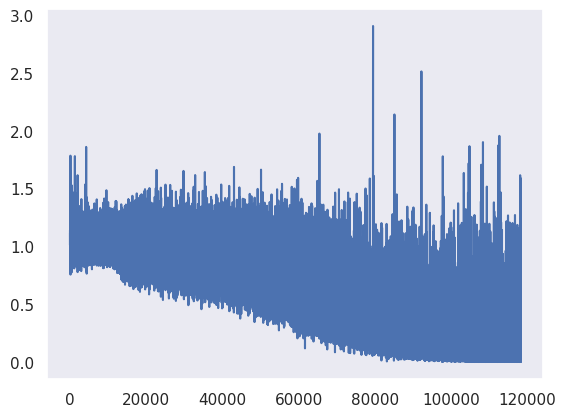

In [57]:
plt.plot(train_losses)

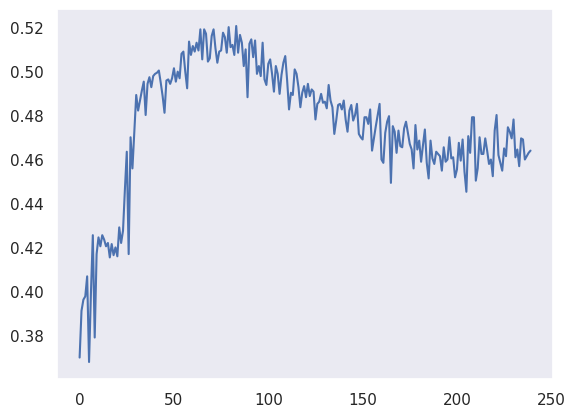

In [58]:
plt.plot(test_accuracy)

In [62]:
blayer = best_model.fe_blocks.blocks[0].block.layer

bnamed_params = [p for p in blayer.named_parameters()]
bnamed_params

[('lowcut_bands',
  Parameter containing:
  tensor([[0.0000],
          [0.0026],
          [0.0054],
          [0.0084],
          [0.0116],
          [0.0149],
          [0.0184],
          [0.0222],
          [0.0262],
          [0.0304],
          [0.0349],
          [0.0396],
          [0.0446],
          [0.0500],
          [0.0556],
          [0.0616],
          [0.0680],
          [0.0747],
          [0.0819],
          [0.0895],
          [0.0975],
          [0.1060],
          [0.1151],
          [0.1247],
          [0.1348],
          [0.1456],
          [0.1570],
          [0.1691],
          [0.1820],
          [0.1956],
          [0.2101],
          [0.2254],
          [0.2416],
          [0.2589],
          [0.2771],
          [0.2965],
          [0.3170],
          [0.3388],
          [0.3619],
          [0.3864],
          [0.4123],
          [0.4399],
          [0.4690],
          [0.0000],
          [0.0040],
          [0.0081],
          [0.0124],
          [0.0170]

Time domain: Filters' shapes vary by frequency bins


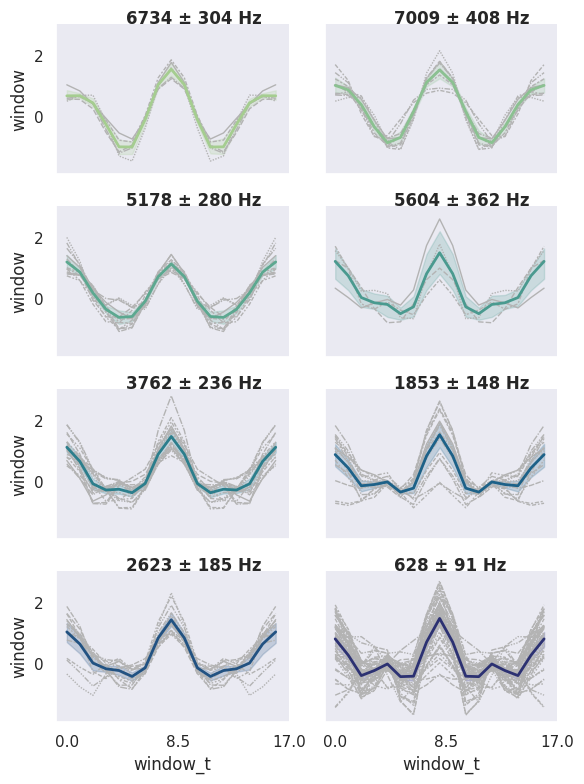

In [63]:
bfiltviz = visualize_model.FilterVisualizer(
    lowcut_bands = blayer.lowcut_bands, 
    bandwidths = blayer.bandwidths,
    window_params = blayer.window_params, 
    window_length = 64,
    sample_rate = sr
)
bfiltviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


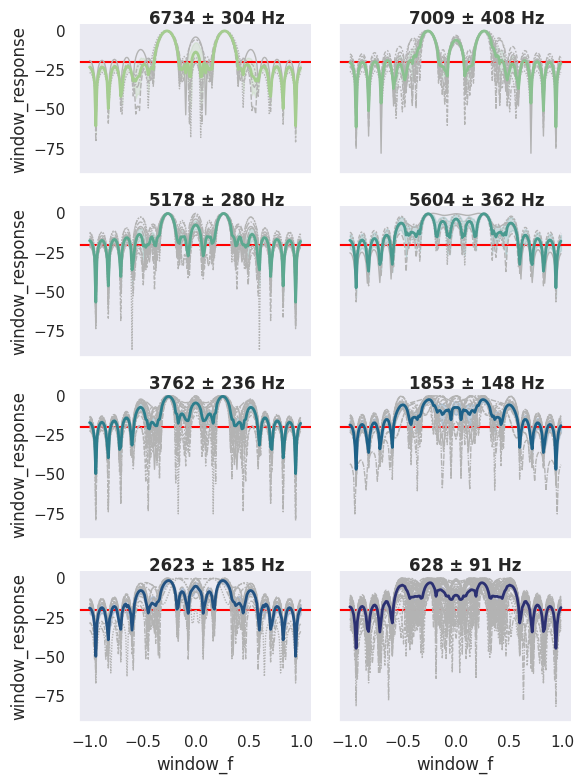

In [64]:
bfiltviz.visualize_filters(filter_domain='freq')

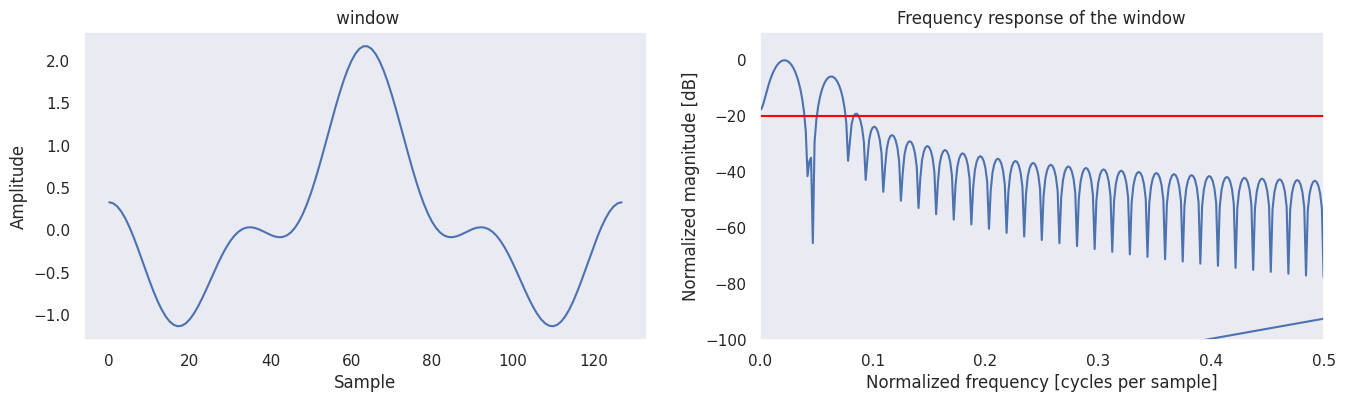

In [65]:
bfiltviz.visualize_one_window(n_out=10)

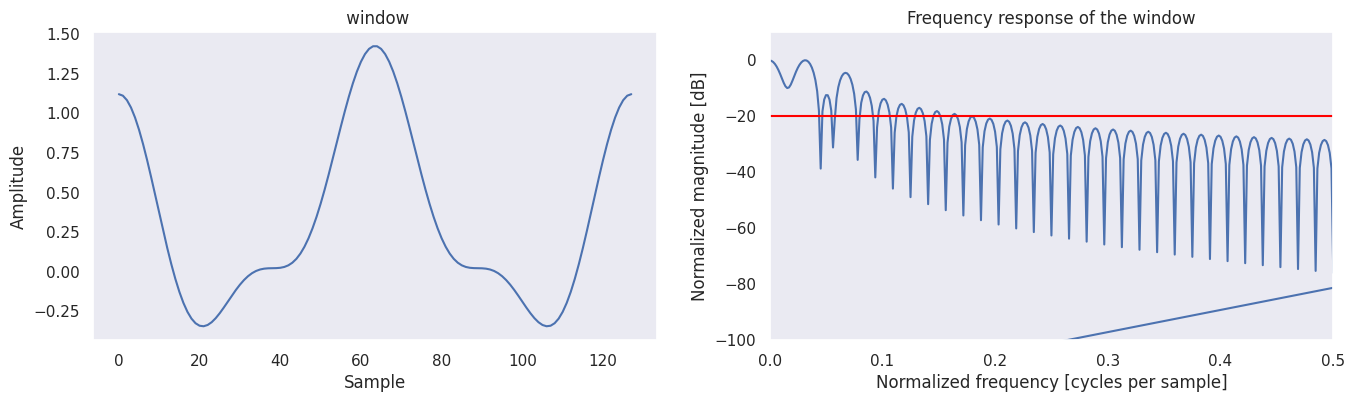

In [66]:
bfiltviz.visualize_one_window(n_out=30)

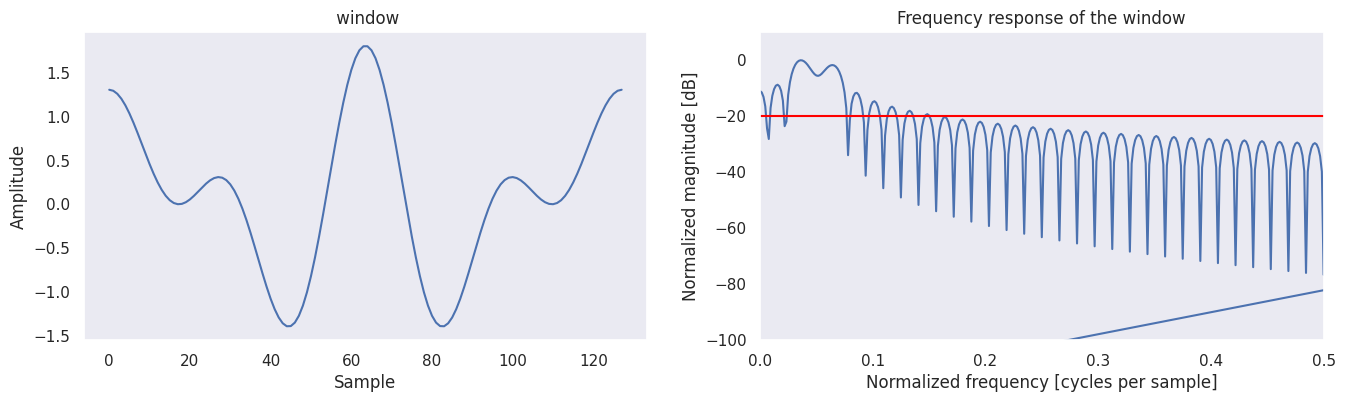

In [67]:
bfiltviz.visualize_one_window(n_out=50)

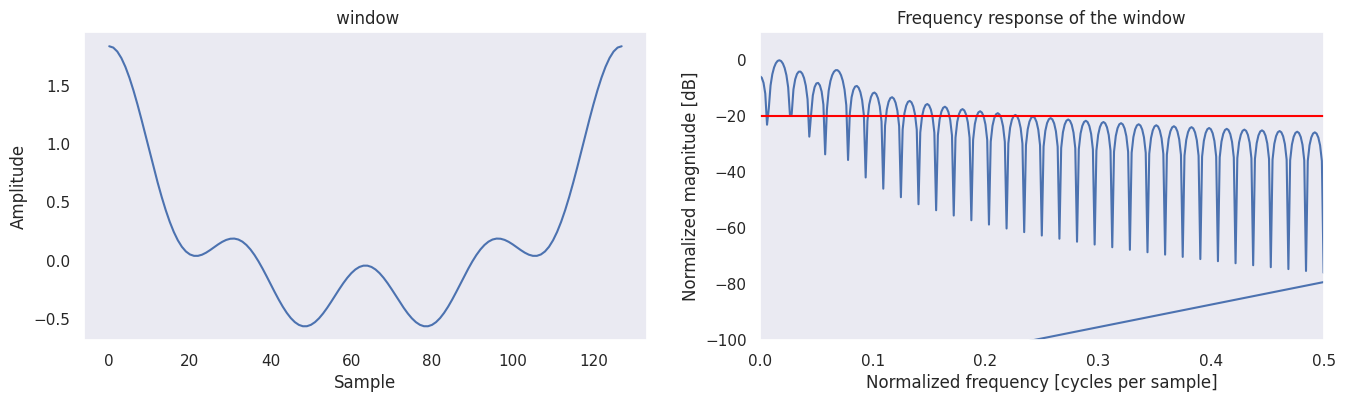

In [68]:
bfiltviz.visualize_one_window(n_out=60)

In [71]:
df_neutral = df[df['emotion']=='neutral'][4000:]

In [72]:
df_neutral['audio'] = df_neutral['filename'].apply(load_audio)

In [74]:
df_neutral['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    22009
Name: count, dtype: int64

In [75]:
x_neutral = df_neutral['audio'].to_list()
y_neutral = df_neutral['emotion'].to_list()

In [76]:
neutral_set = list(zip(x_neutral, y_neutral))

In [77]:
neutral_loader = torch.utils.data.DataLoader(
    neutral_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [79]:
best_model.to(device)
neutral_metrics_best, neutral_confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device, test_loader=neutral_loader)
best_model.to('cpu')
pprint(neutral_metrics_best.compute())
neutral_confusion_matrix_best.compute()

Correct: 9481/22000 (0.4310)
{'acc_detail': tensor([0.0000, 0.4310, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.1437, device='cuda:0'),
 'acc_weighted': tensor(0.4310, device='cuda:0'),
 'f1s': tensor(0.2008, device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.6023, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0., 1., 0.], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.4310, 0.0000], device='cuda:0'),
 'rocauc': tensor([0., 0., 0.], device='cuda:0'),
 'uar': tensor(0.1437, device='cuda:0'),
 'wap': tensor(1., device='cuda:0')}


/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


tensor([[   0,    0,    0],
        [8251, 9481, 4268],
        [   0,    0,    0]], device='cuda:0')